# Human Emotion Detection - Farid's Notebook

In [14]:
import os
import pathlib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import seaborn as sns

# import numpy as np
import tensorflow as tf

random_state = 42

%matplotlib inline

## Exploratory Data Analysis (EDA)

### Loading and Cleaning the Data

In [15]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "raw_data")

df = pd.DataFrame(columns=["filename", "label"])
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            filelist = [f.name for f in os.scandir(entry_path)]
            df = pd.concat(
                [df, pd.DataFrame({"filename": filelist, "label": entry.name})]
            )

df.reset_index(inplace=True, drop=True)
df.describe()

,filename,label
count,5558,5558
unique,5233,8
top,images (55)_face.png,happiness
freq,6,1406


It looks like some files appear in multiple folders. We need to make sure these are not actual duplicate images. Because if that is the case, it makes the problem one of "multilabel" image classification. First, let's find out how many file _names_ are duplicated...

In [16]:
dups = df[df["filename"].duplicated(keep=False)]
dups["filename"].nunique()

125

Let's take a look at some of these...

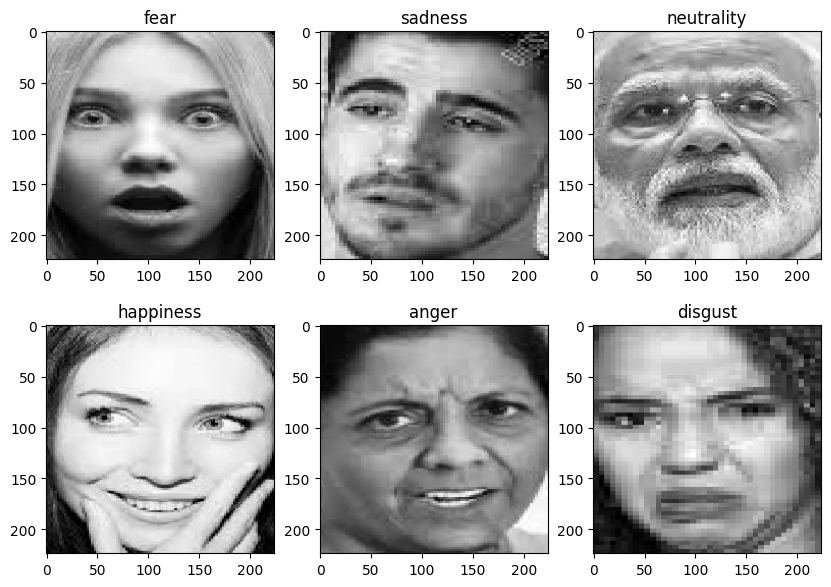

In [17]:
fig = plt.figure(figsize=(10, 7))
i = 0
for row in df.query("filename == 'images (55)_face.png'").iterrows():
    filename = row[1][0]
    label = row[1][1]
    path = os.path.join(data_path, label, filename)
    ax = fig.add_subplot(2, 3, i + 1)
    img = mpimg.imread(path)
    ax.imshow(img, cmap="gray")
    ax.title.set_text(label)
    i = i + 1

Looks like they're actually different images. We've only looked at one duplicated file name but hopefully it's safe to assume this applies to all the other ones as well 🤞 and we can continue with multiclass classification.  
For future reference and in case we do need to drop duplicates in the future:
```python
df = df.drop_duplicates(subset=["filename"], keep=False)
df.describe()
```

### Data Imbalance

Now let's take a look at the distribution of labels...

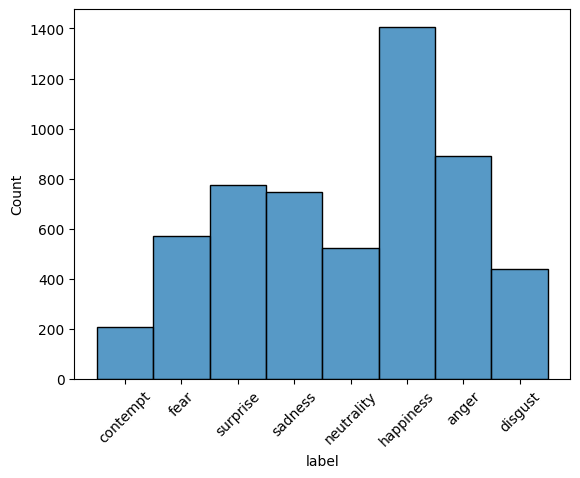

In [18]:
ax = sns.histplot(df.label)
ax.tick_params(axis="x", rotation=45);

The data looks quite unbalanced...  
**<u>TO DO</u>:** Use stratified sampling or try balancing the dataset using over/under-sampling methods (SMOTE, etc.), data augmentation, etc. 

## Preparing the Data

### The Manual Way

**NOTE:** I initially started on this path until I realized halfway through that I didn't need to do any of this stuff. But I'm going to leave this section in anyway.

Let's encode the labels first. We could use `sklearn.preprocessing.OneHotEncoder`, but I'd like to use `tf.keras.utils.to_categorical` this time...

In [19]:
i = 0
label_dict = {}
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            label_dict[entry.name] = i
        i = i + 1
label_dict

{'contempt': 0,
 'fear': 1,
 'surprise': 2,
 'sadness': 3,
 'neutrality': 4,
 'happiness': 5,
 'anger': 6,
 'disgust': 7}

In [20]:
df["label_int"] = df.label.apply(lambda x: label_dict[x])

df.sample(n=5)

,filename,label,label_int
1578,images - 2020-11-06T195210.473_face.png,sadness,3
2692,images - 2020-11-06T000121.836_face.png,neutrality,4
3518,images - 2020-11-06T005528.680_face.png,happiness,5
5421,images (43)_face.png,disgust,7
4860,images - 2020-11-05T231400.442_face.png,anger,6


In [21]:
from tensorflow.keras.utils import to_categorical

n_classes = len(label_dict)
y = to_categorical(df.label_int, n_classes)
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's also replace the `filename` column with the full path to each file to make things easier...

In [22]:
df["filepath"] = df.apply(
    lambda x: os.path.join(data_path, x["label"], x["filename"]), axis=1
)
df.drop(columns="filename", inplace=True)

In [28]:
df.sample(n=5)

,label,label_int,filepath
5347,disgust,7,/Users/fafa/code/nihonlanguageprocessing/human...
3748,happiness,5,/Users/fafa/code/nihonlanguageprocessing/human...
3947,happiness,5,/Users/fafa/code/nihonlanguageprocessing/human...
1807,sadness,3,/Users/fafa/code/nihonlanguageprocessing/human...
855,surprise,2,/Users/fafa/code/nihonlanguageprocessing/human...


In [23]:
X = df.filepath
X

0       /Users/fafa/code/nihonlanguageprocessing/human...
1       /Users/fafa/code/nihonlanguageprocessing/human...
2       /Users/fafa/code/nihonlanguageprocessing/human...
3       /Users/fafa/code/nihonlanguageprocessing/human...
4       /Users/fafa/code/nihonlanguageprocessing/human...
                              ...                        
5553    /Users/fafa/code/nihonlanguageprocessing/human...
5554    /Users/fafa/code/nihonlanguageprocessing/human...
5555    /Users/fafa/code/nihonlanguageprocessing/human...
5556    /Users/fafa/code/nihonlanguageprocessing/human...
5557    /Users/fafa/code/nihonlanguageprocessing/human...
Name: filepath, Length: 5558, dtype: object

Now we have everything we need in order to create the training, validation and test data sets.

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=random_state
)

### Using TensorFlow Keras Utilities

Turns out we didn't need to do any of that, because `tf.keras.utils.image_dataset_from_directory` will take care of everything for us.

In [46]:
# Some common CONSTants...

BATCH_SIZE = 32
IMG_DIM = 224 # height = width
N_CHANNELS = 3 # The input images are greyscale but we need RGB in order to use pre-trained models

# Note: In Python 3.7+ dictionaries are ordered.
class_names = list(label_dict.keys())

In [47]:
ds_train, ds_val_test = tf.keras.utils.image_dataset_from_directory(
    directory=data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True,
    seed=random_state,
    validation_split=0.2,
    subset="both",
)

Found 5558 files belonging to 8 classes.
Using 4447 files for training.
Using 1111 files for validation.


In [48]:
val_test_batches = tf.data.experimental.cardinality(ds_val_test)
ds_val = ds_val_test.take(val_test_batches // 2)
ds_test = ds_val_test.skip(val_test_batches // 2)

## Modeling

### Basline Model

What would be a good baseline model and score to use as a reference point?

In [54]:
# TO DO

### Transfer Learning

Let's get a pre-trained model and fine-tune it to our task.

In [75]:
# Some more CONSTants...

LR = 1e-5
N_EPOCHS = 100

DO_1 = 0.4
DO_2 = 0.2
L2_REG_1 = 0.01
L2_REG_2 = 0.003

In [76]:
def get_pretrained_model():
    model_pretrained = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(IMG_DIM, IMG_DIM, N_CHANNELS))
    model_pretrained.trainable = False
    return model_pretrained

In [77]:
pretrained = get_pretrained_model()
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [78]:
def get_compiled_custom_model(num_classes):
    base_model = get_pretrained_model()
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(
        100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_1)
    )
    dropout_layer_1 = tf.keras.layers.Dropout(DO_1)
    dense_layer_2 = tf.keras.layers.Dense(
        50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_2)
    )
    dropout_layer_2 = tf.keras.layers.Dropout(DO_2)
    # dense_layer_3 = tf.keras.layers.Dense(
    #     25, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
    # )
    # dropout_layer_3 = tf.keras.layers.Dropout(DO3)
    prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")

    model = tf.keras.models.Sequential(
        [
            base_model,
            flattening_layer,
            dense_layer_1,
            dropout_layer_1,
            dense_layer_2,
            dropout_layer_2,
            # dense_layer_3,
            # dropout_layer_3,
            prediction_layer,
        ]
    )

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [79]:
model = get_compiled_custom_model(num_classes=n_classes)

In [80]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               2508900   
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                

In [82]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)
history = model.fit(
    ds_train, epochs=N_EPOCHS, validation_data=ds_val, verbose=1, callbacks=[es]
)

Epoch 1/100


2023-04-25 09:46:45.049562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:46:45.050073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:46:45.053384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:46:45.054960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:46:45.058812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 16.5666 - accuracy: 0.1094

2023-04-25 09:46:48.725017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:46:48.733931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 17.6614 - accuracy: 0.0859

2023-04-25 09:46:52.348773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 17.4066 - accuracy: 0.0982

2023-04-25 09:46:57.782845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 17.3289 - accuracy: 0.0977

2023-04-25 09:46:59.595713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 17.6366 - accuracy: 0.1007

2023-04-25 09:47:01.413316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:47:01.426842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 17.5280 - accuracy: 0.1031

2023-04-25 09:47:03.237890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 17.3344 - accuracy: 0.1172

2023-04-25 09:47:06.859107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 16.1288 - accuracy: 0.1250

2023-04-25 09:47:15.899722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 15.9001 - accuracy: 0.1235

2023-04-25 09:47:23.128658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 15.8486 - accuracy: 0.1222

2023-04-25 09:47:24.954806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 15.6856 - accuracy: 0.1223

2023-04-25 09:47:26.749126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:47:26.757293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 15.5793 - accuracy: 0.1224

2023-04-25 09:47:28.553356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 15.1185 - accuracy: 0.1261

2023-04-25 09:47:35.785686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:47:35.790249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 14.8669 - accuracy: 0.1299

2023-04-25 09:47:43.020776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 14.7723 - accuracy: 0.1287

2023-04-25 09:47:46.637958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 14.7058 - accuracy: 0.1285

2023-04-25 09:47:50.349118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:47:50.352263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 14.6353 - accuracy: 0.1301

2023-04-25 09:47:52.163268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 09:47:52.163327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 14.3709 - accuracy: 0.1337

2023-04-25 09:48:03.055535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 14.3039 - accuracy: 0.1371

2023-04-25 09:48:04.864057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 14.2112 - accuracy: 0.1345

2023-04-25 09:48:08.483674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 14.0409 - accuracy: 0.1338

2023-04-25 09:48:15.714591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 13.9884 - accuracy: 0.1354

2023-04-25 09:48:17.528023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 13.9686 - accuracy: 0.1346

2023-04-25 09:48:19.328087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:48:19.338381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 13.9392 - accuracy: 0.1344

2023-04-25 09:48:21.138620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 13.8482 - accuracy: 0.1354

2023-04-25 09:48:22.950377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 13.8439 - accuracy: 0.1362

2023-04-25 09:48:26.568470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 13.6677 - accuracy: 0.1404

2023-04-25 09:48:35.611589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:48:35.614784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 13.6422 - accuracy: 0.1404

2023-04-25 09:48:39.246217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 13.5838 - accuracy: 0.1392

2023-04-25 09:48:41.051860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 13.3672 - accuracy: 0.1406

2023-04-25 09:48:51.918912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 13.3070 - accuracy: 0.1408

2023-04-25 09:48:53.726268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 13.1835 - accuracy: 0.1413

2023-04-25 09:48:57.346974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:48:57.349981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 13.0288 - accuracy: 0.1433

2023-04-25 09:49:04.609894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 12.8719 - accuracy: 0.1462

2023-04-25 09:49:11.845114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:49:11.849567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:49:11.853210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 12.8253 - accuracy: 0.1475

2023-04-25 09:49:13.654716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 12.7796 - accuracy: 0.1461

2023-04-25 09:49:15.465243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 12.7467 - accuracy: 0.1469

2023-04-25 09:49:17.276934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 12.7200 - accuracy: 0.1474

2023-04-25 09:49:19.093255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 12.7001 - accuracy: 0.1476

2023-04-25 09:49:22.711533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 12.6598 - accuracy: 0.1468

2023-04-25 09:49:26.341442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 12.5451 - accuracy: 0.1461

2023-04-25 09:49:31.767228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:49:31.770657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:49:31.774073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 12.3979 - accuracy: 0.1475

2023-04-25 09:49:39.016110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 12.3613 - accuracy: 0.1479

2023-04-25 09:49:40.838435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 12.3082 - accuracy: 0.1469

2023-04-25 09:49:46.284750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 12.2911 - accuracy: 0.1470

2023-04-25 09:49:48.095312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:49:48.108204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 12.2490 - accuracy: 0.1471

2023-04-25 09:49:49.903933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 12.2174 - accuracy: 0.1481

2023-04-25 09:49:51.710918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:49:51.723849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 12.1720 - accuracy: 0.1500

2023-04-25 09:49:55.342874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 12.0366 - accuracy: 0.1505

2023-04-25 09:50:02.575894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 11.9997 - accuracy: 0.1490

2023-04-25 09:50:08.025569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 11.9569 - accuracy: 0.1499

2023-04-25 09:50:09.831757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 11.9058 - accuracy: 0.1495

2023-04-25 09:50:13.461058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:50:13.469257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:50:13.471668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 11.8767 - accuracy: 0.1498

2023-04-25 09:50:15.270408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 11.8087 - accuracy: 0.1502

2023-04-25 09:50:20.698329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:50:20.708016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 11.7778 - accuracy: 0.1500

2023-04-25 09:50:22.534713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 11.7463 - accuracy: 0.1498

2023-04-25 09:50:24.338005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 11.7097 - accuracy: 0.1501

2023-04-25 09:50:26.152709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 09:50:26.152726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:50:26.154384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:50:26.163987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 11.6738 - accuracy: 0.1499

2023-04-25 09:50:27.969191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 11.6389 - accuracy: 0.1502

2023-04-25 09:50:29.789786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:50:29.798158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 11.6011 - accuracy: 0.1505

2023-04-25 09:50:31.605914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 11.5723 - accuracy: 0.1498

2023-04-25 09:50:33.408096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 11.2262 - accuracy: 0.1482

2023-04-25 09:50:58.855420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:00.665371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:02.475336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:04.275546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:07.892511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:07.893081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 283s 2s/step - loss: 11.2262 - accuracy: 0.1482 - val_loss: 5.6384 - val_accuracy: 0.2096
Epoch 2/100


2023-04-25 09:51:27.813497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:27.814309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:27.818242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:27.820149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:27.823767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 7.8234 - accuracy: 0.1562

2023-04-25 09:51:31.482040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:31.482110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 6.9241 - accuracy: 0.2109

2023-04-25 09:51:35.097628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 7.0208 - accuracy: 0.2054

2023-04-25 09:51:40.531620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 7.2081 - accuracy: 0.1992

2023-04-25 09:51:42.349878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 7.2900 - accuracy: 0.1979

2023-04-25 09:51:44.156717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:51:44.175965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 7.2407 - accuracy: 0.1937

2023-04-25 09:51:45.981830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 7.2223 - accuracy: 0.1875

2023-04-25 09:51:49.594073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 7.4248 - accuracy: 0.1765

2023-04-25 09:51:58.641739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 7.3374 - accuracy: 0.1786

2023-04-25 09:52:05.907698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 7.3601 - accuracy: 0.1776

2023-04-25 09:52:07.723940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 7.4230 - accuracy: 0.1780

2023-04-25 09:52:09.533644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:52:09.534329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 7.4267 - accuracy: 0.1758

2023-04-25 09:52:11.332560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 7.3755 - accuracy: 0.1763

2023-04-25 09:52:18.587683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:52:18.595510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 7.3122 - accuracy: 0.1719

2023-04-25 09:52:25.835118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 7.2903 - accuracy: 0.1664

2023-04-25 09:52:29.457974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 7.3017 - accuracy: 0.1667

2023-04-25 09:52:33.101727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:52:33.102330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 7.2907 - accuracy: 0.1655

2023-04-25 09:52:34.907794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 09:52:34.908866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 7.2328 - accuracy: 0.1606

2023-04-25 09:52:45.774365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 7.2011 - accuracy: 0.1591

2023-04-25 09:52:47.590348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 7.2249 - accuracy: 0.1610

2023-04-25 09:52:51.194347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 7.1795 - accuracy: 0.1606

2023-04-25 09:52:58.448451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 7.1464 - accuracy: 0.1624

2023-04-25 09:53:00.259547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 7.1275 - accuracy: 0.1635

2023-04-25 09:53:02.071447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:53:02.078182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 7.1147 - accuracy: 0.1639

2023-04-25 09:53:03.869471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 7.1124 - accuracy: 0.1649

2023-04-25 09:53:05.709884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 7.0996 - accuracy: 0.1652

2023-04-25 09:53:09.325379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 7.0104 - accuracy: 0.1685

2023-04-25 09:53:18.359291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:53:18.363434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 6.9774 - accuracy: 0.1691

2023-04-25 09:53:21.996871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 6.9783 - accuracy: 0.1680

2023-04-25 09:53:23.791502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 6.9207 - accuracy: 0.1679

2023-04-25 09:53:34.676474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 6.9110 - accuracy: 0.1686

2023-04-25 09:53:36.486486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 6.8961 - accuracy: 0.1678

2023-04-25 09:53:40.101675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:53:40.105924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 6.8452 - accuracy: 0.1656

2023-04-25 09:53:47.355908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 6.8195 - accuracy: 0.1640

2023-04-25 09:53:54.578977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:53:54.584316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:53:54.591386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 6.8151 - accuracy: 0.1639

2023-04-25 09:53:56.390595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 6.8195 - accuracy: 0.1634

2023-04-25 09:53:58.199019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 6.8257 - accuracy: 0.1622

2023-04-25 09:54:00.043894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 6.8074 - accuracy: 0.1614

2023-04-25 09:54:01.846501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 6.7883 - accuracy: 0.1631

2023-04-25 09:54:05.461917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 6.7714 - accuracy: 0.1633

2023-04-25 09:54:09.095411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 6.7448 - accuracy: 0.1617

2023-04-25 09:54:14.498273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:54:14.498762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:54:14.501977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 6.7070 - accuracy: 0.1602

2023-04-25 09:54:21.754303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 6.7021 - accuracy: 0.1604

2023-04-25 09:54:23.574168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 6.6730 - accuracy: 0.1622

2023-04-25 09:54:29.015456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 6.6630 - accuracy: 0.1631

2023-04-25 09:54:30.811529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:54:30.822271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 6.6530 - accuracy: 0.1627

2023-04-25 09:54:32.624442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 6.6446 - accuracy: 0.1632

2023-04-25 09:54:34.434854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:54:34.446378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 6.6331 - accuracy: 0.1625

2023-04-25 09:54:38.075373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 6.6185 - accuracy: 0.1626

2023-04-25 09:54:45.303009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 6.5944 - accuracy: 0.1624

2023-04-25 09:54:50.742570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 6.5915 - accuracy: 0.1623

2023-04-25 09:54:52.541879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 6.5777 - accuracy: 0.1633

2023-04-25 09:54:56.162998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:54:56.173162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:54:56.173850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 6.5697 - accuracy: 0.1641

2023-04-25 09:54:57.980010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 6.5465 - accuracy: 0.1649

2023-04-25 09:55:03.421185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:03.453294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 6.5395 - accuracy: 0.1641

2023-04-25 09:55:05.256093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 6.5333 - accuracy: 0.1635

2023-04-25 09:55:07.068095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 6.5289 - accuracy: 0.1629

2023-04-25 09:55:08.873486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:08.873700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 09:55:08.873704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:08.885267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 6.5235 - accuracy: 0.1626

2023-04-25 09:55:10.683599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 6.5186 - accuracy: 0.1626

2023-04-25 09:55:12.494974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:12.504963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 6.5113 - accuracy: 0.1630

2023-04-25 09:55:14.314717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 6.5075 - accuracy: 0.1627

2023-04-25 09:55:16.124812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 6.4133 - accuracy: 0.1635

2023-04-25 09:55:41.429759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:43.242897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:45.045211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:46.849616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:50.468876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:55:50.469049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 283s 2s/step - loss: 6.4133 - accuracy: 0.1635 - val_loss: 4.6753 - val_accuracy: 0.1912
Epoch 3/100


2023-04-25 09:56:10.371936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:56:10.372204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:56:10.376132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:56:10.378162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:56:10.382163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 5.1192 - accuracy: 0.2188

2023-04-25 09:56:14.027046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:56:14.034174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 5.1477 - accuracy: 0.1562

2023-04-25 09:56:17.654371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 5.1590 - accuracy: 0.1696

2023-04-25 09:56:23.096385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 5.1725 - accuracy: 0.1758

2023-04-25 09:56:24.910066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 5.1213 - accuracy: 0.1840

2023-04-25 09:56:26.719941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:56:26.732066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 5.1040 - accuracy: 0.1844

2023-04-25 09:56:28.544468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 5.1036 - accuracy: 0.1875

2023-04-25 09:56:32.165809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 5.1171 - accuracy: 0.1783

2023-04-25 09:56:41.230695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:37 - loss: 5.1613 - accuracy: 0.1711

2023-04-25 09:56:49.071473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:35 - loss: 5.1490 - accuracy: 0.1690

2023-04-25 09:56:50.908331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:33 - loss: 5.1306 - accuracy: 0.1698

2023-04-25 09:56:52.748523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:56:52.749231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:31 - loss: 5.1289 - accuracy: 0.1719

2023-04-25 09:56:54.563351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:24 - loss: 5.1168 - accuracy: 0.1752

2023-04-25 09:57:01.947283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:57:01.958718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:42 - loss: 5.1171 - accuracy: 0.1748

2023-04-25 09:57:16.556300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:38 - loss: 5.1127 - accuracy: 0.1765

2023-04-25 09:57:20.740888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:35 - loss: 5.1463 - accuracy: 0.1771

2023-04-25 09:57:25.403919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 09:57:25.404540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:33 - loss: 5.1227 - accuracy: 0.1782

2023-04-25 09:57:27.740259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 09:57:27.740292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:25 - loss: 5.1029 - accuracy: 0.1802

2023-04-25 09:57:42.226278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:24 - loss: 5.0832 - accuracy: 0.1818

2023-04-25 09:57:44.724337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:21 - loss: 5.0694 - accuracy: 0.1827

2023-04-25 09:57:49.731970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 16:05 - loss: 5.0648 - accuracy: 0.1887

2023-04-25 10:05:03.912305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 15:38 - loss: 5.0620 - accuracy: 0.1875

2023-04-25 10:05:05.717277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 15:13 - loss: 5.0558 - accuracy: 0.1893

2023-04-25 10:05:07.579478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:05:07.589731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 14:48 - loss: 5.0495 - accuracy: 0.1893

2023-04-25 10:05:09.589416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 14:24 - loss: 5.0515 - accuracy: 0.1875

2023-04-25 10:05:11.551167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 13:39 - loss: 5.0613 - accuracy: 0.1853

2023-04-25 10:05:15.480502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 11:59 - loss: 5.0449 - accuracy: 0.1829

2023-04-25 10:05:25.820266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:05:25.825473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 11:23 - loss: 5.0459 - accuracy: 0.1840

2023-04-25 10:05:30.129908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 11:06 - loss: 5.0421 - accuracy: 0.1851

2023-04-25 10:05:32.315275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 22:41 - loss: 5.0374 - accuracy: 0.1853

2023-04-25 10:18:53.783399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 22:04 - loss: 5.0300 - accuracy: 0.1866

2023-04-25 10:18:56.163306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 20:53 - loss: 5.0366 - accuracy: 0.1871

2023-04-25 10:18:59.871860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:18:59.873792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 18:41 - loss: 5.0150 - accuracy: 0.1879

2023-04-25 10:19:07.124694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 16:42 - loss: 5.0050 - accuracy: 0.1856

2023-04-25 10:19:14.442455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:19:14.450969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:19:14.454794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 16:13 - loss: 5.0012 - accuracy: 0.1852

2023-04-25 10:19:16.269732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 15:46 - loss: 5.0042 - accuracy: 0.1849

2023-04-25 10:19:18.065007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 15:19 - loss: 5.0081 - accuracy: 0.1845

2023-04-25 10:19:19.864491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 14:53 - loss: 5.0146 - accuracy: 0.1857

2023-04-25 10:19:21.691465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 14:02 - loss: 5.0196 - accuracy: 0.1835

2023-04-25 10:19:25.440708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 13:13 - loss: 5.0164 - accuracy: 0.1843

2023-04-25 10:19:29.252751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 12:04 - loss: 5.0084 - accuracy: 0.1855

2023-04-25 10:19:35.144371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:19:35.144760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:19:35.146957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 10:38 - loss: 4.9963 - accuracy: 0.1855

2023-04-25 10:19:43.426888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 10:18 - loss: 4.9913 - accuracy: 0.1846

2023-04-25 10:19:45.558452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 9:19 - loss: 4.9913 - accuracy: 0.1831

2023-04-25 10:19:51.375439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 8:59 - loss: 4.9861 - accuracy: 0.1838

2023-04-25 10:19:53.178211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:19:53.188519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 8:41 - loss: 4.9854 - accuracy: 0.1838

2023-04-25 10:19:54.983249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 8:22 - loss: 4.9927 - accuracy: 0.1826

2023-04-25 10:19:56.796567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:19:56.806898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 7:46 - loss: 4.9986 - accuracy: 0.1810

2023-04-25 10:20:00.390586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 6:38 - loss: 4.9858 - accuracy: 0.1795

2023-04-25 10:20:07.609028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 5:50 - loss: 4.9779 - accuracy: 0.1794

2023-04-25 10:20:12.991337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 5:34 - loss: 4.9811 - accuracy: 0.1798

2023-04-25 10:20:14.768442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 5:04 - loss: 4.9814 - accuracy: 0.1802

2023-04-25 10:20:18.340020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:20:18.343563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:20:18.344739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 4:49 - loss: 4.9853 - accuracy: 0.1797

2023-04-25 10:20:20.132749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 4:06 - loss: 4.9844 - accuracy: 0.1786

2023-04-25 10:20:25.622622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:20:25.633907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 3:52 - loss: 4.9800 - accuracy: 0.1786

2023-04-25 10:20:27.433935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 3:38 - loss: 4.9790 - accuracy: 0.1779

2023-04-25 10:20:29.222223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 3:24 - loss: 4.9743 - accuracy: 0.1780

2023-04-25 10:20:31.013323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:20:31.018096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:20:31.018115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:20:31.025907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 3:11 - loss: 4.9719 - accuracy: 0.1773

2023-04-25 10:20:32.801788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:58 - loss: 4.9703 - accuracy: 0.1764

2023-04-25 10:20:34.599590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:20:34.602218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 2:45 - loss: 4.9651 - accuracy: 0.1762

2023-04-25 10:20:36.395330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 2:32 - loss: 4.9651 - accuracy: 0.1761

2023-04-25 10:20:38.211210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.9301 - accuracy: 0.1765 

2023-04-25 10:21:03.281616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:05.070678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:06.861001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:08.644981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:12.217577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:12.219167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 1522s 11s/step - loss: 4.9301 - accuracy: 0.1765 - val_loss: 4.3904 - val_accuracy: 0.1949
Epoch 4/100


2023-04-25 10:21:31.927132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:31.927779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:31.931155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:31.933105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:31.937019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:05 - loss: 4.6001 - accuracy: 0.1719

2023-04-25 10:21:35.543790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:35.545194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:02 - loss: 4.5969 - accuracy: 0.1719

2023-04-25 10:21:39.136576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:56 - loss: 4.7131 - accuracy: 0.2009

2023-04-25 10:21:44.514559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:55 - loss: 4.7186 - accuracy: 0.1914

2023-04-25 10:21:46.313796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:53 - loss: 4.6736 - accuracy: 0.1944

2023-04-25 10:21:48.110531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:21:48.120201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:51 - loss: 4.6401 - accuracy: 0.2031

2023-04-25 10:21:49.913861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:47 - loss: 4.6374 - accuracy: 0.2109

2023-04-25 10:21:53.489807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:38 - loss: 4.6682 - accuracy: 0.2151

2023-04-25 10:22:02.460310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:31 - loss: 4.6380 - accuracy: 0.2113

2023-04-25 10:22:09.643732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:29 - loss: 4.6231 - accuracy: 0.2102

2023-04-25 10:22:11.434117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:28 - loss: 4.6360 - accuracy: 0.2065

2023-04-25 10:22:13.232491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:22:13.233047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:26 - loss: 4.6333 - accuracy: 0.2031

2023-04-25 10:22:15.010280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 4.6355 - accuracy: 0.2009

2023-04-25 10:22:22.787776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:22:22.799859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 4.6310 - accuracy: 0.1904

2023-04-25 10:22:30.046112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 4.6384 - accuracy: 0.1958

2023-04-25 10:22:33.623565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 4.6539 - accuracy: 0.1918

2023-04-25 10:22:37.225052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:22:37.227149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 4.6465 - accuracy: 0.1926

2023-04-25 10:22:39.025882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:22:39.025900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 4.6266 - accuracy: 0.1911

2023-04-25 10:22:49.787410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 4.6324 - accuracy: 0.1889

2023-04-25 10:22:51.590983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 4.6213 - accuracy: 0.1868

2023-04-25 10:22:55.185648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 4.6305 - accuracy: 0.1850

2023-04-25 10:23:02.417129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 4.6217 - accuracy: 0.1857

2023-04-25 10:23:04.208151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 4.6332 - accuracy: 0.1851

2023-04-25 10:23:06.001848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:23:06.005053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 4.6316 - accuracy: 0.1840

2023-04-25 10:23:07.789574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 4.6305 - accuracy: 0.1834

2023-04-25 10:23:09.589305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 4.6240 - accuracy: 0.1814

2023-04-25 10:23:13.186468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:20 - loss: 4.6352 - accuracy: 0.1793

2023-04-25 10:23:22.145269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:23:22.149156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 4.6316 - accuracy: 0.1786

2023-04-25 10:23:25.740166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 4.6342 - accuracy: 0.1782

2023-04-25 10:23:27.533072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 4.6029 - accuracy: 0.1835

2023-04-25 10:23:38.362133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 4.6076 - accuracy: 0.1840

2023-04-25 10:23:40.157076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 4.6087 - accuracy: 0.1841

2023-04-25 10:23:43.790300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:23:43.791260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:51 - loss: 4.6059 - accuracy: 0.1826

2023-04-25 10:23:50.995345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 4.6033 - accuracy: 0.1844

2023-04-25 10:23:58.227078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:23:58.237041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:23:58.244733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:42 - loss: 4.6001 - accuracy: 0.1852

2023-04-25 10:24:00.053767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 4.5977 - accuracy: 0.1849

2023-04-25 10:24:01.847568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 4.5974 - accuracy: 0.1838

2023-04-25 10:24:03.686981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 4.5992 - accuracy: 0.1842

2023-04-25 10:24:05.495200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:33 - loss: 4.5992 - accuracy: 0.1853

2023-04-25 10:24:09.113545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 4.5966 - accuracy: 0.1854

2023-04-25 10:24:12.737688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 4.5862 - accuracy: 0.1872

2023-04-25 10:24:18.169235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:24:18.169575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:24:18.172468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 4.5852 - accuracy: 0.1868

2023-04-25 10:24:25.382004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 4.5858 - accuracy: 0.1872

2023-04-25 10:24:27.214536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 4.5868 - accuracy: 0.1875

2023-04-25 10:24:33.653955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 4.5862 - accuracy: 0.1869

2023-04-25 10:24:35.579270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:24:35.588403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 4.5848 - accuracy: 0.1869

2023-04-25 10:24:37.529458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 4.5822 - accuracy: 0.1881

2023-04-25 10:24:39.436145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:24:39.455203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 4.5794 - accuracy: 0.1881

2023-04-25 10:24:43.169184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 4.5729 - accuracy: 0.1881

2023-04-25 10:24:50.769305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 4.5678 - accuracy: 0.1886

2023-04-25 10:24:56.365967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 4.5651 - accuracy: 0.1889

2023-04-25 10:24:58.175029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 4.5654 - accuracy: 0.1894

2023-04-25 10:25:01.967459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:01.972786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:01.973053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 4.5648 - accuracy: 0.1888

2023-04-25 10:25:03.831048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 4.5613 - accuracy: 0.1880

2023-04-25 10:25:09.508127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:09.528945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 4.5590 - accuracy: 0.1875

2023-04-25 10:25:11.417236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 4.5565 - accuracy: 0.1890

2023-04-25 10:25:13.249109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 4.5557 - accuracy: 0.1883

2023-04-25 10:25:15.090038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:15.091087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:25:15.091093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:15.108941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 4.5550 - accuracy: 0.1885

2023-04-25 10:25:16.940911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 4.5524 - accuracy: 0.1888

2023-04-25 10:25:18.753676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:18.759417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 4.5490 - accuracy: 0.1883

2023-04-25 10:25:20.684666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 4.5469 - accuracy: 0.1880

2023-04-25 10:25:22.543110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.5403 - accuracy: 0.1853

2023-04-25 10:25:47.978044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:49.793007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:51.617517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:53.428997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:57.050021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:25:57.050083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 285s 2s/step - loss: 4.5403 - accuracy: 0.1853 - val_loss: 4.2929 - val_accuracy: 0.2004
Epoch 5/100


2023-04-25 10:26:17.250703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:26:17.250791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:26:17.254298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:26:17.256018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:26:17.259820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 4.3538 - accuracy: 0.2656

2023-04-25 10:26:20.910953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:26:20.915054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:17 - loss: 4.3581 - accuracy: 0.1953

2023-04-25 10:26:24.822751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:05 - loss: 4.3538 - accuracy: 0.2054

2023-04-25 10:26:30.261264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:03 - loss: 4.3906 - accuracy: 0.2031

2023-04-25 10:26:32.085290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:00 - loss: 4.4128 - accuracy: 0.2014

2023-04-25 10:26:33.902068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:26:33.919160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:58 - loss: 4.3916 - accuracy: 0.2000

2023-04-25 10:26:35.723026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:53 - loss: 4.3822 - accuracy: 0.1979

2023-04-25 10:26:39.342938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:44 - loss: 4.4023 - accuracy: 0.1912

2023-04-25 10:26:48.493142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:36 - loss: 4.3910 - accuracy: 0.1920

2023-04-25 10:26:55.776767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:34 - loss: 4.3886 - accuracy: 0.1903

2023-04-25 10:26:57.598963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:32 - loss: 4.3876 - accuracy: 0.1916

2023-04-25 10:26:59.420612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:26:59.422653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:30 - loss: 4.3941 - accuracy: 0.1914

2023-04-25 10:27:01.242515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:23 - loss: 4.4002 - accuracy: 0.1875

2023-04-25 10:27:08.522953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:27:08.527115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:15 - loss: 4.4234 - accuracy: 0.1855

2023-04-25 10:27:15.787214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:11 - loss: 4.4071 - accuracy: 0.1884

2023-04-25 10:27:19.404136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:08 - loss: 4.4165 - accuracy: 0.1866

2023-04-25 10:27:23.218760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:27:23.226959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:07 - loss: 4.4138 - accuracy: 0.1850

2023-04-25 10:27:25.324697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:27:25.324712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:57 - loss: 4.3998 - accuracy: 0.1853

2023-04-25 10:27:36.603662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:55 - loss: 4.3944 - accuracy: 0.1839

2023-04-25 10:27:38.437089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:51 - loss: 4.3855 - accuracy: 0.1882

2023-04-25 10:27:42.060130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:43 - loss: 4.3898 - accuracy: 0.1900

2023-04-25 10:27:49.333573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:41 - loss: 4.3933 - accuracy: 0.1887

2023-04-25 10:27:51.136417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:40 - loss: 4.3883 - accuracy: 0.1881

2023-04-25 10:27:52.938992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:27:52.949572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:38 - loss: 4.3848 - accuracy: 0.1887

2023-04-25 10:27:54.748375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:36 - loss: 4.3856 - accuracy: 0.1887

2023-04-25 10:27:56.582632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:32 - loss: 4.3892 - accuracy: 0.1881

2023-04-25 10:28:00.223266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:23 - loss: 4.3797 - accuracy: 0.1875

2023-04-25 10:28:09.275583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:28:09.284206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:19 - loss: 4.3832 - accuracy: 0.1860

2023-04-25 10:28:12.907566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:17 - loss: 4.3815 - accuracy: 0.1851

2023-04-25 10:28:14.716998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:06 - loss: 4.3798 - accuracy: 0.1817

2023-04-25 10:28:25.588924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:04 - loss: 4.3768 - accuracy: 0.1818

2023-04-25 10:28:27.397027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 4.3754 - accuracy: 0.1832

2023-04-25 10:28:31.025920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:28:31.029675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:53 - loss: 4.3758 - accuracy: 0.1814

2023-04-25 10:28:38.281005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:46 - loss: 4.3741 - accuracy: 0.1844

2023-04-25 10:28:45.527865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:28:45.535382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:28:45.540982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:44 - loss: 4.3731 - accuracy: 0.1848

2023-04-25 10:28:47.359443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:42 - loss: 4.3719 - accuracy: 0.1856

2023-04-25 10:28:49.162635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 4.3733 - accuracy: 0.1845

2023-04-25 10:28:50.992653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 4.3710 - accuracy: 0.1846

2023-04-25 10:28:52.796550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:35 - loss: 4.3709 - accuracy: 0.1821

2023-04-25 10:28:56.440671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:31 - loss: 4.3723 - accuracy: 0.1822

2023-04-25 10:29:00.089984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 4.3695 - accuracy: 0.1841

2023-04-25 10:29:05.513743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:05.514273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:05.518853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 4.3644 - accuracy: 0.1872

2023-04-25 10:29:12.760137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 4.3641 - accuracy: 0.1872

2023-04-25 10:29:14.572585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:11 - loss: 4.3637 - accuracy: 0.1866

2023-04-25 10:29:20.004938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 4.3628 - accuracy: 0.1863

2023-04-25 10:29:21.814650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:21.828087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 4.3612 - accuracy: 0.1872

2023-04-25 10:29:23.627542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 4.3639 - accuracy: 0.1869

2023-04-25 10:29:25.444012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:25.457993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 4.3605 - accuracy: 0.1878

2023-04-25 10:29:29.078108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 4.3559 - accuracy: 0.1886

2023-04-25 10:29:36.338952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 4.3566 - accuracy: 0.1878

2023-04-25 10:29:41.795391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 4.3551 - accuracy: 0.1872

2023-04-25 10:29:43.599286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 4.3555 - accuracy: 0.1872

2023-04-25 10:29:47.238326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:47.243042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:47.247221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 4.3558 - accuracy: 0.1880

2023-04-25 10:29:49.052263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 4.3522 - accuracy: 0.1880

2023-04-25 10:29:54.485070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:54.494503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 4.3511 - accuracy: 0.1885

2023-04-25 10:29:56.311777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 4.3517 - accuracy: 0.1885

2023-04-25 10:29:58.113491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 4.3521 - accuracy: 0.1875

2023-04-25 10:29:59.931961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:29:59.931975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:59.932232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:29:59.943495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 4.3508 - accuracy: 0.1872

2023-04-25 10:30:01.755695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 4.3500 - accuracy: 0.1870

2023-04-25 10:30:03.571082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:30:03.577438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 4.3499 - accuracy: 0.1873

2023-04-25 10:30:05.392173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 4.3521 - accuracy: 0.1870

2023-04-25 10:30:07.207818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.3501 - accuracy: 0.1878

2023-04-25 10:30:32.548339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:30:34.356485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:30:36.163910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:30:37.972928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:30:41.594911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:30:41.595649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 284s 2s/step - loss: 4.3501 - accuracy: 0.1878 - val_loss: 4.2390 - val_accuracy: 0.1912
Epoch 6/100


2023-04-25 10:31:01.567522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:01.568282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:01.571453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:01.574789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:01.578936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 4.2090 - accuracy: 0.1875

2023-04-25 10:31:05.227388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:05.230436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 4.2624 - accuracy: 0.2109

2023-04-25 10:31:08.852079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 4.2744 - accuracy: 0.2143

2023-04-25 10:31:14.287859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 4.2612 - accuracy: 0.2266

2023-04-25 10:31:16.111279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 4.2881 - accuracy: 0.2083

2023-04-25 10:31:17.931722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:17.943779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 4.2737 - accuracy: 0.2000

2023-04-25 10:31:19.757670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 4.2462 - accuracy: 0.2031

2023-04-25 10:31:23.375564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 4.2870 - accuracy: 0.1985

2023-04-25 10:31:32.433910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 4.2712 - accuracy: 0.2039

2023-04-25 10:31:39.687363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 4.2747 - accuracy: 0.1974

2023-04-25 10:31:41.513797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 4.2646 - accuracy: 0.1957

2023-04-25 10:31:43.323972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:43.327100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 4.2628 - accuracy: 0.1966

2023-04-25 10:31:45.124757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 4.2446 - accuracy: 0.2065

2023-04-25 10:31:52.396571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:31:52.405054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 4.2599 - accuracy: 0.2002

2023-04-25 10:31:59.667324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 4.2494 - accuracy: 0.2004

2023-04-25 10:32:03.310332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 4.2513 - accuracy: 0.2014

2023-04-25 10:32:06.946406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:32:06.948929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 4.2547 - accuracy: 0.2044

2023-04-25 10:32:08.757051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:32:08.757074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 4.2585 - accuracy: 0.2122

2023-04-25 10:32:19.667456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 4.2593 - accuracy: 0.2131

2023-04-25 10:32:21.485869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 4.2558 - accuracy: 0.2113

2023-04-25 10:32:25.118985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 4.2682 - accuracy: 0.2062

2023-04-25 10:32:32.452382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 4.2672 - accuracy: 0.2053

2023-04-25 10:32:34.294377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 4.2681 - accuracy: 0.2043

2023-04-25 10:32:36.121928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:32:36.127736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 4.2667 - accuracy: 0.2046

2023-04-25 10:32:37.940347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 4.2698 - accuracy: 0.2049

2023-04-25 10:32:39.764805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 4.2668 - accuracy: 0.2048

2023-04-25 10:32:43.549026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 4.2694 - accuracy: 0.2044

2023-04-25 10:32:52.679680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:32:52.690737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 4.2688 - accuracy: 0.2054

2023-04-25 10:32:56.382483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 4.2686 - accuracy: 0.2061

2023-04-25 10:32:58.230446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 4.2598 - accuracy: 0.2089

2023-04-25 10:33:09.216158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 4.2585 - accuracy: 0.2091

2023-04-25 10:33:11.033626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 4.2567 - accuracy: 0.2072

2023-04-25 10:33:14.689711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:33:14.698900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:53 - loss: 4.2563 - accuracy: 0.2082

2023-04-25 10:33:22.000029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 4.2547 - accuracy: 0.2076

2023-04-25 10:33:29.320054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:33:29.331564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:33:29.338614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 4.2540 - accuracy: 0.2077

2023-04-25 10:33:31.144839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:42 - loss: 4.2538 - accuracy: 0.2078

2023-04-25 10:33:32.978277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 4.2544 - accuracy: 0.2091

2023-04-25 10:33:34.820734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 4.2524 - accuracy: 0.2085

2023-04-25 10:33:36.653216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 4.2522 - accuracy: 0.2087

2023-04-25 10:33:40.325722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:31 - loss: 4.2515 - accuracy: 0.2096

2023-04-25 10:33:43.960868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 4.2496 - accuracy: 0.2106

2023-04-25 10:33:49.454397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:33:49.454680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:33:49.461216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 4.2468 - accuracy: 0.2113

2023-04-25 10:33:56.798361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 4.2458 - accuracy: 0.2104

2023-04-25 10:33:58.617477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:11 - loss: 4.2449 - accuracy: 0.2113

2023-04-25 10:34:04.132994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 4.2470 - accuracy: 0.2098

2023-04-25 10:34:05.960711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:05.977452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 4.2459 - accuracy: 0.2093

2023-04-25 10:34:07.794974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 4.2449 - accuracy: 0.2106

2023-04-25 10:34:09.612777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:09.626392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 4.2464 - accuracy: 0.2098

2023-04-25 10:34:13.267596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 4.2411 - accuracy: 0.2104

2023-04-25 10:34:20.616559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 4.2404 - accuracy: 0.2112

2023-04-25 10:34:26.104301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 4.2406 - accuracy: 0.2113

2023-04-25 10:34:27.923794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 4.2435 - accuracy: 0.2125

2023-04-25 10:34:31.574126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:31.577070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:31.578487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 4.2427 - accuracy: 0.2120

2023-04-25 10:34:33.391771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 4.2418 - accuracy: 0.2117

2023-04-25 10:34:38.855769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:38.866478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 4.2411 - accuracy: 0.2115

2023-04-25 10:34:40.704191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 4.2402 - accuracy: 0.2115

2023-04-25 10:34:42.555801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 4.2390 - accuracy: 0.2113

2023-04-25 10:34:44.392025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:44.392445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:34:44.392451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:44.407722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 4.2389 - accuracy: 0.2109

2023-04-25 10:34:46.217587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 4.2382 - accuracy: 0.2112

2023-04-25 10:34:48.033735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:34:48.043655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 4.2377 - accuracy: 0.2103

2023-04-25 10:34:49.853114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 4.2380 - accuracy: 0.2103

2023-04-25 10:34:51.685367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.2370 - accuracy: 0.2107

2023-04-25 10:35:17.359241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:19.160897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:20.968098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:22.777650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:26.448132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:26.451372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 285s 2s/step - loss: 4.2370 - accuracy: 0.2107 - val_loss: 4.2035 - val_accuracy: 0.2096
Epoch 7/100


2023-04-25 10:35:46.648453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:46.649053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:46.652623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:46.655406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:46.659502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 4.1148 - accuracy: 0.2188

2023-04-25 10:35:50.330158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:35:50.338324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:08 - loss: 4.1066 - accuracy: 0.2578

2023-04-25 10:35:54.046015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:02 - loss: 4.1234 - accuracy: 0.2589

2023-04-25 10:35:59.526359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:00 - loss: 4.1367 - accuracy: 0.2695

2023-04-25 10:36:01.371385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:59 - loss: 4.1309 - accuracy: 0.2778

2023-04-25 10:36:03.264326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:36:03.286930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:57 - loss: 4.1720 - accuracy: 0.2688

2023-04-25 10:36:05.092139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:53 - loss: 4.1747 - accuracy: 0.2500

2023-04-25 10:36:08.746759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:44 - loss: 4.1944 - accuracy: 0.2482

2023-04-25 10:36:17.928504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:37 - loss: 4.1902 - accuracy: 0.2411

2023-04-25 10:36:25.304427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:35 - loss: 4.1919 - accuracy: 0.2358

2023-04-25 10:36:27.133834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:33 - loss: 4.2148 - accuracy: 0.2296

2023-04-25 10:36:28.952070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:36:28.953668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:31 - loss: 4.2045 - accuracy: 0.2305

2023-04-25 10:36:30.803760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:23 - loss: 4.1992 - accuracy: 0.2366

2023-04-25 10:36:38.127951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:36:38.135038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:16 - loss: 4.1947 - accuracy: 0.2354

2023-04-25 10:36:45.471922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:12 - loss: 4.1897 - accuracy: 0.2344

2023-04-25 10:36:49.151067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:09 - loss: 4.1912 - accuracy: 0.2300

2023-04-25 10:36:52.791983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:36:52.796995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:07 - loss: 4.1933 - accuracy: 0.2306

2023-04-25 10:36:54.657585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:36:54.657599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:56 - loss: 4.1945 - accuracy: 0.2311

2023-04-25 10:37:05.654482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:54 - loss: 4.1925 - accuracy: 0.2294

2023-04-25 10:37:07.471312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:50 - loss: 4.1959 - accuracy: 0.2242

2023-04-25 10:37:11.154674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:43 - loss: 4.1921 - accuracy: 0.2250

2023-04-25 10:37:18.474571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:41 - loss: 4.1925 - accuracy: 0.2267

2023-04-25 10:37:20.294308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:39 - loss: 4.1906 - accuracy: 0.2266

2023-04-25 10:37:22.101277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:37:22.111094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:37 - loss: 4.1900 - accuracy: 0.2264

2023-04-25 10:37:23.949010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:35 - loss: 4.1883 - accuracy: 0.2280

2023-04-25 10:37:25.794723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:32 - loss: 4.1843 - accuracy: 0.2299

2023-04-25 10:37:29.834480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:23 - loss: 4.1890 - accuracy: 0.2326

2023-04-25 10:37:39.270095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:37:39.273442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:20 - loss: 4.1872 - accuracy: 0.2346

2023-04-25 10:37:42.910002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:18 - loss: 4.1860 - accuracy: 0.2349

2023-04-25 10:37:46.165338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:11 - loss: 4.1809 - accuracy: 0.2371

2023-04-25 10:38:00.379817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:10 - loss: 4.1819 - accuracy: 0.2368

2023-04-25 10:38:02.678976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:07 - loss: 4.1802 - accuracy: 0.2363

2023-04-25 10:38:07.382903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:38:07.386000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:01 - loss: 4.1802 - accuracy: 0.2350

2023-04-25 10:38:17.056146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:55 - loss: 4.1776 - accuracy: 0.2369

2023-04-25 10:38:27.315435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:38:27.319723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:38:27.328113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:53 - loss: 4.1794 - accuracy: 0.2363

2023-04-25 10:38:29.892362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:51 - loss: 4.1805 - accuracy: 0.2361

2023-04-25 10:38:32.487790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:00 - loss: 4.1794 - accuracy: 0.2359

2023-04-25 10:41:51.547465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:54 - loss: 4.1793 - accuracy: 0.2353

2023-04-25 10:41:53.667047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:43 - loss: 4.1793 - accuracy: 0.2381

2023-04-25 10:41:57.941072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:32 - loss: 4.1753 - accuracy: 0.2402

2023-04-25 10:42:02.148813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:16 - loss: 4.1817 - accuracy: 0.2381

2023-04-25 10:42:08.673861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:42:08.674116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:42:08.685096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:56 - loss: 4.1839 - accuracy: 0.2396

2023-04-25 10:42:17.805892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:51 - loss: 4.1825 - accuracy: 0.2397

2023-04-25 10:42:20.166849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:37 - loss: 4.1884 - accuracy: 0.2384

2023-04-25 10:42:27.390102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:32 - loss: 4.1883 - accuracy: 0.2386

2023-04-25 10:42:29.822972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:42:29.834847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:27 - loss: 4.1913 - accuracy: 0.2374

2023-04-25 10:42:32.324134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:23 - loss: 4.1920 - accuracy: 0.2382

2023-04-25 10:42:34.815107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:42:34.832462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 3:15 - loss: 4.1906 - accuracy: 0.2378

2023-04-25 10:45:47.976541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:48 - loss: 4.1917 - accuracy: 0.2371

2023-04-25 10:45:55.921796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 2:29 - loss: 4.1882 - accuracy: 0.2383

2023-04-25 10:46:01.643999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:22 - loss: 4.1876 - accuracy: 0.2381

2023-04-25 10:46:03.520896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:10 - loss: 4.1884 - accuracy: 0.2391

2023-04-25 10:46:07.298325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:07.306374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:07.311196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:04 - loss: 4.1894 - accuracy: 0.2381

2023-04-25 10:46:09.223626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:46 - loss: 4.1907 - accuracy: 0.2379

2023-04-25 10:46:14.911843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:14.922636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:40 - loss: 4.1899 - accuracy: 0.2375

2023-04-25 10:46:16.839063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:34 - loss: 4.1895 - accuracy: 0.2371

2023-04-25 10:46:18.753993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:28 - loss: 4.1889 - accuracy: 0.2382

2023-04-25 10:46:20.658957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:20.662236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:46:20.662249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:20.680200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:23 - loss: 4.1884 - accuracy: 0.2381

2023-04-25 10:46:22.487463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:17 - loss: 4.1874 - accuracy: 0.2389

2023-04-25 10:46:24.313497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:24.324142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:11 - loss: 4.1874 - accuracy: 0.2390

2023-04-25 10:46:26.144270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:06 - loss: 4.1869 - accuracy: 0.2383

2023-04-25 10:46:27.961127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.1836 - accuracy: 0.2388

2023-04-25 10:46:53.387180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:55.255576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:57.063528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:46:58.859995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:02.468969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:02.469036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 696s 5s/step - loss: 4.1836 - accuracy: 0.2388 - val_loss: 4.1822 - val_accuracy: 0.2151
Epoch 8/100


2023-04-25 10:47:22.343741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:22.344451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:22.348051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:22.350166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:22.354249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:06 - loss: 3.9365 - accuracy: 0.2969

2023-04-25 10:47:26.049872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:26.054191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.9794 - accuracy: 0.2500

2023-04-25 10:47:29.652627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 4.0770 - accuracy: 0.2366

2023-04-25 10:47:35.074185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 4.0895 - accuracy: 0.2422

2023-04-25 10:47:36.860718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 4.1032 - accuracy: 0.2292

2023-04-25 10:47:38.674100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:47:38.687602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 4.1011 - accuracy: 0.2344

2023-04-25 10:47:40.487156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 4.1121 - accuracy: 0.2292

2023-04-25 10:47:44.112526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 4.1171 - accuracy: 0.2298

2023-04-25 10:47:53.217941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 4.1140 - accuracy: 0.2440

2023-04-25 10:48:00.434576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 4.1175 - accuracy: 0.2415

2023-04-25 10:48:02.242630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 4.1109 - accuracy: 0.2364

2023-04-25 10:48:04.153317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:48:04.158291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 4.1072 - accuracy: 0.2370

2023-04-25 10:48:05.947780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 4.1092 - accuracy: 0.2288

2023-04-25 10:48:13.146854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:48:13.151652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 4.1084 - accuracy: 0.2266

2023-04-25 10:48:20.384362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 4.1126 - accuracy: 0.2252

2023-04-25 10:48:23.990319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 4.1144 - accuracy: 0.2214

2023-04-25 10:48:27.591795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:48:27.592517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 4.1125 - accuracy: 0.2221

2023-04-25 10:48:29.397583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:48:29.397603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 4.1185 - accuracy: 0.2253

2023-04-25 10:48:40.197172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 4.1169 - accuracy: 0.2273

2023-04-25 10:48:41.997464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 4.1208 - accuracy: 0.2276

2023-04-25 10:48:45.605930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 4.1311 - accuracy: 0.2250

2023-04-25 10:48:52.804861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 4.1290 - accuracy: 0.2249

2023-04-25 10:48:54.598819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 4.1257 - accuracy: 0.2248

2023-04-25 10:48:56.402187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:48:56.415108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 4.1260 - accuracy: 0.2241

2023-04-25 10:48:58.192032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 4.1264 - accuracy: 0.2245

2023-04-25 10:49:00.008296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:29 - loss: 4.1232 - accuracy: 0.2254

2023-04-25 10:49:03.604570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:20 - loss: 4.1217 - accuracy: 0.2259

2023-04-25 10:49:12.590455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:49:12.594363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 4.1210 - accuracy: 0.2287

2023-04-25 10:49:16.192973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 4.1222 - accuracy: 0.2285

2023-04-25 10:49:17.997863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 4.1218 - accuracy: 0.2263

2023-04-25 10:49:28.811045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 4.1229 - accuracy: 0.2267

2023-04-25 10:49:30.613109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 4.1220 - accuracy: 0.2277

2023-04-25 10:49:34.219271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:49:34.225581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:51 - loss: 4.1251 - accuracy: 0.2256

2023-04-25 10:49:41.408522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 4.1243 - accuracy: 0.2269

2023-04-25 10:49:48.631171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:49:48.638867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:49:48.647405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:42 - loss: 4.1260 - accuracy: 0.2279

2023-04-25 10:49:50.435896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 4.1260 - accuracy: 0.2282

2023-04-25 10:49:52.230534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 4.1274 - accuracy: 0.2273

2023-04-25 10:49:54.048180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 4.1266 - accuracy: 0.2279

2023-04-25 10:49:55.844365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:33 - loss: 4.1265 - accuracy: 0.2302

2023-04-25 10:49:59.450945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 4.1280 - accuracy: 0.2307

2023-04-25 10:50:03.050127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 4.1277 - accuracy: 0.2317

2023-04-25 10:50:08.446122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:50:08.448178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:50:08.448434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 4.1289 - accuracy: 0.2327

2023-04-25 10:50:15.647736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 4.1310 - accuracy: 0.2316

2023-04-25 10:50:17.449961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 4.1291 - accuracy: 0.2319

2023-04-25 10:50:22.861982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 4.1288 - accuracy: 0.2311

2023-04-25 10:50:24.663794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:50:24.672985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 4.1273 - accuracy: 0.2322

2023-04-25 10:50:26.463025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:04 - loss: 4.1270 - accuracy: 0.2327

2023-04-25 10:50:28.266726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:50:28.284666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 4.1304 - accuracy: 0.2330

2023-04-25 10:50:31.889566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 4.1311 - accuracy: 0.2337

2023-04-25 10:50:39.079890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 4.1318 - accuracy: 0.2324

2023-04-25 10:50:44.490258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 46s - loss: 4.1304 - accuracy: 0.2337

2023-04-25 10:50:46.283639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 4.1293 - accuracy: 0.2323

2023-04-25 10:50:49.897246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:50:49.900743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:50:49.902120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 4.1286 - accuracy: 0.2341

2023-04-25 10:50:51.702897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 4.1283 - accuracy: 0.2337

2023-04-25 10:50:57.096392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:50:57.116693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 4.1285 - accuracy: 0.2333

2023-04-25 10:50:58.913506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 4.1272 - accuracy: 0.2340

2023-04-25 10:51:00.722505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 4.1276 - accuracy: 0.2334

2023-04-25 10:51:02.519079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:51:02.519099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:02.520705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:02.532874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 4.1285 - accuracy: 0.2332

2023-04-25 10:51:04.313097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 4.1279 - accuracy: 0.2341

2023-04-25 10:51:06.109645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:06.115390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 4.1266 - accuracy: 0.2338

2023-04-25 10:51:07.917456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 4.1246 - accuracy: 0.2344

2023-04-25 10:51:09.707513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.1200 - accuracy: 0.2377

2023-04-25 10:51:35.027224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:36.819888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:38.627346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:40.463554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:44.063086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:51:44.064687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 4.1200 - accuracy: 0.2377 - val_loss: 4.1552 - val_accuracy: 0.2188
Epoch 9/100


2023-04-25 10:52:04.034604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:04.035851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:04.039414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:04.041174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:04.045965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 4.1027 - accuracy: 0.1562

2023-04-25 10:52:07.724577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:07.725445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 4.1329 - accuracy: 0.1875

2023-04-25 10:52:11.340979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 4.1161 - accuracy: 0.2188

2023-04-25 10:52:16.800688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 4.1268 - accuracy: 0.2305

2023-04-25 10:52:18.612534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 4.1279 - accuracy: 0.2326

2023-04-25 10:52:20.424592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:20.440975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 4.1245 - accuracy: 0.2281

2023-04-25 10:52:22.285983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 4.1259 - accuracy: 0.2161

2023-04-25 10:52:25.891799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 4.0804 - accuracy: 0.2408

2023-04-25 10:52:34.980618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 4.0872 - accuracy: 0.2515

2023-04-25 10:52:42.256149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 4.0899 - accuracy: 0.2557

2023-04-25 10:52:44.052272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 4.0941 - accuracy: 0.2541

2023-04-25 10:52:45.874351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:45.878613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 4.0972 - accuracy: 0.2539

2023-04-25 10:52:47.690472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 4.1026 - accuracy: 0.2533

2023-04-25 10:52:54.986670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:52:54.989284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 4.0972 - accuracy: 0.2520

2023-04-25 10:53:02.256902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 4.1001 - accuracy: 0.2509

2023-04-25 10:53:05.861319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 4.0995 - accuracy: 0.2500

2023-04-25 10:53:09.525125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:53:09.531986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 4.0987 - accuracy: 0.2483

2023-04-25 10:53:11.330135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:53:11.330170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 4.0940 - accuracy: 0.2471

2023-04-25 10:53:22.210280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 4.0920 - accuracy: 0.2486

2023-04-25 10:53:24.039310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 4.0932 - accuracy: 0.2493

2023-04-25 10:53:27.650018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 4.0933 - accuracy: 0.2506

2023-04-25 10:53:34.902958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 4.0910 - accuracy: 0.2525

2023-04-25 10:53:36.714433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 4.0961 - accuracy: 0.2518

2023-04-25 10:53:38.557750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:53:38.567072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 4.0923 - accuracy: 0.2541

2023-04-25 10:53:40.358939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 4.0930 - accuracy: 0.2523

2023-04-25 10:53:42.171609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 4.0972 - accuracy: 0.2511

2023-04-25 10:53:45.825255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 4.0926 - accuracy: 0.2531

2023-04-25 10:53:54.869439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:53:54.872518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 4.0924 - accuracy: 0.2515

2023-04-25 10:53:58.532994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 4.0905 - accuracy: 0.2505

2023-04-25 10:54:00.336203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 4.0867 - accuracy: 0.2491

2023-04-25 10:54:11.220658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 4.0849 - accuracy: 0.2491

2023-04-25 10:54:13.063558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 4.0844 - accuracy: 0.2513

2023-04-25 10:54:16.666739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:54:16.669139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 4.0851 - accuracy: 0.2532

2023-04-25 10:54:23.961013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 4.0829 - accuracy: 0.2558

2023-04-25 10:54:31.216442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:54:31.229544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:54:31.233920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 4.0844 - accuracy: 0.2542

2023-04-25 10:54:33.037686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 4.0823 - accuracy: 0.2579

2023-04-25 10:54:34.828146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 4.0821 - accuracy: 0.2567

2023-04-25 10:54:36.679673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 4.0818 - accuracy: 0.2581

2023-04-25 10:54:38.492279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 4.0831 - accuracy: 0.2572

2023-04-25 10:54:42.111349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 4.0823 - accuracy: 0.2581

2023-04-25 10:54:45.739321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 4.0820 - accuracy: 0.2605

2023-04-25 10:54:51.173367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:54:51.174347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:54:51.176846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 4.0846 - accuracy: 0.2581

2023-04-25 10:54:58.428759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 4.0843 - accuracy: 0.2590

2023-04-25 10:55:00.241326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 4.0843 - accuracy: 0.2597

2023-04-25 10:55:05.708654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 4.0836 - accuracy: 0.2596

2023-04-25 10:55:07.508619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:07.525497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 4.0840 - accuracy: 0.2607

2023-04-25 10:55:09.354109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 4.0847 - accuracy: 0.2597

2023-04-25 10:55:11.155337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:11.166513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 4.0844 - accuracy: 0.2607

2023-04-25 10:55:14.825345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 4.0842 - accuracy: 0.2612

2023-04-25 10:55:22.081195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 4.0849 - accuracy: 0.2598

2023-04-25 10:55:27.558180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 4.0849 - accuracy: 0.2591

2023-04-25 10:55:29.362431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 4.0852 - accuracy: 0.2595

2023-04-25 10:55:32.973683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:32.977824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:32.978200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 4.0857 - accuracy: 0.2586

2023-04-25 10:55:34.820828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 4.0874 - accuracy: 0.2581

2023-04-25 10:55:40.259436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:40.278948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 4.0871 - accuracy: 0.2576

2023-04-25 10:55:42.100267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 4.0865 - accuracy: 0.2580

2023-04-25 10:55:43.902132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 4.0862 - accuracy: 0.2574

2023-04-25 10:55:45.698816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:45.701041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 10:55:45.701057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:45.714495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 4.0865 - accuracy: 0.2571

2023-04-25 10:55:47.511262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 4.0862 - accuracy: 0.2568

2023-04-25 10:55:49.314123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:55:49.320588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 4.0873 - accuracy: 0.2558

2023-04-25 10:55:51.161211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 4.0850 - accuracy: 0.2564

2023-04-25 10:55:52.996293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.0819 - accuracy: 0.2557

2023-04-25 10:56:18.318005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:56:20.148335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:56:22.237024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:56:24.082687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:56:27.718077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 10:56:27.718700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 1210s 9s/step - loss: 4.0819 - accuracy: 0.2557 - val_loss: 4.1381 - val_accuracy: 0.2298
Epoch 10/100


2023-04-25 11:12:14.276628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:12:14.277044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:12:14.280481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:12:14.282272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:12:14.286322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:06 - loss: 3.9243 - accuracy: 0.3281

2023-04-25 11:12:17.912471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:12:17.915450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.9953 - accuracy: 0.3125

2023-04-25 11:12:21.552474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:03 - loss: 4.0426 - accuracy: 0.2812

2023-04-25 11:12:27.192919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:03 - loss: 4.0405 - accuracy: 0.2773

2023-04-25 11:12:29.096600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:02 - loss: 4.0210 - accuracy: 0.2847

2023-04-25 11:12:31.024471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:12:31.034044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:01 - loss: 4.0209 - accuracy: 0.2875

2023-04-25 11:12:32.965817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:00 - loss: 4.0147 - accuracy: 0.2812

2023-04-25 11:12:36.901735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:57 - loss: 3.9929 - accuracy: 0.2886

2023-04-25 11:12:47.213043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:54 - loss: 3.9980 - accuracy: 0.2976

2023-04-25 11:12:55.806306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 23:16 - loss: 3.9961 - accuracy: 0.2969

2023-04-25 11:16:26.818913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 22:12 - loss: 4.0007 - accuracy: 0.2921

2023-04-25 11:16:28.930626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:16:28.931633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 21:13 - loss: 4.0028 - accuracy: 0.2865

2023-04-25 11:16:30.715357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 17:56 - loss: 4.0070 - accuracy: 0.2757

2023-04-25 11:16:38.027590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:16:38.039815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 15:29 - loss: 4.0137 - accuracy: 0.2715

2023-04-25 11:16:45.466808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 14:29 - loss: 4.0182 - accuracy: 0.2675

2023-04-25 11:16:49.260900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 13:35 - loss: 4.0190 - accuracy: 0.2665

2023-04-25 11:16:53.165373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:16:53.172746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 13:10 - loss: 4.0149 - accuracy: 0.2669

2023-04-25 11:16:55.179575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:16:55.180587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 11:06 - loss: 4.0173 - accuracy: 0.2638

2023-04-25 11:17:07.582781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 10:48 - loss: 4.0169 - accuracy: 0.2663

2023-04-25 11:17:09.731429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 10:15 - loss: 4.0207 - accuracy: 0.2636

2023-04-25 11:17:14.020237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 9:17 - loss: 4.0326 - accuracy: 0.2606

2023-04-25 11:17:22.885688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 9:03 - loss: 4.0308 - accuracy: 0.2598

2023-04-25 11:17:25.126323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 8:51 - loss: 4.0301 - accuracy: 0.2602

2023-04-25 11:17:27.452501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:17:27.461576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 8:38 - loss: 4.0330 - accuracy: 0.2606

2023-04-25 11:17:29.723585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 8:26 - loss: 4.0352 - accuracy: 0.2610

2023-04-25 11:17:32.063561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 8:03 - loss: 4.0359 - accuracy: 0.2606

2023-04-25 11:17:36.730774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 7:12 - loss: 4.0369 - accuracy: 0.2577

2023-04-25 11:17:48.547322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:17:48.560102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:53 - loss: 4.0410 - accuracy: 0.2599

2023-04-25 11:17:53.361711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:44 - loss: 4.0431 - accuracy: 0.2593

2023-04-25 11:17:55.784340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 5:54 - loss: 4.0393 - accuracy: 0.2603

2023-04-25 11:18:10.741607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:46 - loss: 4.0389 - accuracy: 0.2606

2023-04-25 11:18:13.241758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:32 - loss: 4.0397 - accuracy: 0.2590

2023-04-25 11:18:18.349833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:18:18.351623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:03 - loss: 4.0376 - accuracy: 0.2593

2023-04-25 11:18:28.542388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:37 - loss: 4.0396 - accuracy: 0.2589

2023-04-25 11:18:38.858571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:18:38.863703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:18:38.879671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:31 - loss: 4.0389 - accuracy: 0.2599

2023-04-25 11:18:41.476874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:24 - loss: 4.0380 - accuracy: 0.2609

2023-04-25 11:18:44.063096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:18 - loss: 4.0385 - accuracy: 0.2589

2023-04-25 11:18:46.707404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:12 - loss: 4.0372 - accuracy: 0.2585

2023-04-25 11:18:49.295255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:00 - loss: 4.0397 - accuracy: 0.2601

2023-04-25 11:18:54.586782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:49 - loss: 4.0406 - accuracy: 0.2609

2023-04-25 11:18:59.854009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:32 - loss: 4.0392 - accuracy: 0.2626

2023-04-25 11:19:07.844124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:19:07.844223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:19:07.845317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:11 - loss: 4.0398 - accuracy: 0.2624

2023-04-25 11:19:18.535063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:05 - loss: 4.0399 - accuracy: 0.2635

2023-04-25 11:19:21.214551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:50 - loss: 4.0386 - accuracy: 0.2628

2023-04-25 11:19:29.394262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:45 - loss: 4.0384 - accuracy: 0.2633

2023-04-25 11:19:32.089091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:19:32.106197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:40 - loss: 4.0387 - accuracy: 0.2641

2023-04-25 11:19:34.864507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:35 - loss: 4.0382 - accuracy: 0.2652

2023-04-25 11:19:37.611323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:19:37.632799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:26 - loss: 4.0411 - accuracy: 0.2643

2023-04-25 11:19:43.138317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:07 - loss: 4.0441 - accuracy: 0.2635

2023-04-25 11:19:54.191016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:53 - loss: 4.0451 - accuracy: 0.2623

2023-04-25 11:20:02.590763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:48 - loss: 4.0463 - accuracy: 0.2613

2023-04-25 11:20:05.360463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:39 - loss: 4.0478 - accuracy: 0.2601

2023-04-25 11:20:10.939515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:20:10.947611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:20:10.947698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:35 - loss: 4.0478 - accuracy: 0.2597

2023-04-25 11:20:13.715768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:22 - loss: 4.0456 - accuracy: 0.2600

2023-04-25 11:20:22.194828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:20:22.218256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:18 - loss: 4.0464 - accuracy: 0.2599

2023-04-25 11:20:25.031081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:13 - loss: 4.0464 - accuracy: 0.2596

2023-04-25 11:20:27.841591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:09 - loss: 4.0480 - accuracy: 0.2592

2023-04-25 11:20:30.659859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:20:30.660946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:20:30.660953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:20:30.675818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:05 - loss: 4.0481 - accuracy: 0.2584

2023-04-25 11:20:33.497596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:00 - loss: 4.0473 - accuracy: 0.2591

2023-04-25 11:20:36.305812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:20:36.312339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 56s - loss: 4.0472 - accuracy: 0.2582 

2023-04-25 11:20:39.179874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 52s - loss: 4.0457 - accuracy: 0.2579

2023-04-25 11:20:42.012916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.0417 - accuracy: 0.2595

2023-04-25 11:21:21.886972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:21:24.741495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:21:27.633854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:21:30.545606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:21:36.337152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:21:36.339127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 594s 4s/step - loss: 4.0417 - accuracy: 0.2595 - val_loss: 4.1170 - val_accuracy: 0.2353
Epoch 11/100


2023-04-25 11:22:08.174120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:22:08.175412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:22:08.180104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:22:08.182904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:22:08.188788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 6:41 - loss: 4.1656 - accuracy: 0.2969

2023-04-25 11:22:14.029556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:22:14.031212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 6:36 - loss: 4.1245 - accuracy: 0.2656

2023-04-25 11:22:19.906935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 6:27 - loss: 4.0602 - accuracy: 0.2768

2023-04-25 11:22:28.685112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 6:24 - loss: 4.0670 - accuracy: 0.2852

2023-04-25 11:22:31.635788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 6:20 - loss: 4.0862 - accuracy: 0.2708

2023-04-25 11:22:34.541360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:22:34.563006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 6:18 - loss: 4.0652 - accuracy: 0.2844

2023-04-25 11:22:37.490559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:13 - loss: 4.0519 - accuracy: 0.2682

2023-04-25 11:22:43.446734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:59 - loss: 4.0368 - accuracy: 0.2684

2023-04-25 11:22:58.207606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:47 - loss: 4.0438 - accuracy: 0.2649

2023-04-25 11:23:09.989279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:44 - loss: 4.0491 - accuracy: 0.2685

2023-04-25 11:23:12.950910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:41 - loss: 4.0508 - accuracy: 0.2636

2023-04-25 11:23:15.849870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:23:15.849909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:38 - loss: 4.0454 - accuracy: 0.2669

2023-04-25 11:23:18.782265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:27 - loss: 4.0452 - accuracy: 0.2701

2023-04-25 11:23:30.635517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:23:30.651395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:15 - loss: 4.0412 - accuracy: 0.2686

2023-04-25 11:23:42.552317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 5:10 - loss: 4.0385 - accuracy: 0.2675

2023-04-25 11:23:48.551980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 5:04 - loss: 4.0376 - accuracy: 0.2648

2023-04-25 11:23:54.562166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:23:54.562441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 5:01 - loss: 4.0361 - accuracy: 0.2660

2023-04-25 11:23:57.548365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:23:57.548389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:44 - loss: 4.0309 - accuracy: 0.2624

2023-04-25 11:24:15.450911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:41 - loss: 4.0371 - accuracy: 0.2614

2023-04-25 11:24:18.495633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:35 - loss: 4.0312 - accuracy: 0.2602

2023-04-25 11:24:24.486744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:23 - loss: 4.0336 - accuracy: 0.2562

2023-04-25 11:24:36.423777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:21 - loss: 4.0330 - accuracy: 0.2561

2023-04-25 11:24:39.419477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:18 - loss: 4.0320 - accuracy: 0.2572

2023-04-25 11:24:42.359489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:24:42.373422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:15 - loss: 4.0299 - accuracy: 0.2571

2023-04-25 11:24:45.283819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:12 - loss: 4.0315 - accuracy: 0.2564

2023-04-25 11:24:48.254979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 4:06 - loss: 4.0331 - accuracy: 0.2550

2023-04-25 11:24:54.240711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:51 - loss: 4.0347 - accuracy: 0.2520

2023-04-25 11:25:09.126112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:25:09.138818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:45 - loss: 4.0369 - accuracy: 0.2540

2023-04-25 11:25:15.099191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:42 - loss: 4.0358 - accuracy: 0.2549

2023-04-25 11:25:18.051847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:24 - loss: 4.0301 - accuracy: 0.2594

2023-04-25 11:25:35.973033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:21 - loss: 4.0297 - accuracy: 0.2584

2023-04-25 11:25:38.956626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:16 - loss: 4.0318 - accuracy: 0.2573

2023-04-25 11:25:44.925994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:25:44.935928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:02 - loss: 4.0328 - accuracy: 0.2610

2023-04-25 11:25:54.359765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:47 - loss: 4.0350 - accuracy: 0.2616

2023-04-25 11:26:01.733969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:26:01.744544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:26:01.753640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:43 - loss: 4.0342 - accuracy: 0.2614

2023-04-25 11:26:03.558304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:39 - loss: 4.0337 - accuracy: 0.2628

2023-04-25 11:26:05.373683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:36 - loss: 4.0326 - accuracy: 0.2634

2023-04-25 11:26:07.191741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:32 - loss: 4.0311 - accuracy: 0.2651

2023-04-25 11:26:09.009777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:26 - loss: 4.0315 - accuracy: 0.2662

2023-04-25 11:26:12.667087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:19 - loss: 4.0308 - accuracy: 0.2654

2023-04-25 11:26:16.338176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:09 - loss: 4.0307 - accuracy: 0.2660

2023-04-25 11:26:21.827629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:26:21.828368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:26:21.828528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:56 - loss: 4.0315 - accuracy: 0.2676

2023-04-25 11:26:29.083107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:53 - loss: 4.0301 - accuracy: 0.2680

2023-04-25 11:26:30.921130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:44 - loss: 4.0316 - accuracy: 0.2688

2023-04-25 11:26:36.398413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:41 - loss: 4.0319 - accuracy: 0.2683

2023-04-25 11:26:38.210112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:26:38.223521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:38 - loss: 4.0327 - accuracy: 0.2687

2023-04-25 11:26:40.030276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:35 - loss: 4.0316 - accuracy: 0.2685

2023-04-25 11:26:41.843904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:26:41.856578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:29 - loss: 4.0292 - accuracy: 0.2708

2023-04-25 11:26:45.487751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:18 - loss: 4.0281 - accuracy: 0.2706

2023-04-25 11:26:52.718771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:09 - loss: 4.0293 - accuracy: 0.2698

2023-04-25 11:26:58.166327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:07 - loss: 4.0297 - accuracy: 0.2688

2023-04-25 11:26:59.952415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:01 - loss: 4.0301 - accuracy: 0.2688

2023-04-25 11:27:03.568868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:03.570243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:03.573796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 58s - loss: 4.0296 - accuracy: 0.2697 

2023-04-25 11:27:05.380533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 50s - loss: 4.0280 - accuracy: 0.2692

2023-04-25 11:27:10.792355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:10.810728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 48s - loss: 4.0269 - accuracy: 0.2690

2023-04-25 11:27:12.597749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 45s - loss: 4.0281 - accuracy: 0.2681

2023-04-25 11:27:14.397688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 42s - loss: 4.0276 - accuracy: 0.2679

2023-04-25 11:27:16.199500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:27:16.199516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:16.199594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:16.211879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 40s - loss: 4.0270 - accuracy: 0.2683

2023-04-25 11:27:17.999218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 37s - loss: 4.0268 - accuracy: 0.2671

2023-04-25 11:27:19.807309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:19.807779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 35s - loss: 4.0268 - accuracy: 0.2668

2023-04-25 11:27:21.621600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 32s - loss: 4.0272 - accuracy: 0.2664

2023-04-25 11:27:23.413469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 4.0247 - accuracy: 0.2649

2023-04-25 11:27:48.774709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:50.588355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:52.410814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:54.212009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:57.809622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:27:57.809672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 369s 3s/step - loss: 4.0247 - accuracy: 0.2649 - val_loss: 4.1078 - val_accuracy: 0.2445
Epoch 12/100


2023-04-25 11:28:17.671464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:28:17.671919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:28:17.675630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:28:17.677537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:28:17.681328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:12 - loss: 3.8848 - accuracy: 0.2812

2023-04-25 11:28:21.366154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:28:21.366251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:06 - loss: 3.9482 - accuracy: 0.3203

2023-04-25 11:28:24.996882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 3.9432 - accuracy: 0.2991

2023-04-25 11:28:30.412971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 3.9637 - accuracy: 0.2812

2023-04-25 11:28:32.219166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.9578 - accuracy: 0.2778

2023-04-25 11:28:34.032460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:28:34.047910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.9627 - accuracy: 0.2750

2023-04-25 11:28:35.843129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 3.9765 - accuracy: 0.2604

2023-04-25 11:28:39.452293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 3.9878 - accuracy: 0.2574

2023-04-25 11:28:48.522070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.9842 - accuracy: 0.2589

2023-04-25 11:28:55.733684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.9848 - accuracy: 0.2571

2023-04-25 11:28:57.535365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.9834 - accuracy: 0.2622

2023-04-25 11:28:59.350598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:28:59.351004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.9842 - accuracy: 0.2656

2023-04-25 11:29:01.155979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.9880 - accuracy: 0.2645

2023-04-25 11:29:08.362133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:29:08.368773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.9885 - accuracy: 0.2646

2023-04-25 11:29:15.564449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.9922 - accuracy: 0.2629

2023-04-25 11:29:19.156166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.9905 - accuracy: 0.2604

2023-04-25 11:29:22.775501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:29:22.780394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.9886 - accuracy: 0.2618

2023-04-25 11:29:24.578589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:29:24.578607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.9812 - accuracy: 0.2587

2023-04-25 11:29:35.389934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.9838 - accuracy: 0.2614

2023-04-25 11:29:37.195411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:47 - loss: 3.9878 - accuracy: 0.2588

2023-04-25 11:29:40.787562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.9884 - accuracy: 0.2594

2023-04-25 11:29:47.997187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:38 - loss: 3.9894 - accuracy: 0.2574

2023-04-25 11:29:49.801489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.9909 - accuracy: 0.2560

2023-04-25 11:29:51.598649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:29:51.604671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.9918 - accuracy: 0.2565

2023-04-25 11:29:53.397987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.9907 - accuracy: 0.2581

2023-04-25 11:29:55.200507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:29 - loss: 3.9926 - accuracy: 0.2550

2023-04-25 11:29:58.816444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:20 - loss: 3.9961 - accuracy: 0.2541

2023-04-25 11:30:07.810167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:30:07.816019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.9929 - accuracy: 0.2555

2023-04-25 11:30:11.421072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.9934 - accuracy: 0.2568

2023-04-25 11:30:13.213731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.9994 - accuracy: 0.2549

2023-04-25 11:30:24.037513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.9984 - accuracy: 0.2562

2023-04-25 11:30:25.830002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.9995 - accuracy: 0.2573

2023-04-25 11:30:29.426302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:30:29.427152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:51 - loss: 4.0039 - accuracy: 0.2549

2023-04-25 11:30:36.637178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 4.0050 - accuracy: 0.2539

2023-04-25 11:30:43.836503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:30:43.844524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:30:43.847553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:42 - loss: 4.0039 - accuracy: 0.2530

2023-04-25 11:30:45.636749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 4.0047 - accuracy: 0.2530

2023-04-25 11:30:47.436858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 4.0048 - accuracy: 0.2541

2023-04-25 11:30:49.251532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 4.0047 - accuracy: 0.2548

2023-04-25 11:30:51.058711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:33 - loss: 4.0031 - accuracy: 0.2547

2023-04-25 11:30:54.653543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 4.0026 - accuracy: 0.2560

2023-04-25 11:30:58.263002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 4.0020 - accuracy: 0.2548

2023-04-25 11:31:03.692171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:03.692396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:03.696433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 4.0033 - accuracy: 0.2555

2023-04-25 11:31:10.913000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 4.0015 - accuracy: 0.2552

2023-04-25 11:31:12.719156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 4.0027 - accuracy: 0.2569

2023-04-25 11:31:18.126930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 4.0032 - accuracy: 0.2565

2023-04-25 11:31:19.920164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:19.928427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 4.0019 - accuracy: 0.2583

2023-04-25 11:31:21.726626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:04 - loss: 4.0017 - accuracy: 0.2576

2023-04-25 11:31:23.516991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:23.525622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 4.0023 - accuracy: 0.2565

2023-04-25 11:31:27.126551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 4.0025 - accuracy: 0.2563

2023-04-25 11:31:34.324329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 4.0042 - accuracy: 0.2564

2023-04-25 11:31:39.731334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 46s - loss: 4.0025 - accuracy: 0.2564

2023-04-25 11:31:41.532099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 4.0025 - accuracy: 0.2568

2023-04-25 11:31:45.136550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:45.138529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:45.140019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 4.0032 - accuracy: 0.2570

2023-04-25 11:31:46.946140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 4.0027 - accuracy: 0.2581

2023-04-25 11:31:52.344255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:52.356360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 4.0012 - accuracy: 0.2594

2023-04-25 11:31:54.171010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.9994 - accuracy: 0.2598

2023-04-25 11:31:55.953684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.9990 - accuracy: 0.2600

2023-04-25 11:31:57.761154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:31:57.761171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:57.761740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:31:57.774782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.9979 - accuracy: 0.2607

2023-04-25 11:31:59.560499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.9969 - accuracy: 0.2601

2023-04-25 11:32:01.368490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:01.371970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.9966 - accuracy: 0.2595

2023-04-25 11:32:03.194478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.9970 - accuracy: 0.2592

2023-04-25 11:32:04.985136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.9925 - accuracy: 0.2602

2023-04-25 11:32:30.160395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:31.948910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:33.757734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:35.560626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:39.156808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:39.156859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 281s 2s/step - loss: 3.9925 - accuracy: 0.2602 - val_loss: 4.0875 - val_accuracy: 0.2463
Epoch 13/100


2023-04-25 11:32:58.983343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:58.983958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:58.987920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:58.989954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:32:58.993787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.8341 - accuracy: 0.3750

2023-04-25 11:33:02.634517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:33:02.634760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.9477 - accuracy: 0.3281

2023-04-25 11:33:06.233848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.9561 - accuracy: 0.3170

2023-04-25 11:33:11.644960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.9561 - accuracy: 0.2930

2023-04-25 11:33:13.446340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.9394 - accuracy: 0.2951

2023-04-25 11:33:15.247979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:33:15.265060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 3.9340 - accuracy: 0.2906

2023-04-25 11:33:17.063483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.9336 - accuracy: 0.2917

2023-04-25 11:33:20.665438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:39 - loss: 3.9628 - accuracy: 0.2684

2023-04-25 11:33:29.663462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:32 - loss: 3.9485 - accuracy: 0.2768

2023-04-25 11:33:36.888679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:30 - loss: 3.9428 - accuracy: 0.2798

2023-04-25 11:33:38.696549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.9434 - accuracy: 0.2731

2023-04-25 11:33:40.498671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:33:40.500308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:27 - loss: 3.9351 - accuracy: 0.2760

2023-04-25 11:33:42.297306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.9382 - accuracy: 0.2868

2023-04-25 11:33:49.492893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:33:49.501373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.9468 - accuracy: 0.2754

2023-04-25 11:33:56.807366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.9422 - accuracy: 0.2776

2023-04-25 11:34:00.438755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.9467 - accuracy: 0.2778

2023-04-25 11:34:04.075338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:34:04.077781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.9395 - accuracy: 0.2812

2023-04-25 11:34:06.019046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:34:06.019065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.9490 - accuracy: 0.2791

2023-04-25 11:34:16.919172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.9485 - accuracy: 0.2777

2023-04-25 11:34:18.742179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.9443 - accuracy: 0.2772

2023-04-25 11:34:22.357171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.9499 - accuracy: 0.2775

2023-04-25 11:34:29.582918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.9530 - accuracy: 0.2745

2023-04-25 11:34:31.387093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.9525 - accuracy: 0.2740

2023-04-25 11:34:33.171828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:34:33.182125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.9473 - accuracy: 0.2754

2023-04-25 11:34:34.972004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.9452 - accuracy: 0.2760

2023-04-25 11:34:36.797690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.9456 - accuracy: 0.2768

2023-04-25 11:34:40.410577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.9540 - accuracy: 0.2761

2023-04-25 11:34:49.406980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:34:49.411577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.9545 - accuracy: 0.2773

2023-04-25 11:34:53.018082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.9537 - accuracy: 0.2764

2023-04-25 11:34:54.817859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.9482 - accuracy: 0.2781

2023-04-25 11:35:05.642131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.9500 - accuracy: 0.2768

2023-04-25 11:35:07.443714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.9513 - accuracy: 0.2761

2023-04-25 11:35:11.052804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:35:11.058143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.9521 - accuracy: 0.2768

2023-04-25 11:35:18.283451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.9564 - accuracy: 0.2743

2023-04-25 11:35:25.497399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:35:25.502098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:35:25.510789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.9573 - accuracy: 0.2732

2023-04-25 11:35:27.295281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.9586 - accuracy: 0.2715

2023-04-25 11:35:29.108579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.9593 - accuracy: 0.2727

2023-04-25 11:35:30.909362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.9596 - accuracy: 0.2721

2023-04-25 11:35:32.714782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.9629 - accuracy: 0.2723

2023-04-25 11:35:36.319723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.9599 - accuracy: 0.2725

2023-04-25 11:35:39.949214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 3.9608 - accuracy: 0.2721

2023-04-25 11:35:45.341729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:35:45.342668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:35:45.352115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.9636 - accuracy: 0.2731

2023-04-25 11:35:52.545307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.9618 - accuracy: 0.2742

2023-04-25 11:35:54.368297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.9639 - accuracy: 0.2725

2023-04-25 11:36:00.300048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.9643 - accuracy: 0.2732

2023-04-25 11:36:02.127618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:02.148797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.9663 - accuracy: 0.2724

2023-04-25 11:36:03.958052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.9661 - accuracy: 0.2731

2023-04-25 11:36:05.795741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:05.809601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.9681 - accuracy: 0.2732

2023-04-25 11:36:09.586846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.9645 - accuracy: 0.2755

2023-04-25 11:36:18.556424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 50s - loss: 3.9652 - accuracy: 0.2729

2023-04-25 11:36:27.789794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 48s - loss: 3.9646 - accuracy: 0.2730

2023-04-25 11:36:29.839381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 45s - loss: 3.9655 - accuracy: 0.2717

2023-04-25 11:36:34.595289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:34.601279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:34.601464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 43s - loss: 3.9655 - accuracy: 0.2713

2023-04-25 11:36:36.959031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 37s - loss: 3.9639 - accuracy: 0.2718

2023-04-25 11:36:44.100949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:44.112712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 36s - loss: 3.9624 - accuracy: 0.2727

2023-04-25 11:36:46.565275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 34s - loss: 3.9607 - accuracy: 0.2727

2023-04-25 11:36:49.001316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 32s - loss: 3.9601 - accuracy: 0.2733

2023-04-25 11:36:51.498775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 11:36:51.498793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:51.499404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:51.511917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 30s - loss: 3.9614 - accuracy: 0.2726

2023-04-25 11:36:54.022907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 28s - loss: 3.9617 - accuracy: 0.2724

2023-04-25 11:36:56.567438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:36:56.567693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 26s - loss: 3.9618 - accuracy: 0.2715

2023-04-25 11:36:59.143409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 25s - loss: 3.9623 - accuracy: 0.2708

2023-04-25 11:37:01.703838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.9613 - accuracy: 0.2678

2023-04-25 11:53:53.783066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:53:55.566008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:53:57.359527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:53:59.162629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:54:02.944286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 11:54:02.944999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 2211s 16s/step - loss: 3.9613 - accuracy: 0.2678 - val_loss: 4.0799 - val_accuracy: 0.2500
Epoch 14/100


2023-04-25 12:09:49.949194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:09:49.950084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:09:49.953641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:09:49.955782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:09:49.960277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:25 - loss: 3.9675 - accuracy: 0.2188

2023-04-25 12:09:53.875301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:09:53.876542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:15 - loss: 3.9449 - accuracy: 0.2188

2023-04-25 12:09:57.587830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:05 - loss: 3.9490 - accuracy: 0.2411

2023-04-25 12:10:03.071804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:02 - loss: 3.9413 - accuracy: 0.2539

2023-04-25 12:10:04.877912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:00 - loss: 3.9432 - accuracy: 0.2535

2023-04-25 12:10:06.692606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:10:06.709851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:58 - loss: 3.9550 - accuracy: 0.2500

2023-04-25 12:10:08.525213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:53 - loss: 3.9522 - accuracy: 0.2552

2023-04-25 12:10:12.180616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:43 - loss: 3.9432 - accuracy: 0.2629

2023-04-25 12:10:21.219235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:35 - loss: 3.9425 - accuracy: 0.2634

2023-04-25 12:10:28.458997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:33 - loss: 3.9429 - accuracy: 0.2685

2023-04-25 12:10:30.268062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:31 - loss: 3.9458 - accuracy: 0.2622

2023-04-25 12:10:32.086803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:10:32.086991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 3.9412 - accuracy: 0.2630

2023-04-25 12:10:33.881968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:22 - loss: 3.9495 - accuracy: 0.2589

2023-04-25 12:10:41.124257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:10:41.129457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 3.9358 - accuracy: 0.2637

2023-04-25 12:10:48.367602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:11 - loss: 3.9365 - accuracy: 0.2610

2023-04-25 12:10:51.973615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 3.9388 - accuracy: 0.2630

2023-04-25 12:10:55.579007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:10:55.582007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 3.9327 - accuracy: 0.2627

2023-04-25 12:10:57.395953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:10:57.395973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 3.9292 - accuracy: 0.2674

2023-04-25 12:11:08.233622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.9232 - accuracy: 0.2727

2023-04-25 12:11:10.037129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.9198 - accuracy: 0.2751

2023-04-25 12:11:13.630965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.9228 - accuracy: 0.2713

2023-04-25 12:11:20.820718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.9235 - accuracy: 0.2696

2023-04-25 12:11:22.622769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.9230 - accuracy: 0.2692

2023-04-25 12:11:24.411101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:11:24.416544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.9243 - accuracy: 0.2695

2023-04-25 12:11:26.209784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 3.9236 - accuracy: 0.2691

2023-04-25 12:11:28.017356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.9206 - accuracy: 0.2751

2023-04-25 12:11:31.626273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.9277 - accuracy: 0.2746

2023-04-25 12:11:40.618031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:11:40.626168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.9314 - accuracy: 0.2733

2023-04-25 12:11:44.227574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.9302 - accuracy: 0.2749

2023-04-25 12:11:46.026033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.9298 - accuracy: 0.2777

2023-04-25 12:11:56.836460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.9312 - accuracy: 0.2764

2023-04-25 12:11:58.638988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.9326 - accuracy: 0.2761

2023-04-25 12:12:02.249117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:12:02.256420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.9328 - accuracy: 0.2768

2023-04-25 12:12:09.444488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.9323 - accuracy: 0.2751

2023-04-25 12:12:16.666440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:12:16.673449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:12:16.680865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.9316 - accuracy: 0.2744

2023-04-25 12:12:18.481319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.9304 - accuracy: 0.2756

2023-04-25 12:12:20.272346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.9310 - accuracy: 0.2768

2023-04-25 12:12:22.083690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.9320 - accuracy: 0.2768

2023-04-25 12:12:23.888477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.9327 - accuracy: 0.2769

2023-04-25 12:12:27.486307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.9326 - accuracy: 0.2781

2023-04-25 12:12:31.092839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 3.9340 - accuracy: 0.2775

2023-04-25 12:12:36.463752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:12:36.465119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:12:36.471910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.9294 - accuracy: 0.2819

2023-04-25 12:12:43.674552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.9311 - accuracy: 0.2812

2023-04-25 12:12:45.477750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.9326 - accuracy: 0.2800

2023-04-25 12:12:50.875746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.9333 - accuracy: 0.2803

2023-04-25 12:12:52.674495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:12:52.687756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.9356 - accuracy: 0.2785

2023-04-25 12:12:54.476795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.9352 - accuracy: 0.2791

2023-04-25 12:12:56.278517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:12:56.294842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.9354 - accuracy: 0.2807

2023-04-25 12:12:59.896783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.9341 - accuracy: 0.2818

2023-04-25 12:13:07.103464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.9369 - accuracy: 0.2804

2023-04-25 12:13:12.512007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 46s - loss: 3.9378 - accuracy: 0.2799

2023-04-25 12:13:14.298779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.9354 - accuracy: 0.2804

2023-04-25 12:13:17.895734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:13:17.902675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:13:17.902696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.9353 - accuracy: 0.2802

2023-04-25 12:13:19.704079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.9328 - accuracy: 0.2815

2023-04-25 12:13:25.112809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:13:25.123579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.9331 - accuracy: 0.2820

2023-04-25 12:13:26.919621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.9335 - accuracy: 0.2818

2023-04-25 12:13:28.731558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.9325 - accuracy: 0.2823

2023-04-25 12:13:30.523268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:13:30.523282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:13:30.523319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:13:30.536393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.9320 - accuracy: 0.2825

2023-04-25 12:13:32.326336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.9325 - accuracy: 0.2818

2023-04-25 12:13:34.125335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:13:34.130667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.9331 - accuracy: 0.2820

2023-04-25 12:13:35.924936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.9337 - accuracy: 0.2812

2023-04-25 12:13:37.728528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.9339 - accuracy: 0.2793

2023-04-25 12:14:02.897634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:04.699315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:06.490778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:08.287657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:11.884884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:11.885399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.9339 - accuracy: 0.2793 - val_loss: 4.0606 - val_accuracy: 0.2537
Epoch 15/100


2023-04-25 12:14:31.660599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:31.660688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:31.664345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:31.666835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:31.670655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:06 - loss: 3.8591 - accuracy: 0.3281

2023-04-25 12:14:35.290063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:35.292825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.9308 - accuracy: 0.2812

2023-04-25 12:14:38.899578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.9328 - accuracy: 0.2812

2023-04-25 12:14:44.311693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.9243 - accuracy: 0.2695

2023-04-25 12:14:46.108510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.9191 - accuracy: 0.2708

2023-04-25 12:14:47.913270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:14:47.922401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 3.9257 - accuracy: 0.2688

2023-04-25 12:14:49.723906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:48 - loss: 3.9139 - accuracy: 0.2682

2023-04-25 12:14:53.326452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.8792 - accuracy: 0.3107

2023-04-25 12:15:02.402877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.9036 - accuracy: 0.3021

2023-04-25 12:15:09.628410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.9008 - accuracy: 0.2997

2023-04-25 12:15:11.438608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.9024 - accuracy: 0.2976

2023-04-25 12:15:13.243454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:15:13.248237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:27 - loss: 3.8993 - accuracy: 0.2995

2023-04-25 12:15:15.050232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.8981 - accuracy: 0.2935

2023-04-25 12:15:22.257181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:15:22.268892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.8895 - accuracy: 0.2910

2023-04-25 12:15:29.467975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.8937 - accuracy: 0.2895

2023-04-25 12:15:33.067333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:05 - loss: 3.8908 - accuracy: 0.2865

2023-04-25 12:15:36.685939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:15:36.688585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.8903 - accuracy: 0.2846

2023-04-25 12:15:38.492390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:15:38.492407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.8934 - accuracy: 0.2856

2023-04-25 12:15:49.302236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.8926 - accuracy: 0.2869

2023-04-25 12:15:51.096089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:47 - loss: 3.8918 - accuracy: 0.2901

2023-04-25 12:15:54.707453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.9031 - accuracy: 0.2875

2023-04-25 12:16:01.946257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:38 - loss: 3.9020 - accuracy: 0.2880

2023-04-25 12:16:03.742778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.8993 - accuracy: 0.2903

2023-04-25 12:16:05.541354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:16:05.549463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.8977 - accuracy: 0.2895

2023-04-25 12:16:07.339476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.8974 - accuracy: 0.2870

2023-04-25 12:16:09.155164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:29 - loss: 3.8985 - accuracy: 0.2868

2023-04-25 12:16:12.797638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:20 - loss: 3.8998 - accuracy: 0.2905

2023-04-25 12:16:21.792630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:16:21.797126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.8991 - accuracy: 0.2907

2023-04-25 12:16:25.396387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.8992 - accuracy: 0.2905

2023-04-25 12:16:27.186567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.8975 - accuracy: 0.2929

2023-04-25 12:16:38.010663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.8992 - accuracy: 0.2940

2023-04-25 12:16:39.805318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.8975 - accuracy: 0.2937

2023-04-25 12:16:43.403707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:16:43.409332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:51 - loss: 3.8950 - accuracy: 0.2959

2023-04-25 12:16:50.621582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.8960 - accuracy: 0.2921

2023-04-25 12:16:57.802206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:16:57.807203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:16:57.812111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:42 - loss: 3.8966 - accuracy: 0.2927

2023-04-25 12:16:59.608389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.8966 - accuracy: 0.2918

2023-04-25 12:17:01.418400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.8986 - accuracy: 0.2902

2023-04-25 12:17:03.236399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.8992 - accuracy: 0.2897

2023-04-25 12:17:05.034487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:33 - loss: 3.8988 - accuracy: 0.2877

2023-04-25 12:17:08.634474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.9004 - accuracy: 0.2872

2023-04-25 12:17:12.237478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 3.9007 - accuracy: 0.2891

2023-04-25 12:17:17.628422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:17:17.629452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:17:17.631221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.9011 - accuracy: 0.2894

2023-04-25 12:17:24.844798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.9026 - accuracy: 0.2883

2023-04-25 12:17:26.654986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.9052 - accuracy: 0.2881

2023-04-25 12:17:32.059840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.9052 - accuracy: 0.2884

2023-04-25 12:17:33.859420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:17:33.866364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.9065 - accuracy: 0.2877

2023-04-25 12:17:35.667697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:04 - loss: 3.9073 - accuracy: 0.2867

2023-04-25 12:17:37.476184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:17:37.488081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.9080 - accuracy: 0.2863

2023-04-25 12:17:41.096970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.9072 - accuracy: 0.2890

2023-04-25 12:17:48.310952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.9092 - accuracy: 0.2879

2023-04-25 12:17:53.726921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 46s - loss: 3.9088 - accuracy: 0.2873

2023-04-25 12:17:55.524462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.9076 - accuracy: 0.2875

2023-04-25 12:17:59.126999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:17:59.129025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:17:59.130860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.9086 - accuracy: 0.2880

2023-04-25 12:18:00.955583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.9044 - accuracy: 0.2883

2023-04-25 12:18:06.364870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:06.377833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.9049 - accuracy: 0.2888

2023-04-25 12:18:08.167873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.9048 - accuracy: 0.2885

2023-04-25 12:18:09.968717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.9040 - accuracy: 0.2892

2023-04-25 12:18:11.780895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:18:11.780911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:11.781143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:11.792105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.9038 - accuracy: 0.2886

2023-04-25 12:18:13.581626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.9041 - accuracy: 0.2891

2023-04-25 12:18:15.384439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:15.389345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.9037 - accuracy: 0.2890

2023-04-25 12:18:17.192178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.9034 - accuracy: 0.2884

2023-04-25 12:18:18.992563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.8969 - accuracy: 0.2890

2023-04-25 12:18:44.167329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:45.966642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:47.765601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:49.561727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:53.162646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:18:53.163339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 281s 2s/step - loss: 3.8969 - accuracy: 0.2890 - val_loss: 4.0359 - val_accuracy: 0.2684
Epoch 16/100


2023-04-25 12:19:12.964712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:19:12.965352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:19:12.969332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:19:12.971371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:19:12.975727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:06 - loss: 3.8141 - accuracy: 0.2812

2023-04-25 12:19:16.605793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:19:16.606255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.8034 - accuracy: 0.2812

2023-04-25 12:19:20.215272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:57 - loss: 3.8851 - accuracy: 0.2589

2023-04-25 12:19:25.613747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.8764 - accuracy: 0.2617

2023-04-25 12:19:27.419650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.8797 - accuracy: 0.2569

2023-04-25 12:19:29.217068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:19:29.232554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 3.8707 - accuracy: 0.2656

2023-04-25 12:19:31.029335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:48 - loss: 3.8719 - accuracy: 0.2786

2023-04-25 12:19:34.627265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:39 - loss: 3.8655 - accuracy: 0.2886

2023-04-25 12:19:43.631769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:32 - loss: 3.8628 - accuracy: 0.2857

2023-04-25 12:19:50.847203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:30 - loss: 3.8612 - accuracy: 0.2827

2023-04-25 12:19:52.655134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.8688 - accuracy: 0.2799

2023-04-25 12:19:54.458708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:19:54.458892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.8693 - accuracy: 0.2812

2023-04-25 12:19:56.546994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:22 - loss: 3.8869 - accuracy: 0.2835

2023-04-25 12:20:04.113597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:20:04.118899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:16 - loss: 3.8960 - accuracy: 0.2754

2023-04-25 12:20:11.613103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:15 - loss: 3.8889 - accuracy: 0.2822

2023-04-25 12:20:16.104842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:12 - loss: 3.8852 - accuracy: 0.2812

2023-04-25 12:20:20.278570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:20:20.283211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:16 - loss: 3.8830 - accuracy: 0.2855

2023-04-25 12:20:24.282158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:20:24.282177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:10 - loss: 3.8745 - accuracy: 0.2907

2023-04-25 12:20:38.082837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:09 - loss: 3.8735 - accuracy: 0.2898

2023-04-25 12:20:40.494158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:07 - loss: 3.8740 - accuracy: 0.2901

2023-04-25 12:20:45.348072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:02 - loss: 3.8752 - accuracy: 0.2900

2023-04-25 12:20:55.386545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:01 - loss: 3.8761 - accuracy: 0.2886

2023-04-25 12:20:57.951554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 8:52 - loss: 3.8758 - accuracy: 0.2897

2023-04-25 12:24:27.292248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:24:27.446392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 8:41 - loss: 3.8756 - accuracy: 0.2913

2023-04-25 12:24:30.406171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 8:29 - loss: 3.8752 - accuracy: 0.2905

2023-04-25 12:24:32.452298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 8:05 - loss: 3.8757 - accuracy: 0.2902

2023-04-25 12:24:36.297449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 7:09 - loss: 3.8777 - accuracy: 0.2848

2023-04-25 12:24:45.460248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:24:45.470192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:49 - loss: 3.8753 - accuracy: 0.2852

2023-04-25 12:24:49.094767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:40 - loss: 3.8784 - accuracy: 0.2837

2023-04-25 12:24:50.921124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 5:47 - loss: 3.8790 - accuracy: 0.2893

2023-04-25 12:25:01.839134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:38 - loss: 3.8795 - accuracy: 0.2883

2023-04-25 12:25:03.643055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:23 - loss: 3.8817 - accuracy: 0.2855

2023-04-25 12:25:07.255677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:25:07.259398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:53 - loss: 3.8741 - accuracy: 0.2898

2023-04-25 12:25:14.516713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:26 - loss: 3.8719 - accuracy: 0.2886

2023-04-25 12:25:21.756980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:25:21.764291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:25:21.770363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:19 - loss: 3.8719 - accuracy: 0.2885

2023-04-25 12:25:23.568400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:13 - loss: 3.8737 - accuracy: 0.2873

2023-04-25 12:25:25.381743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:06 - loss: 3.8755 - accuracy: 0.2868

2023-04-25 12:25:27.210217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:00 - loss: 3.8757 - accuracy: 0.2860

2023-04-25 12:25:29.061089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:48 - loss: 3.8765 - accuracy: 0.2859

2023-04-25 12:25:32.664147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:36 - loss: 3.8740 - accuracy: 0.2872

2023-04-25 12:25:36.279454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:19 - loss: 3.8728 - accuracy: 0.2914

2023-04-25 12:25:41.698567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:25:41.699608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:25:41.704908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:58 - loss: 3.8767 - accuracy: 0.2930

2023-04-25 12:25:48.926508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:53 - loss: 3.8763 - accuracy: 0.2935

2023-04-25 12:25:50.738047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:38 - loss: 3.8775 - accuracy: 0.2922

2023-04-25 12:25:56.143728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:33 - loss: 3.8791 - accuracy: 0.2915

2023-04-25 12:25:57.943886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:25:57.966894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:28 - loss: 3.8799 - accuracy: 0.2901

2023-04-25 12:25:59.750755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:23 - loss: 3.8805 - accuracy: 0.2904

2023-04-25 12:26:01.555138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:26:01.564220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:14 - loss: 3.8797 - accuracy: 0.2926

2023-04-25 12:26:05.171286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:55 - loss: 3.8791 - accuracy: 0.2919

2023-04-25 12:26:12.393868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:42 - loss: 3.8814 - accuracy: 0.2907

2023-04-25 12:26:17.809427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:38 - loss: 3.8793 - accuracy: 0.2912

2023-04-25 12:26:19.603524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:30 - loss: 3.8799 - accuracy: 0.2902

2023-04-25 12:26:23.214959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:26:23.225467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:26:23.230220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:26 - loss: 3.8808 - accuracy: 0.2904

2023-04-25 12:26:25.016700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:13 - loss: 3.8811 - accuracy: 0.2910

2023-04-25 12:26:30.465559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:26:30.477294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:09 - loss: 3.8822 - accuracy: 0.2909

2023-04-25 12:26:32.285849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:05 - loss: 3.8821 - accuracy: 0.2905

2023-04-25 12:26:34.082099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:01 - loss: 3.8810 - accuracy: 0.2902

2023-04-25 12:26:35.873897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:26:35.873914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:26:35.876059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:26:35.890989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 58s - loss: 3.8810 - accuracy: 0.2891 

2023-04-25 12:26:37.675647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 54s - loss: 3.8798 - accuracy: 0.2898

2023-04-25 12:26:39.488889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:26:39.495088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 50s - loss: 3.8793 - accuracy: 0.2892

2023-04-25 12:26:41.302617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 46s - loss: 3.8800 - accuracy: 0.2884

2023-04-25 12:26:43.110897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.8758 - accuracy: 0.2901

2023-04-25 12:27:08.682052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:10.484841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:12.335292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:14.133998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:17.782535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:17.783953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 505s 4s/step - loss: 3.8758 - accuracy: 0.2901 - val_loss: 4.0259 - val_accuracy: 0.2445
Epoch 17/100


2023-04-25 12:27:37.580662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:37.581425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:37.585839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:37.587808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:37.591851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 3.9087 - accuracy: 0.2344

2023-04-25 12:27:41.250301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:41.251917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.8812 - accuracy: 0.2656

2023-04-25 12:27:44.864235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:57 - loss: 3.8805 - accuracy: 0.2589

2023-04-25 12:27:50.253716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.8822 - accuracy: 0.2617

2023-04-25 12:27:52.061544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.8666 - accuracy: 0.2708

2023-04-25 12:27:53.854845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:27:53.868620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 3.8494 - accuracy: 0.2750

2023-04-25 12:27:55.666124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.8310 - accuracy: 0.2917

2023-04-25 12:27:59.295373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:39 - loss: 3.8469 - accuracy: 0.2794

2023-04-25 12:28:08.295795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:32 - loss: 3.8311 - accuracy: 0.2917

2023-04-25 12:28:15.510156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:30 - loss: 3.8310 - accuracy: 0.2940

2023-04-25 12:28:17.312903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.8270 - accuracy: 0.2962

2023-04-25 12:28:19.128546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:28:19.129257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:27 - loss: 3.8195 - accuracy: 0.2995

2023-04-25 12:28:20.913868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.8323 - accuracy: 0.2969

2023-04-25 12:28:28.116547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:28:28.126846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:12 - loss: 3.8298 - accuracy: 0.2988

2023-04-25 12:28:35.331833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.8304 - accuracy: 0.2996

2023-04-25 12:28:38.936590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:05 - loss: 3.8370 - accuracy: 0.2960

2023-04-25 12:28:42.544052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:28:42.544327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:03 - loss: 3.8355 - accuracy: 0.2948

2023-04-25 12:28:44.349118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:28:44.349134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.8395 - accuracy: 0.2929

2023-04-25 12:28:55.142596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.8395 - accuracy: 0.2912

2023-04-25 12:28:56.951915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:47 - loss: 3.8470 - accuracy: 0.2860

2023-04-25 12:29:00.552910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.8490 - accuracy: 0.2819

2023-04-25 12:29:07.758288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:38 - loss: 3.8462 - accuracy: 0.2849

2023-04-25 12:29:09.556485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:36 - loss: 3.8451 - accuracy: 0.2843

2023-04-25 12:29:11.349680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:29:11.355941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:34 - loss: 3.8438 - accuracy: 0.2848

2023-04-25 12:29:13.150100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.8436 - accuracy: 0.2847

2023-04-25 12:29:14.956048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:29 - loss: 3.8428 - accuracy: 0.2846

2023-04-25 12:29:18.564552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:20 - loss: 3.8388 - accuracy: 0.2853

2023-04-25 12:29:27.583510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:29:27.589104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:16 - loss: 3.8357 - accuracy: 0.2867

2023-04-25 12:29:31.200539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.8319 - accuracy: 0.2891

2023-04-25 12:29:33.003507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.8317 - accuracy: 0.2942

2023-04-25 12:29:43.852097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.8321 - accuracy: 0.2931

2023-04-25 12:29:45.650960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:58 - loss: 3.8306 - accuracy: 0.2954

2023-04-25 12:29:49.250887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:29:49.256851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:51 - loss: 3.8311 - accuracy: 0.2942

2023-04-25 12:29:56.477957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.8317 - accuracy: 0.2978

2023-04-25 12:30:04.034122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:30:04.040492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:30:04.052024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.8311 - accuracy: 0.2988

2023-04-25 12:30:05.931732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.8320 - accuracy: 0.2982

2023-04-25 12:30:07.757743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.8308 - accuracy: 0.2999

2023-04-25 12:30:09.701317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.8310 - accuracy: 0.2996

2023-04-25 12:30:11.554673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.8320 - accuracy: 0.2996

2023-04-25 12:30:15.181283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.8314 - accuracy: 0.3006

2023-04-25 12:30:18.784797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.8346 - accuracy: 0.3003

2023-04-25 12:30:24.195938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:30:24.196055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:30:24.202700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.8369 - accuracy: 0.3014

2023-04-25 12:30:31.421714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.8370 - accuracy: 0.3022

2023-04-25 12:30:33.230542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.8378 - accuracy: 0.3016

2023-04-25 12:30:38.640861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.8389 - accuracy: 0.3007

2023-04-25 12:30:40.440838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:30:40.460697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.8379 - accuracy: 0.3030

2023-04-25 12:30:42.250971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.8384 - accuracy: 0.3037

2023-04-25 12:30:44.052243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:30:44.061087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.8389 - accuracy: 0.3024

2023-04-25 12:30:47.671265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.8405 - accuracy: 0.3039

2023-04-25 12:30:54.873240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.8409 - accuracy: 0.3039

2023-04-25 12:31:00.295908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.8407 - accuracy: 0.3042

2023-04-25 12:31:02.095176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.8381 - accuracy: 0.3054

2023-04-25 12:31:05.705225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:05.709204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:05.714865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.8376 - accuracy: 0.3052

2023-04-25 12:31:07.498434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.8387 - accuracy: 0.3025

2023-04-25 12:31:12.918102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:12.933041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.8386 - accuracy: 0.3034

2023-04-25 12:31:14.724063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.8387 - accuracy: 0.3032

2023-04-25 12:31:16.521580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.8375 - accuracy: 0.3035

2023-04-25 12:31:18.328915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:31:18.328932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:18.329539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:18.344808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.8386 - accuracy: 0.3028

2023-04-25 12:31:20.132920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.8380 - accuracy: 0.3027

2023-04-25 12:31:21.940350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:21.945154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.8377 - accuracy: 0.3020

2023-04-25 12:31:23.749721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.8367 - accuracy: 0.3018

2023-04-25 12:31:25.554132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.8343 - accuracy: 0.3018

2023-04-25 12:31:50.808588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:52.619009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:54.424420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:56.226882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:59.825715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:31:59.826501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.8343 - accuracy: 0.3018 - val_loss: 4.0098 - val_accuracy: 0.2537
Epoch 18/100


2023-04-25 12:32:19.649159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:32:19.649650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:32:19.653354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:32:19.655421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:32:19.659599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.8723 - accuracy: 0.2969

2023-04-25 12:32:23.296720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:32:23.302223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.9042 - accuracy: 0.2656

2023-04-25 12:32:26.910342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:05 - loss: 3.8349 - accuracy: 0.2857

2023-04-25 12:32:32.646125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:06 - loss: 3.8545 - accuracy: 0.2852

2023-04-25 12:32:34.662636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:06 - loss: 3.8677 - accuracy: 0.2917

2023-04-25 12:32:36.628959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:32:36.641720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:03 - loss: 3.8613 - accuracy: 0.2937

2023-04-25 12:32:38.446764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:57 - loss: 3.8555 - accuracy: 0.2891

2023-04-25 12:32:42.082005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:49 - loss: 3.8347 - accuracy: 0.3015

2023-04-25 12:32:51.613340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:40 - loss: 3.8386 - accuracy: 0.2976

2023-04-25 12:32:58.837084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:38 - loss: 3.8402 - accuracy: 0.2997

2023-04-25 12:33:00.669406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:36 - loss: 3.8474 - accuracy: 0.2976

2023-04-25 12:33:02.464785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:33:02.467223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:33 - loss: 3.8388 - accuracy: 0.3008

2023-04-25 12:33:04.263808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:25 - loss: 3.8341 - accuracy: 0.3036

2023-04-25 12:33:11.452247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:33:11.457746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:17 - loss: 3.8234 - accuracy: 0.3086

2023-04-25 12:33:18.663712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:13 - loss: 3.8240 - accuracy: 0.3070

2023-04-25 12:33:22.276407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:09 - loss: 3.8168 - accuracy: 0.3082

2023-04-25 12:33:25.911582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:33:25.918120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:07 - loss: 3.8167 - accuracy: 0.3083

2023-04-25 12:33:27.706314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:33:27.706331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:56 - loss: 3.8172 - accuracy: 0.3081

2023-04-25 12:33:38.516898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:54 - loss: 3.8137 - accuracy: 0.3089

2023-04-25 12:33:40.347275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:50 - loss: 3.8120 - accuracy: 0.3105

2023-04-25 12:33:43.971013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:42 - loss: 3.8132 - accuracy: 0.3081

2023-04-25 12:33:51.186546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:41 - loss: 3.8168 - accuracy: 0.3088

2023-04-25 12:33:52.993446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:39 - loss: 3.8154 - accuracy: 0.3089

2023-04-25 12:33:54.793399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:33:54.799396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:37 - loss: 3.8142 - accuracy: 0.3101

2023-04-25 12:33:56.593762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:35 - loss: 3.8159 - accuracy: 0.3096

2023-04-25 12:33:58.416080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 3.8175 - accuracy: 0.3086

2023-04-25 12:34:02.026139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 3.8212 - accuracy: 0.3043

2023-04-25 12:34:11.018823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:34:11.030302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 3.8180 - accuracy: 0.3065

2023-04-25 12:34:14.641424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 3.8180 - accuracy: 0.3076

2023-04-25 12:34:16.436275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 3.8186 - accuracy: 0.3076

2023-04-25 12:34:27.243551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.8170 - accuracy: 0.3072

2023-04-25 12:34:29.048359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 3.8196 - accuracy: 0.3078

2023-04-25 12:34:32.641316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:34:32.650122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:53 - loss: 3.8212 - accuracy: 0.3080

2023-04-25 12:34:40.336620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.8210 - accuracy: 0.3067

2023-04-25 12:34:47.611272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:34:47.625504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:34:47.626501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:44 - loss: 3.8187 - accuracy: 0.3075

2023-04-25 12:34:49.557421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:42 - loss: 3.8167 - accuracy: 0.3087

2023-04-25 12:34:51.370545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 3.8131 - accuracy: 0.3092

2023-04-25 12:34:53.176856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:41 - loss: 3.8112 - accuracy: 0.3103

2023-04-25 12:34:59.210080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:37 - loss: 3.8086 - accuracy: 0.3132

2023-04-25 12:35:02.884184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:36 - loss: 3.8094 - accuracy: 0.3121

2023-04-25 12:35:10.501096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:32 - loss: 3.8071 - accuracy: 0.3115

2023-04-25 12:35:20.632061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:35:20.632806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:35:20.634853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:27 - loss: 3.8098 - accuracy: 0.3112

2023-04-25 12:35:34.189151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:25 - loss: 3.8107 - accuracy: 0.3102

2023-04-25 12:35:37.564573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 6:25 - loss: 3.8127 - accuracy: 0.3075

2023-04-25 12:48:40.693627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 6:13 - loss: 3.8128 - accuracy: 0.3072

2023-04-25 12:48:43.480506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:48:43.498123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 6:00 - loss: 3.8152 - accuracy: 0.3058

2023-04-25 12:48:45.299218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 5:47 - loss: 3.8152 - accuracy: 0.3064

2023-04-25 12:48:47.119261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:48:47.136937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 5:23 - loss: 3.8161 - accuracy: 0.3065

2023-04-25 12:48:50.757696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 4:36 - loss: 3.8182 - accuracy: 0.3028

2023-04-25 12:48:57.943854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 4:03 - loss: 3.8190 - accuracy: 0.3013

2023-04-25 12:49:03.353388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 3:53 - loss: 3.8190 - accuracy: 0.3020

2023-04-25 12:49:05.198482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 3:32 - loss: 3.8211 - accuracy: 0.3016

2023-04-25 12:49:09.019115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:49:09.023320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:49:09.024201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:21 - loss: 3.8225 - accuracy: 0.3009

2023-04-25 12:49:10.940386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 2:52 - loss: 3.8219 - accuracy: 0.2996

2023-04-25 12:49:16.817118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:49:16.826246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 2:42 - loss: 3.8207 - accuracy: 0.2992

2023-04-25 12:49:18.838757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:32 - loss: 3.8201 - accuracy: 0.2998

2023-04-25 12:49:20.879251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:23 - loss: 3.8191 - accuracy: 0.2999

2023-04-25 12:49:22.971979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 12:49:22.971997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:49:22.972780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 12:49:22.988321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:14 - loss: 3.8200 - accuracy: 0.3001

2023-04-25 12:49:25.111945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 4:01 - loss: 3.8197 - accuracy: 0.3004

2023-04-25 13:05:22.681982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:05:22.692963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 3:43 - loss: 3.8184 - accuracy: 0.3013

2023-04-25 13:05:24.749692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:26 - loss: 3.8194 - accuracy: 0.3008

2023-04-25 13:05:26.572722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.8158 - accuracy: 0.2991 

2023-04-25 13:05:51.977702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:05:53.876676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:05:55.798018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:05:57.721188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:06:01.655467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:06:01.655550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 2097s 15s/step - loss: 3.8158 - accuracy: 0.2991 - val_loss: 3.9817 - val_accuracy: 0.2665
Epoch 19/100


2023-04-25 13:07:16.158889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:07:16.159572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:07:16.162733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:07:16.164860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:07:16.168901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:18 - loss: 3.8382 - accuracy: 0.2344

2023-04-25 13:07:20.001296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:07:20.002580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:16 - loss: 3.8232 - accuracy: 0.2266

2023-04-25 13:07:23.823202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:09 - loss: 3.7876 - accuracy: 0.2455

2023-04-25 13:07:29.451558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:08 - loss: 3.7816 - accuracy: 0.2578

2023-04-25 13:07:31.366229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:05 - loss: 3.7724 - accuracy: 0.2674

2023-04-25 13:07:33.213799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:07:33.222245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:03 - loss: 3.7791 - accuracy: 0.2625

2023-04-25 13:07:35.070174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:01 - loss: 3.7827 - accuracy: 0.2604

2023-04-25 13:07:39.061832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:51 - loss: 3.7678 - accuracy: 0.2868

2023-04-25 13:07:48.511574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:44 - loss: 3.7699 - accuracy: 0.2961

2023-04-25 13:07:56.222703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:42 - loss: 3.7763 - accuracy: 0.2940

2023-04-25 13:07:58.112018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:40 - loss: 3.7779 - accuracy: 0.2921

2023-04-25 13:07:59.939308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:07:59.941884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:38 - loss: 3.7777 - accuracy: 0.2930

2023-04-25 13:08:01.799061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:29 - loss: 3.7701 - accuracy: 0.3002

2023-04-25 13:08:09.186146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:08:09.192555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:21 - loss: 3.7813 - accuracy: 0.2930

2023-04-25 13:08:16.632771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:17 - loss: 3.7734 - accuracy: 0.2960

2023-04-25 13:08:20.272124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:13 - loss: 3.7722 - accuracy: 0.2986

2023-04-25 13:08:23.934699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:08:23.936956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:11 - loss: 3.7718 - accuracy: 0.2981

2023-04-25 13:08:25.744391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:08:25.744409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:59 - loss: 3.7732 - accuracy: 0.2951

2023-04-25 13:08:36.642117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:57 - loss: 3.7734 - accuracy: 0.2955

2023-04-25 13:08:38.447846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:53 - loss: 3.7755 - accuracy: 0.2948

2023-04-25 13:08:42.046088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:45 - loss: 3.7744 - accuracy: 0.2925

2023-04-25 13:08:49.244687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:43 - loss: 3.7745 - accuracy: 0.2947

2023-04-25 13:08:51.057354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:41 - loss: 3.7720 - accuracy: 0.2939

2023-04-25 13:08:52.936139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:08:52.945663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:39 - loss: 3.7693 - accuracy: 0.2972

2023-04-25 13:08:54.751001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:37 - loss: 3.7669 - accuracy: 0.2980

2023-04-25 13:08:56.567134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:34 - loss: 3.7724 - accuracy: 0.2952

2023-04-25 13:09:00.182098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:24 - loss: 3.7748 - accuracy: 0.2946

2023-04-25 13:09:09.211851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:09:09.218461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:20 - loss: 3.7752 - accuracy: 0.2946

2023-04-25 13:09:12.808409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:18 - loss: 3.7744 - accuracy: 0.2949

2023-04-25 13:09:14.619756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:07 - loss: 3.7690 - accuracy: 0.3009

2023-04-25 13:09:25.446946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:05 - loss: 3.7692 - accuracy: 0.3002

2023-04-25 13:09:27.253148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:01 - loss: 3.7680 - accuracy: 0.3018

2023-04-25 13:09:30.851292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:09:30.855406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:54 - loss: 3.7673 - accuracy: 0.3036

2023-04-25 13:09:38.279343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:46 - loss: 3.7682 - accuracy: 0.3025

2023-04-25 13:09:45.491573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:09:45.500833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:09:45.508430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:44 - loss: 3.7681 - accuracy: 0.3026

2023-04-25 13:09:47.297478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:43 - loss: 3.7696 - accuracy: 0.3023

2023-04-25 13:09:49.095851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:41 - loss: 3.7684 - accuracy: 0.3021

2023-04-25 13:09:50.909001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:39 - loss: 3.7691 - accuracy: 0.3026

2023-04-25 13:09:52.706321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:35 - loss: 3.7668 - accuracy: 0.3028

2023-04-25 13:09:56.331789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:31 - loss: 3.7700 - accuracy: 0.3020

2023-04-25 13:09:59.924583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:26 - loss: 3.7686 - accuracy: 0.3033

2023-04-25 13:10:05.347968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:05.348010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:05.351615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 3.7698 - accuracy: 0.3014

2023-04-25 13:10:12.549314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:17 - loss: 3.7693 - accuracy: 0.3012

2023-04-25 13:10:14.350104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:11 - loss: 3.7704 - accuracy: 0.3003

2023-04-25 13:10:19.753722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 3.7698 - accuracy: 0.3007

2023-04-25 13:10:21.552551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:21.561040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.7707 - accuracy: 0.3002

2023-04-25 13:10:23.361847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:06 - loss: 3.7713 - accuracy: 0.2992

2023-04-25 13:10:25.161314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:25.170587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 3.7730 - accuracy: 0.2994

2023-04-25 13:10:28.794792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.7745 - accuracy: 0.2982

2023-04-25 13:10:35.996192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 3.7785 - accuracy: 0.2972

2023-04-25 13:10:41.418935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.7771 - accuracy: 0.2978

2023-04-25 13:10:43.214132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.7766 - accuracy: 0.2989

2023-04-25 13:10:46.822779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:46.826215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:46.830831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 3.7754 - accuracy: 0.2998

2023-04-25 13:10:48.625839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.7782 - accuracy: 0.2978

2023-04-25 13:10:54.036912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:54.045374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.7788 - accuracy: 0.2977

2023-04-25 13:10:55.852110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.7805 - accuracy: 0.2965

2023-04-25 13:10:57.650397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 3.7802 - accuracy: 0.2959

2023-04-25 13:10:59.438018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:10:59.438036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:59.438044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:10:59.457057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 3.7806 - accuracy: 0.2957

2023-04-25 13:11:01.246439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.7804 - accuracy: 0.2961

2023-04-25 13:11:03.056489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:11:03.062692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.7805 - accuracy: 0.2968

2023-04-25 13:11:04.872477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.7808 - accuracy: 0.2969

2023-04-25 13:11:06.676352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.7784 - accuracy: 0.2955

2023-04-25 13:11:31.877004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:11:33.669529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:11:35.468370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:11:37.265599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:11:40.870147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:11:40.870230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 285s 2s/step - loss: 3.7784 - accuracy: 0.2955 - val_loss: 3.9664 - val_accuracy: 0.2665
Epoch 20/100


2023-04-25 13:12:00.679807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:00.680354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:00.683779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:00.685748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:00.690402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.8104 - accuracy: 0.2031

2023-04-25 13:12:04.339142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:04.339377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.7426 - accuracy: 0.2656

2023-04-25 13:12:07.954814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.7082 - accuracy: 0.2857

2023-04-25 13:12:13.372498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.7039 - accuracy: 0.2812

2023-04-25 13:12:15.182859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.7050 - accuracy: 0.2847

2023-04-25 13:12:16.993557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:17.018009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.7136 - accuracy: 0.2937

2023-04-25 13:12:18.797236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.7514 - accuracy: 0.2812

2023-04-25 13:12:22.401978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.7554 - accuracy: 0.2886

2023-04-25 13:12:31.400920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.7363 - accuracy: 0.3006

2023-04-25 13:12:38.627029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.7353 - accuracy: 0.2983

2023-04-25 13:12:40.432847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.7301 - accuracy: 0.3016

2023-04-25 13:12:42.242446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:42.242887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:27 - loss: 3.7427 - accuracy: 0.3008

2023-04-25 13:12:44.039804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.7497 - accuracy: 0.2991

2023-04-25 13:12:51.261031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:12:51.271056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.7462 - accuracy: 0.3047

2023-04-25 13:12:58.497297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.7528 - accuracy: 0.3006

2023-04-25 13:13:02.126661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.7544 - accuracy: 0.2995

2023-04-25 13:13:05.763100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:13:05.763307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.7507 - accuracy: 0.3007

2023-04-25 13:13:07.570555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:13:07.570572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.7500 - accuracy: 0.2994

2023-04-25 13:13:18.365881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.7500 - accuracy: 0.2983

2023-04-25 13:13:20.166788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:47 - loss: 3.7500 - accuracy: 0.2976

2023-04-25 13:13:23.793579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.7482 - accuracy: 0.3013

2023-04-25 13:13:31.029432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:38 - loss: 3.7479 - accuracy: 0.3002

2023-04-25 13:13:32.860441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.7423 - accuracy: 0.3017

2023-04-25 13:13:34.649105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:13:34.659311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.7448 - accuracy: 0.3001

2023-04-25 13:13:36.460169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.7471 - accuracy: 0.2992

2023-04-25 13:13:38.281404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:29 - loss: 3.7476 - accuracy: 0.2991

2023-04-25 13:13:41.886339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:20 - loss: 3.7429 - accuracy: 0.2976

2023-04-25 13:13:50.883876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:13:50.890529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.7443 - accuracy: 0.2976

2023-04-25 13:13:54.504243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.7472 - accuracy: 0.2959

2023-04-25 13:13:56.309327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.7456 - accuracy: 0.3009

2023-04-25 13:14:07.138601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.7446 - accuracy: 0.3019

2023-04-25 13:14:08.943921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.7417 - accuracy: 0.3027

2023-04-25 13:14:12.535378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:14:12.540987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:51 - loss: 3.7381 - accuracy: 0.3084

2023-04-25 13:14:19.742269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.7390 - accuracy: 0.3056

2023-04-25 13:14:26.940183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:14:26.948561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:14:26.953341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:42 - loss: 3.7385 - accuracy: 0.3056

2023-04-25 13:14:28.744815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.7369 - accuracy: 0.3065

2023-04-25 13:14:30.558436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.7391 - accuracy: 0.3065

2023-04-25 13:14:32.370326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.7422 - accuracy: 0.3048

2023-04-25 13:14:34.178951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:33 - loss: 3.7449 - accuracy: 0.3039

2023-04-25 13:14:37.786166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.7418 - accuracy: 0.3065

2023-04-25 13:14:41.390620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 3.7419 - accuracy: 0.3064

2023-04-25 13:14:46.800424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:14:46.803928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:14:46.808668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.7449 - accuracy: 0.3057

2023-04-25 13:14:54.005878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.7483 - accuracy: 0.3044

2023-04-25 13:14:55.810560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.7498 - accuracy: 0.3053

2023-04-25 13:15:01.208122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.7486 - accuracy: 0.3054

2023-04-25 13:15:03.017969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:03.036493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.7490 - accuracy: 0.3048

2023-04-25 13:15:04.821418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:04 - loss: 3.7496 - accuracy: 0.3052

2023-04-25 13:15:06.641908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:06.651486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.7511 - accuracy: 0.3036

2023-04-25 13:15:10.247929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.7521 - accuracy: 0.3019

2023-04-25 13:15:17.464122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.7502 - accuracy: 0.3036

2023-04-25 13:15:22.872371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 46s - loss: 3.7517 - accuracy: 0.3042

2023-04-25 13:15:24.689177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.7530 - accuracy: 0.3041

2023-04-25 13:15:28.295908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:28.298839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:28.298993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.7537 - accuracy: 0.3041

2023-04-25 13:15:30.099076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.7547 - accuracy: 0.3036

2023-04-25 13:15:35.517888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:35.529012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.7548 - accuracy: 0.3031

2023-04-25 13:15:37.341534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.7553 - accuracy: 0.3024

2023-04-25 13:15:39.140316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.7552 - accuracy: 0.3017

2023-04-25 13:15:40.941845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:40.943830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:15:40.943851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:40.956534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.7564 - accuracy: 0.3011

2023-04-25 13:15:42.742027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.7568 - accuracy: 0.3012

2023-04-25 13:15:44.546451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:15:44.550226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.7573 - accuracy: 0.3010

2023-04-25 13:15:46.359411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.7570 - accuracy: 0.3013

2023-04-25 13:15:48.157521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.7513 - accuracy: 0.3020

2023-04-25 13:16:13.408983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:15.219897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:17.022704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:18.806530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:22.389969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:22.390138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.7513 - accuracy: 0.3020 - val_loss: 3.9442 - val_accuracy: 0.2592
Epoch 21/100


2023-04-25 13:16:42.211467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:42.212057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:42.215306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:42.217597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:42.221645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:06 - loss: 3.5744 - accuracy: 0.3750

2023-04-25 13:16:45.848878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:45.850235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.5377 - accuracy: 0.3984

2023-04-25 13:16:49.462175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:57 - loss: 3.6371 - accuracy: 0.3482

2023-04-25 13:16:54.859495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.6497 - accuracy: 0.3438

2023-04-25 13:16:56.670878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.6563 - accuracy: 0.3403

2023-04-25 13:16:58.477774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:16:58.487765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 3.6781 - accuracy: 0.3313

2023-04-25 13:17:00.298959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.6880 - accuracy: 0.3411

2023-04-25 13:17:03.909704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.6642 - accuracy: 0.3640

2023-04-25 13:17:12.935775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:32 - loss: 3.6721 - accuracy: 0.3557

2023-04-25 13:17:20.133337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.6752 - accuracy: 0.3509

2023-04-25 13:17:21.957970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.6798 - accuracy: 0.3519

2023-04-25 13:17:23.747893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:17:23.754381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:27 - loss: 3.6801 - accuracy: 0.3477

2023-04-25 13:17:25.582265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.6997 - accuracy: 0.3382

2023-04-25 13:17:32.786719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:17:32.793593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.7018 - accuracy: 0.3398

2023-04-25 13:17:40.007272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.6978 - accuracy: 0.3438

2023-04-25 13:17:43.599051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:05 - loss: 3.6967 - accuracy: 0.3394

2023-04-25 13:17:47.205439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:17:47.209816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.6932 - accuracy: 0.3404

2023-04-25 13:17:49.024374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:17:49.024392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.6981 - accuracy: 0.3358

2023-04-25 13:17:59.843789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.6957 - accuracy: 0.3338

2023-04-25 13:18:01.653680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:47 - loss: 3.6978 - accuracy: 0.3322

2023-04-25 13:18:05.276575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.6891 - accuracy: 0.3325

2023-04-25 13:18:12.483294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:38 - loss: 3.6904 - accuracy: 0.3315

2023-04-25 13:18:14.308006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.6933 - accuracy: 0.3311

2023-04-25 13:18:16.095430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:18:16.104457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.6959 - accuracy: 0.3320

2023-04-25 13:18:17.910794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.6943 - accuracy: 0.3304

2023-04-25 13:18:19.728049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:29 - loss: 3.6992 - accuracy: 0.3292

2023-04-25 13:18:23.328711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:20 - loss: 3.6993 - accuracy: 0.3284

2023-04-25 13:18:32.337552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:18:32.343350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.6976 - accuracy: 0.3284

2023-04-25 13:18:35.955194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.7015 - accuracy: 0.3281

2023-04-25 13:18:37.760526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.7030 - accuracy: 0.3286

2023-04-25 13:18:48.587011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.7045 - accuracy: 0.3270

2023-04-25 13:18:50.392855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.7039 - accuracy: 0.3262

2023-04-25 13:18:54.000568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:18:54.004035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:51 - loss: 3.7114 - accuracy: 0.3206

2023-04-25 13:19:01.224598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.7126 - accuracy: 0.3218

2023-04-25 13:19:08.441116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:19:08.445269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:19:08.452807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:42 - loss: 3.7125 - accuracy: 0.3220

2023-04-25 13:19:10.266383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.7133 - accuracy: 0.3215

2023-04-25 13:19:12.073238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.7145 - accuracy: 0.3207

2023-04-25 13:19:13.879811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.7136 - accuracy: 0.3206

2023-04-25 13:19:15.688811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:33 - loss: 3.7127 - accuracy: 0.3215

2023-04-25 13:19:19.302803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.7140 - accuracy: 0.3220

2023-04-25 13:19:22.906986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 3.7126 - accuracy: 0.3224

2023-04-25 13:19:28.345377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:19:28.346418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:19:28.349389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.7138 - accuracy: 0.3213

2023-04-25 13:19:35.557866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.7152 - accuracy: 0.3209

2023-04-25 13:19:37.368981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.7175 - accuracy: 0.3191

2023-04-25 13:19:42.771081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.7170 - accuracy: 0.3202

2023-04-25 13:19:44.575962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:19:44.594297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.7180 - accuracy: 0.3189

2023-04-25 13:19:46.398980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:04 - loss: 3.7181 - accuracy: 0.3192

2023-04-25 13:19:48.202190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:19:48.216173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.7195 - accuracy: 0.3185

2023-04-25 13:19:51.827932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.7196 - accuracy: 0.3174

2023-04-25 13:19:59.033395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.7211 - accuracy: 0.3184

2023-04-25 13:20:04.456918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 46s - loss: 3.7218 - accuracy: 0.3175

2023-04-25 13:20:06.248131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.7215 - accuracy: 0.3168

2023-04-25 13:20:09.864617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:09.867011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:09.876485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.7215 - accuracy: 0.3160

2023-04-25 13:20:11.668525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.7198 - accuracy: 0.3170

2023-04-25 13:20:17.093091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:17.108976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.7199 - accuracy: 0.3161

2023-04-25 13:20:18.904552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.7186 - accuracy: 0.3166

2023-04-25 13:20:20.703181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.7171 - accuracy: 0.3171

2023-04-25 13:20:22.509081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:20:22.511254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:22.512048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:22.528828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.7172 - accuracy: 0.3171

2023-04-25 13:20:24.311638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.7176 - accuracy: 0.3170

2023-04-25 13:20:26.123055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:26.129854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.7161 - accuracy: 0.3175

2023-04-25 13:20:27.940627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.7144 - accuracy: 0.3172

2023-04-25 13:20:29.744904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.7110 - accuracy: 0.3148

2023-04-25 13:20:54.919878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:56.717694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:20:58.519280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:00.329472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:03.926146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:03.927316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.7110 - accuracy: 0.3148 - val_loss: 3.9179 - val_accuracy: 0.2739
Epoch 22/100


2023-04-25 13:21:23.754241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:23.754529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:23.758063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:23.760541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:23.764474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:06 - loss: 3.6030 - accuracy: 0.3281

2023-04-25 13:21:27.414269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:27.417589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.6649 - accuracy: 0.2578

2023-04-25 13:21:31.039330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.6495 - accuracy: 0.2946

2023-04-25 13:21:36.440609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.6564 - accuracy: 0.2969

2023-04-25 13:21:38.254164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.6594 - accuracy: 0.2986

2023-04-25 13:21:40.056752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:21:40.074045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 3.6637 - accuracy: 0.2969

2023-04-25 13:21:41.867461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.6735 - accuracy: 0.3073

2023-04-25 13:21:45.518602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.6507 - accuracy: 0.3235

2023-04-25 13:21:54.536241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.6299 - accuracy: 0.3214

2023-04-25 13:22:01.806263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.6250 - accuracy: 0.3324

2023-04-25 13:22:03.622359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.6246 - accuracy: 0.3315

2023-04-25 13:22:05.439662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:22:05.440308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.6212 - accuracy: 0.3307

2023-04-25 13:22:07.225390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.6189 - accuracy: 0.3326

2023-04-25 13:22:14.464137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:22:14.469620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.6320 - accuracy: 0.3301

2023-04-25 13:22:21.732529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.6424 - accuracy: 0.3272

2023-04-25 13:22:25.336004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.6394 - accuracy: 0.3255

2023-04-25 13:22:28.964924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:22:28.965888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.6403 - accuracy: 0.3260

2023-04-25 13:22:30.765356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:22:30.765373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.6500 - accuracy: 0.3234

2023-04-25 13:22:41.585841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.6552 - accuracy: 0.3239

2023-04-25 13:22:43.390229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.6541 - accuracy: 0.3234

2023-04-25 13:22:46.994834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.6503 - accuracy: 0.3288

2023-04-25 13:22:54.218841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.6503 - accuracy: 0.3290

2023-04-25 13:22:56.018144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.6498 - accuracy: 0.3311

2023-04-25 13:22:57.824770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:22:57.828146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.6537 - accuracy: 0.3290

2023-04-25 13:22:59.624338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.6497 - accuracy: 0.3281

2023-04-25 13:23:01.443172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.6508 - accuracy: 0.3292

2023-04-25 13:23:05.058644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.6510 - accuracy: 0.3284

2023-04-25 13:23:14.088209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:23:14.096347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.6506 - accuracy: 0.3279

2023-04-25 13:23:17.709880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.6507 - accuracy: 0.3286

2023-04-25 13:23:19.507015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 3.6551 - accuracy: 0.3295

2023-04-25 13:23:30.616636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.6561 - accuracy: 0.3283

2023-04-25 13:23:32.612264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.6570 - accuracy: 0.3266

2023-04-25 13:23:36.336376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:23:36.339649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.6605 - accuracy: 0.3251

2023-04-25 13:23:43.806500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:46 - loss: 3.6635 - accuracy: 0.3245

2023-04-25 13:23:52.635191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:23:52.644465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:23:52.652794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:46 - loss: 3.6638 - accuracy: 0.3251

2023-04-25 13:23:56.819966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:45 - loss: 3.6629 - accuracy: 0.3242

2023-04-25 13:24:00.466877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:44 - loss: 3.6635 - accuracy: 0.3244

2023-04-25 13:24:03.867467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:43 - loss: 3.6642 - accuracy: 0.3246

2023-04-25 13:24:07.254412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:41 - loss: 3.6629 - accuracy: 0.3254

2023-04-25 13:24:14.084634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:39 - loss: 3.6611 - accuracy: 0.3251

2023-04-25 13:24:20.832148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:35 - loss: 3.6568 - accuracy: 0.3268

2023-04-25 13:24:30.998759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:24:30.998871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:24:31.005222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:14 - loss: 3.6592 - accuracy: 0.3288

2023-04-25 13:26:22.408594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:10 - loss: 3.6598 - accuracy: 0.3280

2023-04-25 13:26:24.659457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:00 - loss: 3.6595 - accuracy: 0.3288

2023-04-25 13:26:31.336237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:57 - loss: 3.6603 - accuracy: 0.3286

2023-04-25 13:26:33.664720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:26:33.670259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:53 - loss: 3.6615 - accuracy: 0.3278

2023-04-25 13:26:36.033998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:50 - loss: 3.6632 - accuracy: 0.3265

2023-04-25 13:26:38.435860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:26:38.450469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:43 - loss: 3.6647 - accuracy: 0.3250

2023-04-25 13:26:43.309020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:31 - loss: 3.6654 - accuracy: 0.3268

2023-04-25 13:26:53.352332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:47 - loss: 3.6662 - accuracy: 0.3267

2023-04-25 13:28:47.900118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:43 - loss: 3.6640 - accuracy: 0.3285

2023-04-25 13:28:50.556914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:34 - loss: 3.6636 - accuracy: 0.3291

2023-04-25 13:28:54.540987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:28:54.548769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:28:54.549223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:30 - loss: 3.6642 - accuracy: 0.3292

2023-04-25 13:28:56.384021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:17 - loss: 3.6661 - accuracy: 0.3283

2023-04-25 13:29:02.713911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:29:02.722757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:13 - loss: 3.6667 - accuracy: 0.3279

2023-04-25 13:29:04.953437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:09 - loss: 3.6667 - accuracy: 0.3285

2023-04-25 13:29:07.146045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:05 - loss: 3.6671 - accuracy: 0.3274

2023-04-25 13:29:09.383270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:29:09.383291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:29:09.383327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:29:09.393427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:01 - loss: 3.6673 - accuracy: 0.3270

2023-04-25 13:29:11.671336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 57s - loss: 3.6669 - accuracy: 0.3274 

2023-04-25 13:29:13.972088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:29:13.975361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 53s - loss: 3.6675 - accuracy: 0.3265

2023-04-25 13:29:16.293384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 49s - loss: 3.6695 - accuracy: 0.3266

2023-04-25 13:29:18.633816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.6690 - accuracy: 0.3265

2023-04-25 13:31:14.401280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:16.253339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:18.057080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:19.856102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:23.472387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:23.472425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 623s 5s/step - loss: 3.6690 - accuracy: 0.3265 - val_loss: 3.8984 - val_accuracy: 0.2757
Epoch 23/100


2023-04-25 13:31:46.855006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:46.855382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:46.859328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:46.861683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:46.865878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 5:16 - loss: 3.6353 - accuracy: 0.3594

2023-04-25 13:31:51.486059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:31:51.487177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 5:14 - loss: 3.6163 - accuracy: 0.3281

2023-04-25 13:31:56.152890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 46:13 - loss: 3.6513 - accuracy: 0.3170 

2023-04-25 13:33:55.205033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 39:54 - loss: 3.6586 - accuracy: 0.3008

2023-04-25 13:33:57.115827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 35:13 - loss: 3.6641 - accuracy: 0.2986

2023-04-25 13:33:59.205524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:33:59.221005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 31:35 - loss: 3.6587 - accuracy: 0.3187

2023-04-25 13:34:01.399443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 26:16 - loss: 3.6665 - accuracy: 0.3281

2023-04-25 13:34:05.704614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 18:47 - loss: 3.6273 - accuracy: 0.3474

2023-04-25 13:34:17.057364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 15:28 - loss: 3.6259 - accuracy: 0.3452

2023-04-25 13:34:26.514389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 14:50 - loss: 3.6335 - accuracy: 0.3466

2023-04-25 13:34:28.937870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 14:15 - loss: 3.6260 - accuracy: 0.3451

2023-04-25 13:34:31.384720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:34:31.385454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 13:43 - loss: 3.6227 - accuracy: 0.3451

2023-04-25 13:34:33.854941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 41:39 - loss: 3.6299 - accuracy: 0.3493

2023-04-25 13:41:57.042238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:41:57.060354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 35:23 - loss: 3.6295 - accuracy: 0.3467

2023-04-25 13:42:04.266113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 32:48 - loss: 3.6265 - accuracy: 0.3502

2023-04-25 13:42:07.850492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 30:31 - loss: 3.6254 - accuracy: 0.3481

2023-04-25 13:42:11.452420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:42:11.457684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 29:28 - loss: 3.6220 - accuracy: 0.3505

2023-04-25 13:42:13.257428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 13:42:13.257444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 24:12 - loss: 3.6221 - accuracy: 0.3503

2023-04-25 13:42:24.475817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 23:27 - loss: 3.6223 - accuracy: 0.3487

2023-04-25 13:42:26.432261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 22:05 - loss: 3.6265 - accuracy: 0.3451

2023-04-25 13:42:30.372276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 33:56 - loss: 3.6335 - accuracy: 0.3469

2023-04-25 13:50:30.424906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 32:57 - loss: 3.6343 - accuracy: 0.3456

2023-04-25 13:50:32.519276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 31:59 - loss: 3.6327 - accuracy: 0.3462

2023-04-25 13:50:34.456144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:50:34.467188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 31:04 - loss: 3.6294 - accuracy: 0.3479

2023-04-25 13:50:36.270861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 30:10 - loss: 3.6305 - accuracy: 0.3472

2023-04-25 13:50:38.087599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 28:29 - loss: 3.6337 - accuracy: 0.3454

2023-04-25 13:50:41.679539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 24:44 - loss: 3.6397 - accuracy: 0.3397

2023-04-25 13:50:51.052347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:50:51.061346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 23:24 - loss: 3.6384 - accuracy: 0.3388

2023-04-25 13:50:54.949558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 22:46 - loss: 3.6367 - accuracy: 0.3384

2023-04-25 13:50:56.917660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 19:20 - loss: 3.6424 - accuracy: 0.3326

2023-04-25 13:51:09.303980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 18:49 - loss: 3.6423 - accuracy: 0.3323

2023-04-25 13:51:11.431329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 17:49 - loss: 3.6447 - accuracy: 0.3326

2023-04-25 13:51:15.791767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:51:15.791841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 21:42 - loss: 3.6470 - accuracy: 0.3324

2023-04-25 13:58:26.360863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 19:23 - loss: 3.6460 - accuracy: 0.3310

2023-04-25 13:58:33.614120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:58:33.621765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:58:33.627432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 18:50 - loss: 3.6465 - accuracy: 0.3308

2023-04-25 13:58:35.415188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 18:18 - loss: 3.6472 - accuracy: 0.3309

2023-04-25 13:58:37.202041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 17:46 - loss: 3.6494 - accuracy: 0.3300

2023-04-25 13:58:39.011087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 17:16 - loss: 3.6501 - accuracy: 0.3298

2023-04-25 13:58:40.808618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 16:16 - loss: 3.6510 - accuracy: 0.3294

2023-04-25 13:58:44.402499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 15:19 - loss: 3.6541 - accuracy: 0.3279

2023-04-25 13:58:48.096788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 13:59 - loss: 3.6552 - accuracy: 0.3271

2023-04-25 13:58:53.851520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:58:53.851604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 13:58:53.854814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 12:18 - loss: 3.6546 - accuracy: 0.3291

2023-04-25 13:59:01.701669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 11:55 - loss: 3.6553 - accuracy: 0.3293

2023-04-25 13:59:03.723694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 13:36 - loss: 3.6584 - accuracy: 0.3275

2023-04-25 14:06:20.859757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 13:07 - loss: 3.6600 - accuracy: 0.3270

2023-04-25 14:06:22.670079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:06:22.682090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 12:40 - loss: 3.6600 - accuracy: 0.3266

2023-04-25 14:06:24.474506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 12:13 - loss: 3.6606 - accuracy: 0.3268

2023-04-25 14:06:26.278186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:06:26.293397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 11:20 - loss: 3.6595 - accuracy: 0.3283

2023-04-25 14:06:29.890331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 9:39 - loss: 3.6608 - accuracy: 0.3268 

2023-04-25 14:06:37.088217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 8:29 - loss: 3.6614 - accuracy: 0.3273

2023-04-25 14:06:42.766132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 8:06 - loss: 3.6609 - accuracy: 0.3269

2023-04-25 14:06:44.670629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 7:21 - loss: 3.6611 - accuracy: 0.3264

2023-04-25 14:06:48.578754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:06:48.586148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:06:48.587113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 7:00 - loss: 3.6618 - accuracy: 0.3257

2023-04-25 14:06:50.560539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 5:57 - loss: 3.6603 - accuracy: 0.3256

2023-04-25 14:06:56.644670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:06:56.666294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 5:36 - loss: 3.6607 - accuracy: 0.3253

2023-04-25 14:06:58.805055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 5:16 - loss: 3.6607 - accuracy: 0.3254

2023-04-25 14:07:00.896477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 4:56 - loss: 3.6614 - accuracy: 0.3258

2023-04-25 14:07:03.015140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:07:03.015157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:07:03.015209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:07:03.027501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 4:42 - loss: 3.6596 - accuracy: 0.3272

2023-04-25 14:07:44.331882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 4:23 - loss: 3.6605 - accuracy: 0.3264

2023-04-25 14:07:46.444888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:07:46.453885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 4:03 - loss: 3.6612 - accuracy: 0.3260

2023-04-25 14:07:48.314863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:44 - loss: 3.6604 - accuracy: 0.3251

2023-04-25 14:07:50.261571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.6536 - accuracy: 0.3267 

2023-04-25 14:08:19.430442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:08:21.739939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:08:24.004635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:08:26.284422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:09:35.805089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:09:35.805522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 2292s 17s/step - loss: 3.6536 - accuracy: 0.3267 - val_loss: 3.8701 - val_accuracy: 0.2960
Epoch 24/100


2023-04-25 14:09:59.174185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:09:59.174901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:09:59.178321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:09:59.180607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:09:59.184971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 5:11 - loss: 3.7141 - accuracy: 0.2656

2023-04-25 14:10:03.748899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:10:03.752108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 5:09 - loss: 3.6919 - accuracy: 0.2969

2023-04-25 14:10:08.357236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 5:06 - loss: 3.6603 - accuracy: 0.3036

2023-04-25 14:10:15.419002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:05 - loss: 3.6626 - accuracy: 0.3008

2023-04-25 14:10:17.797349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:04 - loss: 3.6555 - accuracy: 0.3160

2023-04-25 14:10:20.212398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:10:20.220788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 1:22:10 - loss: 3.6603 - accuracy: 0.3156

2023-04-25 14:15:45.484899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 1:06:59 - loss: 3.6653 - accuracy: 0.3073

2023-04-25 14:15:49.645577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 45:23 - loss: 3.6041 - accuracy: 0.3327

2023-04-25 14:15:58.652105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 35:49 - loss: 3.6176 - accuracy: 0.3333

2023-04-25 14:16:05.865387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 34:00 - loss: 3.6256 - accuracy: 0.3295

2023-04-25 14:16:07.668447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 32:20 - loss: 3.6311 - accuracy: 0.3288

2023-04-25 14:16:09.452730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:16:09.454954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 30:48 - loss: 3.6302 - accuracy: 0.3307

2023-04-25 14:16:11.246893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 25:51 - loss: 3.6357 - accuracy: 0.3259

2023-04-25 14:16:18.758424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:16:18.763404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 22:09 - loss: 3.6302 - accuracy: 0.3330

2023-04-25 14:16:26.661878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 20:38 - loss: 3.6292 - accuracy: 0.3318

2023-04-25 14:16:30.753477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 20:47 - loss: 3.6351 - accuracy: 0.3281

2023-04-25 14:17:05.302153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:17:05.306253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 20:06 - loss: 3.6356 - accuracy: 0.3277

2023-04-25 14:17:07.203931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:17:07.203949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 16:40 - loss: 3.6284 - accuracy: 0.3321

2023-04-25 14:17:19.153499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 16:11 - loss: 3.6274 - accuracy: 0.3331

2023-04-25 14:17:21.236962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 15:17 - loss: 3.6266 - accuracy: 0.3288

2023-04-25 14:17:25.462641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 13:42 - loss: 3.6366 - accuracy: 0.3269

2023-04-25 14:17:34.248245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 13:20 - loss: 3.6327 - accuracy: 0.3266

2023-04-25 14:17:36.578950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 13:00 - loss: 3.6377 - accuracy: 0.3245

2023-04-25 14:17:38.820235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:17:38.831069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 12:40 - loss: 3.6364 - accuracy: 0.3243

2023-04-25 14:17:41.096113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 12:20 - loss: 3.6390 - accuracy: 0.3212

2023-04-25 14:17:43.395022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 11:44 - loss: 3.6400 - accuracy: 0.3203

2023-04-25 14:17:48.002081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 18:54 - loss: 3.6433 - accuracy: 0.3181

2023-04-25 14:24:33.978798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:24:33.988138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 17:54 - loss: 3.6453 - accuracy: 0.3175

2023-04-25 14:24:37.641978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 17:25 - loss: 3.6448 - accuracy: 0.3184

2023-04-25 14:24:40.008565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 14:50 - loss: 3.6463 - accuracy: 0.3187

2023-04-25 14:24:51.718741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 14:26 - loss: 3.6459 - accuracy: 0.3182

2023-04-25 14:24:53.589332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 13:41 - loss: 3.6447 - accuracy: 0.3168

2023-04-25 14:24:57.375929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:24:57.383439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 12:17 - loss: 3.6471 - accuracy: 0.3162

2023-04-25 14:25:05.019128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 11:00 - loss: 3.6431 - accuracy: 0.3187

2023-04-25 14:25:12.282898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:25:12.287044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:25:12.288710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 10:42 - loss: 3.6441 - accuracy: 0.3178

2023-04-25 14:25:14.114074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 10:24 - loss: 3.6433 - accuracy: 0.3178

2023-04-25 14:25:15.937059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 10:07 - loss: 3.6415 - accuracy: 0.3181

2023-04-25 14:25:17.819260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 9:50 - loss: 3.6403 - accuracy: 0.3184 

2023-04-25 14:25:19.763305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 9:17 - loss: 3.6406 - accuracy: 0.3197

2023-04-25 14:25:23.418509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 8:45 - loss: 3.6404 - accuracy: 0.3192

2023-04-25 14:25:27.088903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 8:00 - loss: 3.6388 - accuracy: 0.3220

2023-04-25 14:25:32.524099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:25:32.524745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:25:32.527834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 7:04 - loss: 3.6404 - accuracy: 0.3226

2023-04-25 14:25:39.819656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 6:51 - loss: 3.6400 - accuracy: 0.3235

2023-04-25 14:25:41.636784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 6:12 - loss: 3.6419 - accuracy: 0.3228

2023-04-25 14:25:47.064850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 6:00 - loss: 3.6429 - accuracy: 0.3227

2023-04-25 14:25:48.871395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:25:48.892887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 5:47 - loss: 3.6431 - accuracy: 0.3223

2023-04-25 14:25:50.680856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 5:35 - loss: 3.6433 - accuracy: 0.3222

2023-04-25 14:25:52.490960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:25:52.502056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 5:12 - loss: 3.6410 - accuracy: 0.3238

2023-04-25 14:25:56.119830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 4:27 - loss: 3.6418 - accuracy: 0.3237

2023-04-25 14:26:03.334674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 3:55 - loss: 3.6411 - accuracy: 0.3251

2023-04-25 14:26:08.933372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 3:45 - loss: 3.6413 - accuracy: 0.3241

2023-04-25 14:26:10.791681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 3:24 - loss: 3.6423 - accuracy: 0.3228

2023-04-25 14:26:14.475527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:26:14.482688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:26:14.483938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:14 - loss: 3.6407 - accuracy: 0.3233

2023-04-25 14:26:16.287106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 2:46 - loss: 3.6384 - accuracy: 0.3243

2023-04-25 14:26:21.742762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:26:21.758789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 2:36 - loss: 3.6383 - accuracy: 0.3250

2023-04-25 14:26:23.557203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:27 - loss: 3.6376 - accuracy: 0.3249

2023-04-25 14:26:25.350794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:18 - loss: 3.6381 - accuracy: 0.3243

2023-04-25 14:26:27.167214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:26:27.168664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:26:27.168712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:26:27.184254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:09 - loss: 3.6392 - accuracy: 0.3234

2023-04-25 14:26:28.990464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:00 - loss: 3.6409 - accuracy: 0.3228

2023-04-25 14:26:30.812249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:26:30.822496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:51 - loss: 3.6399 - accuracy: 0.3230

2023-04-25 14:26:32.621263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:43 - loss: 3.6413 - accuracy: 0.3227

2023-04-25 14:26:34.419004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.6361 - accuracy: 0.3220

2023-04-25 14:26:59.624184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:01.429661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:03.249180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:05.040196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:08.643252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:08.643519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 1049s 8s/step - loss: 3.6361 - accuracy: 0.3220 - val_loss: 3.8448 - val_accuracy: 0.2886
Epoch 25/100


2023-04-25 14:27:28.488800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:28.488875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:28.492656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:28.494722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:28.498546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:26 - loss: 3.5724 - accuracy: 0.3438

2023-04-25 14:27:32.274790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:32.276865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:12 - loss: 3.6086 - accuracy: 0.3359

2023-04-25 14:27:35.946843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:04 - loss: 3.6049 - accuracy: 0.3170

2023-04-25 14:27:41.436267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:02 - loss: 3.6127 - accuracy: 0.3086

2023-04-25 14:27:43.288963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:01 - loss: 3.6367 - accuracy: 0.2917

2023-04-25 14:27:45.180580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:27:45.192954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:59 - loss: 3.6252 - accuracy: 0.3031

2023-04-25 14:27:47.024464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:55 - loss: 3.6330 - accuracy: 0.2943

2023-04-25 14:27:50.765518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:47 - loss: 3.6601 - accuracy: 0.2831

2023-04-25 14:28:00.200235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:39 - loss: 3.6348 - accuracy: 0.2932

2023-04-25 14:28:07.588695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:37 - loss: 3.6325 - accuracy: 0.2926

2023-04-25 14:28:09.410159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:35 - loss: 3.6245 - accuracy: 0.2935

2023-04-25 14:28:11.225943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:28:11.226366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:33 - loss: 3.6183 - accuracy: 0.2982

2023-04-25 14:28:13.013897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:25 - loss: 3.6132 - accuracy: 0.3036

2023-04-25 14:28:20.228807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:28:20.237381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:17 - loss: 3.6075 - accuracy: 0.3086

2023-04-25 14:28:27.443296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:13 - loss: 3.6078 - accuracy: 0.3153

2023-04-25 14:28:31.066651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:09 - loss: 3.6053 - accuracy: 0.3151

2023-04-25 14:28:34.676089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:28:34.678545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:07 - loss: 3.6057 - accuracy: 0.3167

2023-04-25 14:28:36.495511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:28:36.495529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:55 - loss: 3.5984 - accuracy: 0.3147

2023-04-25 14:28:47.288316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:53 - loss: 3.5922 - accuracy: 0.3182

2023-04-25 14:28:49.091142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:50 - loss: 3.5895 - accuracy: 0.3220

2023-04-25 14:28:52.694042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:42 - loss: 3.5855 - accuracy: 0.3262

2023-04-25 14:28:59.993006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:40 - loss: 3.5872 - accuracy: 0.3272

2023-04-25 14:29:01.797809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:39 - loss: 3.5884 - accuracy: 0.3275

2023-04-25 14:29:03.600615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:29:03.606722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:37 - loss: 3.5905 - accuracy: 0.3267

2023-04-25 14:29:05.396864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:35 - loss: 3.5910 - accuracy: 0.3270

2023-04-25 14:29:07.213443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 3.5867 - accuracy: 0.3292

2023-04-25 14:29:10.829797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 3.5868 - accuracy: 0.3258

2023-04-25 14:29:19.854162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:29:19.862817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 3.5870 - accuracy: 0.3284

2023-04-25 14:29:23.481881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 3.5842 - accuracy: 0.3311

2023-04-25 14:29:25.284323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 3.5811 - accuracy: 0.3317

2023-04-25 14:29:36.107954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.5816 - accuracy: 0.3323

2023-04-25 14:29:37.911802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 3.5853 - accuracy: 0.3309

2023-04-25 14:29:41.535233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:29:41.535700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.5914 - accuracy: 0.3308

2023-04-25 14:29:48.775977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.5912 - accuracy: 0.3322

2023-04-25 14:29:56.008274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:29:56.013924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:29:56.021899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.5917 - accuracy: 0.3316

2023-04-25 14:29:57.818049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.5902 - accuracy: 0.3313

2023-04-25 14:29:59.636084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 3.5898 - accuracy: 0.3304

2023-04-25 14:30:01.458683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 3.5944 - accuracy: 0.3294

2023-04-25 14:30:03.267316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.5939 - accuracy: 0.3312

2023-04-25 14:30:06.871067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.5908 - accuracy: 0.3322

2023-04-25 14:30:10.474079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.5864 - accuracy: 0.3342

2023-04-25 14:30:15.872536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:30:15.872636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:30:15.880963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 3.5921 - accuracy: 0.3307

2023-04-25 14:30:23.097463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.5922 - accuracy: 0.3296

2023-04-25 14:30:24.911647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.5952 - accuracy: 0.3297

2023-04-25 14:30:30.354926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 3.5930 - accuracy: 0.3308

2023-04-25 14:30:32.156275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:30:32.168324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.5942 - accuracy: 0.3303

2023-04-25 14:30:33.960031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.5945 - accuracy: 0.3295

2023-04-25 14:30:35.761918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:30:35.772357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.5957 - accuracy: 0.3280

2023-04-25 14:30:39.369404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.5957 - accuracy: 0.3260

2023-04-25 14:30:46.586912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 3.5967 - accuracy: 0.3253

2023-04-25 14:30:52.033873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.5977 - accuracy: 0.3241

2023-04-25 14:30:53.823327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.5986 - accuracy: 0.3236

2023-04-25 14:30:57.436551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:30:57.441125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:30:57.441349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.5993 - accuracy: 0.3238

2023-04-25 14:30:59.281510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.5997 - accuracy: 0.3233

2023-04-25 14:31:04.742362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:04.754563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.6002 - accuracy: 0.3240

2023-04-25 14:31:06.560268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.6020 - accuracy: 0.3239

2023-04-25 14:31:08.359203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.6024 - accuracy: 0.3235

2023-04-25 14:31:10.162318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:10.164299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:31:10.164380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:10.174250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 3.6033 - accuracy: 0.3224

2023-04-25 14:31:11.981762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.6033 - accuracy: 0.3218

2023-04-25 14:31:13.798125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:13.803793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.6019 - accuracy: 0.3228

2023-04-25 14:31:15.605556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.6032 - accuracy: 0.3214

2023-04-25 14:31:17.401578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.5928 - accuracy: 0.3240

2023-04-25 14:31:42.671576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:44.475475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:46.274436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:48.060672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:51.662872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:31:51.662896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 283s 2s/step - loss: 3.5928 - accuracy: 0.3240 - val_loss: 3.8161 - val_accuracy: 0.2904
Epoch 26/100


2023-04-25 14:32:11.520259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:32:11.520868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:32:11.523879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:32:11.526201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:32:11.529930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 3.5074 - accuracy: 0.4062

2023-04-25 14:32:15.164695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:32:15.168043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.5248 - accuracy: 0.3750

2023-04-25 14:32:18.781573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.5442 - accuracy: 0.3527

2023-04-25 14:32:24.201738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 3.5427 - accuracy: 0.3516

2023-04-25 14:32:26.038895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.5483 - accuracy: 0.3368

2023-04-25 14:32:27.839786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:32:27.850838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.5438 - accuracy: 0.3313

2023-04-25 14:32:29.680907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 3.5384 - accuracy: 0.3307

2023-04-25 14:32:33.295358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 3.5206 - accuracy: 0.3456

2023-04-25 14:32:42.441441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 3.5006 - accuracy: 0.3497

2023-04-25 14:32:49.722451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 3.5038 - accuracy: 0.3423

2023-04-25 14:32:51.551987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 3.5044 - accuracy: 0.3438

2023-04-25 14:32:53.386094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:32:53.386360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 3.5035 - accuracy: 0.3451

2023-04-25 14:32:55.174800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 3.5154 - accuracy: 0.3438

2023-04-25 14:33:02.455694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:33:02.463139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 3.5313 - accuracy: 0.3311

2023-04-25 14:33:09.712273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.5346 - accuracy: 0.3300

2023-04-25 14:33:13.327567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 3.5404 - accuracy: 0.3247

2023-04-25 14:33:16.947587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:33:16.950258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 3.5392 - accuracy: 0.3252

2023-04-25 14:33:18.751042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:33:18.751058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 3.5314 - accuracy: 0.3358

2023-04-25 14:33:29.582442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.5316 - accuracy: 0.3366

2023-04-25 14:33:31.413340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.5338 - accuracy: 0.3342

2023-04-25 14:33:35.020866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.5410 - accuracy: 0.3325

2023-04-25 14:33:42.299003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.5453 - accuracy: 0.3303

2023-04-25 14:33:44.116642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.5434 - accuracy: 0.3305

2023-04-25 14:33:45.916605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:33:45.921718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 3.5463 - accuracy: 0.3296

2023-04-25 14:33:47.712801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 3.5508 - accuracy: 0.3270

2023-04-25 14:33:49.537630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.5483 - accuracy: 0.3304

2023-04-25 14:33:53.156915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.5436 - accuracy: 0.3345

2023-04-25 14:34:02.187340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:34:02.195663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.5424 - accuracy: 0.3373

2023-04-25 14:34:05.812891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 3.5440 - accuracy: 0.3369

2023-04-25 14:34:07.608914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 3.5498 - accuracy: 0.3339

2023-04-25 14:34:18.434088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.5496 - accuracy: 0.3332

2023-04-25 14:34:20.232515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.5471 - accuracy: 0.3365

2023-04-25 14:34:23.843763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:34:23.845964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.5507 - accuracy: 0.3312

2023-04-25 14:34:31.645434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.5505 - accuracy: 0.3310

2023-04-25 14:34:38.935554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:34:38.942184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:34:38.948263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.5503 - accuracy: 0.3308

2023-04-25 14:34:40.742516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.5485 - accuracy: 0.3313

2023-04-25 14:34:42.551608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 3.5517 - accuracy: 0.3300

2023-04-25 14:34:44.361685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 3.5520 - accuracy: 0.3305

2023-04-25 14:34:46.169983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.5531 - accuracy: 0.3297

2023-04-25 14:34:49.779089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.5562 - accuracy: 0.3272

2023-04-25 14:34:53.406041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.5513 - accuracy: 0.3305

2023-04-25 14:34:58.806926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:34:58.810772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:34:58.815423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 3.5513 - accuracy: 0.3304

2023-04-25 14:35:06.039834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.5510 - accuracy: 0.3312

2023-04-25 14:35:07.843969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.5533 - accuracy: 0.3316

2023-04-25 14:35:13.282111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 3.5531 - accuracy: 0.3320

2023-04-25 14:35:15.085257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:15.095271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.5526 - accuracy: 0.3321

2023-04-25 14:35:16.895468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.5541 - accuracy: 0.3310

2023-04-25 14:35:18.692998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:18.708415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.5543 - accuracy: 0.3310

2023-04-25 14:35:22.323543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.5553 - accuracy: 0.3317

2023-04-25 14:35:29.544226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 3.5589 - accuracy: 0.3315

2023-04-25 14:35:34.986272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.5614 - accuracy: 0.3308

2023-04-25 14:35:36.780911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.5594 - accuracy: 0.3310

2023-04-25 14:35:40.410960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:40.416633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:40.418322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.5583 - accuracy: 0.3319

2023-04-25 14:35:42.226721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.5543 - accuracy: 0.3332

2023-04-25 14:35:47.663858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:47.676979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.5544 - accuracy: 0.3341

2023-04-25 14:35:49.486443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.5542 - accuracy: 0.3345

2023-04-25 14:35:51.302280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.5544 - accuracy: 0.3350

2023-04-25 14:35:53.103809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:35:53.103826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:53.104163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:53.115199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 3.5553 - accuracy: 0.3343

2023-04-25 14:35:54.915954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.5566 - accuracy: 0.3332

2023-04-25 14:35:56.719253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:35:56.727411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.5582 - accuracy: 0.3325

2023-04-25 14:35:58.544023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.5576 - accuracy: 0.3333

2023-04-25 14:36:00.358590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.5556 - accuracy: 0.3330

2023-04-25 14:36:25.644017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:27.433057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:29.237219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:31.045753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:34.638723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:34.639589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 283s 2s/step - loss: 3.5556 - accuracy: 0.3330 - val_loss: 3.7865 - val_accuracy: 0.2960
Epoch 27/100


2023-04-25 14:36:54.485162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:54.485809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:54.489658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:54.491876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:54.496041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 3.5554 - accuracy: 0.2812

2023-04-25 14:36:58.138743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:36:58.139751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.5706 - accuracy: 0.2812

2023-04-25 14:37:01.750066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.5949 - accuracy: 0.2991

2023-04-25 14:37:07.161103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.5874 - accuracy: 0.3047

2023-04-25 14:37:08.960084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.6129 - accuracy: 0.3021

2023-04-25 14:37:10.768731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:37:10.782393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 3.5908 - accuracy: 0.3125

2023-04-25 14:37:12.584909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.5672 - accuracy: 0.3203

2023-04-25 14:37:16.204831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.5429 - accuracy: 0.3290

2023-04-25 14:37:25.224152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.5427 - accuracy: 0.3259

2023-04-25 14:37:32.471408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.5386 - accuracy: 0.3267

2023-04-25 14:37:34.276579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.5428 - accuracy: 0.3247

2023-04-25 14:37:36.094038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:37:36.095279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:27 - loss: 3.5372 - accuracy: 0.3229

2023-04-25 14:37:37.880990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.5292 - accuracy: 0.3292

2023-04-25 14:37:45.131617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:37:45.141705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.5282 - accuracy: 0.3301

2023-04-25 14:37:52.357916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.5247 - accuracy: 0.3318

2023-04-25 14:37:55.989162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.5215 - accuracy: 0.3342

2023-04-25 14:37:59.608856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:37:59.609179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 3.5226 - accuracy: 0.3328

2023-04-25 14:38:01.798741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:38:01.798759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:55 - loss: 3.5269 - accuracy: 0.3321

2023-04-25 14:38:13.023910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:53 - loss: 3.5283 - accuracy: 0.3310

2023-04-25 14:38:14.844979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:50 - loss: 3.5252 - accuracy: 0.3342

2023-04-25 14:38:47.854122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:37 - loss: 3.5275 - accuracy: 0.3331

2023-04-25 14:38:56.176921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:34 - loss: 3.5280 - accuracy: 0.3333

2023-04-25 14:38:58.180063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:31 - loss: 3.5315 - accuracy: 0.3317

2023-04-25 14:39:00.149344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:39:00.156703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:28 - loss: 3.5344 - accuracy: 0.3308

2023-04-25 14:39:02.206948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:25 - loss: 3.5317 - accuracy: 0.3316

2023-04-25 14:39:04.358519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 3:19 - loss: 3.5335 - accuracy: 0.3287

2023-04-25 14:39:08.713429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:06 - loss: 3.5293 - accuracy: 0.3320

2023-04-25 14:39:20.077301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:39:20.090733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:02 - loss: 3.5229 - accuracy: 0.3348

2023-04-25 14:39:24.809105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:59 - loss: 3.5233 - accuracy: 0.3335

2023-04-25 14:39:27.175788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:47 - loss: 3.5281 - accuracy: 0.3348

2023-04-25 14:40:44.078066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:44 - loss: 3.5311 - accuracy: 0.3332

2023-04-25 14:40:46.950787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:35 - loss: 3.5280 - accuracy: 0.3365

2023-04-25 14:40:51.749375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:40:51.753166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:20 - loss: 3.5266 - accuracy: 0.3373

2023-04-25 14:41:01.893813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:05 - loss: 3.5265 - accuracy: 0.3372

2023-04-25 14:41:12.503820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:41:12.515844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:41:12.531577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:02 - loss: 3.5272 - accuracy: 0.3361

2023-04-25 14:41:15.271503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:58 - loss: 3.5289 - accuracy: 0.3355

2023-04-25 14:41:18.028461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:55 - loss: 3.5306 - accuracy: 0.3337

2023-04-25 14:41:20.775527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 5:12 - loss: 3.5315 - accuracy: 0.3331

2023-04-25 14:45:02.037182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:56 - loss: 3.5286 - accuracy: 0.3344

2023-04-25 14:45:06.901848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:40 - loss: 3.5334 - accuracy: 0.3332

2023-04-25 14:45:10.517253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 4:18 - loss: 3.5311 - accuracy: 0.3370

2023-04-25 14:45:15.908829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:45:15.909839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:45:15.911927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:49 - loss: 3.5344 - accuracy: 0.3359

2023-04-25 14:45:23.410658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:42 - loss: 3.5341 - accuracy: 0.3363

2023-04-25 14:45:25.363684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:22 - loss: 3.5327 - accuracy: 0.3359

2023-04-25 14:45:31.388519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:16 - loss: 3.5321 - accuracy: 0.3369

2023-04-25 14:45:33.470928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:45:33.480677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:10 - loss: 3.5322 - accuracy: 0.3370

2023-04-25 14:45:35.567097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:04 - loss: 3.5335 - accuracy: 0.3362

2023-04-25 14:45:37.680770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:45:37.696217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:51 - loss: 3.5348 - accuracy: 0.3345

2023-04-25 14:45:41.986103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:32 - loss: 3.5355 - accuracy: 0.3343

2023-04-25 14:46:04.144760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 2:14 - loss: 3.5380 - accuracy: 0.3318

2023-04-25 14:46:10.172604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:09 - loss: 3.5407 - accuracy: 0.3302

2023-04-25 14:46:12.281322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:57 - loss: 3.5373 - accuracy: 0.3318

2023-04-25 14:46:16.590042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:46:16.594717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:46:16.594965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:52 - loss: 3.5366 - accuracy: 0.3319

2023-04-25 14:46:18.718876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:36 - loss: 3.5372 - accuracy: 0.3309

2023-04-25 14:46:25.322509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:46:25.339685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:31 - loss: 3.5380 - accuracy: 0.3310

2023-04-25 14:46:27.565279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:26 - loss: 3.5385 - accuracy: 0.3311

2023-04-25 14:46:29.822562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:20 - loss: 3.5394 - accuracy: 0.3312

2023-04-25 14:46:32.102841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:46:32.102859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:46:32.102863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:46:32.116890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:15 - loss: 3.5372 - accuracy: 0.3313

2023-04-25 14:46:34.410652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:10 - loss: 3.5377 - accuracy: 0.3311

2023-04-25 14:46:36.734103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:46:36.749863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:05 - loss: 3.5372 - accuracy: 0.3307

2023-04-25 14:46:39.069939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:00 - loss: 3.5394 - accuracy: 0.3299

2023-04-25 14:46:41.410087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.5328 - accuracy: 0.3339

2023-04-25 14:47:25.532207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:47:27.852711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:47:30.200405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:47:32.554219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:47:37.383716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:47:37.384372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 682s 5s/step - loss: 3.5328 - accuracy: 0.3339 - val_loss: 3.7729 - val_accuracy: 0.3051
Epoch 28/100


2023-04-25 14:48:16.346215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:48:16.346265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:48:16.350207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:48:16.352243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:48:16.356135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 5:17 - loss: 3.3792 - accuracy: 0.3750

2023-04-25 14:48:20.970639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:48:20.973582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 5:13 - loss: 3.4926 - accuracy: 0.3359

2023-04-25 14:48:25.622898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 5:10 - loss: 3.5506 - accuracy: 0.3170

2023-04-25 14:48:32.785307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:09 - loss: 3.5602 - accuracy: 0.3164

2023-04-25 14:48:35.201430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:08 - loss: 3.5434 - accuracy: 0.3090

2023-04-25 14:48:37.652715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:48:37.667592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 5:07 - loss: 3.5151 - accuracy: 0.3313

2023-04-25 14:48:40.125422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 5:05 - loss: 3.4967 - accuracy: 0.3281

2023-04-25 14:48:45.096081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 1:06:11 - loss: 3.4657 - accuracy: 0.3511

2023-04-25 14:56:59.488101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 51:57 - loss: 3.4436 - accuracy: 0.3601

2023-04-25 14:57:06.958862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 49:13 - loss: 3.4475 - accuracy: 0.3665

2023-04-25 14:57:08.789945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 46:44 - loss: 3.4528 - accuracy: 0.3641

2023-04-25 14:57:10.608656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:57:10.612400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 44:28 - loss: 3.4605 - accuracy: 0.3633

2023-04-25 14:57:12.414820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 37:04 - loss: 3.4597 - accuracy: 0.3605

2023-04-25 14:57:19.661059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:57:19.668082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 31:32 - loss: 3.4690 - accuracy: 0.3525

2023-04-25 14:57:26.925274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 29:16 - loss: 3.4733 - accuracy: 0.3539

2023-04-25 14:57:30.575560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 27:15 - loss: 3.4785 - accuracy: 0.3576

2023-04-25 14:57:34.417333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:57:34.419440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 26:19 - loss: 3.4826 - accuracy: 0.3556

2023-04-25 14:57:36.299954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 14:57:36.299971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 21:40 - loss: 3.4841 - accuracy: 0.3510

2023-04-25 14:57:47.646308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 21:01 - loss: 3.4799 - accuracy: 0.3523

2023-04-25 14:57:49.598566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 19:48 - loss: 3.4848 - accuracy: 0.3505

2023-04-25 14:57:53.542411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 17:37 - loss: 3.4840 - accuracy: 0.3506

2023-04-25 14:58:01.110146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 17:08 - loss: 3.4876 - accuracy: 0.3480

2023-04-25 14:58:03.096240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 16:40 - loss: 3.4886 - accuracy: 0.3468

2023-04-25 14:58:05.040951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:58:05.051552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 16:13 - loss: 3.4891 - accuracy: 0.3455

2023-04-25 14:58:06.995991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 15:46 - loss: 3.4854 - accuracy: 0.3466

2023-04-25 14:58:08.836906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 14:56 - loss: 3.4839 - accuracy: 0.3471

2023-04-25 14:58:12.628370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 13:04 - loss: 3.4825 - accuracy: 0.3489

2023-04-25 14:58:22.047616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:58:22.053834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 12:24 - loss: 3.4810 - accuracy: 0.3482

2023-04-25 14:58:25.680227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 12:04 - loss: 3.4814 - accuracy: 0.3477

2023-04-25 14:58:27.474377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 10:19 - loss: 3.4776 - accuracy: 0.3536

2023-04-25 14:58:38.296265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 10:03 - loss: 3.4782 - accuracy: 0.3521

2023-04-25 14:58:40.109447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 9:32 - loss: 3.4775 - accuracy: 0.3532

2023-04-25 14:58:43.717965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:58:43.719564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 8:35 - loss: 3.4818 - accuracy: 0.3523

2023-04-25 14:58:50.942464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 7:43 - loss: 3.4827 - accuracy: 0.3534

2023-04-25 14:58:58.165600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:58:58.167641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:58:58.175545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 7:31 - loss: 3.4782 - accuracy: 0.3548

2023-04-25 14:58:59.985733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 7:19 - loss: 3.4789 - accuracy: 0.3547

2023-04-25 14:59:01.808986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 7:07 - loss: 3.4778 - accuracy: 0.3538

2023-04-25 14:59:03.636799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 6:55 - loss: 3.4793 - accuracy: 0.3529

2023-04-25 14:59:05.463599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 6:33 - loss: 3.4810 - accuracy: 0.3538

2023-04-25 14:59:09.061801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 6:11 - loss: 3.4833 - accuracy: 0.3525

2023-04-25 14:59:12.678391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 5:40 - loss: 3.4848 - accuracy: 0.3502

2023-04-25 14:59:18.074789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:59:18.074907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:59:18.079140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 5:01 - loss: 3.4871 - accuracy: 0.3512

2023-04-25 14:59:25.288677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 4:52 - loss: 3.4871 - accuracy: 0.3512

2023-04-25 14:59:27.101725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 4:25 - loss: 3.4844 - accuracy: 0.3525

2023-04-25 14:59:32.555501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 4:16 - loss: 3.4852 - accuracy: 0.3533

2023-04-25 14:59:34.370561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:59:34.381477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 4:08 - loss: 3.4852 - accuracy: 0.3536

2023-04-25 14:59:36.189247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:59 - loss: 3.4860 - accuracy: 0.3529

2023-04-25 14:59:38.006517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:59:38.019705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 3:43 - loss: 3.4829 - accuracy: 0.3545

2023-04-25 14:59:41.621091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 3:11 - loss: 3.4855 - accuracy: 0.3521

2023-04-25 14:59:48.818821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 2:49 - loss: 3.4878 - accuracy: 0.3496

2023-04-25 14:59:54.246158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:41 - loss: 3.4879 - accuracy: 0.3493

2023-04-25 14:59:56.044249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:27 - loss: 3.4859 - accuracy: 0.3505

2023-04-25 14:59:59.653515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:59:59.660997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 14:59:59.663460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:20 - loss: 3.4860 - accuracy: 0.3508

2023-04-25 15:00:01.463146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 2:00 - loss: 3.4857 - accuracy: 0.3508

2023-04-25 15:00:06.893906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:06.910395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:53 - loss: 3.4832 - accuracy: 0.3523

2023-04-25 15:00:08.725359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:46 - loss: 3.4829 - accuracy: 0.3523

2023-04-25 15:00:10.521917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:40 - loss: 3.4822 - accuracy: 0.3530

2023-04-25 15:00:12.330960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:12.336682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:00:12.337272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:12.347871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:33 - loss: 3.4804 - accuracy: 0.3534

2023-04-25 15:00:14.139109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:27 - loss: 3.4804 - accuracy: 0.3536

2023-04-25 15:00:15.960512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:15.964509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:21 - loss: 3.4813 - accuracy: 0.3532

2023-04-25 15:00:17.770422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:14 - loss: 3.4824 - accuracy: 0.3519

2023-04-25 15:00:19.567120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.4784 - accuracy: 0.3526

2023-04-25 15:00:44.775281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:46.567779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:48.373247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:50.170375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:53.789233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:00:53.791118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 777s 6s/step - loss: 3.4784 - accuracy: 0.3526 - val_loss: 3.7347 - val_accuracy: 0.3162
Epoch 29/100


2023-04-25 15:01:13.661280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:01:13.661959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:01:13.666283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:01:13.668744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:01:13.673802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:19 - loss: 3.5618 - accuracy: 0.2969

2023-04-25 15:01:17.399918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:01:17.400532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:08 - loss: 3.4394 - accuracy: 0.3594

2023-04-25 15:01:21.035855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:02 - loss: 3.4070 - accuracy: 0.3571

2023-04-25 15:01:26.518273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:00 - loss: 3.4131 - accuracy: 0.3672

2023-04-25 15:01:28.342656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:58 - loss: 3.4089 - accuracy: 0.3646

2023-04-25 15:01:30.154546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:01:30.177229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:55 - loss: 3.4077 - accuracy: 0.3625

2023-04-25 15:01:31.971084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:52 - loss: 3.4217 - accuracy: 0.3542

2023-04-25 15:01:35.625317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:42 - loss: 3.4253 - accuracy: 0.3456

2023-04-25 15:01:44.644340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 3.4082 - accuracy: 0.3557

2023-04-25 15:01:51.854898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 3.4030 - accuracy: 0.3594

2023-04-25 15:01:53.669063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 3.4160 - accuracy: 0.3546

2023-04-25 15:01:55.493068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:01:55.498326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.4208 - accuracy: 0.3542

2023-04-25 15:01:57.300466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 3.4362 - accuracy: 0.3438

2023-04-25 15:02:04.554504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:02:04.566297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 3.4329 - accuracy: 0.3418

2023-04-25 15:02:11.767485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.4400 - accuracy: 0.3419

2023-04-25 15:02:15.364896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.4392 - accuracy: 0.3394

2023-04-25 15:02:18.978182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:02:18.982082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.4362 - accuracy: 0.3429

2023-04-25 15:02:20.773113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:02:20.773131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.4215 - accuracy: 0.3547

2023-04-25 15:02:31.585119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.4280 - accuracy: 0.3516

2023-04-25 15:02:33.393116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.4361 - accuracy: 0.3478

2023-04-25 15:02:37.000981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.4398 - accuracy: 0.3469

2023-04-25 15:02:44.192762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.4412 - accuracy: 0.3450

2023-04-25 15:02:46.010273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.4410 - accuracy: 0.3456

2023-04-25 15:02:47.816151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:02:47.822630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.4428 - accuracy: 0.3455

2023-04-25 15:02:49.619362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.4425 - accuracy: 0.3461

2023-04-25 15:02:51.444710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.4421 - accuracy: 0.3465

2023-04-25 15:02:55.042257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.4460 - accuracy: 0.3443

2023-04-25 15:03:04.070449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:03:04.075264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.4485 - accuracy: 0.3447

2023-04-25 15:03:07.691816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.4490 - accuracy: 0.3442

2023-04-25 15:03:09.497179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.4477 - accuracy: 0.3469

2023-04-25 15:03:20.328562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.4478 - accuracy: 0.3468

2023-04-25 15:03:22.129888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.4468 - accuracy: 0.3472

2023-04-25 15:03:25.751110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:03:25.755130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.4453 - accuracy: 0.3466

2023-04-25 15:03:33.020718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.4479 - accuracy: 0.3465

2023-04-25 15:03:40.228560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:03:40.233708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:03:40.238352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.4495 - accuracy: 0.3457

2023-04-25 15:03:42.043620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.4512 - accuracy: 0.3464

2023-04-25 15:03:43.846876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.4524 - accuracy: 0.3460

2023-04-25 15:03:45.668054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.4518 - accuracy: 0.3463

2023-04-25 15:03:47.477377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.4515 - accuracy: 0.3466

2023-04-25 15:03:51.087030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.4520 - accuracy: 0.3483

2023-04-25 15:03:54.714204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.4565 - accuracy: 0.3478

2023-04-25 15:04:00.138029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:00.140937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:00.148105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.4582 - accuracy: 0.3509

2023-04-25 15:04:07.383442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.4573 - accuracy: 0.3505

2023-04-25 15:04:09.189533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.4581 - accuracy: 0.3497

2023-04-25 15:04:14.604666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.4607 - accuracy: 0.3484

2023-04-25 15:04:16.409375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:16.419096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.4605 - accuracy: 0.3477

2023-04-25 15:04:18.223010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.4595 - accuracy: 0.3477

2023-04-25 15:04:20.040887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:20.054782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.4596 - accuracy: 0.3464

2023-04-25 15:04:23.671568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.4648 - accuracy: 0.3458

2023-04-25 15:04:30.865947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.4614 - accuracy: 0.3463

2023-04-25 15:04:36.295745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.4629 - accuracy: 0.3462

2023-04-25 15:04:38.091688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.4641 - accuracy: 0.3454

2023-04-25 15:04:41.697913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:41.705360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:41.714831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.4640 - accuracy: 0.3454

2023-04-25 15:04:43.505167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.4626 - accuracy: 0.3477

2023-04-25 15:04:48.935793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:48.956195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.4645 - accuracy: 0.3471

2023-04-25 15:04:50.756606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.4648 - accuracy: 0.3468

2023-04-25 15:04:52.559427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.4633 - accuracy: 0.3484

2023-04-25 15:04:54.367041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:04:54.367065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:54.367874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:54.391041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.4632 - accuracy: 0.3483

2023-04-25 15:04:56.187583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.4634 - accuracy: 0.3483

2023-04-25 15:04:57.998279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:04:58.003136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.4630 - accuracy: 0.3492

2023-04-25 15:04:59.808961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.4623 - accuracy: 0.3492

2023-04-25 15:05:01.618585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.4544 - accuracy: 0.3517

2023-04-25 15:05:26.853785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:28.651237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:30.443175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:32.263619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:35.892884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:35.894591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.4544 - accuracy: 0.3517 - val_loss: 3.7064 - val_accuracy: 0.3254
Epoch 30/100


2023-04-25 15:05:55.720839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:55.721492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:55.726049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:55.727778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:55.731860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:06 - loss: 3.3250 - accuracy: 0.3906

2023-04-25 15:05:59.385356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:05:59.385673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.2868 - accuracy: 0.3906

2023-04-25 15:06:02.999572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.3021 - accuracy: 0.3929

2023-04-25 15:06:08.418210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.3017 - accuracy: 0.3945

2023-04-25 15:06:10.221291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.3106 - accuracy: 0.3889

2023-04-25 15:06:12.030304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:06:12.047370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.3343 - accuracy: 0.3812

2023-04-25 15:06:13.862470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.3478 - accuracy: 0.3776

2023-04-25 15:06:17.468010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.3318 - accuracy: 0.3842

2023-04-25 15:06:26.491827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.3527 - accuracy: 0.3735

2023-04-25 15:06:33.736701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.3463 - accuracy: 0.3736

2023-04-25 15:06:35.555981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.3390 - accuracy: 0.3791

2023-04-25 15:06:37.371281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:06:37.371908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:27 - loss: 3.3459 - accuracy: 0.3789

2023-04-25 15:06:39.161443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.3606 - accuracy: 0.3705

2023-04-25 15:06:46.383037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:06:46.389973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.3635 - accuracy: 0.3711

2023-04-25 15:06:53.605958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.3655 - accuracy: 0.3704

2023-04-25 15:06:57.233308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.3686 - accuracy: 0.3741

2023-04-25 15:07:00.876681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:07:00.877100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.3765 - accuracy: 0.3699

2023-04-25 15:07:02.693499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:07:02.693518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.3904 - accuracy: 0.3677

2023-04-25 15:07:13.516831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.3864 - accuracy: 0.3693

2023-04-25 15:07:15.316833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.3863 - accuracy: 0.3675

2023-04-25 15:07:18.922683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.3855 - accuracy: 0.3700

2023-04-25 15:07:26.138028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.3846 - accuracy: 0.3695

2023-04-25 15:07:27.960147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.3911 - accuracy: 0.3672

2023-04-25 15:07:29.751174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:07:29.756874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.3908 - accuracy: 0.3656

2023-04-25 15:07:31.559067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.3981 - accuracy: 0.3634

2023-04-25 15:07:33.406087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.3925 - accuracy: 0.3661

2023-04-25 15:07:37.047685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.3914 - accuracy: 0.3658

2023-04-25 15:07:46.061317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:07:46.077087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.3916 - accuracy: 0.3651

2023-04-25 15:07:49.686158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.3940 - accuracy: 0.3643

2023-04-25 15:07:51.495428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.4025 - accuracy: 0.3589

2023-04-25 15:08:02.353425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.4019 - accuracy: 0.3592

2023-04-25 15:08:04.162847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.3981 - accuracy: 0.3613

2023-04-25 15:08:07.762617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:08:07.766642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.4017 - accuracy: 0.3596

2023-04-25 15:08:14.991670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.4064 - accuracy: 0.3561

2023-04-25 15:08:22.825003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:08:22.831729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:08:22.845139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.4060 - accuracy: 0.3575

2023-04-25 15:08:24.721164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.4055 - accuracy: 0.3584

2023-04-25 15:08:26.545294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.4059 - accuracy: 0.3590

2023-04-25 15:08:28.385605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 3.4053 - accuracy: 0.3596

2023-04-25 15:08:30.229201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.4028 - accuracy: 0.3596

2023-04-25 15:08:34.009747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.4038 - accuracy: 0.3606

2023-04-25 15:08:37.615198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:26 - loss: 3.4063 - accuracy: 0.3597

2023-04-25 15:08:44.645970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:08:44.648902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:08:44.654966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:22 - loss: 3.4089 - accuracy: 0.3581

2023-04-25 15:08:59.781351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:21 - loss: 3.4089 - accuracy: 0.3579

2023-04-25 15:09:03.206191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:17 - loss: 3.4141 - accuracy: 0.3556

2023-04-25 15:09:13.394250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:15 - loss: 3.4147 - accuracy: 0.3549

2023-04-25 15:09:16.769395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:09:16.788356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:14 - loss: 3.4135 - accuracy: 0.3551

2023-04-25 15:09:20.166380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:13 - loss: 3.4143 - accuracy: 0.3556

2023-04-25 15:09:24.489127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:09:24.497153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:21 - loss: 3.4143 - accuracy: 0.3577

2023-04-25 15:10:05.982211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:11 - loss: 3.4133 - accuracy: 0.3581

2023-04-25 15:10:13.779983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:03 - loss: 3.4130 - accuracy: 0.3557

2023-04-25 15:10:19.274466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:01 - loss: 3.4133 - accuracy: 0.3565

2023-04-25 15:10:21.082224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 56s - loss: 3.4109 - accuracy: 0.3571

2023-04-25 15:10:24.724820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:10:24.730405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:10:24.730537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 53s - loss: 3.4113 - accuracy: 0.3580

2023-04-25 15:10:26.543043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 46s - loss: 3.4131 - accuracy: 0.3574

2023-04-25 15:10:31.998645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:10:32.014954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 44s - loss: 3.4122 - accuracy: 0.3578

2023-04-25 15:10:33.838799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 41s - loss: 3.4094 - accuracy: 0.3592

2023-04-25 15:10:35.666867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 39s - loss: 3.4102 - accuracy: 0.3596

2023-04-25 15:10:37.484014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:10:37.487535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:10:37.487614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:10:37.494911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 36s - loss: 3.4110 - accuracy: 0.3595

2023-04-25 15:10:39.327714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 34s - loss: 3.4105 - accuracy: 0.3594

2023-04-25 15:10:41.136633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:10:41.139219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 32s - loss: 3.4104 - accuracy: 0.3595

2023-04-25 15:10:42.969082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 29s - loss: 3.4111 - accuracy: 0.3589

2023-04-25 15:10:44.824855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.4091 - accuracy: 0.3573

2023-04-25 15:11:10.192007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:11.987233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:13.795241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:15.589616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:19.193247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:19.193962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 343s 2s/step - loss: 3.4091 - accuracy: 0.3573 - val_loss: 3.6888 - val_accuracy: 0.3346
Epoch 31/100


2023-04-25 15:11:39.048398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:39.048883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:39.052354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:39.054490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:39.058425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.1934 - accuracy: 0.4844

2023-04-25 15:11:42.710370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:42.712231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.2723 - accuracy: 0.4531

2023-04-25 15:11:46.328420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.2584 - accuracy: 0.4241

2023-04-25 15:11:51.750786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.2794 - accuracy: 0.4141

2023-04-25 15:11:53.558210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.3141 - accuracy: 0.4097

2023-04-25 15:11:55.360249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:11:55.371975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.3090 - accuracy: 0.4031

2023-04-25 15:11:57.199213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 3.3220 - accuracy: 0.3932

2023-04-25 15:12:00.824275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.3245 - accuracy: 0.4007

2023-04-25 15:12:09.884584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.3300 - accuracy: 0.4062

2023-04-25 15:12:17.116751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.3424 - accuracy: 0.4077

2023-04-25 15:12:18.933640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 3.3400 - accuracy: 0.4062

2023-04-25 15:12:20.742347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:12:20.746052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.3387 - accuracy: 0.4089

2023-04-25 15:12:22.542450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.3613 - accuracy: 0.3951

2023-04-25 15:12:29.780094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:12:29.794186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.3751 - accuracy: 0.3916

2023-04-25 15:12:37.008807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.3742 - accuracy: 0.3915

2023-04-25 15:12:40.630258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.3774 - accuracy: 0.3880

2023-04-25 15:12:44.254939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:12:44.262211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.3754 - accuracy: 0.3868

2023-04-25 15:12:46.076955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:12:46.076973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.3762 - accuracy: 0.3888

2023-04-25 15:12:56.917114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.3674 - accuracy: 0.3928

2023-04-25 15:12:58.808069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.3719 - accuracy: 0.3899

2023-04-25 15:13:02.437713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.3676 - accuracy: 0.3931

2023-04-25 15:13:09.668114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.3657 - accuracy: 0.3934

2023-04-25 15:13:11.477131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.3653 - accuracy: 0.3930

2023-04-25 15:13:13.281277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:13:13.291370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.3678 - accuracy: 0.3927

2023-04-25 15:13:15.091515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.3652 - accuracy: 0.3929

2023-04-25 15:13:16.910063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.3619 - accuracy: 0.3945

2023-04-25 15:13:20.526860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.3535 - accuracy: 0.3965

2023-04-25 15:13:29.563071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:13:29.569683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.3539 - accuracy: 0.3958

2023-04-25 15:13:33.185226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.3524 - accuracy: 0.3975

2023-04-25 15:13:34.994794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.3588 - accuracy: 0.3906

2023-04-25 15:13:45.851567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.3589 - accuracy: 0.3900

2023-04-25 15:13:47.659826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.3611 - accuracy: 0.3883

2023-04-25 15:13:51.263058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:13:51.265934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.3584 - accuracy: 0.3888

2023-04-25 15:13:58.485370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.3613 - accuracy: 0.3881

2023-04-25 15:14:05.723901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:14:05.730657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:14:05.733039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.3589 - accuracy: 0.3891

2023-04-25 15:14:07.554321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.3598 - accuracy: 0.3882

2023-04-25 15:14:09.366963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.3584 - accuracy: 0.3880

2023-04-25 15:14:11.208517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.3582 - accuracy: 0.3886

2023-04-25 15:14:13.024042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.3555 - accuracy: 0.3894

2023-04-25 15:14:16.634963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.3554 - accuracy: 0.3890

2023-04-25 15:14:20.241682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.3587 - accuracy: 0.3876

2023-04-25 15:14:25.644362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:14:25.644475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:14:25.647469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.3602 - accuracy: 0.3854

2023-04-25 15:14:32.894624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.3590 - accuracy: 0.3863

2023-04-25 15:14:34.711041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.3631 - accuracy: 0.3834

2023-04-25 15:14:40.148421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.3636 - accuracy: 0.3837

2023-04-25 15:14:41.943201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:14:41.954499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.3620 - accuracy: 0.3854

2023-04-25 15:14:43.755317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.3628 - accuracy: 0.3853

2023-04-25 15:14:45.567839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:14:45.587520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.3609 - accuracy: 0.3860

2023-04-25 15:14:49.198594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.3603 - accuracy: 0.3873

2023-04-25 15:14:56.438138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.3589 - accuracy: 0.3873

2023-04-25 15:15:01.868886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.3588 - accuracy: 0.3872

2023-04-25 15:15:03.667291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.3624 - accuracy: 0.3851

2023-04-25 15:15:07.278413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:07.282760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:07.283821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.3615 - accuracy: 0.3855

2023-04-25 15:15:09.096120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.3613 - accuracy: 0.3837

2023-04-25 15:15:14.511023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:14.525262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.3621 - accuracy: 0.3833

2023-04-25 15:15:16.325536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.3622 - accuracy: 0.3830

2023-04-25 15:15:18.127304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.3609 - accuracy: 0.3832

2023-04-25 15:15:19.940535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:19.941215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:15:19.941223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:19.950468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.3593 - accuracy: 0.3834

2023-04-25 15:15:21.753776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.3610 - accuracy: 0.3821

2023-04-25 15:15:23.557197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:23.561369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.3608 - accuracy: 0.3815

2023-04-25 15:15:25.380619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.3615 - accuracy: 0.3805

2023-04-25 15:15:27.183444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.3599 - accuracy: 0.3800

2023-04-25 15:15:52.420298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:54.217995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:56.018049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:15:57.814520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:01.412377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:01.412624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.3599 - accuracy: 0.3800 - val_loss: 3.6610 - val_accuracy: 0.3309
Epoch 32/100


2023-04-25 15:16:21.256124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:21.256737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:21.260539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:21.262523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:21.266564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 3.4536 - accuracy: 0.2969

2023-04-25 15:16:24.935319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:24.935676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.3616 - accuracy: 0.3828

2023-04-25 15:16:28.553224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 3.3092 - accuracy: 0.3705

2023-04-25 15:16:33.996998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 3.3222 - accuracy: 0.3711

2023-04-25 15:16:35.811574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.3104 - accuracy: 0.3819

2023-04-25 15:16:37.627973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:16:37.639019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.3066 - accuracy: 0.3938

2023-04-25 15:16:39.441988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 3.3099 - accuracy: 0.3906

2023-04-25 15:16:43.061344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.2778 - accuracy: 0.4007

2023-04-25 15:16:52.084587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.2980 - accuracy: 0.3943

2023-04-25 15:16:59.368546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 3.2995 - accuracy: 0.3935

2023-04-25 15:17:01.284400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:31 - loss: 3.3039 - accuracy: 0.3913

2023-04-25 15:17:03.224466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:17:03.226419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 3.2997 - accuracy: 0.3919

2023-04-25 15:17:05.082059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:23 - loss: 3.3074 - accuracy: 0.3873

2023-04-25 15:17:12.537933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:17:12.544019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:15 - loss: 3.2960 - accuracy: 0.3916

2023-04-25 15:17:19.899434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:12 - loss: 3.2963 - accuracy: 0.3925

2023-04-25 15:17:23.694141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:09 - loss: 3.2870 - accuracy: 0.3967

2023-04-25 15:17:27.531273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:17:27.532029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:07 - loss: 3.2856 - accuracy: 0.3944

2023-04-25 15:17:29.447077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:17:29.447097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:58 - loss: 3.3014 - accuracy: 0.3874

2023-04-25 15:17:41.048630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:56 - loss: 3.3030 - accuracy: 0.3885

2023-04-25 15:17:43.023808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:53 - loss: 3.3026 - accuracy: 0.3879

2023-04-25 15:17:46.950523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:46 - loss: 3.3109 - accuracy: 0.3837

2023-04-25 15:17:54.791192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:44 - loss: 3.3114 - accuracy: 0.3860

2023-04-25 15:17:56.603217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:42 - loss: 3.3127 - accuracy: 0.3864

2023-04-25 15:17:58.414847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:17:58.428427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:40 - loss: 3.3143 - accuracy: 0.3838

2023-04-25 15:18:00.230759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:38 - loss: 3.3150 - accuracy: 0.3837

2023-04-25 15:18:02.055048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:34 - loss: 3.3175 - accuracy: 0.3817

2023-04-25 15:18:05.713415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:25 - loss: 3.3154 - accuracy: 0.3822

2023-04-25 15:18:14.992281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:18:15.001776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:21 - loss: 3.3146 - accuracy: 0.3824

2023-04-25 15:18:18.732386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:19 - loss: 3.3142 - accuracy: 0.3818

2023-04-25 15:18:20.540784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:08 - loss: 3.3088 - accuracy: 0.3830

2023-04-25 15:18:31.725333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:06 - loss: 3.3106 - accuracy: 0.3816

2023-04-25 15:18:33.523067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:02 - loss: 3.3098 - accuracy: 0.3801

2023-04-25 15:18:37.138283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:18:37.146823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:55 - loss: 3.3150 - accuracy: 0.3778

2023-04-25 15:18:44.364221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:47 - loss: 3.3226 - accuracy: 0.3754

2023-04-25 15:18:51.589042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:18:51.592117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:18:51.595105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:45 - loss: 3.3247 - accuracy: 0.3746

2023-04-25 15:18:53.407278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:43 - loss: 3.3234 - accuracy: 0.3742

2023-04-25 15:18:55.203420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:41 - loss: 3.3249 - accuracy: 0.3731

2023-04-25 15:18:57.038824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:40 - loss: 3.3244 - accuracy: 0.3739

2023-04-25 15:18:58.839520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:36 - loss: 3.3227 - accuracy: 0.3775

2023-04-25 15:19:02.461970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:32 - loss: 3.3218 - accuracy: 0.3764

2023-04-25 15:19:06.084435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:26 - loss: 3.3185 - accuracy: 0.3784

2023-04-25 15:19:11.495040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:19:11.495133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:19:11.501126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:19 - loss: 3.3198 - accuracy: 0.3770

2023-04-25 15:19:18.744422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:17 - loss: 3.3193 - accuracy: 0.3773

2023-04-25 15:19:20.561421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:12 - loss: 3.3231 - accuracy: 0.3772

2023-04-25 15:19:25.980576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:10 - loss: 3.3218 - accuracy: 0.3772

2023-04-25 15:19:27.776050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:19:27.785822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:08 - loss: 3.3249 - accuracy: 0.3768

2023-04-25 15:19:29.600854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:06 - loss: 3.3232 - accuracy: 0.3777

2023-04-25 15:19:31.411624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:19:31.428334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 3.3243 - accuracy: 0.3786

2023-04-25 15:19:35.088113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 55s - loss: 3.3272 - accuracy: 0.3773

2023-04-25 15:19:42.286957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 3.3309 - accuracy: 0.3756

2023-04-25 15:19:47.725199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.3321 - accuracy: 0.3750

2023-04-25 15:19:49.524077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 44s - loss: 3.3319 - accuracy: 0.3742

2023-04-25 15:19:53.135006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:19:53.141426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:19:53.141590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 3.3332 - accuracy: 0.3742

2023-04-25 15:19:54.940948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.3376 - accuracy: 0.3718

2023-04-25 15:20:00.431918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:00.439097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.3396 - accuracy: 0.3708

2023-04-25 15:20:02.312526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 33s - loss: 3.3401 - accuracy: 0.3701

2023-04-25 15:20:04.147153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 3.3400 - accuracy: 0.3701

2023-04-25 15:20:05.954764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:20:05.954780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:05.954829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:05.972324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 3.3400 - accuracy: 0.3702

2023-04-25 15:20:07.778537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.3407 - accuracy: 0.3697

2023-04-25 15:20:09.670394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:09.673705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.3415 - accuracy: 0.3688

2023-04-25 15:20:11.489205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.3417 - accuracy: 0.3686

2023-04-25 15:20:13.292882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.3341 - accuracy: 0.3701

2023-04-25 15:20:38.500270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:40.294955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:42.100364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:43.955289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:47.560879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:20:47.560949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 286s 2s/step - loss: 3.3341 - accuracy: 0.3701 - val_loss: 3.6438 - val_accuracy: 0.3493
Epoch 33/100


2023-04-25 15:21:07.425178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:07.425682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:07.429222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:07.431999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:07.435932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:22 - loss: 3.3445 - accuracy: 0.3750

2023-04-25 15:21:11.306445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:11.317052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:14 - loss: 3.2695 - accuracy: 0.4141

2023-04-25 15:21:15.032099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:03 - loss: 3.3615 - accuracy: 0.3795

2023-04-25 15:21:20.468766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:01 - loss: 3.3567 - accuracy: 0.3789

2023-04-25 15:21:22.293341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:59 - loss: 3.3316 - accuracy: 0.3924

2023-04-25 15:21:24.101414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:24.121177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:56 - loss: 3.3360 - accuracy: 0.3969

2023-04-25 15:21:25.912433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:52 - loss: 3.3300 - accuracy: 0.3906

2023-04-25 15:21:29.528540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:42 - loss: 3.3020 - accuracy: 0.3989

2023-04-25 15:21:38.565209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 3.2802 - accuracy: 0.3988

2023-04-25 15:21:45.782409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 3.2896 - accuracy: 0.3935

2023-04-25 15:21:47.606278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 3.2902 - accuracy: 0.3927

2023-04-25 15:21:49.398070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:49.399905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 3.2929 - accuracy: 0.3945

2023-04-25 15:21:51.199219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 3.3145 - accuracy: 0.3862

2023-04-25 15:21:58.407983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:21:58.414621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 3.3057 - accuracy: 0.3857

2023-04-25 15:22:05.656288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.2988 - accuracy: 0.3915

2023-04-25 15:22:09.265499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 3.3007 - accuracy: 0.3872

2023-04-25 15:22:12.936121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:22:12.938707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 3.2994 - accuracy: 0.3894

2023-04-25 15:22:14.751573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:22:14.751608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 3.3007 - accuracy: 0.3808

2023-04-25 15:22:25.580709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.3001 - accuracy: 0.3793

2023-04-25 15:22:27.387289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.3027 - accuracy: 0.3784

2023-04-25 15:22:30.993376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.3133 - accuracy: 0.3738

2023-04-25 15:22:38.211438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.3114 - accuracy: 0.3744

2023-04-25 15:22:40.030352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.3177 - accuracy: 0.3732

2023-04-25 15:22:41.823496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:22:41.829667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.3182 - accuracy: 0.3726

2023-04-25 15:22:43.628442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 3.3167 - accuracy: 0.3733

2023-04-25 15:22:45.450129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.3128 - accuracy: 0.3750

2023-04-25 15:22:49.064605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.3187 - accuracy: 0.3745

2023-04-25 15:22:58.084334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:22:58.095039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.3158 - accuracy: 0.3770

2023-04-25 15:23:01.725439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.3157 - accuracy: 0.3784

2023-04-25 15:23:03.527637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 3.3175 - accuracy: 0.3754

2023-04-25 15:23:14.388070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.3167 - accuracy: 0.3750

2023-04-25 15:23:16.198477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.3217 - accuracy: 0.3733

2023-04-25 15:23:19.807697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:23:19.811359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.3212 - accuracy: 0.3742

2023-04-25 15:23:27.024261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.3236 - accuracy: 0.3727

2023-04-25 15:23:34.226415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:23:34.231971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:23:34.239315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.3265 - accuracy: 0.3716

2023-04-25 15:23:36.054498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.3248 - accuracy: 0.3724

2023-04-25 15:23:37.884625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.3270 - accuracy: 0.3717

2023-04-25 15:23:39.699804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.3241 - accuracy: 0.3728

2023-04-25 15:23:41.523121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.3242 - accuracy: 0.3725

2023-04-25 15:23:45.131736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.3232 - accuracy: 0.3718

2023-04-25 15:23:48.748714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.3251 - accuracy: 0.3733

2023-04-25 15:23:54.157664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:23:54.158533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:23:54.163026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.3221 - accuracy: 0.3770

2023-04-25 15:24:01.403224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.3232 - accuracy: 0.3776

2023-04-25 15:24:03.234794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.3239 - accuracy: 0.3784

2023-04-25 15:24:08.665257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.3267 - accuracy: 0.3765

2023-04-25 15:24:10.524358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:10.535669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.3258 - accuracy: 0.3778

2023-04-25 15:24:12.363588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.3252 - accuracy: 0.3783

2023-04-25 15:24:14.175991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:14.188105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.3269 - accuracy: 0.3756

2023-04-25 15:24:17.871758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.3221 - accuracy: 0.3784

2023-04-25 15:24:25.062798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.3254 - accuracy: 0.3764

2023-04-25 15:24:30.521229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.3260 - accuracy: 0.3761

2023-04-25 15:24:32.315897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.3277 - accuracy: 0.3745

2023-04-25 15:24:35.950689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:35.952576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:35.960095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.3281 - accuracy: 0.3739

2023-04-25 15:24:37.748778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.3293 - accuracy: 0.3732

2023-04-25 15:24:43.160565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:43.168884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.3286 - accuracy: 0.3732

2023-04-25 15:24:44.984597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.3276 - accuracy: 0.3737

2023-04-25 15:24:46.782067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.3284 - accuracy: 0.3730

2023-04-25 15:24:48.598477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:24:48.598495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:48.599429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:48.618057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.3292 - accuracy: 0.3730

2023-04-25 15:24:50.429519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.3294 - accuracy: 0.3722

2023-04-25 15:24:52.270365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:24:52.273472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.3282 - accuracy: 0.3725

2023-04-25 15:24:54.098748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.3294 - accuracy: 0.3718

2023-04-25 15:24:55.907487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.3284 - accuracy: 0.3695

2023-04-25 15:25:21.177105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:22.976208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:24.781759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:26.580264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:30.186413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:30.186503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 283s 2s/step - loss: 3.3284 - accuracy: 0.3695 - val_loss: 3.6071 - val_accuracy: 0.3474
Epoch 34/100


2023-04-25 15:25:50.070112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:50.070717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:50.074569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:50.076671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:50.080884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.2529 - accuracy: 0.4219

2023-04-25 15:25:53.732499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:25:53.733486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.2793 - accuracy: 0.4062

2023-04-25 15:25:57.346573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 3.3181 - accuracy: 0.3616

2023-04-25 15:26:02.784789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 3.3256 - accuracy: 0.3633

2023-04-25 15:26:04.595898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.3036 - accuracy: 0.3785

2023-04-25 15:26:06.404053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:26:06.422089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.2994 - accuracy: 0.3812

2023-04-25 15:26:08.237844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 3.3023 - accuracy: 0.3854

2023-04-25 15:26:11.897324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 3.2860 - accuracy: 0.3860

2023-04-25 15:26:20.940885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.2810 - accuracy: 0.3839

2023-04-25 15:26:28.174168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.2849 - accuracy: 0.3821

2023-04-25 15:26:29.976462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 3.2856 - accuracy: 0.3804

2023-04-25 15:26:31.793587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:26:31.798379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.2810 - accuracy: 0.3828

2023-04-25 15:26:33.589444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 3.2751 - accuracy: 0.3839

2023-04-25 15:26:40.816560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:26:40.820170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.2832 - accuracy: 0.3789

2023-04-25 15:26:48.056606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.2904 - accuracy: 0.3741

2023-04-25 15:26:51.665252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.2882 - accuracy: 0.3750

2023-04-25 15:26:55.363861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:26:55.386292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 3.2933 - accuracy: 0.3733

2023-04-25 15:26:57.334131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:26:57.334151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 3.2667 - accuracy: 0.3844

2023-04-25 15:27:08.371692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.2665 - accuracy: 0.3842

2023-04-25 15:27:10.192802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:49 - loss: 3.2711 - accuracy: 0.3818

2023-04-25 15:27:13.827356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.2759 - accuracy: 0.3787

2023-04-25 15:27:21.069196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:40 - loss: 3.2735 - accuracy: 0.3793

2023-04-25 15:27:22.863230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 3.2713 - accuracy: 0.3804

2023-04-25 15:27:24.667384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:27:24.672293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 3.2711 - accuracy: 0.3821

2023-04-25 15:27:26.474323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 3.2736 - accuracy: 0.3808

2023-04-25 15:27:28.298574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.2778 - accuracy: 0.3795

2023-04-25 15:27:31.909417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.2751 - accuracy: 0.3796

2023-04-25 15:27:40.938471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:27:40.948517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 3.2728 - accuracy: 0.3819

2023-04-25 15:27:44.575510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 3.2722 - accuracy: 0.3804

2023-04-25 15:27:46.377642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 3.2761 - accuracy: 0.3808

2023-04-25 15:27:57.232283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.2744 - accuracy: 0.3820

2023-04-25 15:27:59.055093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.2789 - accuracy: 0.3797

2023-04-25 15:28:02.672448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:28:02.676635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.2816 - accuracy: 0.3742

2023-04-25 15:28:09.890630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.2837 - accuracy: 0.3738

2023-04-25 15:28:17.162519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:28:17.168610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:28:17.172233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.2830 - accuracy: 0.3739

2023-04-25 15:28:18.983973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.2797 - accuracy: 0.3758

2023-04-25 15:28:20.785584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.2806 - accuracy: 0.3761

2023-04-25 15:28:22.602031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 3.2781 - accuracy: 0.3783

2023-04-25 15:28:24.414697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.2792 - accuracy: 0.3775

2023-04-25 15:28:28.022353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.2811 - accuracy: 0.3771

2023-04-25 15:28:31.631718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.2795 - accuracy: 0.3767

2023-04-25 15:28:37.050822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:28:37.050904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:28:37.055147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 3.2847 - accuracy: 0.3760

2023-04-25 15:28:44.372757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.2849 - accuracy: 0.3763

2023-04-25 15:28:46.179698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.2877 - accuracy: 0.3759

2023-04-25 15:28:51.618296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.2886 - accuracy: 0.3753

2023-04-25 15:28:53.422086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:28:53.433660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.2888 - accuracy: 0.3759

2023-04-25 15:28:55.253838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.2893 - accuracy: 0.3759

2023-04-25 15:28:57.146206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:28:57.157393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.2879 - accuracy: 0.3759

2023-04-25 15:29:00.816614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.2901 - accuracy: 0.3753

2023-04-25 15:29:08.111252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 3.2915 - accuracy: 0.3728

2023-04-25 15:29:13.588628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.2900 - accuracy: 0.3747

2023-04-25 15:29:15.385830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.2920 - accuracy: 0.3745

2023-04-25 15:29:19.003731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:29:19.007941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:29:19.010108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.2927 - accuracy: 0.3737

2023-04-25 15:29:20.813711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.2893 - accuracy: 0.3755

2023-04-25 15:29:26.227767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:29:26.240123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.2888 - accuracy: 0.3755

2023-04-25 15:29:28.048705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.2888 - accuracy: 0.3747

2023-04-25 15:29:29.845162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.2885 - accuracy: 0.3753

2023-04-25 15:29:31.653598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:29:31.653616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:29:31.654927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:29:31.668208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 3.2888 - accuracy: 0.3747

2023-04-25 15:29:33.462604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.2883 - accuracy: 0.3753

2023-04-25 15:29:35.295430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:29:35.305323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.2896 - accuracy: 0.3735

2023-04-25 15:29:37.111905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.2896 - accuracy: 0.3743

2023-04-25 15:29:38.915376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.2898 - accuracy: 0.3719

2023-04-25 15:30:05.104428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:06.938923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:08.768472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:10.576990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:14.219698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:14.219736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 284s 2s/step - loss: 3.2898 - accuracy: 0.3719 - val_loss: 3.5778 - val_accuracy: 0.3493
Epoch 35/100


2023-04-25 15:30:34.082711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:34.083286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:34.086597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:34.089213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:34.093057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 3.2602 - accuracy: 0.4375

2023-04-25 15:30:37.744065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:37.744880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.2578 - accuracy: 0.3906

2023-04-25 15:30:41.362565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 3.2404 - accuracy: 0.3884

2023-04-25 15:30:46.794281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 3.2543 - accuracy: 0.3672

2023-04-25 15:30:48.607414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.2787 - accuracy: 0.3542

2023-04-25 15:30:50.413376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:30:50.426647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.2543 - accuracy: 0.3625

2023-04-25 15:30:52.235954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 3.2599 - accuracy: 0.3542

2023-04-25 15:30:55.856833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 3.2536 - accuracy: 0.3787

2023-04-25 15:31:04.925957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.2308 - accuracy: 0.3884

2023-04-25 15:31:12.168287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.2438 - accuracy: 0.3849

2023-04-25 15:31:13.984495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 3.2321 - accuracy: 0.3899

2023-04-25 15:31:15.806800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:31:15.810125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.2357 - accuracy: 0.3906

2023-04-25 15:31:17.605598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 3.2575 - accuracy: 0.3817

2023-04-25 15:31:24.826326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:31:24.836688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.2574 - accuracy: 0.3730

2023-04-25 15:31:32.060826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.2508 - accuracy: 0.3722

2023-04-25 15:31:35.690457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.2510 - accuracy: 0.3750

2023-04-25 15:31:39.329017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:31:39.329209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.2455 - accuracy: 0.3792

2023-04-25 15:31:41.132971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:31:41.132989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.2422 - accuracy: 0.3765

2023-04-25 15:31:51.981610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.2481 - accuracy: 0.3750

2023-04-25 15:31:53.792790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.2503 - accuracy: 0.3764

2023-04-25 15:31:57.397105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.2482 - accuracy: 0.3769

2023-04-25 15:32:04.622702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.2463 - accuracy: 0.3768

2023-04-25 15:32:06.435216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.2458 - accuracy: 0.3762

2023-04-25 15:32:08.234699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:32:08.250360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.2439 - accuracy: 0.3774

2023-04-25 15:32:10.046000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.2439 - accuracy: 0.3791

2023-04-25 15:32:11.891213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.2379 - accuracy: 0.3811

2023-04-25 15:32:15.523128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.2313 - accuracy: 0.3858

2023-04-25 15:32:24.562547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:32:24.572745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.2295 - accuracy: 0.3899

2023-04-25 15:32:28.176043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.2302 - accuracy: 0.3901

2023-04-25 15:32:29.979209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.2314 - accuracy: 0.3911

2023-04-25 15:32:40.797572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.2339 - accuracy: 0.3900

2023-04-25 15:32:42.608136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.2380 - accuracy: 0.3861

2023-04-25 15:32:46.213269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:32:46.216516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.2439 - accuracy: 0.3823

2023-04-25 15:32:53.443973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.2413 - accuracy: 0.3819

2023-04-25 15:33:00.701457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:33:00.707158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:33:00.709881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.2418 - accuracy: 0.3822

2023-04-25 15:33:02.512521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.2403 - accuracy: 0.3837

2023-04-25 15:33:04.327395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.2430 - accuracy: 0.3828

2023-04-25 15:33:06.153798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.2425 - accuracy: 0.3827

2023-04-25 15:33:07.971832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.2423 - accuracy: 0.3825

2023-04-25 15:33:11.595025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.2466 - accuracy: 0.3810

2023-04-25 15:33:15.207846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.2470 - accuracy: 0.3808

2023-04-25 15:33:20.611699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:33:20.611936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:33:20.624510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.2472 - accuracy: 0.3818

2023-04-25 15:33:27.825388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.2486 - accuracy: 0.3808

2023-04-25 15:33:29.635446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.2473 - accuracy: 0.3816

2023-04-25 15:33:35.063552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.2489 - accuracy: 0.3818

2023-04-25 15:33:36.860798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:33:36.872563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.2525 - accuracy: 0.3793

2023-04-25 15:33:38.679397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.2536 - accuracy: 0.3783

2023-04-25 15:33:40.487241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:33:40.501081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.2499 - accuracy: 0.3810

2023-04-25 15:33:44.122148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.2553 - accuracy: 0.3782

2023-04-25 15:33:51.346008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.2540 - accuracy: 0.3783

2023-04-25 15:33:56.776011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.2542 - accuracy: 0.3780

2023-04-25 15:33:58.562224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.2512 - accuracy: 0.3788

2023-04-25 15:34:02.184324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:02.186406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:02.188475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.2516 - accuracy: 0.3790

2023-04-25 15:34:03.990882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.2530 - accuracy: 0.3782

2023-04-25 15:34:09.408761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:09.418530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.2534 - accuracy: 0.3786

2023-04-25 15:34:11.246139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.2542 - accuracy: 0.3776

2023-04-25 15:34:13.066319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.2543 - accuracy: 0.3778

2023-04-25 15:34:14.904886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:34:14.905075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:14.907762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:14.919599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.2553 - accuracy: 0.3773

2023-04-25 15:34:16.715883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.2552 - accuracy: 0.3775

2023-04-25 15:34:18.519290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:18.525922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.2546 - accuracy: 0.3770

2023-04-25 15:34:20.336003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.2567 - accuracy: 0.3757

2023-04-25 15:34:22.144099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.2531 - accuracy: 0.3751

2023-04-25 15:34:47.345709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:49.137653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:50.943751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:52.745415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:56.345454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:34:56.345478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.2531 - accuracy: 0.3751 - val_loss: 3.5663 - val_accuracy: 0.3529
Epoch 36/100


2023-04-25 15:35:16.216043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:35:16.216761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:35:16.220435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:35:16.222897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:35:16.227147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 3.1012 - accuracy: 0.4062

2023-04-25 15:35:19.873797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:35:19.876065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.1634 - accuracy: 0.3828

2023-04-25 15:35:23.484284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.1038 - accuracy: 0.4062

2023-04-25 15:35:28.897359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.1343 - accuracy: 0.3945

2023-04-25 15:35:30.707455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 3.1357 - accuracy: 0.3889

2023-04-25 15:35:32.519595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:35:32.535364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.1421 - accuracy: 0.3844

2023-04-25 15:35:34.335768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.1518 - accuracy: 0.3854

2023-04-25 15:35:37.954694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.1588 - accuracy: 0.3860

2023-04-25 15:35:47.001001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.1564 - accuracy: 0.3973

2023-04-25 15:35:54.226407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.1608 - accuracy: 0.3963

2023-04-25 15:35:56.052967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:29 - loss: 3.1740 - accuracy: 0.3954

2023-04-25 15:35:57.867092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:35:57.869443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.1733 - accuracy: 0.3984

2023-04-25 15:35:59.691849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.1828 - accuracy: 0.3973

2023-04-25 15:36:06.921137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:36:06.924336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.1844 - accuracy: 0.4004

2023-04-25 15:36:14.194793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 3.1806 - accuracy: 0.3989

2023-04-25 15:36:17.830748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.1769 - accuracy: 0.4002

2023-04-25 15:36:21.454084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:36:21.454547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.1816 - accuracy: 0.3995

2023-04-25 15:36:23.266153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:36:23.266169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.1869 - accuracy: 0.4019

2023-04-25 15:36:34.163666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 3.1852 - accuracy: 0.4027

2023-04-25 15:36:35.969494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.1902 - accuracy: 0.3981

2023-04-25 15:36:39.577244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 3.1885 - accuracy: 0.3950

2023-04-25 15:36:46.820777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.1855 - accuracy: 0.3971

2023-04-25 15:36:48.616324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.1879 - accuracy: 0.3966

2023-04-25 15:36:50.423725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:36:50.437501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.1863 - accuracy: 0.3974

2023-04-25 15:36:52.228552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.1795 - accuracy: 0.3993

2023-04-25 15:36:54.057125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.1787 - accuracy: 0.3984

2023-04-25 15:36:57.661486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.1765 - accuracy: 0.4001

2023-04-25 15:37:06.682294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:37:06.688091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.1822 - accuracy: 0.3988

2023-04-25 15:37:10.292951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.1804 - accuracy: 0.3994

2023-04-25 15:37:12.123917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.1778 - accuracy: 0.4040

2023-04-25 15:37:22.967514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.1768 - accuracy: 0.4045

2023-04-25 15:37:24.765298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.1781 - accuracy: 0.4028

2023-04-25 15:37:28.362232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:37:28.366067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.1799 - accuracy: 0.4050

2023-04-25 15:37:35.584321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.1779 - accuracy: 0.4059

2023-04-25 15:37:42.809504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:37:42.814157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:37:42.817229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.1786 - accuracy: 0.4066

2023-04-25 15:37:44.628786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.1787 - accuracy: 0.4059

2023-04-25 15:37:46.437779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.1798 - accuracy: 0.4059

2023-04-25 15:37:48.259437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.1797 - accuracy: 0.4051

2023-04-25 15:37:50.068958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.1818 - accuracy: 0.4052

2023-04-25 15:37:53.719752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.1831 - accuracy: 0.4048

2023-04-25 15:37:57.417263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.1845 - accuracy: 0.4046

2023-04-25 15:38:02.854465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:02.855129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:02.861434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.1849 - accuracy: 0.4040

2023-04-25 15:38:10.087209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.1854 - accuracy: 0.4034

2023-04-25 15:38:11.905072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.1837 - accuracy: 0.4056

2023-04-25 15:38:17.381286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.1862 - accuracy: 0.4053

2023-04-25 15:38:19.179978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:19.187004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.1880 - accuracy: 0.4041

2023-04-25 15:38:20.995548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.1856 - accuracy: 0.4050

2023-04-25 15:38:22.808092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:22.816681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.1897 - accuracy: 0.4027

2023-04-25 15:38:26.431835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.1854 - accuracy: 0.4037

2023-04-25 15:38:33.705078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.1871 - accuracy: 0.4026

2023-04-25 15:38:39.133042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.1868 - accuracy: 0.4029

2023-04-25 15:38:40.932349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.1881 - accuracy: 0.4024

2023-04-25 15:38:44.551985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:44.557090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:44.557831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.1891 - accuracy: 0.4019

2023-04-25 15:38:46.360166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.1910 - accuracy: 0.4005

2023-04-25 15:38:51.782094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:51.794484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.1910 - accuracy: 0.4008

2023-04-25 15:38:53.624755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.1913 - accuracy: 0.4011

2023-04-25 15:38:55.427278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.1915 - accuracy: 0.4009

2023-04-25 15:38:57.232361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:57.234424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:38:57.234451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:38:57.245037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.1922 - accuracy: 0.4002

2023-04-25 15:38:59.050694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.1934 - accuracy: 0.3999

2023-04-25 15:39:00.867798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:00.877453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.1939 - accuracy: 0.3995

2023-04-25 15:39:02.695055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.1934 - accuracy: 0.3996

2023-04-25 15:39:04.495653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.1899 - accuracy: 0.3989

2023-04-25 15:39:29.746673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:31.543267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:33.350188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:35.149183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:38.738374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:38.738450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 282s 2s/step - loss: 3.1899 - accuracy: 0.3989 - val_loss: 3.5355 - val_accuracy: 0.3621
Epoch 37/100


2023-04-25 15:39:58.608710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:58.609377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:58.612901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:58.615041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:39:58.619636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.1625 - accuracy: 0.3750

2023-04-25 15:40:02.263502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:40:02.267096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 3.2737 - accuracy: 0.3281

2023-04-25 15:40:05.912787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:14 - loss: 3.2108 - accuracy: 0.3616

2023-04-25 15:40:11.999943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:10 - loss: 3.2059 - accuracy: 0.3594

2023-04-25 15:40:13.861405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:07 - loss: 3.2360 - accuracy: 0.3507

2023-04-25 15:40:15.709885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:40:15.731828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:05 - loss: 3.2235 - accuracy: 0.3688

2023-04-25 15:40:17.599835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:01 - loss: 3.2285 - accuracy: 0.3646

2023-04-25 15:40:21.374582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:38 - loss: 3.2074 - accuracy: 0.3860

2023-04-25 15:40:37.015843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:57 - loss: 3.1872 - accuracy: 0.3973

2023-04-25 15:40:50.799831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:59 - loss: 3.1921 - accuracy: 0.3991

2023-04-25 15:40:54.202707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:01 - loss: 3.1915 - accuracy: 0.4008

2023-04-25 15:40:57.596260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:40:57.596310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:02 - loss: 3.1939 - accuracy: 0.4010

2023-04-25 15:41:00.989407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:05 - loss: 3.2098 - accuracy: 0.3917

2023-04-25 15:41:14.742745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:41:14.751927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 1:04:17 - loss: 3.2040 - accuracy: 0.3926

2023-04-25 15:58:38.135399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 59:27 - loss: 3.2014 - accuracy: 0.3943  

2023-04-25 15:58:41.802034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 55:10 - loss: 3.2015 - accuracy: 0.3915

2023-04-25 15:58:45.468554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 15:58:45.469238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 53:12 - loss: 3.2041 - accuracy: 0.3885

2023-04-25 15:58:47.286479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 15:58:47.286494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 43:20 - loss: 3.2074 - accuracy: 0.3895

2023-04-25 15:58:58.159616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 41:57 - loss: 3.1988 - accuracy: 0.3906

2023-04-25 15:59:00.198171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 39:23 - loss: 3.1899 - accuracy: 0.3954

2023-04-25 15:59:03.916897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 34:51 - loss: 3.1865 - accuracy: 0.3956

2023-04-25 15:59:11.723840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 33:49 - loss: 3.1903 - accuracy: 0.3903

2023-04-25 15:59:13.715850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 42:49 - loss: 3.1925 - accuracy: 0.3888

2023-04-25 16:05:06.635682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:05:06.652734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 41:34 - loss: 3.1925 - accuracy: 0.3892

2023-04-25 16:05:08.698538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 40:21 - loss: 3.1962 - accuracy: 0.3883

2023-04-25 16:05:10.611149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 38:04 - loss: 3.1953 - accuracy: 0.3873

2023-04-25 16:05:14.276831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 32:59 - loss: 3.1885 - accuracy: 0.3899

2023-04-25 16:05:23.294780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:05:23.297866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 31:11 - loss: 3.1831 - accuracy: 0.3904

2023-04-25 16:05:26.891634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 30:19 - loss: 3.1806 - accuracy: 0.3921

2023-04-25 16:05:28.705422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 25:39 - loss: 3.1808 - accuracy: 0.3951

2023-04-25 16:05:40.197116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 24:57 - loss: 3.1776 - accuracy: 0.3952

2023-04-25 16:05:42.185734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 23:36 - loss: 3.1804 - accuracy: 0.3943

2023-04-25 16:05:46.221291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:05:46.222805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 28:40 - loss: 3.1771 - accuracy: 0.3953

2023-04-25 16:15:09.326774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 25:34 - loss: 3.1833 - accuracy: 0.3943

2023-04-25 16:15:17.018041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:15:17.025219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:15:17.034058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 24:50 - loss: 3.1822 - accuracy: 0.3956

2023-04-25 16:15:18.848176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 24:07 - loss: 3.1806 - accuracy: 0.3953

2023-04-25 16:15:20.676177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 23:26 - loss: 3.1790 - accuracy: 0.3955

2023-04-25 16:15:22.489018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 22:45 - loss: 3.1812 - accuracy: 0.3956

2023-04-25 16:15:24.366227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 21:26 - loss: 3.1832 - accuracy: 0.3948

2023-04-25 16:15:28.062135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 20:10 - loss: 3.1811 - accuracy: 0.3957

2023-04-25 16:15:31.735947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 18:23 - loss: 3.1811 - accuracy: 0.3957

2023-04-25 16:15:37.399586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:15:37.400069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:15:37.405599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 16:10 - loss: 3.1798 - accuracy: 0.3984

2023-04-25 16:15:45.200427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 15:39 - loss: 3.1798 - accuracy: 0.3985

2023-04-25 16:15:47.199806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 14:08 - loss: 3.1775 - accuracy: 0.4003

2023-04-25 16:15:53.332293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 13:47 - loss: 3.1790 - accuracy: 0.3991

2023-04-25 16:16:17.953481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:16:17.971989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 13:18 - loss: 3.1823 - accuracy: 0.3980

2023-04-25 16:16:20.050571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 12:49 - loss: 3.1856 - accuracy: 0.3965

2023-04-25 16:16:22.076650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:16:22.081169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 11:54 - loss: 3.1868 - accuracy: 0.3964

2023-04-25 16:16:25.979730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 10:09 - loss: 3.1864 - accuracy: 0.3979

2023-04-25 16:16:34.316511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 8:55 - loss: 3.1844 - accuracy: 0.3984

2023-04-25 16:16:40.760521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 8:31 - loss: 3.1866 - accuracy: 0.3974

2023-04-25 16:16:42.961491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 7:44 - loss: 3.1890 - accuracy: 0.3965

2023-04-25 16:16:47.412759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:16:47.414629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:16:47.417198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 7:21 - loss: 3.1892 - accuracy: 0.3957

2023-04-25 16:16:49.676004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 6:15 - loss: 3.1837 - accuracy: 0.3973

2023-04-25 16:16:56.581742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:16:56.588182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 5:54 - loss: 3.1832 - accuracy: 0.3979

2023-04-25 16:16:58.952910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 5:33 - loss: 3.1837 - accuracy: 0.3982

2023-04-25 16:17:01.306308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 5:12 - loss: 3.1827 - accuracy: 0.3986

2023-04-25 16:17:03.664347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 16:17:03.664366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:17:03.664607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:17:03.675924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 5:38 - loss: 3.1844 - accuracy: 0.3974

2023-04-25 16:23:02.201595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 5:15 - loss: 3.1820 - accuracy: 0.3982

2023-04-25 16:23:05.257503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:23:05.263662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 4:52 - loss: 3.1799 - accuracy: 0.4000

2023-04-25 16:23:07.293434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 4:29 - loss: 3.1778 - accuracy: 0.4010

2023-04-25 16:23:09.164299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.1739 - accuracy: 0.4030 

2023-04-25 16:23:39.161549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:23:41.023703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:23:42.885032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:23:44.808294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:23:53.457459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:23:53.458919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 2655s 19s/step - loss: 3.1739 - accuracy: 0.4030 - val_loss: 3.5302 - val_accuracy: 0.3585
Epoch 38/100


2023-04-25 16:24:13.665291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:24:13.665931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:24:13.669549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:24:13.671575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:24:13.676108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:10 - loss: 2.9799 - accuracy: 0.4375

2023-04-25 16:24:17.358142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:24:17.367610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 3.0718 - accuracy: 0.4375

2023-04-25 16:24:20.993317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 3.0811 - accuracy: 0.4286

2023-04-25 16:24:26.402293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 3.0924 - accuracy: 0.4297

2023-04-25 16:24:28.208895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.0923 - accuracy: 0.4271

2023-04-25 16:24:30.026698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:24:30.042773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.0922 - accuracy: 0.4375

2023-04-25 16:24:31.841402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 3.0968 - accuracy: 0.4427

2023-04-25 16:24:35.450035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 3.1005 - accuracy: 0.4320

2023-04-25 16:24:44.466037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.0977 - accuracy: 0.4420

2023-04-25 16:24:51.749264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 3.0934 - accuracy: 0.4446

2023-04-25 16:24:53.557453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 3.0835 - accuracy: 0.4511

2023-04-25 16:24:55.372760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:24:55.374251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 3.0775 - accuracy: 0.4557

2023-04-25 16:24:57.166494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:20 - loss: 3.0936 - accuracy: 0.4475

2023-04-25 16:25:04.404255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:25:04.417160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 3.1097 - accuracy: 0.4395

2023-04-25 16:25:11.629040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:09 - loss: 3.1100 - accuracy: 0.4357

2023-04-25 16:25:15.228866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 3.1133 - accuracy: 0.4323

2023-04-25 16:25:18.857383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:25:18.862532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:04 - loss: 3.1206 - accuracy: 0.4299

2023-04-25 16:25:20.673740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 16:25:20.673757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:53 - loss: 3.1113 - accuracy: 0.4317

2023-04-25 16:25:31.496951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:51 - loss: 3.1082 - accuracy: 0.4318

2023-04-25 16:25:33.313345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 3.1149 - accuracy: 0.4287

2023-04-25 16:25:36.936831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:40 - loss: 3.1114 - accuracy: 0.4306

2023-04-25 16:25:44.165074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 3.1117 - accuracy: 0.4295

2023-04-25 16:25:45.982125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 3.1091 - accuracy: 0.4297

2023-04-25 16:25:47.773111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:25:47.774773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:35 - loss: 3.1048 - accuracy: 0.4310

2023-04-25 16:25:49.571321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:33 - loss: 3.1008 - accuracy: 0.4323

2023-04-25 16:25:51.400254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 3.0986 - accuracy: 0.4336

2023-04-25 16:25:55.001206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 3.1064 - accuracy: 0.4283

2023-04-25 16:26:04.036806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:26:04.044315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 3.1082 - accuracy: 0.4271

2023-04-25 16:26:07.655917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:15 - loss: 3.1081 - accuracy: 0.4263

2023-04-25 16:26:09.454440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:04 - loss: 3.1210 - accuracy: 0.4205

2023-04-25 16:26:20.311057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:02 - loss: 3.1230 - accuracy: 0.4181

2023-04-25 16:26:22.124971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 3.1315 - accuracy: 0.4165

2023-04-25 16:26:25.736628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:26:25.741966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.1334 - accuracy: 0.4164

2023-04-25 16:26:32.955461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:44 - loss: 3.1373 - accuracy: 0.4140

2023-04-25 16:26:40.163190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:26:40.170516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:26:40.173291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.1343 - accuracy: 0.4150

2023-04-25 16:26:41.979708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.1375 - accuracy: 0.4138

2023-04-25 16:26:43.782542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 3.1331 - accuracy: 0.4163

2023-04-25 16:26:45.608111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 3.1317 - accuracy: 0.4173

2023-04-25 16:26:47.415855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.1321 - accuracy: 0.4156

2023-04-25 16:26:51.039790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.1328 - accuracy: 0.4154

2023-04-25 16:26:54.670551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:24 - loss: 3.1304 - accuracy: 0.4158

2023-04-25 16:27:00.088692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:00.090811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:00.100430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 3.1281 - accuracy: 0.4163

2023-04-25 16:27:07.332838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:15 - loss: 3.1294 - accuracy: 0.4162

2023-04-25 16:27:09.141056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.1273 - accuracy: 0.4162

2023-04-25 16:27:14.568719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 3.1279 - accuracy: 0.4158

2023-04-25 16:27:16.371159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:16.389842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:06 - loss: 3.1270 - accuracy: 0.4167

2023-04-25 16:27:18.182157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.1263 - accuracy: 0.4175

2023-04-25 16:27:19.993331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:20.009282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.1271 - accuracy: 0.4176

2023-04-25 16:27:23.624033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.1275 - accuracy: 0.4189

2023-04-25 16:27:30.849375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 3.1267 - accuracy: 0.4191

2023-04-25 16:27:36.284082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.1252 - accuracy: 0.4195

2023-04-25 16:27:38.084039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.1232 - accuracy: 0.4204

2023-04-25 16:27:41.710828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:41.717892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:41.718867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.1229 - accuracy: 0.4200

2023-04-25 16:27:43.520669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.1217 - accuracy: 0.4212

2023-04-25 16:27:48.956260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:48.970929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.1236 - accuracy: 0.4206

2023-04-25 16:27:50.778271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.1251 - accuracy: 0.4199

2023-04-25 16:27:52.584879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.1243 - accuracy: 0.4203

2023-04-25 16:27:54.388424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 16:27:54.388441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:54.388520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:54.396195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 28s - loss: 3.1244 - accuracy: 0.4195

2023-04-25 16:27:56.201188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.1248 - accuracy: 0.4196

2023-04-25 16:27:58.010345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:27:58.018714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.1253 - accuracy: 0.4195

2023-04-25 16:27:59.834587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.1240 - accuracy: 0.4206

2023-04-25 16:28:01.654635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.1272 - accuracy: 0.4185

2023-04-25 16:28:33.408312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:28:35.196965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:28:36.998261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:28:38.795770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:28:42.399274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:28:42.401221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 289s 2s/step - loss: 3.1272 - accuracy: 0.4185 - val_loss: 3.5065 - val_accuracy: 0.3640
Epoch 39/100


2023-04-25 16:29:02.390714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:02.391307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:02.394940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:02.397138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:02.400832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.1719 - accuracy: 0.3906

2023-04-25 16:29:06.051703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:06.055832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 3.1528 - accuracy: 0.3906

2023-04-25 16:29:09.665573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 3.1104 - accuracy: 0.3973

2023-04-25 16:29:15.095000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 3.1198 - accuracy: 0.3945

2023-04-25 16:29:16.905608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.0984 - accuracy: 0.4097

2023-04-25 16:29:18.713116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:18.726994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 3.1130 - accuracy: 0.4000

2023-04-25 16:29:20.546594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 3.1551 - accuracy: 0.3880

2023-04-25 16:29:24.191708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 3.1336 - accuracy: 0.4026

2023-04-25 16:29:33.223893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 3.1209 - accuracy: 0.4196

2023-04-25 16:29:40.447943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 3.1242 - accuracy: 0.4205

2023-04-25 16:29:42.374681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:31 - loss: 3.1219 - accuracy: 0.4171

2023-04-25 16:29:44.346038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:44.348143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:30 - loss: 3.1234 - accuracy: 0.4154

2023-04-25 16:29:46.248201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:23 - loss: 3.1143 - accuracy: 0.4196

2023-04-25 16:29:53.823717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:29:53.834181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:16 - loss: 3.1454 - accuracy: 0.4111

2023-04-25 16:30:01.070550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:12 - loss: 3.1490 - accuracy: 0.4090

2023-04-25 16:30:04.717698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:08 - loss: 3.1425 - accuracy: 0.4089

2023-04-25 16:30:08.333297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:30:08.335498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:06 - loss: 3.1382 - accuracy: 0.4113

2023-04-25 16:30:10.146943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 16:30:10.146961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:55 - loss: 3.1253 - accuracy: 0.4164

2023-04-25 16:30:21.029695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:53 - loss: 3.1243 - accuracy: 0.4162

2023-04-25 16:30:22.829757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:49 - loss: 3.1242 - accuracy: 0.4151

2023-04-25 16:30:26.445832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:42 - loss: 3.1264 - accuracy: 0.4112

2023-04-25 16:30:33.686333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:40 - loss: 3.1274 - accuracy: 0.4105

2023-04-25 16:30:35.493902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 3.1247 - accuracy: 0.4123

2023-04-25 16:30:37.304319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:30:37.318499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 3.1226 - accuracy: 0.4127

2023-04-25 16:30:39.112598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:35 - loss: 3.1266 - accuracy: 0.4091

2023-04-25 16:30:40.966474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 3.1189 - accuracy: 0.4118

2023-04-25 16:30:44.577449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 3.1235 - accuracy: 0.4093

2023-04-25 16:30:53.638125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:30:53.646910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 3.1259 - accuracy: 0.4087

2023-04-25 16:30:57.260226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 3.1230 - accuracy: 0.4097

2023-04-25 16:30:59.070519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 3.1218 - accuracy: 0.4094

2023-04-25 16:31:09.925094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 3.1188 - accuracy: 0.4085

2023-04-25 16:31:11.749601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 3.1194 - accuracy: 0.4062

2023-04-25 16:31:15.369248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:31:15.371847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 3.1257 - accuracy: 0.4034

2023-04-25 16:31:22.601467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 3.1241 - accuracy: 0.4043

2023-04-25 16:31:29.814425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:31:29.820524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:31:29.827789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 3.1227 - accuracy: 0.4040

2023-04-25 16:31:31.624781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 3.1231 - accuracy: 0.4032

2023-04-25 16:31:33.437105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 3.1202 - accuracy: 0.4059

2023-04-25 16:31:35.255586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 3.1218 - accuracy: 0.4048

2023-04-25 16:31:37.075542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 3.1183 - accuracy: 0.4055

2023-04-25 16:31:40.690888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 3.1186 - accuracy: 0.4055

2023-04-25 16:31:44.315923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 3.1134 - accuracy: 0.4076

2023-04-25 16:31:49.746994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:31:49.747237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:31:49.752984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 3.1082 - accuracy: 0.4118

2023-04-25 16:31:56.967706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 3.1074 - accuracy: 0.4120

2023-04-25 16:31:58.777806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 3.1064 - accuracy: 0.4112

2023-04-25 16:32:04.224207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 3.1080 - accuracy: 0.4100

2023-04-25 16:32:06.018935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:06.029474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 3.1078 - accuracy: 0.4096

2023-04-25 16:32:07.830835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 3.1086 - accuracy: 0.4096

2023-04-25 16:32:09.643550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:09.652850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 3.1123 - accuracy: 0.4074

2023-04-25 16:32:13.276803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 3.1143 - accuracy: 0.4051

2023-04-25 16:32:20.497592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 3.1144 - accuracy: 0.4043

2023-04-25 16:32:25.921488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 3.1147 - accuracy: 0.4043

2023-04-25 16:32:27.739583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 3.1141 - accuracy: 0.4041

2023-04-25 16:32:31.348472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:31.351232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:31.352214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 3.1135 - accuracy: 0.4041

2023-04-25 16:32:33.170881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 3.1123 - accuracy: 0.4044

2023-04-25 16:32:38.589582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:38.604627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 3.1112 - accuracy: 0.4044

2023-04-25 16:32:40.413169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 3.1100 - accuracy: 0.4052

2023-04-25 16:32:42.226923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 3.1107 - accuracy: 0.4050

2023-04-25 16:32:44.041991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 16:32:44.042008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:44.042391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:44.055194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 3.1083 - accuracy: 0.4060

2023-04-25 16:32:45.856193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 3.1077 - accuracy: 0.4065

2023-04-25 16:32:47.668444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:32:47.674221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 3.1071 - accuracy: 0.4055

2023-04-25 16:32:49.489195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 3.1080 - accuracy: 0.4050

2023-04-25 16:32:51.284846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.1081 - accuracy: 0.4059

2023-04-25 16:33:16.812916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:18.631627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:20.460309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:22.288377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:25.922120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:25.923005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 284s 2s/step - loss: 3.1081 - accuracy: 0.4059 - val_loss: 3.4731 - val_accuracy: 0.3621
Epoch 40/100


2023-04-25 16:33:46.066165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:46.066803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:46.070510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:46.073790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:46.077873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:12 - loss: 3.0438 - accuracy: 0.4844

2023-04-25 16:33:49.861228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:33:49.861519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:09 - loss: 3.1257 - accuracy: 0.3828

2023-04-25 16:33:53.550367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:05 - loss: 3.1596 - accuracy: 0.3750

2023-04-25 16:33:59.174782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:02 - loss: 3.1349 - accuracy: 0.3828

2023-04-25 16:34:00.969266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:59 - loss: 3.1259 - accuracy: 0.3889

2023-04-25 16:34:02.768754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:34:02.778132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:57 - loss: 3.1313 - accuracy: 0.3812

2023-04-25 16:34:08.773697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:43 - loss: 3.1023 - accuracy: 0.4036

2023-04-25 16:34:12.563998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:45 - loss: 3.0669 - accuracy: 0.4118

2023-04-25 16:34:25.396115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:35 - loss: 3.0257 - accuracy: 0.4345

2023-04-25 16:34:34.777205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:34 - loss: 3.0298 - accuracy: 0.4361

2023-04-25 16:34:37.362055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:33 - loss: 3.0265 - accuracy: 0.4402

2023-04-25 16:34:39.928906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:34:39.941230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:32 - loss: 3.0215 - accuracy: 0.4427

2023-04-25 16:34:42.597503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 4:26 - loss: 3.0338 - accuracy: 0.4386

2023-04-25 16:34:52.782467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:34:52.795600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 56:34 - loss: 3.0247 - accuracy: 0.4453 

2023-04-25 16:50:11.418540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 52:20 - loss: 3.0322 - accuracy: 0.4412

2023-04-25 16:50:15.031470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 48:35 - loss: 3.0440 - accuracy: 0.4375

2023-04-25 16:50:18.676673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:50:18.680656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 46:51 - loss: 3.0481 - accuracy: 0.4333

2023-04-25 16:50:20.490362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 16:50:20.490380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 38:13 - loss: 3.0367 - accuracy: 0.4346

2023-04-25 16:50:31.258369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 37:00 - loss: 3.0334 - accuracy: 0.4354

2023-04-25 16:50:33.066706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 34:44 - loss: 3.0294 - accuracy: 0.4368

2023-04-25 16:50:36.725872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 30:46 - loss: 3.0316 - accuracy: 0.4350

2023-04-25 16:50:44.384821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 29:52 - loss: 3.0355 - accuracy: 0.4326

2023-04-25 16:50:46.327909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 29:00 - loss: 3.0348 - accuracy: 0.4321

2023-04-25 16:50:48.284374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 16:50:48.297019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 28:10 - loss: 3.0317 - accuracy: 0.4322

2023-04-25 16:50:50.275316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 43:48 - loss: 3.0315 - accuracy: 0.4334

2023-04-25 17:01:06.948394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 41:19 - loss: 3.0298 - accuracy: 0.4342

2023-04-25 17:01:10.758046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 35:47 - loss: 3.0340 - accuracy: 0.4298

2023-04-25 17:01:19.826382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:01:19.837011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 33:49 - loss: 3.0387 - accuracy: 0.4271

2023-04-25 17:01:23.445364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 32:52 - loss: 3.0376 - accuracy: 0.4282

2023-04-25 17:01:25.234229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 27:48 - loss: 3.0343 - accuracy: 0.4272

2023-04-25 17:01:36.396592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 27:02 - loss: 3.0310 - accuracy: 0.4287

2023-04-25 17:01:38.318889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 25:34 - loss: 3.0317 - accuracy: 0.4281

2023-04-25 17:01:42.209231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:01:42.209936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 22:52 - loss: 3.0387 - accuracy: 0.4253

2023-04-25 17:01:50.281455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 20:25 - loss: 3.0340 - accuracy: 0.4282

2023-04-25 17:01:58.650395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:01:58.668800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:01:58.676647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 19:51 - loss: 3.0359 - accuracy: 0.4272

2023-04-25 17:02:00.799442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 19:17 - loss: 3.0368 - accuracy: 0.4258

2023-04-25 17:02:02.944416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 18:44 - loss: 3.0397 - accuracy: 0.4249

2023-04-25 17:02:05.116669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 18:12 - loss: 3.0352 - accuracy: 0.4268

2023-04-25 17:02:07.285811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 26:38 - loss: 3.0367 - accuracy: 0.4264

2023-04-25 17:17:51.547975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 25:04 - loss: 3.0383 - accuracy: 0.4266

2023-04-25 17:17:55.421994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 22:50 - loss: 3.0370 - accuracy: 0.4270

2023-04-25 17:18:00.802902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:18:00.803512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:18:00.804839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 20:04 - loss: 3.0414 - accuracy: 0.4251

2023-04-25 17:18:08.058321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 19:24 - loss: 3.0449 - accuracy: 0.4243

2023-04-25 17:18:09.864354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 17:30 - loss: 3.0473 - accuracy: 0.4244

2023-04-25 17:18:15.266083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 16:54 - loss: 3.0477 - accuracy: 0.4242

2023-04-25 17:18:17.058936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:18:17.071317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 16:18 - loss: 3.0475 - accuracy: 0.4237

2023-04-25 17:18:18.856382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 15:43 - loss: 3.0480 - accuracy: 0.4235

2023-04-25 17:18:20.659630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:18:20.674642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 14:34 - loss: 3.0493 - accuracy: 0.4220

2023-04-25 17:18:24.395908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 12:25 - loss: 3.0538 - accuracy: 0.4186

2023-04-25 17:18:32.022103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 14:58 - loss: 3.0550 - accuracy: 0.4182

2023-04-25 17:35:23.311836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 14:18 - loss: 3.0530 - accuracy: 0.4192

2023-04-25 17:35:25.211002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 12:59 - loss: 3.0560 - accuracy: 0.4179

2023-04-25 17:35:28.825813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:35:28.831203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:35:28.831899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 12:20 - loss: 3.0549 - accuracy: 0.4184

2023-04-25 17:35:30.649249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 10:28 - loss: 3.0557 - accuracy: 0.4175

2023-04-25 17:35:36.066882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:35:36.078696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 9:52 - loss: 3.0563 - accuracy: 0.4172 

2023-04-25 17:35:37.880795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 9:16 - loss: 3.0581 - accuracy: 0.4161

2023-04-25 17:35:39.670278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 8:41 - loss: 3.0582 - accuracy: 0.4157

2023-04-25 17:35:41.462861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:35:41.464209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 17:35:41.464223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:35:41.470455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 8:07 - loss: 3.0598 - accuracy: 0.4154

2023-04-25 17:35:43.260348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 7:33 - loss: 3.0590 - accuracy: 0.4161

2023-04-25 17:35:45.062857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:35:45.067891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 6:59 - loss: 3.0588 - accuracy: 0.4155

2023-04-25 17:35:46.883687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 6:26 - loss: 3.0575 - accuracy: 0.4159

2023-04-25 17:35:48.670963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.0625 - accuracy: 0.4138 

2023-04-25 17:36:15.572134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:17.629053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:19.683821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:21.766899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:25.971413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:25.972857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 3784s 27s/step - loss: 3.0625 - accuracy: 0.4138 - val_loss: 3.4466 - val_accuracy: 0.3732
Epoch 41/100


2023-04-25 17:36:50.045455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:50.045934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:50.050427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:50.052235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:50.056408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 5:11 - loss: 3.0204 - accuracy: 0.4219

2023-04-25 17:36:54.615413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:36:54.615532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 9:53:50 - loss: 2.8762 - accuracy: 0.5234 

2023-04-25 17:50:04.111105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:52:21 - loss: 2.9574 - accuracy: 0.4821

2023-04-25 17:50:09.683028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:09:15 - loss: 2.9858 - accuracy: 0.4648

2023-04-25 17:50:11.481628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:36:55 - loss: 3.0111 - accuracy: 0.4549

2023-04-25 17:50:13.285782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:50:13.301204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:11:46 - loss: 3.0038 - accuracy: 0.4500

2023-04-25 17:50:15.084481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 2:35:11 - loss: 2.9945 - accuracy: 0.4557

2023-04-25 17:50:18.808489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 1:43:38 - loss: 3.0165 - accuracy: 0.4485

2023-04-25 17:50:27.877130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 1:20:54 - loss: 3.0039 - accuracy: 0.4568

2023-04-25 17:50:35.070827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 1:16:33 - loss: 2.9924 - accuracy: 0.4588

2023-04-25 17:50:36.880785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:12:37 - loss: 2.9946 - accuracy: 0.4579

2023-04-25 17:50:38.723617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:50:38.723921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:09:01 - loss: 3.0045 - accuracy: 0.4544

2023-04-25 17:50:40.600764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 57:16 - loss: 3.0260 - accuracy: 0.4375 

2023-04-25 17:50:48.186327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 17:50:48.190693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 1:43:53 - loss: 3.0421 - accuracy: 0.4268

2023-04-25 18:06:58.382256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 1:35:58 - loss: 3.0425 - accuracy: 0.4283

2023-04-25 18:07:02.019062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 1:28:56 - loss: 3.0381 - accuracy: 0.4306

2023-04-25 18:07:05.639753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:07:05.643545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 1:25:42 - loss: 3.0354 - accuracy: 0.4299

2023-04-25 18:07:07.433701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 18:07:07.433720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 1:09:33 - loss: 3.0304 - accuracy: 0.4324

2023-04-25 18:07:18.251293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 1:07:17 - loss: 3.0226 - accuracy: 0.4347

2023-04-25 18:07:20.071004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 1:03:04 - loss: 3.0194 - accuracy: 0.4341

2023-04-25 18:07:23.656489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 55:39 - loss: 3.0230 - accuracy: 0.4275

2023-04-25 18:07:31.051774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 53:59 - loss: 3.0219 - accuracy: 0.4277

2023-04-25 18:07:32.975566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 52:23 - loss: 3.0289 - accuracy: 0.4267

2023-04-25 18:07:34.851808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:07:34.859909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 50:50 - loss: 3.0229 - accuracy: 0.4275

2023-04-25 18:07:36.748621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 49:21 - loss: 3.0298 - accuracy: 0.4236

2023-04-25 18:07:38.677193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 59:35 - loss: 3.0305 - accuracy: 0.4224  

2023-04-25 18:16:21.538584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 51:31 - loss: 3.0266 - accuracy: 0.4221

2023-04-25 18:16:30.631744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:16:30.638914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 48:39 - loss: 3.0256 - accuracy: 0.4226

2023-04-25 18:16:34.259749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 47:17 - loss: 3.0255 - accuracy: 0.4229

2023-04-25 18:16:36.081538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 39:54 - loss: 3.0370 - accuracy: 0.4192

2023-04-25 18:16:46.868217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 38:47 - loss: 3.0353 - accuracy: 0.4195

2023-04-25 18:16:48.701297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 36:40 - loss: 3.0338 - accuracy: 0.4208

2023-04-25 18:16:52.419479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:16:52.426011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 32:44 - loss: 3.0357 - accuracy: 0.4184

2023-04-25 18:17:00.041967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 40:32 - loss: 3.0403 - accuracy: 0.4171

2023-04-25 18:32:47.543369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:32:47.554847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:32:47.566130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 39:22 - loss: 3.0412 - accuracy: 0.4162

2023-04-25 18:32:49.606816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 38:14 - loss: 3.0398 - accuracy: 0.4172

2023-04-25 18:32:51.528958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 37:07 - loss: 3.0414 - accuracy: 0.4170

2023-04-25 18:32:53.419133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 36:01 - loss: 3.0396 - accuracy: 0.4176

2023-04-25 18:32:55.373555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 33:55 - loss: 3.0368 - accuracy: 0.4206

2023-04-25 18:32:59.023795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 31:55 - loss: 3.0368 - accuracy: 0.4199

2023-04-25 18:33:02.898157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 29:03 - loss: 3.0342 - accuracy: 0.4219

2023-04-25 18:33:08.317146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:33:08.319350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:33:08.322893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 25:31 - loss: 3.0311 - accuracy: 0.4222

2023-04-25 18:33:15.595038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 24:40 - loss: 3.0307 - accuracy: 0.4230

2023-04-25 18:33:17.406697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 22:15 - loss: 3.0295 - accuracy: 0.4238

2023-04-25 18:33:22.925349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 21:29 - loss: 3.0305 - accuracy: 0.4242

2023-04-25 18:33:24.833374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:33:24.845997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 20:43 - loss: 3.0288 - accuracy: 0.4243

2023-04-25 18:33:26.763902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 19:58 - loss: 3.0262 - accuracy: 0.4254

2023-04-25 18:33:28.660516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:33:28.677616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 18:31 - loss: 3.0241 - accuracy: 0.4259

2023-04-25 18:33:32.554863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 15:46 - loss: 3.0287 - accuracy: 0.4237

2023-04-25 18:33:40.432257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 13:50 - loss: 3.0267 - accuracy: 0.4244

2023-04-25 18:33:46.612870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 13:13 - loss: 3.0253 - accuracy: 0.4242

2023-04-25 18:33:48.704756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 12:00 - loss: 3.0219 - accuracy: 0.4255

2023-04-25 18:33:52.921218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:33:52.925046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:33:52.935893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 11:24 - loss: 3.0210 - accuracy: 0.4251

2023-04-25 18:33:55.062109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 9:41 - loss: 3.0225 - accuracy: 0.4238 

2023-04-25 18:34:01.542268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:34:01.562053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 9:07 - loss: 3.0220 - accuracy: 0.4237

2023-04-25 18:34:03.764567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 8:35 - loss: 3.0225 - accuracy: 0.4236

2023-04-25 18:34:05.937891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 8:02 - loss: 3.0230 - accuracy: 0.4234

2023-04-25 18:34:08.164796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:34:08.165093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 18:34:08.165099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:34:08.194595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 7:30 - loss: 3.0230 - accuracy: 0.4228

2023-04-25 18:34:10.361124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 6:59 - loss: 3.0223 - accuracy: 0.4234

2023-04-25 18:34:12.585973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:34:12.590980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 6:28 - loss: 3.0220 - accuracy: 0.4232

2023-04-25 18:34:14.871843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 5:58 - loss: 3.0217 - accuracy: 0.4236

2023-04-25 18:34:17.137510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 3.0149 - accuracy: 0.4257 

2023-04-25 18:34:49.626967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:34:52.012028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:34:54.422314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:34:56.833526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:01.605132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:01.607578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 3519s 25s/step - loss: 3.0149 - accuracy: 0.4257 - val_loss: 3.4328 - val_accuracy: 0.3768
Epoch 42/100


2023-04-25 18:35:29.491713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:29.492250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:29.500807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:29.503936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:29.510018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 5:46 - loss: 2.8533 - accuracy: 0.4531

2023-04-25 18:35:34.575214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:34.575467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 5:41 - loss: 2.9967 - accuracy: 0.4062

2023-04-25 18:35:39.639586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 5:35 - loss: 2.9889 - accuracy: 0.4241

2023-04-25 18:35:47.264594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:33 - loss: 3.0019 - accuracy: 0.4336

2023-04-25 18:35:49.852414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:30 - loss: 3.0177 - accuracy: 0.4271

2023-04-25 18:35:52.396814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:35:52.419508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 5:29 - loss: 3.0276 - accuracy: 0.4344

2023-04-25 18:35:55.024775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 5:25 - loss: 3.0285 - accuracy: 0.4271

2023-04-25 18:36:00.217032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:14 - loss: 2.9954 - accuracy: 0.4375

2023-04-25 18:36:13.263511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:06 - loss: 2.9962 - accuracy: 0.4390

2023-04-25 18:36:23.947044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:03 - loss: 2.9885 - accuracy: 0.4432

2023-04-25 18:36:26.595134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:01 - loss: 2.9869 - accuracy: 0.4429

2023-04-25 18:36:29.223862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:36:29.225506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:58 - loss: 2.9841 - accuracy: 0.4440

2023-04-25 18:36:31.822097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 4:49 - loss: 2.9594 - accuracy: 0.4531

2023-04-25 18:36:42.381691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:36:42.392924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 4:39 - loss: 2.9581 - accuracy: 0.4570

2023-04-25 18:36:53.093336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 4:34 - loss: 2.9604 - accuracy: 0.4494

2023-04-25 18:36:58.423684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 4:29 - loss: 2.9623 - accuracy: 0.4470

2023-04-25 18:37:03.807170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:37:03.807848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 4:27 - loss: 2.9633 - accuracy: 0.4459

2023-04-25 18:37:06.486784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 18:37:06.486804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:12 - loss: 2.9605 - accuracy: 0.4419

2023-04-25 18:37:22.613996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:10 - loss: 2.9582 - accuracy: 0.4446

2023-04-25 18:37:25.285106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:05 - loss: 2.9625 - accuracy: 0.4409

2023-04-25 18:37:30.773787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:55 - loss: 2.9640 - accuracy: 0.4394

2023-04-25 18:37:41.605383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:52 - loss: 2.9613 - accuracy: 0.4412

2023-04-25 18:37:44.351157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:50 - loss: 2.9655 - accuracy: 0.4375

2023-04-25 18:37:47.033946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:37:47.049256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:47 - loss: 2.9659 - accuracy: 0.4375

2023-04-25 18:37:49.785158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:45 - loss: 2.9708 - accuracy: 0.4369

2023-04-25 18:37:52.524423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 3:40 - loss: 2.9677 - accuracy: 0.4381

2023-04-25 18:37:58.082448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:27 - loss: 2.9754 - accuracy: 0.4360

2023-04-25 18:38:11.849209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:38:11.863090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:22 - loss: 2.9773 - accuracy: 0.4385

2023-04-25 18:38:17.457097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:20 - loss: 2.9790 - accuracy: 0.4365

2023-04-25 18:38:20.176079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:04 - loss: 2.9786 - accuracy: 0.4344

2023-04-25 18:38:36.778625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:02 - loss: 2.9757 - accuracy: 0.4353

2023-04-25 18:38:39.575223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:56 - loss: 2.9811 - accuracy: 0.4341

2023-04-25 18:38:45.078188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:38:45.079734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:46 - loss: 2.9837 - accuracy: 0.4318

2023-04-25 18:38:56.279756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:36 - loss: 2.9808 - accuracy: 0.4309

2023-04-25 18:39:07.548115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:39:07.561934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:39:07.563923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:33 - loss: 2.9827 - accuracy: 0.4303

2023-04-25 18:39:10.362385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:31 - loss: 2.9853 - accuracy: 0.4285

2023-04-25 18:39:13.191053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:28 - loss: 2.9852 - accuracy: 0.4286

2023-04-25 18:39:15.987542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:25 - loss: 2.9838 - accuracy: 0.4294

2023-04-25 18:39:18.823449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:20 - loss: 2.9871 - accuracy: 0.4282

2023-04-25 18:39:24.455745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:15 - loss: 2.9859 - accuracy: 0.4280

2023-04-25 18:39:30.128559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:07 - loss: 2.9867 - accuracy: 0.4290

2023-04-25 18:39:38.617110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:39:38.617964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:39:38.620966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:56 - loss: 2.9855 - accuracy: 0.4310

2023-04-25 18:39:50.008093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:54 - loss: 2.9876 - accuracy: 0.4294

2023-04-25 18:39:52.889013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:46 - loss: 2.9915 - accuracy: 0.4278

2023-04-25 18:40:01.363201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:43 - loss: 2.9941 - accuracy: 0.4267

2023-04-25 18:40:04.204519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:40:04.233331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:40 - loss: 2.9922 - accuracy: 0.4274

2023-04-25 18:40:07.012460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:38 - loss: 2.9919 - accuracy: 0.4281

2023-04-25 18:40:09.861277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:40:09.874490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:32 - loss: 2.9966 - accuracy: 0.4256

2023-04-25 18:40:15.542543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:21 - loss: 2.9950 - accuracy: 0.4257

2023-04-25 18:40:26.940193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:13 - loss: 2.9974 - accuracy: 0.4247

2023-04-25 18:40:35.534884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:11 - loss: 2.9964 - accuracy: 0.4245

2023-04-25 18:40:38.414151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:05 - loss: 2.9958 - accuracy: 0.4247

2023-04-25 18:40:44.136779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:40:44.140431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:40:44.141945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:02 - loss: 2.9956 - accuracy: 0.4251

2023-04-25 18:40:46.975708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 54s - loss: 2.9955 - accuracy: 0.4241

2023-04-25 18:40:55.585964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:40:55.611064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 52s - loss: 2.9947 - accuracy: 0.4237

2023-04-25 18:40:58.491672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 49s - loss: 2.9934 - accuracy: 0.4243

2023-04-25 18:41:01.361299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 46s - loss: 2.9951 - accuracy: 0.4226

2023-04-25 18:41:04.239382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:41:04.239970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 18:41:04.239978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:41:04.252344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 43s - loss: 2.9948 - accuracy: 0.4233

2023-04-25 18:41:07.136656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 41s - loss: 2.9934 - accuracy: 0.4246

2023-04-25 18:41:10.014595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:41:10.022382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 38s - loss: 2.9938 - accuracy: 0.4255

2023-04-25 18:41:12.947481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 35s - loss: 2.9928 - accuracy: 0.4261

2023-04-25 18:41:15.798731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.9877 - accuracy: 0.4279

2023-04-25 18:41:55.973180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:41:58.897265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:01.738422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:04.601134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:10.420064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:10.420942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 433s 3s/step - loss: 2.9877 - accuracy: 0.4279 - val_loss: 3.4209 - val_accuracy: 0.3805
Epoch 43/100


2023-04-25 18:42:42.286479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:42.287245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:42.291863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:42.294641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:42.299764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 6:37 - loss: 2.7585 - accuracy: 0.5156

2023-04-25 18:42:48.076678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:42:48.077878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 6:32 - loss: 2.8036 - accuracy: 0.5000

2023-04-25 18:42:53.883534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 6:22 - loss: 2.9203 - accuracy: 0.4509

2023-04-25 18:43:02.553866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 6:19 - loss: 2.9496 - accuracy: 0.4414

2023-04-25 18:43:05.427245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 6:16 - loss: 2.9329 - accuracy: 0.4514

2023-04-25 18:43:08.347146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:43:08.364216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 6:13 - loss: 2.9327 - accuracy: 0.4531

2023-04-25 18:43:11.249937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:08 - loss: 2.9272 - accuracy: 0.4531

2023-04-25 18:43:17.128362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 6:00 - loss: 2.9095 - accuracy: 0.4706

2023-04-25 18:43:32.400303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:47 - loss: 2.9178 - accuracy: 0.4643

2023-04-25 18:43:44.058249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:44 - loss: 2.9116 - accuracy: 0.4659

2023-04-25 18:43:46.985193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:41 - loss: 2.9119 - accuracy: 0.4688

2023-04-25 18:43:49.926469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:43:49.927637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:38 - loss: 2.9084 - accuracy: 0.4701

2023-04-25 18:43:52.815892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:26 - loss: 2.9138 - accuracy: 0.4643

2023-04-25 18:44:04.510215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:44:04.521845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:14 - loss: 2.9050 - accuracy: 0.4619

2023-04-25 18:44:16.269135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 5:08 - loss: 2.9245 - accuracy: 0.4522

2023-04-25 18:44:22.141379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 5:02 - loss: 2.9178 - accuracy: 0.4566

2023-04-25 18:44:28.070705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:44:28.070835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 4:59 - loss: 2.9173 - accuracy: 0.4544

2023-04-25 18:44:31.022013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 18:44:31.022034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:42 - loss: 2.9229 - accuracy: 0.4499

2023-04-25 18:44:48.768862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:39 - loss: 2.9277 - accuracy: 0.4489

2023-04-25 18:44:51.715658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:33 - loss: 2.9268 - accuracy: 0.4477

2023-04-25 18:44:57.582903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:22 - loss: 2.9219 - accuracy: 0.4512

2023-04-25 18:45:09.443701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:18 - loss: 2.9210 - accuracy: 0.4504

2023-04-25 18:45:12.354606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:16 - loss: 2.9271 - accuracy: 0.4483

2023-04-25 18:45:15.257486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:45:15.266089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:13 - loss: 2.9276 - accuracy: 0.4487

2023-04-25 18:45:18.164798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:10 - loss: 2.9285 - accuracy: 0.4479

2023-04-25 18:45:21.066205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 4:04 - loss: 2.9308 - accuracy: 0.4448

2023-04-25 18:45:26.984175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:49 - loss: 2.9301 - accuracy: 0.4452

2023-04-25 18:45:41.790546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:45:41.801969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:43 - loss: 2.9274 - accuracy: 0.4449

2023-04-25 18:45:47.661206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:40 - loss: 2.9315 - accuracy: 0.4429

2023-04-25 18:45:50.548352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:23 - loss: 2.9434 - accuracy: 0.4393

2023-04-25 18:46:08.279246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:20 - loss: 2.9413 - accuracy: 0.4415

2023-04-25 18:46:11.208762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:14 - loss: 2.9398 - accuracy: 0.4461

2023-04-25 18:46:17.397288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:46:17.405995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:02 - loss: 2.9413 - accuracy: 0.4481

2023-04-25 18:46:29.241257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:50 - loss: 2.9417 - accuracy: 0.4483

2023-04-25 18:46:40.955139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:46:40.964735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:46:40.977821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:47 - loss: 2.9433 - accuracy: 0.4470

2023-04-25 18:46:43.914408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:45 - loss: 2.9427 - accuracy: 0.4477

2023-04-25 18:46:46.854756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:42 - loss: 2.9446 - accuracy: 0.4461

2023-04-25 18:46:49.828343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:39 - loss: 2.9497 - accuracy: 0.4434

2023-04-25 18:46:52.773286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:33 - loss: 2.9558 - accuracy: 0.4425

2023-04-25 18:46:58.681205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:27 - loss: 2.9562 - accuracy: 0.4414

2023-04-25 18:47:04.490581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:18 - loss: 2.9534 - accuracy: 0.4423

2023-04-25 18:47:13.458038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:47:13.469195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:47:13.470423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:06 - loss: 2.9570 - accuracy: 0.4417

2023-04-25 18:47:25.260176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:03 - loss: 2.9576 - accuracy: 0.4423

2023-04-25 18:47:28.203239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:54 - loss: 2.9570 - accuracy: 0.4412

2023-04-25 18:47:37.093194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:52 - loss: 2.9547 - accuracy: 0.4418

2023-04-25 18:47:40.057684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:47:40.098555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:49 - loss: 2.9534 - accuracy: 0.4421

2023-04-25 18:47:42.970936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:46 - loss: 2.9556 - accuracy: 0.4408

2023-04-25 18:47:45.980871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:47:46.014490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:40 - loss: 2.9581 - accuracy: 0.4393

2023-04-25 18:47:51.993263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:28 - loss: 2.9620 - accuracy: 0.4381

2023-04-25 18:48:03.856407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:19 - loss: 2.9621 - accuracy: 0.4397

2023-04-25 18:48:12.752816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:16 - loss: 2.9609 - accuracy: 0.4408

2023-04-25 18:48:15.735007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:10 - loss: 2.9586 - accuracy: 0.4418

2023-04-25 18:48:21.675198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:48:21.683605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:48:21.690663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:07 - loss: 2.9610 - accuracy: 0.4407

2023-04-25 18:48:24.699408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 59s - loss: 2.9604 - accuracy: 0.4401 

2023-04-25 18:48:33.699986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:48:33.719229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 56s - loss: 2.9597 - accuracy: 0.4411

2023-04-25 18:48:36.709553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 53s - loss: 2.9592 - accuracy: 0.4409

2023-04-25 18:48:39.625121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 50s - loss: 2.9576 - accuracy: 0.4411

2023-04-25 18:48:42.594271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 18:48:42.598403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:48:42.600944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:48:42.624952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 47s - loss: 2.9576 - accuracy: 0.4413

2023-04-25 18:48:45.588826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 44s - loss: 2.9574 - accuracy: 0.4415

2023-04-25 18:48:48.529355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:48:48.530225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 41s - loss: 2.9573 - accuracy: 0.4415

2023-04-25 18:48:51.511679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 38s - loss: 2.9596 - accuracy: 0.4402

2023-04-25 18:48:54.437452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.9562 - accuracy: 0.4414

2023-04-25 18:49:36.242614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:49:39.260066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:49:42.242419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:49:45.250449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:49:51.286610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:49:51.287558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 559s 4s/step - loss: 2.9562 - accuracy: 0.4414 - val_loss: 3.4280 - val_accuracy: 0.3658
Epoch 44/100


2023-04-25 18:52:01.055966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:52:01.057093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:52:01.061431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:52:01.063064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:52:01.068273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 3.0009 - accuracy: 0.4688

2023-04-25 18:52:04.718746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:52:04.719658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 3.0376 - accuracy: 0.4453

2023-04-25 18:52:08.320884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:57 - loss: 3.0774 - accuracy: 0.3884

2023-04-25 18:52:13.719609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 3.0593 - accuracy: 0.3984

2023-04-25 18:52:15.522399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 3.0555 - accuracy: 0.3993

2023-04-25 18:52:17.381271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 18:52:17.399668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:55 - loss: 3.0378 - accuracy: 0.4062

2023-04-25 18:52:19.345288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:55 - loss: 3.0156 - accuracy: 0.4089

2023-04-25 18:52:23.305426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:53 - loss: 3.0046 - accuracy: 0.4062

2023-04-25 18:52:33.510501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:51 - loss: 2.9638 - accuracy: 0.4315

2023-04-25 18:52:42.115615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 1:29:36 - loss: 2.9710 - accuracy: 0.4276

2023-04-25 19:08:07.876509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:25:00 - loss: 2.9669 - accuracy: 0.4280

2023-04-25 19:08:10.268557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:08:10.271144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:20:46 - loss: 2.9625 - accuracy: 0.4271

2023-04-25 19:08:12.157839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:06:54 - loss: 2.9488 - accuracy: 0.4275

2023-04-25 19:08:19.416009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:08:19.419386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 56:35 - loss: 2.9517 - accuracy: 0.4209 

2023-04-25 19:08:26.655184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 52:21 - loss: 2.9484 - accuracy: 0.4228

2023-04-25 19:08:30.249817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 48:36 - loss: 2.9536 - accuracy: 0.4219

2023-04-25 19:08:33.868972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:08:33.869169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 46:52 - loss: 2.9538 - accuracy: 0.4231

2023-04-25 19:08:35.674033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 19:08:35.674050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 38:14 - loss: 2.9621 - accuracy: 0.4259

2023-04-25 19:08:46.928967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 37:02 - loss: 2.9578 - accuracy: 0.4276

2023-04-25 19:08:48.850707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 34:47 - loss: 2.9614 - accuracy: 0.4273

2023-04-25 19:08:52.747695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 58:10 - loss: 2.9466 - accuracy: 0.4313 

2023-04-25 19:24:04.578613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 56:25 - loss: 2.9485 - accuracy: 0.4301

2023-04-25 19:24:06.424754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 54:44 - loss: 2.9471 - accuracy: 0.4315

2023-04-25 19:24:08.239559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:24:08.246724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 53:07 - loss: 2.9456 - accuracy: 0.4322

2023-04-25 19:24:10.030683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 51:33 - loss: 2.9469 - accuracy: 0.4294

2023-04-25 19:24:11.836224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 48:36 - loss: 2.9375 - accuracy: 0.4319

2023-04-25 19:24:15.415190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 42:03 - loss: 2.9355 - accuracy: 0.4324

2023-04-25 19:24:24.391482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:24:24.396544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 39:44 - loss: 2.9351 - accuracy: 0.4315

2023-04-25 19:24:28.044488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 38:37 - loss: 2.9340 - accuracy: 0.4331

2023-04-25 19:24:29.871128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 32:38 - loss: 2.9311 - accuracy: 0.4335

2023-04-25 19:24:41.257752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 31:44 - loss: 2.9323 - accuracy: 0.4331

2023-04-25 19:24:43.214310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 44:18 - loss: 2.9341 - accuracy: 0.4324

2023-04-25 19:40:23.452025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:40:23.463914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 39:32 - loss: 2.9333 - accuracy: 0.4334

2023-04-25 19:40:31.026024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 35:13 - loss: 2.9359 - accuracy: 0.4325

2023-04-25 19:40:38.528828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:40:38.532814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:40:38.539075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 34:13 - loss: 2.9369 - accuracy: 0.4325

2023-04-25 19:40:40.360119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 33:13 - loss: 2.9341 - accuracy: 0.4330

2023-04-25 19:40:42.177666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 32:15 - loss: 2.9297 - accuracy: 0.4345

2023-04-25 19:40:43.986052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 31:18 - loss: 2.9332 - accuracy: 0.4320

2023-04-25 19:40:45.793328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 29:29 - loss: 2.9353 - accuracy: 0.4310

2023-04-25 19:40:49.462604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 27:44 - loss: 2.9363 - accuracy: 0.4308

2023-04-25 19:40:53.091427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 25:16 - loss: 2.9322 - accuracy: 0.4321

2023-04-25 19:40:58.597901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:40:58.598992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:40:58.600942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 22:12 - loss: 2.9341 - accuracy: 0.4316

2023-04-25 19:41:06.214367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 21:28 - loss: 2.9340 - accuracy: 0.4323

2023-04-25 19:41:08.162977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 19:22 - loss: 2.9323 - accuracy: 0.4322

2023-04-25 19:41:14.068087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 18:42 - loss: 2.9306 - accuracy: 0.4325

2023-04-25 19:41:16.067876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:41:16.083856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 18:02 - loss: 2.9321 - accuracy: 0.4326

2023-04-25 19:41:18.094724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 17:23 - loss: 2.9292 - accuracy: 0.4339

2023-04-25 19:41:20.139925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:41:20.152837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 21:12 - loss: 2.9291 - accuracy: 0.4324

2023-04-25 19:56:56.444353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 18:03 - loss: 2.9322 - accuracy: 0.4323

2023-04-25 19:57:04.087845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 15:50 - loss: 2.9316 - accuracy: 0.4328

2023-04-25 19:57:09.564214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 15:07 - loss: 2.9321 - accuracy: 0.4317

2023-04-25 19:57:11.359335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 13:43 - loss: 2.9312 - accuracy: 0.4310

2023-04-25 19:57:14.978922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:57:14.982042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:57:14.985379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 13:02 - loss: 2.9290 - accuracy: 0.4316

2023-04-25 19:57:16.792557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 11:04 - loss: 2.9308 - accuracy: 0.4307

2023-04-25 19:57:22.199514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:57:22.217326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 10:26 - loss: 2.9308 - accuracy: 0.4302

2023-04-25 19:57:24.021863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 9:48 - loss: 2.9329 - accuracy: 0.4290 

2023-04-25 19:57:25.810462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 9:11 - loss: 2.9317 - accuracy: 0.4296

2023-04-25 19:57:27.630282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:57:27.630432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 19:57:27.630443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:57:27.637725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 8:34 - loss: 2.9311 - accuracy: 0.4294

2023-04-25 19:57:29.429017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 7:59 - loss: 2.9335 - accuracy: 0.4279

2023-04-25 19:57:31.239358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 19:57:31.242425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 7:23 - loss: 2.9341 - accuracy: 0.4275

2023-04-25 19:57:33.115314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 6:48 - loss: 2.9353 - accuracy: 0.4271

2023-04-25 19:57:35.028571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.9317 - accuracy: 0.4270 

2023-04-25 20:14:26.290659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:14:28.086521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:14:29.880662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:14:31.674348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:14:35.266479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:14:35.266499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 6003s 43s/step - loss: 2.9317 - accuracy: 0.4270 - val_loss: 3.3888 - val_accuracy: 0.3768
Epoch 45/100


2023-04-25 20:32:04.325701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:04.326469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:04.331306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:04.333993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:04.338620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:18 - loss: 2.6644 - accuracy: 0.5312

2023-04-25 20:32:08.140707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:08.142748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:06 - loss: 2.7072 - accuracy: 0.5391

2023-04-25 20:32:11.743241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:00 - loss: 2.8656 - accuracy: 0.4732

2023-04-25 20:32:17.179326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 2.8579 - accuracy: 0.4727

2023-04-25 20:32:18.980336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 2.8488 - accuracy: 0.4653

2023-04-25 20:32:20.777036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:20.785581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 2.8429 - accuracy: 0.4656

2023-04-25 20:32:22.596495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 2.8661 - accuracy: 0.4479

2023-04-25 20:32:26.184103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:40 - loss: 2.8744 - accuracy: 0.4540

2023-04-25 20:32:35.151396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 2.8789 - accuracy: 0.4613

2023-04-25 20:32:42.486851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 2.8819 - accuracy: 0.4602

2023-04-25 20:32:44.397876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:31 - loss: 2.8905 - accuracy: 0.4552

2023-04-25 20:32:46.287111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:46.288930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 2.8941 - accuracy: 0.4557

2023-04-25 20:32:48.178333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:24 - loss: 2.8851 - accuracy: 0.4565

2023-04-25 20:32:55.942633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:32:55.950901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:19 - loss: 2.8770 - accuracy: 0.4521

2023-04-25 20:33:03.934014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:16 - loss: 2.8885 - accuracy: 0.4458

2023-04-25 20:33:08.041228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:14 - loss: 2.8947 - accuracy: 0.4444

2023-04-25 20:33:12.272707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:33:12.272808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:13 - loss: 2.9048 - accuracy: 0.4383

2023-04-25 20:33:14.393091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 20:33:14.393108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:05 - loss: 2.8969 - accuracy: 0.4462

2023-04-25 20:33:27.276314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:03 - loss: 2.8971 - accuracy: 0.4439

2023-04-25 20:33:29.467049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:01 - loss: 2.9010 - accuracy: 0.4416

2023-04-25 20:33:33.883706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 31:22 - loss: 2.9080 - accuracy: 0.4387

2023-04-25 20:49:22.917933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 30:28 - loss: 2.9118 - accuracy: 0.4344

2023-04-25 20:49:25.169028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 29:35 - loss: 2.9097 - accuracy: 0.4351

2023-04-25 20:49:27.100449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:49:27.111304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 28:44 - loss: 2.9109 - accuracy: 0.4334

2023-04-25 20:49:28.955530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 27:55 - loss: 2.9097 - accuracy: 0.4346

2023-04-25 20:49:30.785178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 26:21 - loss: 2.9097 - accuracy: 0.4330

2023-04-25 20:49:34.431636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 22:54 - loss: 2.9032 - accuracy: 0.4344

2023-04-25 20:49:43.458334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:49:43.462507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 21:40 - loss: 2.8961 - accuracy: 0.4380

2023-04-25 20:49:47.054502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 21:04 - loss: 2.8973 - accuracy: 0.4380

2023-04-25 20:49:48.853165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 17:53 - loss: 2.8928 - accuracy: 0.4384

2023-04-25 20:49:59.707814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 17:24 - loss: 2.8947 - accuracy: 0.4366

2023-04-25 20:50:01.576400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 16:29 - loss: 2.8949 - accuracy: 0.4384

2023-04-25 20:50:05.305636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 20:50:05.307438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 27:22 - loss: 2.8927 - accuracy: 0.4379

2023-04-25 21:05:40.181952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 24:25 - loss: 2.8924 - accuracy: 0.4360

2023-04-25 21:05:47.403698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:05:47.407943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:05:47.413712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 23:43 - loss: 2.8945 - accuracy: 0.4360

2023-04-25 21:05:49.215536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 23:02 - loss: 2.8957 - accuracy: 0.4367

2023-04-25 21:05:51.010225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 22:22 - loss: 2.8942 - accuracy: 0.4379

2023-04-25 21:05:52.827532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 21:43 - loss: 2.8936 - accuracy: 0.4379

2023-04-25 21:05:54.626142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 20:28 - loss: 2.8988 - accuracy: 0.4357

2023-04-25 21:05:58.326717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 19:16 - loss: 2.9000 - accuracy: 0.4347

2023-04-25 21:06:02.135215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 17:34 - loss: 2.8970 - accuracy: 0.4344

2023-04-25 21:06:07.875324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:06:07.875641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:06:07.878016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 15:27 - loss: 2.8979 - accuracy: 0.4329

2023-04-25 21:06:15.549661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 14:57 - loss: 2.8978 - accuracy: 0.4352

2023-04-25 21:06:17.533240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 13:30 - loss: 2.8952 - accuracy: 0.4356

2023-04-25 21:06:23.358711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 13:02 - loss: 2.8929 - accuracy: 0.4372

2023-04-25 21:06:25.321276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:06:25.333345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 12:35 - loss: 2.8933 - accuracy: 0.4372

2023-04-25 21:06:27.316936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 17:44 - loss: 2.8933 - accuracy: 0.4372

2023-04-25 21:22:23.373519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:22:23.405337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 16:27 - loss: 2.8942 - accuracy: 0.4369

2023-04-25 21:22:27.302394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 14:01 - loss: 2.8932 - accuracy: 0.4384

2023-04-25 21:22:34.534370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 12:17 - loss: 2.8931 - accuracy: 0.4378

2023-04-25 21:22:39.944347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 11:44 - loss: 2.8953 - accuracy: 0.4367

2023-04-25 21:22:41.735772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 10:39 - loss: 2.8949 - accuracy: 0.4378

2023-04-25 21:22:45.343284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:22:45.347102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:22:45.348497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 10:08 - loss: 2.8953 - accuracy: 0.4378

2023-04-25 21:22:47.141069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 8:36 - loss: 2.8965 - accuracy: 0.4378

2023-04-25 21:22:52.540240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:22:52.545646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 8:06 - loss: 2.8961 - accuracy: 0.4375

2023-04-25 21:22:54.352116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 7:37 - loss: 2.8953 - accuracy: 0.4378

2023-04-25 21:22:56.170951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 7:08 - loss: 2.8966 - accuracy: 0.4367

2023-04-25 21:22:57.959464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:22:57.959557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 21:22:57.959563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:22:57.971827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 6:40 - loss: 2.8966 - accuracy: 0.4367

2023-04-25 21:22:59.805006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 6:12 - loss: 2.8956 - accuracy: 0.4378

2023-04-25 21:23:01.692993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:23:01.699651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 5:45 - loss: 2.8950 - accuracy: 0.4375

2023-04-25 21:23:03.587951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 5:18 - loss: 2.8950 - accuracy: 0.4373

2023-04-25 21:23:05.472423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.8992 - accuracy: 0.4360 

2023-04-25 21:40:10.653747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:12.469919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:14.292885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:16.111338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:19.701909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:19.703046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 4116s 30s/step - loss: 2.8992 - accuracy: 0.4360 - val_loss: 3.3748 - val_accuracy: 0.3768
Epoch 46/100


2023-04-25 21:40:40.294679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:40.295344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:40.299268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:40.301458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:40.305496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:32 - loss: 2.9144 - accuracy: 0.4062

2023-04-25 21:40:44.272576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:40:44.273904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:32 - loss: 2.9141 - accuracy: 0.3906

2023-04-25 21:40:48.342354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 6:03:03 - loss: 2.8444 - accuracy: 0.4286

2023-04-25 21:57:12.424236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:09:26 - loss: 2.8631 - accuracy: 0.4219

2023-04-25 21:57:14.370880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:29:11 - loss: 2.8505 - accuracy: 0.4236

2023-04-25 21:57:16.242828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:57:16.256204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:57:52 - loss: 2.8682 - accuracy: 0.4250

2023-04-25 21:57:18.070523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:12:18 - loss: 2.8387 - accuracy: 0.4427

2023-04-25 21:57:21.695580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 2:08:09 - loss: 2.8595 - accuracy: 0.4338

2023-04-25 21:57:30.677490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 1:39:51 - loss: 2.8300 - accuracy: 0.4479

2023-04-25 21:57:37.872298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 1:34:28 - loss: 2.8331 - accuracy: 0.4503

2023-04-25 21:57:39.672970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:29:33 - loss: 2.8373 - accuracy: 0.4497

2023-04-25 21:57:41.481736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:57:41.482453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:25:05 - loss: 2.8365 - accuracy: 0.4518

2023-04-25 21:57:43.282824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:10:27 - loss: 2.8261 - accuracy: 0.4643

2023-04-25 21:57:50.585341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 21:57:50.589987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 1:56:05 - loss: 2.8352 - accuracy: 0.4629

2023-04-25 22:14:20.354066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 1:47:12 - loss: 2.8424 - accuracy: 0.4586

2023-04-25 22:14:24.058081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 1:39:20 - loss: 2.8465 - accuracy: 0.4549

2023-04-25 22:14:27.688615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:14:27.692603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 1:35:43 - loss: 2.8487 - accuracy: 0.4552

2023-04-25 22:14:29.510714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 22:14:29.510732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 1:17:38 - loss: 2.8305 - accuracy: 0.4622

2023-04-25 22:14:40.311576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 1:15:06 - loss: 2.8352 - accuracy: 0.4595

2023-04-25 22:14:42.111759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 1:10:23 - loss: 2.8324 - accuracy: 0.4620

2023-04-25 22:14:45.706098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 1:02:04 - loss: 2.8411 - accuracy: 0.4569

2023-04-25 22:14:52.909313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 1:00:12 - loss: 2.8371 - accuracy: 0.4583

2023-04-25 22:14:54.705911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 58:24 - loss: 2.8413 - accuracy: 0.4549  

2023-04-25 22:14:56.512469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:14:56.516654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 56:40 - loss: 2.8460 - accuracy: 0.4528

2023-04-25 22:14:58.363101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 55:00 - loss: 2.8444 - accuracy: 0.4543

2023-04-25 22:15:00.264739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 51:51 - loss: 2.8376 - accuracy: 0.4570

2023-04-25 22:15:04.039468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 50:17 - loss: 2.8405 - accuracy: 0.4544

2023-04-25 22:19:23.665670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:19:23.680945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 47:29 - loss: 2.8336 - accuracy: 0.4563

2023-04-25 22:19:27.274112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 46:09 - loss: 2.8336 - accuracy: 0.4561

2023-04-25 22:19:29.077758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 38:57 - loss: 2.8311 - accuracy: 0.4594

2023-04-25 22:19:39.937816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 37:52 - loss: 2.8310 - accuracy: 0.4577

2023-04-25 22:19:41.765297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 35:47 - loss: 2.8298 - accuracy: 0.4593

2023-04-25 22:19:45.348439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:19:45.354786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 31:57 - loss: 2.8254 - accuracy: 0.4602

2023-04-25 22:19:52.718246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 28:29 - loss: 2.8274 - accuracy: 0.4603

2023-04-25 22:20:00.322961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:20:00.329499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:20:00.339680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 27:40 - loss: 2.8296 - accuracy: 0.4585

2023-04-25 22:20:02.274470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 26:53 - loss: 2.8300 - accuracy: 0.4578

2023-04-25 22:20:04.313861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 26:06 - loss: 2.8329 - accuracy: 0.4561

2023-04-25 22:20:06.355410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 25:21 - loss: 2.8324 - accuracy: 0.4574

2023-04-25 22:20:08.424769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 23:53 - loss: 2.8305 - accuracy: 0.4583

2023-04-25 22:20:12.610176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 22:29 - loss: 2.8294 - accuracy: 0.4607

2023-04-25 22:20:16.791961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 20:29 - loss: 2.8288 - accuracy: 0.4609

2023-04-25 22:20:22.582095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:20:22.582947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:20:22.583528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 18:00 - loss: 2.8302 - accuracy: 0.4622

2023-04-25 22:20:29.801334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 17:25 - loss: 2.8307 - accuracy: 0.4620

2023-04-25 22:20:31.608226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 15:43 - loss: 2.8368 - accuracy: 0.4584

2023-04-25 22:20:37.017768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 15:10 - loss: 2.8374 - accuracy: 0.4579

2023-04-25 22:20:38.813657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:20:38.832995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 14:38 - loss: 2.8402 - accuracy: 0.4568

2023-04-25 22:20:40.609151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 14:07 - loss: 2.8395 - accuracy: 0.4572

2023-04-25 22:20:42.424108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:20:42.439184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 18:04 - loss: 2.8406 - accuracy: 0.4571

2023-04-25 22:36:00.664643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 15:23 - loss: 2.8402 - accuracy: 0.4553

2023-04-25 22:36:08.070457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 13:30 - loss: 2.8405 - accuracy: 0.4548

2023-04-25 22:36:13.507736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 12:53 - loss: 2.8405 - accuracy: 0.4546

2023-04-25 22:36:15.297900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 11:42 - loss: 2.8428 - accuracy: 0.4541

2023-04-25 22:36:18.906498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:36:18.908610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:36:18.911056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 11:07 - loss: 2.8433 - accuracy: 0.4542

2023-04-25 22:36:20.702286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 9:26 - loss: 2.8440 - accuracy: 0.4538

2023-04-25 22:36:26.117188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:36:26.123880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 8:54 - loss: 2.8449 - accuracy: 0.4536

2023-04-25 22:36:27.926541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 8:22 - loss: 2.8457 - accuracy: 0.4543

2023-04-25 22:36:29.727029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 7:50 - loss: 2.8453 - accuracy: 0.4544

2023-04-25 22:36:31.545977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:36:31.546315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 22:36:31.546321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:36:31.561437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 7:19 - loss: 2.8476 - accuracy: 0.4538

2023-04-25 22:36:33.418559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 6:48 - loss: 2.8478 - accuracy: 0.4541

2023-04-25 22:36:35.307569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:36:35.313655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 6:18 - loss: 2.8483 - accuracy: 0.4538

2023-04-25 22:36:37.201301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 5:49 - loss: 2.8470 - accuracy: 0.4541

2023-04-25 22:36:39.083125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.8549 - accuracy: 0.4509 

2023-04-25 22:37:07.167455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:37:09.281882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:06.114678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:08.128715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:11.736295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:11.736385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 4251s 31s/step - loss: 2.8549 - accuracy: 0.4509 - val_loss: 3.3394 - val_accuracy: 0.3824
Epoch 47/100


2023-04-25 22:51:31.507628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:31.508155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:31.511345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:31.513326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:31.517091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 2.7559 - accuracy: 0.4688

2023-04-25 22:51:35.152687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:35.152858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:03 - loss: 2.8722 - accuracy: 0.4062

2023-04-25 22:51:38.750105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 2.8964 - accuracy: 0.3973

2023-04-25 22:51:44.204168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 2.8988 - accuracy: 0.4062

2023-04-25 22:51:46.083469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:57 - loss: 2.8718 - accuracy: 0.4236

2023-04-25 22:51:47.974510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:51:47.991023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:57 - loss: 2.8482 - accuracy: 0.4375

2023-04-25 22:51:49.885396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:55 - loss: 2.8386 - accuracy: 0.4505

2023-04-25 22:51:53.723011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:50 - loss: 2.8362 - accuracy: 0.4522

2023-04-25 22:52:03.520105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:46 - loss: 2.8229 - accuracy: 0.4598

2023-04-25 22:52:11.669705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:45 - loss: 2.8372 - accuracy: 0.4545

2023-04-25 22:52:13.752501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:44 - loss: 2.8450 - accuracy: 0.4552

2023-04-25 22:52:15.842969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:52:15.848234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:42 - loss: 2.8434 - accuracy: 0.4583

2023-04-25 22:52:17.924602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:38 - loss: 2.8491 - accuracy: 0.4531

2023-04-25 22:52:26.405608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:52:26.422080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:32 - loss: 2.8611 - accuracy: 0.4482

2023-04-25 22:52:35.019785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:30 - loss: 2.8556 - accuracy: 0.4476

2023-04-25 22:52:39.412893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:27 - loss: 2.8529 - accuracy: 0.4479

2023-04-25 22:52:43.868225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:52:43.877597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:26 - loss: 2.8568 - accuracy: 0.4485

2023-04-25 22:52:46.124845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 22:52:46.124864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:17 - loss: 2.8582 - accuracy: 0.4440

2023-04-25 22:52:59.863081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:16 - loss: 2.8539 - accuracy: 0.4474

2023-04-25 22:53:02.175363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:13 - loss: 2.8464 - accuracy: 0.4531

2023-04-25 22:53:06.822170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:06 - loss: 2.8433 - accuracy: 0.4519

2023-04-25 22:53:16.196082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:05 - loss: 2.8383 - accuracy: 0.4528

2023-04-25 22:53:18.546482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:03 - loss: 2.8428 - accuracy: 0.4507

2023-04-25 22:53:20.900116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:53:20.907364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:01 - loss: 2.8399 - accuracy: 0.4522

2023-04-25 22:53:23.239978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:00 - loss: 2.8365 - accuracy: 0.4549

2023-04-25 22:53:25.611829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:56 - loss: 2.8340 - accuracy: 0.4548

2023-04-25 22:53:30.360196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:47 - loss: 2.8384 - accuracy: 0.4513

2023-04-25 22:53:42.292789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:53:42.306682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:44 - loss: 2.8368 - accuracy: 0.4514

2023-04-25 22:53:47.169244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:42 - loss: 2.8375 - accuracy: 0.4521

2023-04-25 22:53:49.608945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:30 - loss: 2.8437 - accuracy: 0.4469

2023-04-25 22:54:04.280461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:28 - loss: 2.8440 - accuracy: 0.4472

2023-04-25 22:54:06.740822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:25 - loss: 2.8435 - accuracy: 0.4473

2023-04-25 22:54:11.792270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:54:11.805873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:17 - loss: 2.8473 - accuracy: 0.4456

2023-04-25 22:54:21.777598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:09 - loss: 2.8473 - accuracy: 0.4448

2023-04-25 22:54:31.804795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:54:31.825173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:54:31.832656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:07 - loss: 2.8483 - accuracy: 0.4436

2023-04-25 22:54:34.341467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:05 - loss: 2.8481 - accuracy: 0.4431

2023-04-25 22:54:36.884430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:03 - loss: 2.8478 - accuracy: 0.4442

2023-04-25 22:54:39.477002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:01 - loss: 2.8448 - accuracy: 0.4456

2023-04-25 22:54:42.059052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:57 - loss: 2.8439 - accuracy: 0.4461

2023-04-25 22:54:47.292998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:53 - loss: 2.8426 - accuracy: 0.4459

2023-04-25 22:54:52.482140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:46 - loss: 2.8409 - accuracy: 0.4463

2023-04-25 22:55:00.312348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:55:00.312922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:55:00.318839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:38 - loss: 2.8452 - accuracy: 0.4434

2023-04-25 22:55:10.823237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:36 - loss: 2.8437 - accuracy: 0.4443

2023-04-25 22:55:13.457493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:29 - loss: 2.8413 - accuracy: 0.4453

2023-04-25 22:55:21.321708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:27 - loss: 2.8396 - accuracy: 0.4462

2023-04-25 22:55:23.954195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:55:23.976819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:25 - loss: 2.8412 - accuracy: 0.4449

2023-04-25 22:55:26.569221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:23 - loss: 2.8396 - accuracy: 0.4463

2023-04-25 22:55:29.192942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:55:29.197915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:18 - loss: 2.8392 - accuracy: 0.4467

2023-04-25 22:55:34.553957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:09 - loss: 2.8415 - accuracy: 0.4458

2023-04-25 22:55:45.082492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:03 - loss: 2.8435 - accuracy: 0.4459

2023-04-25 22:55:53.077226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:00 - loss: 2.8434 - accuracy: 0.4461

2023-04-25 22:55:55.691085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 56s - loss: 2.8415 - accuracy: 0.4473

2023-04-25 22:56:01.023753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:56:01.024556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:56:01.028161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 54s - loss: 2.8449 - accuracy: 0.4467

2023-04-25 22:56:03.663380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 47s - loss: 2.8438 - accuracy: 0.4470

2023-04-25 22:56:11.686484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:56:11.697288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 44s - loss: 2.8433 - accuracy: 0.4477

2023-04-25 22:56:14.396648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 42s - loss: 2.8444 - accuracy: 0.4465

2023-04-25 22:56:17.111870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 40s - loss: 2.8445 - accuracy: 0.4467

2023-04-25 22:56:19.840938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:56:19.842063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 22:56:19.842072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:56:19.854131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 37s - loss: 2.8436 - accuracy: 0.4466

2023-04-25 22:56:22.513093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 35s - loss: 2.8401 - accuracy: 0.4486

2023-04-25 22:56:25.206213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:56:25.211804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 33s - loss: 2.8402 - accuracy: 0.4487

2023-04-25 22:56:27.913199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 30s - loss: 2.8389 - accuracy: 0.4492

2023-04-25 22:56:30.591649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.8373 - accuracy: 0.4488

2023-04-25 22:57:08.710072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:11.441219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:14.171541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:16.898487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:22.359924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:22.360043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 381s 3s/step - loss: 2.8373 - accuracy: 0.4488 - val_loss: 3.3095 - val_accuracy: 0.3676
Epoch 48/100


2023-04-25 22:57:52.470840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:52.471703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:52.475880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:52.479342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:52.485120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 6:18 - loss: 2.6570 - accuracy: 0.5781

2023-04-25 22:57:58.149282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:57:58.152730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 6:14 - loss: 2.7130 - accuracy: 0.5547

2023-04-25 22:58:03.709241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 6:05 - loss: 2.7024 - accuracy: 0.5446

2023-04-25 22:58:12.006457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 6:03 - loss: 2.7179 - accuracy: 0.5312

2023-04-25 22:58:14.787961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 6:02 - loss: 2.7250 - accuracy: 0.5243

2023-04-25 22:58:17.679962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:58:17.705080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 6:05 - loss: 2.7206 - accuracy: 0.5219

2023-04-25 22:58:20.905562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:05 - loss: 2.7440 - accuracy: 0.4922

2023-04-25 22:58:27.008325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:46 - loss: 2.7711 - accuracy: 0.4743

2023-04-25 22:58:40.786201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:36 - loss: 2.7420 - accuracy: 0.4866

2023-04-25 22:58:52.481169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:34 - loss: 2.7440 - accuracy: 0.4844

2023-04-25 22:58:55.435798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:31 - loss: 2.7483 - accuracy: 0.4837

2023-04-25 22:58:58.315953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:58:58.316204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:31 - loss: 2.7580 - accuracy: 0.4818

2023-04-25 22:59:01.580141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:20 - loss: 2.7580 - accuracy: 0.4844

2023-04-25 22:59:13.269416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:59:13.276167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:08 - loss: 2.7644 - accuracy: 0.4756

2023-04-25 22:59:24.699722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 5:02 - loss: 2.7615 - accuracy: 0.4779

2023-04-25 22:59:30.322229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 4:56 - loss: 2.7629 - accuracy: 0.4792

2023-04-25 22:59:36.228513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 22:59:36.232553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 4:53 - loss: 2.7648 - accuracy: 0.4772

2023-04-25 22:59:39.118470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 22:59:39.118619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:36 - loss: 2.7763 - accuracy: 0.4746

2023-04-25 22:59:56.398308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:33 - loss: 2.7789 - accuracy: 0.4737

2023-04-25 22:59:59.236079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:27 - loss: 2.7821 - accuracy: 0.4701

2023-04-25 23:00:04.883146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:15 - loss: 2.7746 - accuracy: 0.4744

2023-04-25 23:00:16.129756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:12 - loss: 2.7754 - accuracy: 0.4743

2023-04-25 23:00:19.007715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:09 - loss: 2.7753 - accuracy: 0.4742

2023-04-25 23:00:21.881753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:00:21.890039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:07 - loss: 2.7763 - accuracy: 0.4741

2023-04-25 23:00:24.737759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:04 - loss: 2.7787 - accuracy: 0.4716

2023-04-25 23:00:27.603426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 3:58 - loss: 2.7792 - accuracy: 0.4710

2023-04-25 23:00:33.351090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 10:07 - loss: 2.7729 - accuracy: 0.4744

2023-04-25 23:05:43.027068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:05:43.035896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 9:37 - loss: 2.7806 - accuracy: 0.4712

2023-04-25 23:05:46.644240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 9:23 - loss: 2.7803 - accuracy: 0.4717

2023-04-25 23:05:48.440215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 8:03 - loss: 2.7846 - accuracy: 0.4705

2023-04-25 23:05:59.319485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 7:51 - loss: 2.7870 - accuracy: 0.4696

2023-04-25 23:06:01.114813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 7:28 - loss: 2.7849 - accuracy: 0.4709

2023-04-25 23:06:04.719919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:06:04.721434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 6:45 - loss: 2.7908 - accuracy: 0.4671

2023-04-25 23:06:12.332776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 6:05 - loss: 2.7900 - accuracy: 0.4664

2023-04-25 23:06:20.139411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:06:20.142820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:06:20.147006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 6:22 - loss: 2.7866 - accuracy: 0.4672

2023-04-25 23:06:58.838292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 6:12 - loss: 2.7893 - accuracy: 0.4657

2023-04-25 23:07:00.780989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 6:02 - loss: 2.7891 - accuracy: 0.4661

2023-04-25 23:07:02.646733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 5:53 - loss: 2.7923 - accuracy: 0.4640

2023-04-25 23:07:04.586610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 5:34 - loss: 2.7952 - accuracy: 0.4612

2023-04-25 23:07:08.510178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 5:16 - loss: 2.7921 - accuracy: 0.4638

2023-04-25 23:07:12.487677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 4:50 - loss: 2.7922 - accuracy: 0.4647

2023-04-25 23:07:18.772948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:07:18.773493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:07:18.778118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 4:18 - loss: 2.7943 - accuracy: 0.4632

2023-04-25 23:07:27.327599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 4:11 - loss: 2.7957 - accuracy: 0.4623

2023-04-25 23:07:29.527129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:48 - loss: 2.7957 - accuracy: 0.4625

2023-04-25 23:07:36.394062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:41 - loss: 2.7951 - accuracy: 0.4629

2023-04-25 23:07:38.674893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:07:38.694724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:34 - loss: 2.7936 - accuracy: 0.4632

2023-04-25 23:07:40.983553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:27 - loss: 2.7969 - accuracy: 0.4615

2023-04-25 23:07:43.310722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:07:43.327139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 3:13 - loss: 2.7956 - accuracy: 0.4613

2023-04-25 23:07:47.980943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:47 - loss: 2.7972 - accuracy: 0.4604

2023-04-25 23:07:57.416355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 2:28 - loss: 2.7990 - accuracy: 0.4604

2023-04-25 23:08:04.702357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:22 - loss: 2.8001 - accuracy: 0.4596

2023-04-25 23:08:07.129761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:09 - loss: 2.8017 - accuracy: 0.4590

2023-04-25 23:08:12.018370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:08:12.030497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:08:12.030744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:03 - loss: 2.8029 - accuracy: 0.4582

2023-04-25 23:08:14.498038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 2:56 - loss: 2.8009 - accuracy: 0.4598

2023-04-25 23:15:13.984877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:15:13.996418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 2:46 - loss: 2.8023 - accuracy: 0.4594

2023-04-25 23:15:15.803119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:36 - loss: 2.8038 - accuracy: 0.4587

2023-04-25 23:15:17.596475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:26 - loss: 2.8023 - accuracy: 0.4593

2023-04-25 23:15:19.412503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 23:15:19.412519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:15:19.412587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:15:19.420156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:17 - loss: 2.8001 - accuracy: 0.4601

2023-04-25 23:15:21.243070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:07 - loss: 2.7992 - accuracy: 0.4609

2023-04-25 23:15:23.066005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:15:23.069148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:58 - loss: 2.7985 - accuracy: 0.4610

2023-04-25 23:15:24.875392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:49 - loss: 2.7983 - accuracy: 0.4611

2023-04-25 23:15:26.683875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.7968 - accuracy: 0.4603

2023-04-25 23:15:52.524085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:15:54.488714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:05.217556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:07.183446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:10.819984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:10.820128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 1478s 11s/step - loss: 2.7968 - accuracy: 0.4603 - val_loss: 3.3209 - val_accuracy: 0.3676
Epoch 49/100


2023-04-25 23:22:30.752924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:30.753324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:30.756551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:30.759084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:30.762882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:20 - loss: 2.7708 - accuracy: 0.5000

2023-04-25 23:22:34.570286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:34.573939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:18 - loss: 2.7991 - accuracy: 0.4609

2023-04-25 23:22:38.411089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:16 - loss: 2.8191 - accuracy: 0.4598

2023-04-25 23:22:44.299732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:15 - loss: 2.8300 - accuracy: 0.4648

2023-04-25 23:22:46.314620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:14 - loss: 2.8174 - accuracy: 0.4653

2023-04-25 23:22:48.351551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:22:48.367675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:14 - loss: 2.8296 - accuracy: 0.4625

2023-04-25 23:22:50.419655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:12 - loss: 2.7545 - accuracy: 0.5000

2023-04-25 23:22:54.581004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 2:01:25 - loss: 2.7441 - accuracy: 0.4908

2023-04-25 23:38:28.111153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 1:34:40 - loss: 2.7268 - accuracy: 0.4896

2023-04-25 23:38:35.406758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 1:29:33 - loss: 2.7306 - accuracy: 0.4886

2023-04-25 23:38:37.204538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:24:55 - loss: 2.7383 - accuracy: 0.4891

2023-04-25 23:38:39.027416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:38:39.041196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:20:40 - loss: 2.7365 - accuracy: 0.4870

2023-04-25 23:38:40.839892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:06:50 - loss: 2.7451 - accuracy: 0.4788

2023-04-25 23:38:48.147468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:38:48.155102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 56:32 - loss: 2.7496 - accuracy: 0.4736 

2023-04-25 23:38:55.417524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 52:18 - loss: 2.7397 - accuracy: 0.4798

2023-04-25 23:38:59.050149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 48:33 - loss: 2.7365 - accuracy: 0.4818

2023-04-25 23:39:02.838559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:39:02.839253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 46:50 - loss: 2.7389 - accuracy: 0.4814

2023-04-25 23:39:04.731040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 23:39:04.731059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 38:14 - loss: 2.7374 - accuracy: 0.4782

2023-04-25 23:39:16.420231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 37:02 - loss: 2.7419 - accuracy: 0.4751

2023-04-25 23:39:18.426981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 34:46 - loss: 2.7487 - accuracy: 0.4715

2023-04-25 23:39:22.483499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 30:49 - loss: 2.7491 - accuracy: 0.4675

2023-04-25 23:39:30.768560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 29:55 - loss: 2.7481 - accuracy: 0.4688

2023-04-25 23:39:32.867243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 29:03 - loss: 2.7494 - accuracy: 0.4681

2023-04-25 23:39:34.998887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:39:35.008170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 28:14 - loss: 2.7526 - accuracy: 0.4676

2023-04-25 23:39:37.131034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 27:26 - loss: 2.7532 - accuracy: 0.4682

2023-04-25 23:39:39.295446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 25:55 - loss: 2.7513 - accuracy: 0.4688

2023-04-25 23:39:43.622160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 22:34 - loss: 2.7445 - accuracy: 0.4698

2023-04-25 23:39:54.667973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:39:54.670723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 21:22 - loss: 2.7387 - accuracy: 0.4742

2023-04-25 23:39:59.161163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 20:48 - loss: 2.7374 - accuracy: 0.4761

2023-04-25 23:40:01.421936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 17:42 - loss: 2.7530 - accuracy: 0.4714

2023-04-25 23:40:15.288128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 17:14 - loss: 2.7545 - accuracy: 0.4718

2023-04-25 23:40:17.722093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 16:20 - loss: 2.7575 - accuracy: 0.4709

2023-04-25 23:40:22.502090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:40:22.506096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 14:40 - loss: 2.7632 - accuracy: 0.4679

2023-04-25 23:40:32.026294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 13:09 - loss: 2.7681 - accuracy: 0.4641

2023-04-25 23:40:41.606913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:40:41.620843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:40:41.629624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 12:48 - loss: 2.7705 - accuracy: 0.4642

2023-04-25 23:40:44.046910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 12:27 - loss: 2.7686 - accuracy: 0.4646

2023-04-25 23:40:46.497355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 12:06 - loss: 2.7723 - accuracy: 0.4632

2023-04-25 23:40:48.953970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 11:46 - loss: 2.7732 - accuracy: 0.4632

2023-04-25 23:40:51.430344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 11:07 - loss: 2.7728 - accuracy: 0.4641

2023-04-25 23:40:56.465144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 10:29 - loss: 2.7763 - accuracy: 0.4631

2023-04-25 23:41:01.445215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 9:36 - loss: 2.7815 - accuracy: 0.4609

2023-04-25 23:41:08.873181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:41:08.873605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:41:08.878713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 8:29 - loss: 2.7840 - accuracy: 0.4590

2023-04-25 23:41:18.849345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 8:13 - loss: 2.7829 - accuracy: 0.4601

2023-04-25 23:41:21.367783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 7:27 - loss: 2.7812 - accuracy: 0.4606

2023-04-25 23:41:28.933706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 7:12 - loss: 2.7822 - accuracy: 0.4613

2023-04-25 23:41:31.471017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:41:31.492078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 6:58 - loss: 2.7831 - accuracy: 0.4611

2023-04-25 23:41:34.013577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 6:43 - loss: 2.7830 - accuracy: 0.4603

2023-04-25 23:41:36.546779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:41:36.568512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 6:15 - loss: 2.7825 - accuracy: 0.4607

2023-04-25 23:41:41.662428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 5:22 - loss: 2.7833 - accuracy: 0.4604

2023-04-25 23:41:51.952781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 4:43 - loss: 2.7890 - accuracy: 0.4587

2023-04-25 23:41:59.752522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 4:31 - loss: 2.7864 - accuracy: 0.4599

2023-04-25 23:42:02.324913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 4:07 - loss: 2.7854 - accuracy: 0.4603

2023-04-25 23:42:07.524596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:42:07.533811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:42:07.533910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:55 - loss: 2.7904 - accuracy: 0.4585

2023-04-25 23:42:10.145215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 3:20 - loss: 2.7877 - accuracy: 0.4588

2023-04-25 23:42:18.024511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:42:18.050569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 3:09 - loss: 2.7897 - accuracy: 0.4581

2023-04-25 23:42:20.687700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:58 - loss: 2.7897 - accuracy: 0.4582

2023-04-25 23:42:23.315245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:47 - loss: 2.7897 - accuracy: 0.4580

2023-04-25 23:42:25.945318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-25 23:42:25.946506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:42:25.947926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:42:25.972726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:36 - loss: 2.7892 - accuracy: 0.4583

2023-04-25 23:42:28.590803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 4:20 - loss: 2.7873 - accuracy: 0.4594

2023-04-25 23:58:10.176519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:58:10.181622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 4:01 - loss: 2.7840 - accuracy: 0.4602

2023-04-25 23:58:12.719770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:42 - loss: 2.7861 - accuracy: 0.4601

2023-04-25 23:58:14.550826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.7862 - accuracy: 0.4632 

2023-04-25 23:58:41.755585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:58:43.654447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:58:45.514187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:58:47.372967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:58:51.189455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:58:51.190872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25

139/139 [==============================] - 2201s 16s/step - loss: 2.7862 - accuracy: 0.4632 - val_loss: 3.2872 - val_accuracy: 0.3824
Epoch 50/100


2023-04-25 23:59:11.725003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:59:11.726431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:59:11.730208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:59:11.732489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:59:11.737073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:18 - loss: 2.5843 - accuracy: 0.5938

2023-04-25 23:59:15.524109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:59:15.524188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:12 - loss: 2.6515 - accuracy: 0.5000

2023-04-25 23:59:19.253168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:06 - loss: 2.6800 - accuracy: 0.5045

2023-04-25 23:59:24.820669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:03 - loss: 2.6991 - accuracy: 0.4961

2023-04-25 23:59:26.660275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:01 - loss: 2.6981 - accuracy: 0.5035

2023-04-25 23:59:28.478179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:59:28.496061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:59 - loss: 2.7303 - accuracy: 0.4875

2023-04-25 23:59:30.343161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:54 - loss: 2.7413 - accuracy: 0.4766

2023-04-25 23:59:33.986941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:44 - loss: 2.7690 - accuracy: 0.4632

2023-04-25 23:59:43.115957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:36 - loss: 2.7577 - accuracy: 0.4732

2023-04-25 23:59:50.392912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:34 - loss: 2.7520 - accuracy: 0.4744

2023-04-25 23:59:52.214853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:33 - loss: 2.7594 - accuracy: 0.4728

2023-04-25 23:59:54.037983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-25 23:59:54.038598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:31 - loss: 2.7578 - accuracy: 0.4727

2023-04-25 23:59:55.848798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:24 - loss: 2.7210 - accuracy: 0.4911

2023-04-26 00:00:03.351254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:00:03.362265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:16 - loss: 2.7124 - accuracy: 0.4932

2023-04-26 00:00:10.650771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:12 - loss: 2.7018 - accuracy: 0.4954

2023-04-26 00:00:14.287190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:09 - loss: 2.6963 - accuracy: 0.4991

2023-04-26 00:00:17.930991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:00:17.933346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:07 - loss: 2.6996 - accuracy: 0.4966

2023-04-26 00:00:19.746471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 00:00:19.746487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:55 - loss: 2.7182 - accuracy: 0.4869

2023-04-26 00:00:30.622093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:54 - loss: 2.7136 - accuracy: 0.4879

2023-04-26 00:00:32.471913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:50 - loss: 2.7123 - accuracy: 0.4891

2023-04-26 00:00:36.095719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:42 - loss: 2.7282 - accuracy: 0.4844

2023-04-26 00:00:43.344131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:41 - loss: 2.7352 - accuracy: 0.4816

2023-04-26 00:00:45.161864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:39 - loss: 2.7368 - accuracy: 0.4832

2023-04-26 00:00:46.961361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:00:46.965584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:37 - loss: 2.7381 - accuracy: 0.4823

2023-04-26 00:00:48.772253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:35 - loss: 2.7412 - accuracy: 0.4809

2023-04-26 00:00:50.616599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 2.7400 - accuracy: 0.4827

2023-04-26 00:00:54.240818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 2.7485 - accuracy: 0.4790

2023-04-26 00:01:03.278999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:01:03.281459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 2.7486 - accuracy: 0.4782

2023-04-26 00:01:06.903345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 2.7464 - accuracy: 0.4790

2023-04-26 00:01:08.720008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 2.7390 - accuracy: 0.4839

2023-04-26 00:01:19.568271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:04 - loss: 2.7395 - accuracy: 0.4846

2023-04-26 00:01:21.377176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 2.7373 - accuracy: 0.4854

2023-04-26 00:01:24.986824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:01:24.991127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:53 - loss: 2.7382 - accuracy: 0.4850

2023-04-26 00:01:32.245204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 2.7339 - accuracy: 0.4857

2023-04-26 00:01:39.487997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:01:39.493895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:01:39.510502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 2.7336 - accuracy: 0.4863

2023-04-26 00:01:41.299378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:42 - loss: 2.7341 - accuracy: 0.4868

2023-04-26 00:01:43.108299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 2.7339 - accuracy: 0.4862

2023-04-26 00:01:44.926653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 2.7352 - accuracy: 0.4864

2023-04-26 00:01:46.747182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 2.7351 - accuracy: 0.4871

2023-04-26 00:01:50.361445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:31 - loss: 2.7347 - accuracy: 0.4877

2023-04-26 00:01:53.992311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 2.7319 - accuracy: 0.4874

2023-04-26 00:01:59.409258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:01:59.411018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:01:59.412584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 2.7287 - accuracy: 0.4880

2023-04-26 00:02:06.695838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 2.7306 - accuracy: 0.4874

2023-04-26 00:02:08.502113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:11 - loss: 2.7366 - accuracy: 0.4853

2023-04-26 00:02:13.943680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 2.7353 - accuracy: 0.4851

2023-04-26 00:02:15.756453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:15.765383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 2.7336 - accuracy: 0.4856

2023-04-26 00:02:17.568382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 2.7303 - accuracy: 0.4870

2023-04-26 00:02:19.401764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:19.409063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 2.7293 - accuracy: 0.4863

2023-04-26 00:02:23.041940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 2.7365 - accuracy: 0.4825

2023-04-26 00:02:30.378504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 2.7409 - accuracy: 0.4816

2023-04-26 00:02:35.953547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 2.7410 - accuracy: 0.4812

2023-04-26 00:02:37.772650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 2.7422 - accuracy: 0.4799

2023-04-26 00:02:41.432821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:41.444519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:41.444638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 2.7415 - accuracy: 0.4803

2023-04-26 00:02:43.263771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 2.7429 - accuracy: 0.4790

2023-04-26 00:02:48.695547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:48.704935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 2.7439 - accuracy: 0.4786

2023-04-26 00:02:50.516486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 2.7442 - accuracy: 0.4775

2023-04-26 00:02:52.326079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 2.7432 - accuracy: 0.4775

2023-04-26 00:02:54.128894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:54.129290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 00:02:54.129296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:54.137815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.7441 - accuracy: 0.4769

2023-04-26 00:02:55.936623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 2.7450 - accuracy: 0.4773

2023-04-26 00:02:57.753385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:02:57.758319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 2.7444 - accuracy: 0.4778

2023-04-26 00:02:59.578695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 2.7443 - accuracy: 0.4774

2023-04-26 00:03:01.388921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.7432 - accuracy: 0.4752

2023-04-26 00:03:26.694373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:28.502330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:30.312263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:32.127235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:35.753151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:35.754672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 284s 2s/step - loss: 2.7432 - accuracy: 0.4752 - val_loss: 3.2709 - val_accuracy: 0.3842
Epoch 51/100


2023-04-26 00:03:55.580210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:55.580751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:55.584137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:55.586182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:55.589801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 2.7266 - accuracy: 0.5000

2023-04-26 00:03:59.262553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:03:59.262637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:06 - loss: 2.6406 - accuracy: 0.5312

2023-04-26 00:04:02.922856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:00 - loss: 2.6673 - accuracy: 0.4866

2023-04-26 00:04:08.351737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 2.6753 - accuracy: 0.4844

2023-04-26 00:04:10.161626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 2.6785 - accuracy: 0.4792

2023-04-26 00:04:11.988251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:04:11.999858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 2.6798 - accuracy: 0.4719

2023-04-26 00:04:13.806690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 2.6751 - accuracy: 0.4714

2023-04-26 00:04:17.426083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.6617 - accuracy: 0.4890

2023-04-26 00:04:26.499287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 2.6930 - accuracy: 0.4881

2023-04-26 00:04:33.823623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:33 - loss: 2.7072 - accuracy: 0.4858

2023-04-26 00:04:35.675543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:31 - loss: 2.7039 - accuracy: 0.4878

2023-04-26 00:04:37.511053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:04:37.511352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 2.6981 - accuracy: 0.4896

2023-04-26 00:04:39.318827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 2.7043 - accuracy: 0.4922

2023-04-26 00:04:46.559402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:04:46.574813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 2.7197 - accuracy: 0.4873

2023-04-26 00:04:53.796399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 2.7298 - accuracy: 0.4825

2023-04-26 00:04:57.411432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 2.7267 - accuracy: 0.4826

2023-04-26 00:05:01.047904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:05:01.052105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 2.7179 - accuracy: 0.4856

2023-04-26 00:05:02.870955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 00:05:02.870972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 2.7379 - accuracy: 0.4746

2023-04-26 00:05:13.748305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 2.7309 - accuracy: 0.4773

2023-04-26 00:05:15.575056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 2.7387 - accuracy: 0.4728

2023-04-26 00:05:19.203101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 2.7363 - accuracy: 0.4725

2023-04-26 00:05:26.445158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 2.7336 - accuracy: 0.4737

2023-04-26 00:05:28.260007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 2.7259 - accuracy: 0.4772

2023-04-26 00:05:30.081933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:05:30.096226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 2.7284 - accuracy: 0.4758

2023-04-26 00:05:31.886123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 2.7280 - accuracy: 0.4745

2023-04-26 00:05:33.716297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 2.7228 - accuracy: 0.4788

2023-04-26 00:05:37.330673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 2.7235 - accuracy: 0.4785

2023-04-26 00:05:46.396102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:05:46.405954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 2.7280 - accuracy: 0.4772

2023-04-26 00:05:50.026557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 2.7250 - accuracy: 0.4771

2023-04-26 00:05:51.828972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 2.7189 - accuracy: 0.4768

2023-04-26 00:06:02.687601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 2.7213 - accuracy: 0.4767

2023-04-26 00:06:04.486657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 2.7211 - accuracy: 0.4765

2023-04-26 00:06:08.201187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:06:08.210613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 2.7260 - accuracy: 0.4720

2023-04-26 00:06:15.455941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 2.7236 - accuracy: 0.4738

2023-04-26 00:06:22.667661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:06:22.672465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:06:22.677517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 2.7219 - accuracy: 0.4741

2023-04-26 00:06:24.515244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 2.7219 - accuracy: 0.4736

2023-04-26 00:06:26.333275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 2.7229 - accuracy: 0.4732

2023-04-26 00:06:28.158090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 2.7226 - accuracy: 0.4735

2023-04-26 00:06:29.974078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 2.7201 - accuracy: 0.4752

2023-04-26 00:06:33.623444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 2.7187 - accuracy: 0.4765

2023-04-26 00:06:37.318702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 2.7145 - accuracy: 0.4789

2023-04-26 00:06:42.734635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:06:42.735564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:06:42.738022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 2.7182 - accuracy: 0.4782

2023-04-26 00:06:49.995205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 2.7166 - accuracy: 0.4791

2023-04-26 00:06:51.815273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 2.7168 - accuracy: 0.4769

2023-04-26 00:06:57.238556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 2.7179 - accuracy: 0.4765

2023-04-26 00:06:59.052193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:06:59.065072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 2.7156 - accuracy: 0.4767

2023-04-26 00:07:00.867911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 2.7188 - accuracy: 0.4748

2023-04-26 00:07:02.675776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:07:02.685726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 2.7152 - accuracy: 0.4768

2023-04-26 00:07:06.311366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 2.7132 - accuracy: 0.4762

2023-04-26 00:07:13.546813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 2.7211 - accuracy: 0.4729

2023-04-26 00:07:18.989830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 2.7198 - accuracy: 0.4740

2023-04-26 00:07:20.795862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 2.7228 - accuracy: 0.4726

2023-04-26 00:07:24.442568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:07:24.448430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:07:24.448474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 2.7233 - accuracy: 0.4725

2023-04-26 00:07:26.256579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 2.7244 - accuracy: 0.4714

2023-04-26 00:07:31.698873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:07:31.714779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 2.7238 - accuracy: 0.4721

2023-04-26 00:07:35.423863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 2.7225 - accuracy: 0.4721

2023-04-26 00:07:37.420260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 2.7216 - accuracy: 0.4723

2023-04-26 00:07:39.255032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:07:39.255911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 00:07:39.255926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:07:39.271105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.7217 - accuracy: 0.4721

2023-04-26 00:07:41.070105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 2.7218 - accuracy: 0.4720

2023-04-26 00:07:42.894895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:07:42.899331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 2.7233 - accuracy: 0.4715

2023-04-26 00:07:44.719500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 2.7226 - accuracy: 0.4717

2023-04-26 00:07:46.519430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.7212 - accuracy: 0.4725

2023-04-26 00:08:11.877517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:13.678977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:15.496104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:17.295805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:20.907007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:20.907149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 285s 2s/step - loss: 2.7212 - accuracy: 0.4725 - val_loss: 3.2551 - val_accuracy: 0.3915
Epoch 52/100


2023-04-26 00:08:40.898940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:40.899611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:40.903035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:40.905123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:40.909018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 2.5912 - accuracy: 0.5156

2023-04-26 00:08:44.561219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:44.561356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 2.5600 - accuracy: 0.5156

2023-04-26 00:08:48.189519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 2.5803 - accuracy: 0.5000

2023-04-26 00:08:53.618182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 2.5939 - accuracy: 0.5000

2023-04-26 00:08:55.435578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 2.5666 - accuracy: 0.5174

2023-04-26 00:08:57.252764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:08:57.261515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 2.5731 - accuracy: 0.5125

2023-04-26 00:08:59.093434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 2.5755 - accuracy: 0.5130

2023-04-26 00:09:02.720207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.6154 - accuracy: 0.4908

2023-04-26 00:09:11.752276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 2.6371 - accuracy: 0.4851

2023-04-26 00:09:19.034858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 2.6262 - accuracy: 0.4901

2023-04-26 00:09:20.869276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:31 - loss: 2.6182 - accuracy: 0.4932

2023-04-26 00:09:22.938750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:09:22.942767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:30 - loss: 2.6315 - accuracy: 0.4896

2023-04-26 00:09:24.781222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:22 - loss: 2.6297 - accuracy: 0.4944

2023-04-26 00:09:32.046671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:09:32.058223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:15 - loss: 2.6385 - accuracy: 0.4912

2023-04-26 00:09:39.434828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:23 - loss: 2.6449 - accuracy: 0.4899

2023-04-26 00:09:46.832691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:19 - loss: 2.6415 - accuracy: 0.4922

2023-04-26 00:09:50.497327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:09:50.502108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:17 - loss: 2.6340 - accuracy: 0.4958

2023-04-26 00:09:52.511725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 00:09:52.511748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:13 - loss: 2.6488 - accuracy: 0.4956

2023-04-26 00:10:07.400309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:12 - loss: 2.6470 - accuracy: 0.4964

2023-04-26 00:10:09.718734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:09 - loss: 2.6429 - accuracy: 0.5000

2023-04-26 00:10:14.415249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:04 - loss: 2.6371 - accuracy: 0.4994

2023-04-26 00:10:24.139255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:02 - loss: 2.6359 - accuracy: 0.4988

2023-04-26 00:10:26.647258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:01 - loss: 2.6423 - accuracy: 0.4982

2023-04-26 00:10:29.144224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:10:29.150644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:00 - loss: 2.6479 - accuracy: 0.4965

2023-04-26 00:10:31.671259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 27:10 - loss: 2.6454 - accuracy: 0.4965

2023-04-26 00:25:39.298388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 25:40 - loss: 2.6457 - accuracy: 0.4983

2023-04-26 00:25:43.645414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 22:18 - loss: 2.6486 - accuracy: 0.4944

2023-04-26 00:25:52.703112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:25:52.715939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 21:06 - loss: 2.6474 - accuracy: 0.4945

2023-04-26 00:25:56.299553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 20:32 - loss: 2.6461 - accuracy: 0.4951

2023-04-26 00:25:58.091058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 17:26 - loss: 2.6444 - accuracy: 0.4955

2023-04-26 00:26:08.942040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 16:58 - loss: 2.6442 - accuracy: 0.4952

2023-04-26 00:26:10.828189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 16:04 - loss: 2.6435 - accuracy: 0.4953

2023-04-26 00:26:14.596307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:26:14.602350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 14:24 - loss: 2.6457 - accuracy: 0.4963

2023-04-26 00:26:22.292290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 20:16 - loss: 2.6423 - accuracy: 0.4961

2023-04-26 00:36:40.556294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:36:40.572410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:36:40.592499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 19:41 - loss: 2.6458 - accuracy: 0.4950

2023-04-26 00:36:42.416004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 19:08 - loss: 2.6469 - accuracy: 0.4940

2023-04-26 00:36:44.221000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 18:35 - loss: 2.6471 - accuracy: 0.4937

2023-04-26 00:36:46.033090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 18:03 - loss: 2.6511 - accuracy: 0.4923

2023-04-26 00:36:47.866374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 17:01 - loss: 2.6543 - accuracy: 0.4896

2023-04-26 00:36:51.451837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 16:01 - loss: 2.6541 - accuracy: 0.4912

2023-04-26 00:36:55.054126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 14:36 - loss: 2.6553 - accuracy: 0.4915

2023-04-26 00:37:00.445275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:37:00.448518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:37:00.448926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 12:51 - loss: 2.6546 - accuracy: 0.4915

2023-04-26 00:37:07.894751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 12:26 - loss: 2.6563 - accuracy: 0.4910

2023-04-26 00:37:09.809396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 11:14 - loss: 2.6511 - accuracy: 0.4934

2023-04-26 00:37:15.657561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 10:51 - loss: 2.6529 - accuracy: 0.4926

2023-04-26 00:37:17.636697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:37:17.647643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 10:28 - loss: 2.6523 - accuracy: 0.4939

2023-04-26 00:37:19.644503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 10:06 - loss: 2.6535 - accuracy: 0.4939

2023-04-26 00:37:21.669635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:37:21.679647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 9:23 - loss: 2.6501 - accuracy: 0.4946

2023-04-26 00:37:25.765623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 8:00 - loss: 2.6549 - accuracy: 0.4914

2023-04-26 00:37:34.120616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 7:02 - loss: 2.6570 - accuracy: 0.4914

2023-04-26 00:37:41.202713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 6:44 - loss: 2.6579 - accuracy: 0.4909

2023-04-26 00:37:43.605380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 7:53 - loss: 2.6576 - accuracy: 0.4913

2023-04-26 00:46:11.364451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:46:11.368608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:46:11.368713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 7:30 - loss: 2.6589 - accuracy: 0.4908

2023-04-26 00:46:13.202410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 6:22 - loss: 2.6622 - accuracy: 0.4882

2023-04-26 00:46:18.695833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:46:18.707289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 6:00 - loss: 2.6609 - accuracy: 0.4888

2023-04-26 00:46:20.526111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 5:38 - loss: 2.6610 - accuracy: 0.4879

2023-04-26 00:46:22.334181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 5:17 - loss: 2.6635 - accuracy: 0.4867

2023-04-26 00:46:24.125356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:46:24.125758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 00:46:24.125764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:46:24.142685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 4:56 - loss: 2.6625 - accuracy: 0.4870

2023-04-26 00:46:25.926793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 4:36 - loss: 2.6626 - accuracy: 0.4877

2023-04-26 00:46:27.723556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 00:46:27.729412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 4:15 - loss: 2.6671 - accuracy: 0.4852

2023-04-26 00:46:29.525265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:55 - loss: 2.6679 - accuracy: 0.4849

2023-04-26 00:46:31.326369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.6643 - accuracy: 0.4841 

2023-04-26 01:02:27.604744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:29.561042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:31.360353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:33.154190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:36.777263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:36.777318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 3256s 24s/step - loss: 2.6643 - accuracy: 0.4841 - val_loss: 3.2400 - val_accuracy: 0.3971
Epoch 53/100


2023-04-26 01:02:56.702255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:56.703276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:56.707361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:56.709960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:02:56.714552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:12 - loss: 2.5868 - accuracy: 0.5312

2023-04-26 01:03:00.397891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:03:00.398099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:16 - loss: 2.7057 - accuracy: 0.4531

2023-04-26 01:03:04.256669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:13 - loss: 2.6788 - accuracy: 0.4732

2023-04-26 01:03:10.069642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:11 - loss: 2.6547 - accuracy: 0.4844

2023-04-26 01:03:12.003972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:10 - loss: 2.6464 - accuracy: 0.5000

2023-04-26 01:03:13.973407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:03:13.979961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:09 - loss: 2.6420 - accuracy: 0.4906

2023-04-26 01:03:15.958205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:07 - loss: 2.6734 - accuracy: 0.4688

2023-04-26 01:03:19.983305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:02 - loss: 2.6717 - accuracy: 0.4706

2023-04-26 01:03:30.392197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:58 - loss: 2.6627 - accuracy: 0.4836

2023-04-26 01:03:38.912558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:56 - loss: 2.6570 - accuracy: 0.4830

2023-04-26 01:03:41.084800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:55 - loss: 2.6655 - accuracy: 0.4783

2023-04-26 01:03:43.258870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:03:43.260826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:54 - loss: 2.6553 - accuracy: 0.4831

2023-04-26 01:03:45.450014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:49 - loss: 2.6505 - accuracy: 0.4833

2023-04-26 01:03:54.379079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:03:54.394006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:43 - loss: 2.6377 - accuracy: 0.4912

2023-04-26 01:04:03.407945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:40 - loss: 2.6441 - accuracy: 0.4825

2023-04-26 01:04:07.985282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:37 - loss: 2.6425 - accuracy: 0.4878

2023-04-26 01:04:12.583515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:04:12.592534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:36 - loss: 2.6476 - accuracy: 0.4840

2023-04-26 01:04:14.904813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 01:04:14.904830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:26 - loss: 2.6484 - accuracy: 0.4804

2023-04-26 01:04:29.066442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 37:23 - loss: 2.6499 - accuracy: 0.4794

2023-04-26 01:19:54.186393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 35:07 - loss: 2.6534 - accuracy: 0.4776

2023-04-26 01:19:58.352255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 31:05 - loss: 2.6444 - accuracy: 0.4819

2023-04-26 01:20:05.656901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 30:10 - loss: 2.6442 - accuracy: 0.4810

2023-04-26 01:20:07.465654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 29:18 - loss: 2.6439 - accuracy: 0.4808

2023-04-26 01:20:09.267419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:20:09.271732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 28:27 - loss: 2.6452 - accuracy: 0.4794

2023-04-26 01:20:11.067439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 27:38 - loss: 2.6431 - accuracy: 0.4797

2023-04-26 01:20:12.876661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 26:06 - loss: 2.6346 - accuracy: 0.4849

2023-04-26 01:20:16.490652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 22:40 - loss: 2.6411 - accuracy: 0.4821

2023-04-26 01:20:25.464275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:20:25.468098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 21:27 - loss: 2.6355 - accuracy: 0.4851

2023-04-26 01:20:29.135388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 20:52 - loss: 2.6368 - accuracy: 0.4849

2023-04-26 01:20:31.028676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 33:54 - loss: 2.6358 - accuracy: 0.4879

2023-04-26 01:36:52.808591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 32:58 - loss: 2.6389 - accuracy: 0.4868

2023-04-26 01:36:54.862691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 31:10 - loss: 2.6388 - accuracy: 0.4872

2023-04-26 01:36:58.712307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:36:58.718798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 27:50 - loss: 2.6437 - accuracy: 0.4838

2023-04-26 01:37:06.132256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 24:49 - loss: 2.6492 - accuracy: 0.4799

2023-04-26 01:37:13.590951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:37:13.603637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:37:13.606884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 24:07 - loss: 2.6484 - accuracy: 0.4802

2023-04-26 01:37:15.479845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 23:26 - loss: 2.6510 - accuracy: 0.4785

2023-04-26 01:37:17.379525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 22:45 - loss: 2.6522 - accuracy: 0.4769

2023-04-26 01:37:19.331971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 22:06 - loss: 2.6535 - accuracy: 0.4768

2023-04-26 01:37:21.261441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 20:49 - loss: 2.6583 - accuracy: 0.4763

2023-04-26 01:37:25.088148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 19:36 - loss: 2.6598 - accuracy: 0.4765

2023-04-26 01:37:28.943039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 17:52 - loss: 2.6616 - accuracy: 0.4759

2023-04-26 01:37:34.695414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:37:34.696261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:37:34.700742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 15:43 - loss: 2.6670 - accuracy: 0.4753

2023-04-26 01:37:42.608847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 15:12 - loss: 2.6661 - accuracy: 0.4749

2023-04-26 01:37:44.629597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 13:44 - loss: 2.6672 - accuracy: 0.4762

2023-04-26 01:37:50.765560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 19:52 - loss: 2.6693 - accuracy: 0.4759

2023-04-26 01:55:15.901535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:15.923791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 19:10 - loss: 2.6703 - accuracy: 0.4755

2023-04-26 01:55:17.992827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 18:28 - loss: 2.6733 - accuracy: 0.4736

2023-04-26 01:55:20.010467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:20.026918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 17:08 - loss: 2.6702 - accuracy: 0.4744

2023-04-26 01:55:23.646328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 14:35 - loss: 2.6707 - accuracy: 0.4739

2023-04-26 01:55:30.892530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 12:48 - loss: 2.6706 - accuracy: 0.4743

2023-04-26 01:55:36.323707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 12:13 - loss: 2.6696 - accuracy: 0.4751

2023-04-26 01:55:38.129341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 11:05 - loss: 2.6695 - accuracy: 0.4745

2023-04-26 01:55:41.727002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:41.732295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:41.732351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 10:32 - loss: 2.6702 - accuracy: 0.4739

2023-04-26 01:55:43.528411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 8:57 - loss: 2.6688 - accuracy: 0.4740

2023-04-26 01:55:48.919408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:48.933229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 8:26 - loss: 2.6698 - accuracy: 0.4740

2023-04-26 01:55:50.728617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 7:56 - loss: 2.6683 - accuracy: 0.4744

2023-04-26 01:55:52.546788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 7:26 - loss: 2.6703 - accuracy: 0.4739

2023-04-26 01:55:54.399640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 01:55:54.399656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:54.399929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:54.411703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 6:56 - loss: 2.6731 - accuracy: 0.4726

2023-04-26 01:55:56.281277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 6:27 - loss: 2.6735 - accuracy: 0.4720

2023-04-26 01:55:58.153472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 01:55:58.156714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 5:59 - loss: 2.6724 - accuracy: 0.4728

2023-04-26 01:56:00.048071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 5:31 - loss: 2.6712 - accuracy: 0.4725

2023-04-26 01:56:01.964566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.6630 - accuracy: 0.4747 

2023-04-26 02:13:33.854827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:13:35.655744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:13:37.447169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:13:39.247755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:13:43.379125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:13:43.379868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 5179s 38s/step - loss: 2.6630 - accuracy: 0.4747 - val_loss: 3.2276 - val_accuracy: 0.3971
Epoch 54/100


2023-04-26 02:29:15.673359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:29:15.674031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:29:15.678291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:29:15.680330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:29:15.684345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:11 - loss: 2.6339 - accuracy: 0.5156

2023-04-26 02:29:19.409281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:29:19.410117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:09 - loss: 2.7294 - accuracy: 0.4297

2023-04-26 02:29:23.116908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:02 - loss: 2.6490 - accuracy: 0.4821

2023-04-26 02:29:28.606661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:01 - loss: 2.6641 - accuracy: 0.4805

2023-04-26 02:29:30.451051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:00 - loss: 2.6628 - accuracy: 0.4757

2023-04-26 02:29:32.375586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:29:32.392981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:58 - loss: 2.6973 - accuracy: 0.4594

2023-04-26 02:29:34.208610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:54 - loss: 2.6907 - accuracy: 0.4557

2023-04-26 02:29:37.916404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:45 - loss: 2.6772 - accuracy: 0.4577

2023-04-26 02:29:47.197392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:43 - loss: 2.6466 - accuracy: 0.4673

2023-04-26 02:29:55.478334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:42 - loss: 2.6403 - accuracy: 0.4702

2023-04-26 02:29:57.544575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:24:11 - loss: 2.6464 - accuracy: 0.4674

2023-04-26 02:45:15.719857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:45:15.729874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:20:00 - loss: 2.6445 - accuracy: 0.4661

2023-04-26 02:45:17.600151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:06:34 - loss: 2.6330 - accuracy: 0.4732

2023-04-26 02:45:29.282661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:45:29.304922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 56:19 - loss: 2.6302 - accuracy: 0.4775 

2023-04-26 02:45:36.742765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 52:07 - loss: 2.6417 - accuracy: 0.4743

2023-04-26 02:45:40.535640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 48:23 - loss: 2.6324 - accuracy: 0.4774

2023-04-26 02:45:44.202855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 02:45:44.203681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 46:40 - loss: 2.6295 - accuracy: 0.4797

2023-04-26 02:45:45.993459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 02:45:45.993493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 38:04 - loss: 2.6299 - accuracy: 0.4826

2023-04-26 02:45:56.936669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 36:52 - loss: 2.6286 - accuracy: 0.4822

2023-04-26 02:45:58.814875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 1:07:02 - loss: 2.6323 - accuracy: 0.4803

2023-04-26 03:01:43.942640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 59:08 - loss: 2.6389 - accuracy: 0.4787  

2023-04-26 03:01:51.217947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 57:21 - loss: 2.6395 - accuracy: 0.4792

2023-04-26 03:01:53.077914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 55:38 - loss: 2.6338 - accuracy: 0.4814

2023-04-26 03:01:54.873918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:01:54.880809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 54:00 - loss: 2.6323 - accuracy: 0.4817

2023-04-26 03:01:56.720330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 52:25 - loss: 2.6309 - accuracy: 0.4821

2023-04-26 03:01:58.596327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 49:24 - loss: 2.6278 - accuracy: 0.4849

2023-04-26 03:02:02.225209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 42:45 - loss: 2.6202 - accuracy: 0.4882

2023-04-26 03:02:11.364785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:02:11.373894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 40:23 - loss: 2.6203 - accuracy: 0.4876

2023-04-26 03:02:15.016254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 39:16 - loss: 2.6200 - accuracy: 0.4873

2023-04-26 03:02:16.864506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 33:10 - loss: 2.6295 - accuracy: 0.4862

2023-04-26 03:02:28.243804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 32:15 - loss: 2.6294 - accuracy: 0.4855

2023-04-26 03:02:30.225433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 30:30 - loss: 2.6291 - accuracy: 0.4867

2023-04-26 03:02:34.154538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:02:34.160478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 27:15 - loss: 2.6253 - accuracy: 0.4886

2023-04-26 03:02:42.276423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 24:19 - loss: 2.6251 - accuracy: 0.4904

2023-04-26 03:02:50.659287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:02:50.666207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:02:50.676273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 23:38 - loss: 2.6250 - accuracy: 0.4905

2023-04-26 03:02:52.763043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 22:57 - loss: 2.6243 - accuracy: 0.4906

2023-04-26 03:02:54.874176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 22:18 - loss: 2.6253 - accuracy: 0.4907

2023-04-26 03:02:57.060060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 21:39 - loss: 2.6286 - accuracy: 0.4886

2023-04-26 03:02:59.188199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 20:24 - loss: 2.6287 - accuracy: 0.4885

2023-04-26 03:03:03.530749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 19:13 - loss: 2.6281 - accuracy: 0.4884

2023-04-26 03:03:07.943560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 17:32 - loss: 2.6285 - accuracy: 0.4885

2023-04-26 03:03:14.594098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:03:14.594761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:03:14.596052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 15:26 - loss: 2.6284 - accuracy: 0.4880

2023-04-26 03:03:23.549354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 14:56 - loss: 2.6295 - accuracy: 0.4878

2023-04-26 03:03:25.850571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 13:29 - loss: 2.6269 - accuracy: 0.4881

2023-04-26 03:03:32.717802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 13:01 - loss: 2.6240 - accuracy: 0.4886

2023-04-26 03:03:35.049279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:03:35.074560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 12:34 - loss: 2.6228 - accuracy: 0.4887

2023-04-26 03:03:37.398465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 12:07 - loss: 2.6247 - accuracy: 0.4876

2023-04-26 03:03:39.741389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:03:39.751132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 11:15 - loss: 2.6200 - accuracy: 0.4890

2023-04-26 03:03:44.527652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 9:36 - loss: 2.6177 - accuracy: 0.4903 

2023-04-26 03:03:54.013651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 8:26 - loss: 2.6230 - accuracy: 0.4886

2023-04-26 03:04:01.268436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 8:04 - loss: 2.6195 - accuracy: 0.4900

2023-04-26 03:04:03.647807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 7:20 - loss: 2.6192 - accuracy: 0.4902

2023-04-26 03:04:08.502380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:04:08.509751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:04:08.516273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 6:58 - loss: 2.6180 - accuracy: 0.4906

2023-04-26 03:04:10.934535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 5:56 - loss: 2.6200 - accuracy: 0.4900

2023-04-26 03:04:18.226525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:04:18.244170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 5:35 - loss: 2.6184 - accuracy: 0.4906

2023-04-26 03:04:20.665048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 5:15 - loss: 2.6185 - accuracy: 0.4902

2023-04-26 03:04:23.130923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 4:56 - loss: 2.6196 - accuracy: 0.4905

2023-04-26 03:04:25.563290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:04:25.564359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 03:04:25.564365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:04:25.580394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 4:36 - loss: 2.6208 - accuracy: 0.4906

2023-04-26 03:04:28.035382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 4:17 - loss: 2.6206 - accuracy: 0.4912

2023-04-26 03:04:30.507735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:04:30.515574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 3:58 - loss: 2.6218 - accuracy: 0.4908

2023-04-26 03:04:33.024365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:40 - loss: 2.6229 - accuracy: 0.4903

2023-04-26 03:04:35.578681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.6244 - accuracy: 0.4893 

2023-04-26 03:05:11.029134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:13.572370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:16.119515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:18.701691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:23.876597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:23.877289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 2197s 16s/step - loss: 2.6244 - accuracy: 0.4893 - val_loss: 3.2202 - val_accuracy: 0.3971
Epoch 55/100


2023-04-26 03:05:52.454997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:52.456014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:52.460375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:52.462807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:52.468420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 5:54 - loss: 2.4862 - accuracy: 0.5312

2023-04-26 03:05:57.713697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:05:57.714468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 5:56 - loss: 2.5201 - accuracy: 0.5469

2023-04-26 03:06:03.043601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 5:46 - loss: 2.5993 - accuracy: 0.4911

2023-04-26 03:06:10.881966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:43 - loss: 2.6116 - accuracy: 0.4844

2023-04-26 03:06:13.474081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:40 - loss: 2.6002 - accuracy: 0.4826

2023-04-26 03:06:16.074535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:06:16.093323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 5:38 - loss: 2.6197 - accuracy: 0.4750

2023-04-26 03:06:18.755044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 5:33 - loss: 2.5864 - accuracy: 0.5000

2023-04-26 03:06:24.045486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:21 - loss: 2.5858 - accuracy: 0.4982

2023-04-26 03:06:37.230749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:11 - loss: 2.5621 - accuracy: 0.5119

2023-04-26 03:06:47.911692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:08 - loss: 2.5642 - accuracy: 0.5099

2023-04-26 03:06:50.532861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:06 - loss: 2.5472 - accuracy: 0.5190

2023-04-26 03:06:53.225127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:06:53.230557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:03 - loss: 2.5403 - accuracy: 0.5260

2023-04-26 03:06:55.899125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 4:54 - loss: 2.5618 - accuracy: 0.5134

2023-04-26 03:07:06.635514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:07:06.642025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 4:44 - loss: 2.5764 - accuracy: 0.5078

2023-04-26 03:07:17.425962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 4:39 - loss: 2.5869 - accuracy: 0.5009

2023-04-26 03:07:22.820309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 4:34 - loss: 2.5847 - accuracy: 0.5009

2023-04-26 03:07:28.254967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:07:28.259549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 4:31 - loss: 2.5837 - accuracy: 0.5017

2023-04-26 03:07:30.971774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 03:07:30.971794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:16 - loss: 2.5854 - accuracy: 0.5007

2023-04-26 03:07:47.263645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:13 - loss: 2.5908 - accuracy: 0.4979

2023-04-26 03:07:49.996997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:08 - loss: 2.5906 - accuracy: 0.4986

2023-04-26 03:07:55.478913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:58 - loss: 2.5925 - accuracy: 0.4975

2023-04-26 03:08:06.520246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:56 - loss: 2.5880 - accuracy: 0.4994

2023-04-26 03:08:09.228382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:53 - loss: 2.5865 - accuracy: 0.4994

2023-04-26 03:08:11.969081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:08:11.980357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:50 - loss: 2.5862 - accuracy: 0.4994

2023-04-26 03:08:14.727158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:48 - loss: 2.5800 - accuracy: 0.5017

2023-04-26 03:08:17.476481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 3:43 - loss: 2.5805 - accuracy: 0.5028

2023-04-26 03:08:22.973356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:30 - loss: 2.5806 - accuracy: 0.5041

2023-04-26 03:08:36.674468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:08:36.684707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:24 - loss: 2.5797 - accuracy: 0.5045

2023-04-26 03:08:42.224497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:22 - loss: 2.5756 - accuracy: 0.5068

2023-04-26 03:08:44.952940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:06 - loss: 2.5784 - accuracy: 0.5040

2023-04-26 03:09:01.639758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:03 - loss: 2.5786 - accuracy: 0.5048

2023-04-26 03:09:04.424892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:58 - loss: 2.5797 - accuracy: 0.5030

2023-04-26 03:09:10.042955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:09:10.044707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:48 - loss: 2.5808 - accuracy: 0.5020

2023-04-26 03:09:21.194561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:37 - loss: 2.5846 - accuracy: 0.5015

2023-04-26 03:09:32.417891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:09:32.428095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:09:32.435057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:34 - loss: 2.5835 - accuracy: 0.5023

2023-04-26 03:09:35.245318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:32 - loss: 2.5843 - accuracy: 0.5011

2023-04-26 03:09:38.052772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:29 - loss: 2.5862 - accuracy: 0.5000

2023-04-26 03:09:40.878190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:26 - loss: 2.5859 - accuracy: 0.4996

2023-04-26 03:09:43.658878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:21 - loss: 2.5885 - accuracy: 0.4989

2023-04-26 03:09:49.281403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:16 - loss: 2.5912 - accuracy: 0.4975

2023-04-26 03:09:54.934233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:08 - loss: 2.5915 - accuracy: 0.4980

2023-04-26 03:10:03.329968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:10:03.330591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:10:03.335779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:57 - loss: 2.5901 - accuracy: 0.4997

2023-04-26 03:10:14.665330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:54 - loss: 2.5916 - accuracy: 0.4977

2023-04-26 03:10:17.443646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:46 - loss: 2.5925 - accuracy: 0.4956

2023-04-26 03:10:25.868962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:43 - loss: 2.5917 - accuracy: 0.4960

2023-04-26 03:10:28.645473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:10:28.658432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:41 - loss: 2.5909 - accuracy: 0.4960

2023-04-26 03:10:31.503019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:38 - loss: 2.5926 - accuracy: 0.4945

2023-04-26 03:10:34.303121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:10:34.316961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:33 - loss: 2.5890 - accuracy: 0.4961

2023-04-26 03:10:39.975670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:22 - loss: 2.5868 - accuracy: 0.4971

2023-04-26 03:10:51.384897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:14 - loss: 2.5917 - accuracy: 0.4953

2023-04-26 03:10:59.899655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:11 - loss: 2.5916 - accuracy: 0.4947

2023-04-26 03:11:02.713320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:05 - loss: 2.5922 - accuracy: 0.4946

2023-04-26 03:11:08.455337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:11:08.456340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:11:08.462098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:03 - loss: 2.5920 - accuracy: 0.4935

2023-04-26 03:11:11.315576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 55s - loss: 2.5917 - accuracy: 0.4929

2023-04-26 03:11:19.845515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:11:19.867097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 52s - loss: 2.5908 - accuracy: 0.4924

2023-04-26 03:11:22.724114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 49s - loss: 2.5897 - accuracy: 0.4933

2023-04-26 03:11:25.571376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 46s - loss: 2.5878 - accuracy: 0.4941

2023-04-26 03:11:28.425027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:11:28.425290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 03:11:28.425296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:11:28.444107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 44s - loss: 2.5877 - accuracy: 0.4949

2023-04-26 03:11:31.290097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 41s - loss: 2.5887 - accuracy: 0.4942

2023-04-26 03:11:34.166819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:11:34.171512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 38s - loss: 2.5899 - accuracy: 0.4935

2023-04-26 03:11:37.022243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 35s - loss: 2.5885 - accuracy: 0.4938

2023-04-26 03:11:39.908834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.5950 - accuracy: 0.4889

2023-04-26 03:12:20.003230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:12:22.825022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:12:25.692110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:12:28.498173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:12:34.237535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:12:34.237835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 433s 3s/step - loss: 2.5950 - accuracy: 0.4889 - val_loss: 3.2090 - val_accuracy: 0.4044
Epoch 56/100


2023-04-26 03:13:05.726123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:13:05.726789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:13:05.731538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:13:05.734174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:13:05.740105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 6:37 - loss: 2.5184 - accuracy: 0.5000

2023-04-26 03:13:11.530539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:13:11.531182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 6:32 - loss: 2.5804 - accuracy: 0.4922

2023-04-26 03:13:17.355673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 6:21 - loss: 2.5604 - accuracy: 0.5179

2023-04-26 03:13:25.952072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 6:19 - loss: 2.5508 - accuracy: 0.5234

2023-04-26 03:13:28.905993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 6:16 - loss: 2.5519 - accuracy: 0.5174

2023-04-26 03:13:31.771935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:13:31.795488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 6:13 - loss: 2.5536 - accuracy: 0.5156

2023-04-26 03:13:34.702028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:07 - loss: 2.5482 - accuracy: 0.5130

2023-04-26 03:13:40.488711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:52 - loss: 2.5404 - accuracy: 0.5184

2023-04-26 03:13:54.891575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:41 - loss: 2.5384 - accuracy: 0.5164

2023-04-26 03:14:06.554941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:39 - loss: 2.5291 - accuracy: 0.5185

2023-04-26 03:14:09.479649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:36 - loss: 2.5434 - accuracy: 0.5163

2023-04-26 03:14:12.417137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:14:12.419377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:33 - loss: 2.5491 - accuracy: 0.5156

2023-04-26 03:14:15.298820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:21 - loss: 2.5502 - accuracy: 0.5167

2023-04-26 03:14:26.827701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:14:26.842747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:10 - loss: 2.5669 - accuracy: 0.5068

2023-04-26 03:14:38.471382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 5:04 - loss: 2.5836 - accuracy: 0.5018

2023-04-26 03:14:44.312248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 4:58 - loss: 2.5858 - accuracy: 0.5000

2023-04-26 03:14:50.163734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:14:50.169147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 4:55 - loss: 2.5856 - accuracy: 0.4983

2023-04-26 03:14:53.103107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 03:14:53.103129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:38 - loss: 2.5762 - accuracy: 0.5036

2023-04-26 03:15:10.648507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:35 - loss: 2.5701 - accuracy: 0.5057

2023-04-26 03:15:13.564266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:30 - loss: 2.5735 - accuracy: 0.5034

2023-04-26 03:15:19.336775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:18 - loss: 2.5735 - accuracy: 0.5038

2023-04-26 03:15:30.914758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:15 - loss: 2.5737 - accuracy: 0.5018

2023-04-26 03:15:33.853793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:12 - loss: 2.5677 - accuracy: 0.5042

2023-04-26 03:15:36.772723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:15:36.787017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:09 - loss: 2.5655 - accuracy: 0.5053

2023-04-26 03:15:39.667664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:07 - loss: 2.5619 - accuracy: 0.5064

2023-04-26 03:15:42.671557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 4:01 - loss: 2.5594 - accuracy: 0.5067

2023-04-26 03:15:48.530755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:46 - loss: 2.5519 - accuracy: 0.5082

2023-04-26 03:16:03.087411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:16:03.097223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:40 - loss: 2.5541 - accuracy: 0.5055

2023-04-26 03:16:08.938572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:38 - loss: 2.5573 - accuracy: 0.5049

2023-04-26 03:16:11.850320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:20 - loss: 2.5655 - accuracy: 0.5013

2023-04-26 03:16:29.436420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:17 - loss: 2.5620 - accuracy: 0.5018

2023-04-26 03:16:32.371529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:12 - loss: 2.5605 - accuracy: 0.5013

2023-04-26 03:16:38.282508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:16:38.284008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:00 - loss: 2.5597 - accuracy: 0.4996

2023-04-26 03:16:49.960563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:48 - loss: 2.5579 - accuracy: 0.4992

2023-04-26 03:17:01.668328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:17:01.676338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:17:01.681658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:46 - loss: 2.5582 - accuracy: 0.4981

2023-04-26 03:17:04.636831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:43 - loss: 2.5603 - accuracy: 0.4985

2023-04-26 03:17:07.531057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:40 - loss: 2.5601 - accuracy: 0.4985

2023-04-26 03:17:10.430453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:37 - loss: 2.5589 - accuracy: 0.4985

2023-04-26 03:17:13.368142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:31 - loss: 2.5585 - accuracy: 0.4978

2023-04-26 03:17:19.136799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:25 - loss: 2.5615 - accuracy: 0.4961

2023-04-26 03:17:24.895554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:16 - loss: 2.5641 - accuracy: 0.4939

2023-04-26 03:17:33.576571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:17:33.577642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:17:33.585353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:05 - loss: 2.5601 - accuracy: 0.4964

2023-04-26 03:17:45.298595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:02 - loss: 2.5575 - accuracy: 0.4965

2023-04-26 03:17:48.208182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:53 - loss: 2.5583 - accuracy: 0.4963

2023-04-26 03:17:56.950523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:50 - loss: 2.5591 - accuracy: 0.4960

2023-04-26 03:17:59.856102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:17:59.879723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:47 - loss: 2.5568 - accuracy: 0.4963

2023-04-26 03:18:02.759982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:44 - loss: 2.5562 - accuracy: 0.4964

2023-04-26 03:18:05.700859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:18:05.720098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:39 - loss: 2.5557 - accuracy: 0.4961

2023-04-26 03:18:11.546757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:27 - loss: 2.5555 - accuracy: 0.4954

2023-04-26 03:18:23.063271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:18 - loss: 2.5627 - accuracy: 0.4922

2023-04-26 03:18:31.959631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:15 - loss: 2.5612 - accuracy: 0.4923

2023-04-26 03:18:34.868335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:09 - loss: 2.5642 - accuracy: 0.4910

2023-04-26 03:18:40.708457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:18:40.718409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:18:40.720185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:07 - loss: 2.5661 - accuracy: 0.4900

2023-04-26 03:18:43.630523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 58s - loss: 2.5649 - accuracy: 0.4898 

2023-04-26 03:18:52.453540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:18:52.469957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 55s - loss: 2.5661 - accuracy: 0.4885

2023-04-26 03:18:55.347779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 52s - loss: 2.5663 - accuracy: 0.4884

2023-04-26 03:18:58.262269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 49s - loss: 2.5677 - accuracy: 0.4874

2023-04-26 03:19:01.157427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 03:19:01.157452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:19:01.158059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:19:01.172475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 46s - loss: 2.5688 - accuracy: 0.4878

2023-04-26 03:19:04.103658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 43s - loss: 2.5699 - accuracy: 0.4874

2023-04-26 03:19:06.999938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:19:07.011674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 40s - loss: 2.5705 - accuracy: 0.4875

2023-04-26 03:19:09.932849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 37s - loss: 2.5701 - accuracy: 0.4881

2023-04-26 03:19:12.897745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.5661 - accuracy: 0.4893

2023-04-26 03:19:54.003518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:19:56.940941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:19:59.962065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:02.876808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:08.659135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:08.659644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 455s 3s/step - loss: 2.5661 - accuracy: 0.4893 - val_loss: 3.1814 - val_accuracy: 0.4007
Epoch 57/100


2023-04-26 03:20:40.741153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:40.742186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:40.746965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:40.750586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:40.756549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 6:43 - loss: 2.5417 - accuracy: 0.5625

2023-04-26 03:20:46.673907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:20:46.674868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 6:33 - loss: 2.4844 - accuracy: 0.5625

2023-04-26 03:20:52.473631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 6:27 - loss: 2.5290 - accuracy: 0.5357

2023-04-26 03:21:01.318698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 6:24 - loss: 2.4996 - accuracy: 0.5430

2023-04-26 03:21:04.289887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 6:23 - loss: 2.5080 - accuracy: 0.5347

2023-04-26 03:21:07.326761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:21:07.349053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 6:21 - loss: 2.5093 - accuracy: 0.5344

2023-04-26 03:21:10.320994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:15 - loss: 2.4977 - accuracy: 0.5339

2023-04-26 03:21:16.258738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 6:01 - loss: 2.5277 - accuracy: 0.5239

2023-04-26 03:21:31.124875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:49 - loss: 2.4986 - accuracy: 0.5283

2023-04-26 03:21:43.025399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:47 - loss: 2.5149 - accuracy: 0.5256

2023-04-26 03:21:46.039047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:44 - loss: 2.5170 - accuracy: 0.5258

2023-04-26 03:21:48.987255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:21:48.991352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:41 - loss: 2.5206 - accuracy: 0.5247

2023-04-26 03:21:51.983335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:29 - loss: 2.5279 - accuracy: 0.5123

2023-04-26 03:22:03.840581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:22:03.859274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:17 - loss: 2.5382 - accuracy: 0.5039

2023-04-26 03:22:15.852721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 5:12 - loss: 2.5465 - accuracy: 0.5028

2023-04-26 03:22:21.816019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 5:06 - loss: 2.5544 - accuracy: 0.5017

2023-04-26 03:22:27.873152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:22:27.876172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 5:03 - loss: 2.5464 - accuracy: 0.5051

2023-04-26 03:22:30.821666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 03:22:30.821687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:45 - loss: 2.5416 - accuracy: 0.5036

2023-04-26 03:22:48.706602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:42 - loss: 2.5444 - accuracy: 0.5036

2023-04-26 03:22:51.721711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:36 - loss: 2.5432 - accuracy: 0.5034

2023-04-26 03:22:57.678147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:25 - loss: 2.5411 - accuracy: 0.5038

2023-04-26 03:23:09.635606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:22 - loss: 2.5423 - accuracy: 0.5031

2023-04-26 03:23:12.704602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:19 - loss: 2.5399 - accuracy: 0.5048

2023-04-26 03:23:15.655063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:23:15.663640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:16 - loss: 2.5476 - accuracy: 0.5029

2023-04-26 03:23:18.637539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:13 - loss: 2.5505 - accuracy: 0.5023

2023-04-26 03:23:21.673308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 4:07 - loss: 2.5501 - accuracy: 0.5017

2023-04-26 03:23:27.661147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:52 - loss: 2.5390 - accuracy: 0.5041

2023-04-26 03:23:42.592208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:23:42.602772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:46 - loss: 2.5400 - accuracy: 0.5045

2023-04-26 03:23:48.627136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:43 - loss: 2.5427 - accuracy: 0.5039

2023-04-26 03:23:51.599813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:26 - loss: 2.5456 - accuracy: 0.5018

2023-04-26 03:24:09.764751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:23 - loss: 2.5493 - accuracy: 0.5018

2023-04-26 03:24:12.745105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:17 - loss: 2.5475 - accuracy: 0.5026

2023-04-26 03:24:18.797940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:24:18.807990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:05 - loss: 2.5490 - accuracy: 0.5016

2023-04-26 03:24:30.932518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:53 - loss: 2.5526 - accuracy: 0.4996

2023-04-26 03:24:42.969205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:24:42.981120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:24:42.991432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:50 - loss: 2.5515 - accuracy: 0.4996

2023-04-26 03:24:46.070034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:47 - loss: 2.5478 - accuracy: 0.5019

2023-04-26 03:24:49.048386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:44 - loss: 2.5484 - accuracy: 0.5022

2023-04-26 03:24:52.071982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:41 - loss: 2.5480 - accuracy: 0.5018

2023-04-26 03:24:55.154572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:35 - loss: 2.5461 - accuracy: 0.5022

2023-04-26 03:25:01.251487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:29 - loss: 2.5496 - accuracy: 0.5018

2023-04-26 03:25:07.278419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:20 - loss: 2.5522 - accuracy: 0.5017

2023-04-26 03:25:16.222077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:25:16.222848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:25:16.225609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:08 - loss: 2.5564 - accuracy: 0.5020

2023-04-26 03:25:28.287229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:05 - loss: 2.5572 - accuracy: 0.5010

2023-04-26 03:25:31.325050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:56 - loss: 2.5535 - accuracy: 0.5019

2023-04-26 03:25:40.363120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:53 - loss: 2.5528 - accuracy: 0.5019

2023-04-26 03:25:43.416934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:25:43.430971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:50 - loss: 2.5535 - accuracy: 0.5012

2023-04-26 03:25:46.429815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:47 - loss: 2.5538 - accuracy: 0.5003

2023-04-26 03:25:49.391115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:25:49.405558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:41 - loss: 2.5546 - accuracy: 0.4988

2023-04-26 03:25:55.374253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:47 - loss: 2.5514 - accuracy: 0.4989

2023-04-26 03:30:48.270386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 2:28 - loss: 2.5553 - accuracy: 0.4975

2023-04-26 03:30:54.288008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:22 - loss: 2.5557 - accuracy: 0.4975

2023-04-26 03:30:56.087738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:09 - loss: 2.5561 - accuracy: 0.4970

2023-04-26 03:30:59.741112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:30:59.749773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:30:59.750489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:03 - loss: 2.5551 - accuracy: 0.4968

2023-04-26 03:31:01.540533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:45 - loss: 2.5503 - accuracy: 0.4984

2023-04-26 03:31:06.981457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:31:06.992442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:39 - loss: 2.5491 - accuracy: 0.4990

2023-04-26 03:31:08.788744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:34 - loss: 2.5523 - accuracy: 0.4985

2023-04-26 03:31:10.579466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:28 - loss: 2.5520 - accuracy: 0.4987

2023-04-26 03:31:12.393309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:31:12.395382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 03:31:12.395403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:31:12.407512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:22 - loss: 2.5531 - accuracy: 0.4980

2023-04-26 03:31:14.249084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:17 - loss: 2.5529 - accuracy: 0.4980

2023-04-26 03:31:16.156458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:31:16.160929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:11 - loss: 2.5547 - accuracy: 0.4970

2023-04-26 03:31:18.090526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:06 - loss: 2.5560 - accuracy: 0.4960

2023-04-26 03:31:20.017140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.5554 - accuracy: 0.4974 

2023-04-26 03:47:14.484593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:16.279737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:18.059906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:19.979167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:23.599685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:23.600357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 1624s 12s/step - loss: 2.5554 - accuracy: 0.4974 - val_loss: 3.1700 - val_accuracy: 0.4026
Epoch 58/100


2023-04-26 03:47:44.444339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:44.444947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:44.448844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:44.451281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 03:47:44.455988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:50 - loss: 2.4425 - accuracy: 0.5000    

2023-04-26 04:02:49.800776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:02:49.800898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:20 - loss: 2.5060 - accuracy: 0.4766

2023-04-26 04:02:53.477736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:07 - loss: 2.4058 - accuracy: 0.5446

2023-04-26 04:02:58.914405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:04 - loss: 2.4313 - accuracy: 0.5312

2023-04-26 04:03:00.719794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:01 - loss: 2.4354 - accuracy: 0.5347

2023-04-26 04:03:02.532348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:03:02.543428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:58 - loss: 2.4538 - accuracy: 0.5281

2023-04-26 04:03:04.337770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:53 - loss: 2.4453 - accuracy: 0.5365

2023-04-26 04:03:07.945311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:43 - loss: 2.4485 - accuracy: 0.5368

2023-04-26 04:03:16.942963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:36 - loss: 2.4646 - accuracy: 0.5223

2023-04-26 04:03:24.354995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:35 - loss: 2.4759 - accuracy: 0.5156

2023-04-26 04:03:26.303291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:33 - loss: 2.4899 - accuracy: 0.5068

2023-04-26 04:03:28.228263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:03:28.231589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:32 - loss: 2.4774 - accuracy: 0.5130

2023-04-26 04:03:30.133299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:07:14 - loss: 2.4708 - accuracy: 0.5156

2023-04-26 04:19:09.064505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:19:09.072941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 56:52 - loss: 2.4903 - accuracy: 0.5049 

2023-04-26 04:19:16.334540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 52:37 - loss: 2.4867 - accuracy: 0.5055

2023-04-26 04:19:19.934823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 48:50 - loss: 2.4723 - accuracy: 0.5156

2023-04-26 04:19:23.550854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:19:23.553700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 47:06 - loss: 2.4737 - accuracy: 0.5169

2023-04-26 04:19:25.357516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 04:19:25.357536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 38:25 - loss: 2.4893 - accuracy: 0.5131

2023-04-26 04:19:36.160510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 37:12 - loss: 2.4907 - accuracy: 0.5114

2023-04-26 04:19:38.062439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 34:55 - loss: 2.4948 - accuracy: 0.5095

2023-04-26 04:19:41.753782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 30:55 - loss: 2.5025 - accuracy: 0.5063

2023-04-26 04:19:49.320975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 30:01 - loss: 2.5038 - accuracy: 0.5055

2023-04-26 04:19:51.250301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 29:09 - loss: 2.5080 - accuracy: 0.5030

2023-04-26 04:19:53.180888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:19:53.187455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 28:19 - loss: 2.5096 - accuracy: 0.5029

2023-04-26 04:19:55.137678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 27:30 - loss: 2.5122 - accuracy: 0.5023

2023-04-26 04:19:57.120675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 25:59 - loss: 2.5072 - accuracy: 0.5039

2023-04-26 04:20:01.111724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 22:36 - loss: 2.5018 - accuracy: 0.5067

2023-04-26 04:20:11.455621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:20:11.471720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 21:24 - loss: 2.5039 - accuracy: 0.5045

2023-04-26 04:20:15.651199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 20:50 - loss: 2.5039 - accuracy: 0.5039

2023-04-26 04:20:17.769435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 17:43 - loss: 2.5024 - accuracy: 0.5063

2023-04-26 04:20:30.700090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 17:14 - loss: 2.5001 - accuracy: 0.5070

2023-04-26 04:20:32.897399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 16:20 - loss: 2.4999 - accuracy: 0.5068

2023-04-26 04:20:37.309646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:20:37.310839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 14:39 - loss: 2.5030 - accuracy: 0.5077

2023-04-26 04:20:46.284561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 13:08 - loss: 2.5105 - accuracy: 0.5031

2023-04-26 04:20:55.384522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:20:55.394540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:20:55.405572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 12:47 - loss: 2.5120 - accuracy: 0.5015

2023-04-26 04:20:57.734030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 12:26 - loss: 2.5108 - accuracy: 0.5015

2023-04-26 04:21:00.082893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 12:05 - loss: 2.5114 - accuracy: 0.5007

2023-04-26 04:21:02.429974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 11:45 - loss: 2.5124 - accuracy: 0.4993

2023-04-26 04:21:04.755244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 11:06 - loss: 2.5133 - accuracy: 0.4986

2023-04-26 04:21:09.458162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 10:28 - loss: 2.5111 - accuracy: 0.5004

2023-04-26 04:21:14.165577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 9:35 - loss: 2.5112 - accuracy: 0.5007

2023-04-26 04:21:21.247865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:21:21.248484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:21:21.257633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 8:28 - loss: 2.5158 - accuracy: 0.5007

2023-04-26 04:21:30.798564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 8:12 - loss: 2.5160 - accuracy: 0.5013

2023-04-26 04:21:33.200828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 7:26 - loss: 2.5118 - accuracy: 0.5031

2023-04-26 04:21:40.530063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 7:11 - loss: 2.5142 - accuracy: 0.5028

2023-04-26 04:21:43.089858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:21:43.104325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 6:56 - loss: 2.5139 - accuracy: 0.5031

2023-04-26 04:21:45.579455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 6:42 - loss: 2.5136 - accuracy: 0.5033

2023-04-26 04:21:48.042469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:21:48.061033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 6:14 - loss: 2.5155 - accuracy: 0.5024

2023-04-26 04:21:53.000327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 5:20 - loss: 2.5168 - accuracy: 0.5026

2023-04-26 04:22:02.916292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 4:42 - loss: 2.5207 - accuracy: 0.5006

2023-04-26 04:22:10.444486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 4:30 - loss: 2.5212 - accuracy: 0.5000

2023-04-26 04:22:12.940638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 4:06 - loss: 2.5219 - accuracy: 0.4995

2023-04-26 04:22:17.965002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:22:17.976940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:22:17.977033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:54 - loss: 2.5214 - accuracy: 0.4995

2023-04-26 04:22:20.535567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 3:20 - loss: 2.5250 - accuracy: 0.4989

2023-04-26 04:22:28.144329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:22:28.152429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 3:08 - loss: 2.5254 - accuracy: 0.4987

2023-04-26 04:22:30.695729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:57 - loss: 2.5255 - accuracy: 0.4990

2023-04-26 04:22:33.242232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:46 - loss: 2.5253 - accuracy: 0.4980

2023-04-26 04:22:35.768116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 04:22:35.768137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:22:35.768744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:22:35.785710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:36 - loss: 2.5256 - accuracy: 0.4977

2023-04-26 04:22:38.312439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:25 - loss: 2.5233 - accuracy: 0.4982

2023-04-26 04:22:40.871937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:22:40.880188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 2:15 - loss: 2.5221 - accuracy: 0.4983

2023-04-26 04:22:43.453984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 2:04 - loss: 2.5230 - accuracy: 0.4978

2023-04-26 04:22:46.015564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.5173 - accuracy: 0.4999

2023-04-26 04:23:22.287094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:23:24.887881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:23:27.475928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:23:30.085527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:23:35.356927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:23:35.357167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 3248s 17s/step - loss: 2.5173 - accuracy: 0.4999 - val_loss: 3.1513 - val_accuracy: 0.4154
Epoch 59/100


2023-04-26 04:41:52.291214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:41:52.293172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:41:52.298471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:41:52.301073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:41:52.307128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:20 - loss: 2.5117 - accuracy: 0.5156

2023-04-26 04:41:57.173405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:41:57.173908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:08 - loss: 2.4224 - accuracy: 0.5469

2023-04-26 04:42:00.788567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:01 - loss: 2.4211 - accuracy: 0.5446

2023-04-26 04:42:06.262191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:59 - loss: 2.4762 - accuracy: 0.5156

2023-04-26 04:42:08.060935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:57 - loss: 2.4841 - accuracy: 0.5104

2023-04-26 04:42:09.865129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:42:09.881017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:55 - loss: 2.4944 - accuracy: 0.5094

2023-04-26 04:42:11.686860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 2.4650 - accuracy: 0.5260

2023-04-26 04:42:15.270728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.4414 - accuracy: 0.5312

2023-04-26 04:42:24.250211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 2.4569 - accuracy: 0.5238

2023-04-26 04:42:31.454441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:31 - loss: 2.4455 - accuracy: 0.5312

2023-04-26 04:42:33.257310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 2.4459 - accuracy: 0.5312

2023-04-26 04:42:35.130949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:42:35.132146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 2.4343 - accuracy: 0.5339

2023-04-26 04:42:37.032757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:22 - loss: 2.4488 - accuracy: 0.5346

2023-04-26 04:42:44.630475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:42:44.633721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:17 - loss: 2.4681 - accuracy: 0.5273

2023-04-26 04:42:52.501499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:14 - loss: 2.4634 - accuracy: 0.5285

2023-04-26 04:42:56.509930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:12 - loss: 2.4513 - accuracy: 0.5321

2023-04-26 04:43:00.618962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:43:00.620976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:11 - loss: 2.4499 - accuracy: 0.5329

2023-04-26 04:43:02.815140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 04:43:02.815162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:04 - loss: 2.4523 - accuracy: 0.5298

2023-04-26 04:43:15.998796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:03 - loss: 2.4486 - accuracy: 0.5312

2023-04-26 04:43:18.189652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:00 - loss: 2.4539 - accuracy: 0.5285

2023-04-26 04:43:22.516220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 31:12 - loss: 2.4639 - accuracy: 0.5231

2023-04-26 04:59:06.322658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 30:18 - loss: 2.4648 - accuracy: 0.5227

2023-04-26 04:59:08.320301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 29:25 - loss: 2.4687 - accuracy: 0.5210

2023-04-26 04:59:10.175891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:59:10.189554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 28:34 - loss: 2.4705 - accuracy: 0.5206

2023-04-26 04:59:11.980601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 27:45 - loss: 2.4747 - accuracy: 0.5185

2023-04-26 04:59:13.825017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 26:12 - loss: 2.4721 - accuracy: 0.5190

2023-04-26 04:59:17.451689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 22:46 - loss: 2.4661 - accuracy: 0.5246

2023-04-26 04:59:26.652129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:59:26.670590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 21:33 - loss: 2.4658 - accuracy: 0.5253

2023-04-26 04:59:30.222789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 20:58 - loss: 2.4665 - accuracy: 0.5254

2023-04-26 04:59:32.032057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 17:47 - loss: 2.4703 - accuracy: 0.5263

2023-04-26 04:59:43.069098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 17:19 - loss: 2.4715 - accuracy: 0.5260

2023-04-26 04:59:44.963131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 16:24 - loss: 2.4676 - accuracy: 0.5274

2023-04-26 04:59:48.769935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 04:59:48.774338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 14:42 - loss: 2.4781 - accuracy: 0.5231

2023-04-26 04:59:56.610752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 24:27 - loss: 2.4804 - accuracy: 0.5212

2023-04-26 05:15:39.671220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:15:39.678874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:15:39.684806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 23:45 - loss: 2.4808 - accuracy: 0.5202

2023-04-26 05:15:41.676334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 23:05 - loss: 2.4819 - accuracy: 0.5200

2023-04-26 05:15:43.483285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 22:25 - loss: 2.4838 - accuracy: 0.5197

2023-04-26 05:15:45.295804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 21:46 - loss: 2.4836 - accuracy: 0.5191

2023-04-26 05:15:47.125435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 20:30 - loss: 2.4843 - accuracy: 0.5183

2023-04-26 05:15:50.728400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 19:18 - loss: 2.4829 - accuracy: 0.5176

2023-04-26 05:15:54.335023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 17:35 - loss: 2.4898 - accuracy: 0.5156

2023-04-26 05:15:59.787271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:15:59.788883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:15:59.791631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 15:28 - loss: 2.4900 - accuracy: 0.5160

2023-04-26 05:16:07.016866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 14:58 - loss: 2.4888 - accuracy: 0.5174

2023-04-26 05:16:08.876117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 13:31 - loss: 2.4858 - accuracy: 0.5191

2023-04-26 05:16:14.282234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 13:03 - loss: 2.4828 - accuracy: 0.5204

2023-04-26 05:16:16.138344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:16:16.148979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 12:35 - loss: 2.4835 - accuracy: 0.5202

2023-04-26 05:16:18.024257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 12:08 - loss: 2.4846 - accuracy: 0.5194

2023-04-26 05:16:19.899537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:16:19.909419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 11:16 - loss: 2.4879 - accuracy: 0.5179

2023-04-26 05:16:23.708233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 14:16 - loss: 2.4957 - accuracy: 0.5129

2023-04-26 05:33:19.599342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 12:31 - loss: 2.4958 - accuracy: 0.5128

2023-04-26 05:33:25.069847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 11:57 - loss: 2.4951 - accuracy: 0.5138

2023-04-26 05:33:26.882887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 10:51 - loss: 2.4966 - accuracy: 0.5120

2023-04-26 05:33:30.536518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:33:30.541811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:33:30.541950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 10:19 - loss: 2.4976 - accuracy: 0.5113

2023-04-26 05:33:32.338032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 8:45 - loss: 2.4967 - accuracy: 0.5126

2023-04-26 05:33:37.897644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:33:37.913034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 8:15 - loss: 2.4978 - accuracy: 0.5120

2023-04-26 05:33:39.724934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 7:45 - loss: 2.4985 - accuracy: 0.5119

2023-04-26 05:33:41.525049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 7:16 - loss: 2.5000 - accuracy: 0.5118

2023-04-26 05:33:43.342203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:33:43.342514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 05:33:43.342520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:33:43.350671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 6:47 - loss: 2.5003 - accuracy: 0.5114

2023-04-26 05:33:45.183803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 6:19 - loss: 2.5019 - accuracy: 0.5111

2023-04-26 05:33:47.057690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:33:47.062152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 5:51 - loss: 2.5023 - accuracy: 0.5110

2023-04-26 05:33:48.919184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 5:24 - loss: 2.5021 - accuracy: 0.5107

2023-04-26 05:33:50.771250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.5014 - accuracy: 0.5098 

2023-04-26 05:43:54.323937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:43:56.111492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:43:57.907627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:43:59.692428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:44:03.278184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:44:03.278721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 3751s 27s/step - loss: 2.5014 - accuracy: 0.5098 - val_loss: 3.1527 - val_accuracy: 0.4099
Epoch 60/100


2023-04-26 05:44:23.292718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:44:23.293613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:44:23.297200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:44:23.298941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:44:23.303429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 3:29:01 - loss: 2.3670 - accuracy: 0.5938

2023-04-26 05:45:56.849437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:45:56.849683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 1:11:32 - loss: 2.4495 - accuracy: 0.5859

2023-04-26 05:46:00.645014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 36:57 - loss: 2.4823 - accuracy: 0.5446

2023-04-26 05:46:06.061740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 32:00 - loss: 2.4872 - accuracy: 0.5352

2023-04-26 05:46:07.867701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 28:16 - loss: 2.4727 - accuracy: 0.5382

2023-04-26 05:46:09.674931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:46:09.689613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 25:22 - loss: 2.4675 - accuracy: 0.5344

2023-04-26 05:46:11.489864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 21:08 - loss: 2.4690 - accuracy: 0.5234

2023-04-26 05:46:15.143513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 15:10 - loss: 2.4492 - accuracy: 0.5276

2023-04-26 05:46:24.615824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 12:30 - loss: 2.4536 - accuracy: 0.5268

2023-04-26 05:46:32.474736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 12:00 - loss: 2.4501 - accuracy: 0.5298

2023-04-26 05:46:34.520359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 11:32 - loss: 2.4397 - accuracy: 0.5299

2023-04-26 05:46:36.604901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:46:36.605122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 11:06 - loss: 2.4539 - accuracy: 0.5299

2023-04-26 05:46:38.674939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 11:07 - loss: 2.4373 - accuracy: 0.5335

2023-04-26 05:47:07.593750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:47:07.601319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 9:48 - loss: 2.4350 - accuracy: 0.5312 

2023-04-26 05:47:15.821133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 9:16 - loss: 2.4329 - accuracy: 0.5322

2023-04-26 05:47:20.018540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:47 - loss: 2.4417 - accuracy: 0.5312

2023-04-26 05:47:24.349136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:47:24.351980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:33 - loss: 2.4385 - accuracy: 0.5296

2023-04-26 05:47:26.553025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 05:47:26.553045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:24 - loss: 2.4466 - accuracy: 0.5291

2023-04-26 05:47:39.925210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 7:15 - loss: 2.4474 - accuracy: 0.5291

2023-04-26 05:47:42.204242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:56 - loss: 2.4527 - accuracy: 0.5251

2023-04-26 05:47:46.769929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 10:21 - loss: 2.4675 - accuracy: 0.5169

2023-04-26 05:50:07.646948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 10:05 - loss: 2.4662 - accuracy: 0.5172

2023-04-26 05:50:09.452334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 9:50 - loss: 2.4672 - accuracy: 0.5168 

2023-04-26 05:50:11.241298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:50:11.249777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 9:35 - loss: 2.4662 - accuracy: 0.5183

2023-04-26 05:50:13.049458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 9:20 - loss: 2.4660 - accuracy: 0.5185

2023-04-26 05:50:14.863551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 8:52 - loss: 2.4566 - accuracy: 0.5240

2023-04-26 05:50:18.468425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 7:51 - loss: 2.4490 - accuracy: 0.5292

2023-04-26 05:50:27.897212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 05:50:27.907383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 7:29 - loss: 2.4517 - accuracy: 0.5278

2023-04-26 05:50:31.804053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 7:18 - loss: 2.4498 - accuracy: 0.5283

2023-04-26 05:50:33.776415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 6:20 - loss: 2.4555 - accuracy: 0.5228

2023-04-26 05:50:46.079136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 6:11 - loss: 2.4569 - accuracy: 0.5216

2023-04-26 05:50:48.212341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 21:06 - loss: 2.4622 - accuracy: 0.5193

2023-04-26 06:07:26.699790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:07:26.711233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 18:52 - loss: 2.4765 - accuracy: 0.5154

2023-04-26 06:07:34.058962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 16:52 - loss: 2.4735 - accuracy: 0.5177

2023-04-26 06:07:41.260107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:07:41.268382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:07:41.274098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 16:23 - loss: 2.4720 - accuracy: 0.5179

2023-04-26 06:07:43.064362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 15:55 - loss: 2.4739 - accuracy: 0.5181

2023-04-26 06:07:44.891609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 15:28 - loss: 2.4746 - accuracy: 0.5179

2023-04-26 06:07:46.708012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 15:02 - loss: 2.4708 - accuracy: 0.5199

2023-04-26 06:07:48.529883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 14:10 - loss: 2.4674 - accuracy: 0.5216

2023-04-26 06:07:52.142651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 13:21 - loss: 2.4639 - accuracy: 0.5225

2023-04-26 06:07:55.754364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 12:11 - loss: 2.4676 - accuracy: 0.5217

2023-04-26 06:08:01.236426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:08:01.237818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:08:01.241744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 10:44 - loss: 2.4708 - accuracy: 0.5189

2023-04-26 06:08:08.788604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 10:23 - loss: 2.4716 - accuracy: 0.5180

2023-04-26 06:08:10.728752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 15:39 - loss: 2.4735 - accuracy: 0.5163

2023-04-26 06:24:10.807592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 15:07 - loss: 2.4735 - accuracy: 0.5161

2023-04-26 06:24:12.621126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:12.633126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 14:35 - loss: 2.4738 - accuracy: 0.5156

2023-04-26 06:24:14.485258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 14:03 - loss: 2.4712 - accuracy: 0.5164

2023-04-26 06:24:16.350092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:16.367801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 13:02 - loss: 2.4741 - accuracy: 0.5152

2023-04-26 06:24:20.014643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 11:07 - loss: 2.4726 - accuracy: 0.5158

2023-04-26 06:24:27.210933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 9:45 - loss: 2.4757 - accuracy: 0.5145 

2023-04-26 06:24:32.626680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 9:19 - loss: 2.4748 - accuracy: 0.5149

2023-04-26 06:24:34.425072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 8:27 - loss: 2.4754 - accuracy: 0.5147

2023-04-26 06:24:38.037594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:38.043103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:38.043384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 8:02 - loss: 2.4746 - accuracy: 0.5145

2023-04-26 06:24:39.840625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 6:50 - loss: 2.4752 - accuracy: 0.5142

2023-04-26 06:24:45.265732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:45.280500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 6:26 - loss: 2.4735 - accuracy: 0.5143

2023-04-26 06:24:47.168774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 6:03 - loss: 2.4719 - accuracy: 0.5150

2023-04-26 06:24:49.066890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 5:40 - loss: 2.4737 - accuracy: 0.5146

2023-04-26 06:24:50.970797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 06:24:50.970813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:50.971995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:50.981775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 5:18 - loss: 2.4752 - accuracy: 0.5142

2023-04-26 06:24:52.883929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 4:56 - loss: 2.4756 - accuracy: 0.5139

2023-04-26 06:24:54.847306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:24:54.849908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 4:34 - loss: 2.4746 - accuracy: 0.5145

2023-04-26 06:24:56.810328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 4:13 - loss: 2.4761 - accuracy: 0.5134

2023-04-26 06:24:58.749526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.4829 - accuracy: 0.5075 

2023-04-26 06:32:38.049358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:32:39.958711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:32:41.877839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:32:43.750370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:32:47.408217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:32:47.408821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 3784s 27s/step - loss: 2.4829 - accuracy: 0.5075 - val_loss: 3.1195 - val_accuracy: 0.4062
Epoch 61/100


2023-04-26 06:47:27.716341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:47:27.717191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:47:27.721876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:47:27.724643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:47:27.728948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 2.4587 - accuracy: 0.5156

2023-04-26 06:47:31.413106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:47:31.413184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 2.4633 - accuracy: 0.5156

2023-04-26 06:47:35.046689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 2.4952 - accuracy: 0.5179

2023-04-26 06:47:40.465268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 2.4909 - accuracy: 0.5195

2023-04-26 06:47:42.273410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 2.4721 - accuracy: 0.5243

2023-04-26 06:47:44.074366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 06:47:44.093585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:53 - loss: 2.4826 - accuracy: 0.5250

2023-04-26 06:47:45.880697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 2.4567 - accuracy: 0.5339

2023-04-26 06:47:49.486067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.4361 - accuracy: 0.5294

2023-04-26 06:47:58.590855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:35 - loss: 2.4232 - accuracy: 0.5283

2023-04-26 06:48:06.087947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:33 - loss: 2.4210 - accuracy: 0.5270

2023-04-26 06:48:08.006762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:25:48 - loss: 2.4277 - accuracy: 0.5285

2023-04-26 07:03:46.051099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:03:46.052023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:21:36 - loss: 2.4235 - accuracy: 0.5326

2023-04-26 07:03:49.091868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:08:00 - loss: 2.4407 - accuracy: 0.5234

2023-04-26 07:04:02.068289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:04:02.085328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 57:31 - loss: 2.4386 - accuracy: 0.5244 

2023-04-26 07:04:09.520107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 53:22 - loss: 2.4494 - accuracy: 0.5202

2023-04-26 07:04:16.038862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 49:33 - loss: 2.4478 - accuracy: 0.5208

2023-04-26 07:04:19.955675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:04:19.957105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 47:47 - loss: 2.4480 - accuracy: 0.5194

2023-04-26 07:04:21.853901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:04:21.853917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 39:02 - loss: 2.4501 - accuracy: 0.5153

2023-04-26 07:04:34.360861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 37:48 - loss: 2.4484 - accuracy: 0.5163

2023-04-26 07:04:36.357809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 35:29 - loss: 2.4458 - accuracy: 0.5177

2023-04-26 07:04:40.108465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 31:31 - loss: 2.4484 - accuracy: 0.5131

2023-04-26 07:04:50.847012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 30:35 - loss: 2.4474 - accuracy: 0.5147

2023-04-26 07:04:52.677862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 29:47 - loss: 2.4480 - accuracy: 0.5150

2023-04-26 07:04:57.312418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:04:57.547743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 28:57 - loss: 2.4467 - accuracy: 0.5165

2023-04-26 07:05:00.154863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 28:07 - loss: 2.4489 - accuracy: 0.5145

2023-04-26 07:05:02.104264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 26:33 - loss: 2.4513 - accuracy: 0.5151

2023-04-26 07:05:05.765765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 23:04 - loss: 2.4532 - accuracy: 0.5128

2023-04-26 07:05:14.830290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:05:14.836162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 21:50 - loss: 2.4494 - accuracy: 0.5159

2023-04-26 07:05:18.500367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 21:14 - loss: 2.4516 - accuracy: 0.5151

2023-04-26 07:05:20.312788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 18:01 - loss: 2.4445 - accuracy: 0.5192

2023-04-26 07:05:31.192180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 17:32 - loss: 2.4478 - accuracy: 0.5172

2023-04-26 07:05:33.010923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 16:36 - loss: 2.4482 - accuracy: 0.5163

2023-04-26 07:05:36.645140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:05:36.648483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 14:52 - loss: 2.4484 - accuracy: 0.5154

2023-04-26 07:05:43.890442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 13:18 - loss: 2.4481 - accuracy: 0.5162

2023-04-26 07:05:51.168353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:05:51.176709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:05:51.180639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 12:56 - loss: 2.4500 - accuracy: 0.5156

2023-04-26 07:05:52.996635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 12:34 - loss: 2.4537 - accuracy: 0.5136

2023-04-26 07:05:54.812645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 12:13 - loss: 2.4535 - accuracy: 0.5134

2023-04-26 07:05:56.642978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 11:52 - loss: 2.4545 - accuracy: 0.5121

2023-04-26 07:05:58.466212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 11:12 - loss: 2.4520 - accuracy: 0.5144

2023-04-26 07:06:02.106086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 10:34 - loss: 2.4493 - accuracy: 0.5147

2023-04-26 07:06:05.775357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 9:39 - loss: 2.4506 - accuracy: 0.5136

2023-04-26 07:06:11.252191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:06:11.254216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:06:11.257972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 8:30 - loss: 2.4555 - accuracy: 0.5094

2023-04-26 07:06:18.510350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 8:14 - loss: 2.4558 - accuracy: 0.5090

2023-04-26 07:06:20.330042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 7:27 - loss: 2.4540 - accuracy: 0.5100

2023-04-26 07:06:25.782618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 7:12 - loss: 2.4543 - accuracy: 0.5099

2023-04-26 07:06:27.582994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:06:27.593209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 6:57 - loss: 2.4546 - accuracy: 0.5104

2023-04-26 07:06:29.404419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 6:42 - loss: 2.4538 - accuracy: 0.5109

2023-04-26 07:06:31.222030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:06:31.239469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 6:14 - loss: 2.4525 - accuracy: 0.5119

2023-04-26 07:06:34.873335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 5:20 - loss: 2.4472 - accuracy: 0.5152

2023-04-26 07:06:42.129536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 4:41 - loss: 2.4508 - accuracy: 0.5128

2023-04-26 07:06:47.577658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 4:29 - loss: 2.4490 - accuracy: 0.5127

2023-04-26 07:06:49.401067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 4:04 - loss: 2.4471 - accuracy: 0.5141

2023-04-26 07:06:53.030151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:06:53.034973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:06:53.035565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:53 - loss: 2.4505 - accuracy: 0.5124

2023-04-26 07:06:54.851902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 3:18 - loss: 2.4507 - accuracy: 0.5108

2023-04-26 07:07:00.329821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:00.344116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 3:07 - loss: 2.4517 - accuracy: 0.5104

2023-04-26 07:07:02.163540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:56 - loss: 2.4502 - accuracy: 0.5108

2023-04-26 07:07:03.975620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:45 - loss: 2.4505 - accuracy: 0.5110

2023-04-26 07:07:05.799261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:07:05.799286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:05.799303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:05.809867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:34 - loss: 2.4492 - accuracy: 0.5119

2023-04-26 07:07:07.621380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:23 - loss: 2.4484 - accuracy: 0.5126

2023-04-26 07:07:09.444521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:09.450121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 2:13 - loss: 2.4488 - accuracy: 0.5123

2023-04-26 07:07:11.298749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 2:03 - loss: 2.4492 - accuracy: 0.5122

2023-04-26 07:07:13.122266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.4516 - accuracy: 0.5107

2023-04-26 07:07:38.410752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:40.210002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:42.016298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:43.817788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:47.446159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:07:47.447670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 1240s 9s/step - loss: 2.4516 - accuracy: 0.5107 - val_loss: 3.1349 - val_accuracy: 0.4026
Epoch 62/100


2023-04-26 07:08:07.386546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:07.387387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:07.391288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:07.393290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:07.397485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 2.2225 - accuracy: 0.5469

2023-04-26 07:08:11.067855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:11.067921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.3240 - accuracy: 0.5312

2023-04-26 07:08:14.699131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 2.4243 - accuracy: 0.4955

2023-04-26 07:08:20.135927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 2.4115 - accuracy: 0.4961

2023-04-26 07:08:21.955938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 2.3713 - accuracy: 0.5174

2023-04-26 07:08:23.806240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:23.819650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 2.3990 - accuracy: 0.5063

2023-04-26 07:08:25.633711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:51 - loss: 2.3978 - accuracy: 0.5130

2023-04-26 07:08:29.260460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.4251 - accuracy: 0.5074

2023-04-26 07:08:38.306491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 2.4000 - accuracy: 0.5208

2023-04-26 07:08:45.583473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 2.3987 - accuracy: 0.5227

2023-04-26 07:08:47.396788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 2.4058 - accuracy: 0.5204

2023-04-26 07:08:49.235474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:49.237476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 2.4088 - accuracy: 0.5221

2023-04-26 07:08:51.048415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:22 - loss: 2.4161 - accuracy: 0.5190

2023-04-26 07:08:58.512780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:08:58.516484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:15 - loss: 2.4278 - accuracy: 0.5146

2023-04-26 07:09:05.887112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:11 - loss: 2.4264 - accuracy: 0.5138

2023-04-26 07:09:09.525173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:08 - loss: 2.4301 - accuracy: 0.5139

2023-04-26 07:09:13.178543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:09:13.185676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:06 - loss: 2.4299 - accuracy: 0.5135

2023-04-26 07:09:15.016599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:09:15.016616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:55 - loss: 2.4332 - accuracy: 0.5167

2023-04-26 07:09:25.880113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:53 - loss: 2.4356 - accuracy: 0.5163

2023-04-26 07:09:27.703532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:49 - loss: 2.4359 - accuracy: 0.5149

2023-04-26 07:09:31.329169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:42 - loss: 2.4286 - accuracy: 0.5175

2023-04-26 07:09:38.623334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:40 - loss: 2.4262 - accuracy: 0.5178

2023-04-26 07:09:40.423564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 2.4278 - accuracy: 0.5174

2023-04-26 07:09:42.248677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:09:42.255245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 2.4255 - accuracy: 0.5195

2023-04-26 07:09:44.056635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 2.4238 - accuracy: 0.5203

2023-04-26 07:09:45.893236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 2.4123 - accuracy: 0.5234

2023-04-26 07:09:49.538390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 2.4186 - accuracy: 0.5246

2023-04-26 07:09:58.577979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:09:58.583366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 2.4193 - accuracy: 0.5238

2023-04-26 07:10:02.224727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 2.4177 - accuracy: 0.5234

2023-04-26 07:10:04.114281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 2.4139 - accuracy: 0.5268

2023-04-26 07:10:15.013966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 2.4176 - accuracy: 0.5264

2023-04-26 07:10:16.827621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 2.4217 - accuracy: 0.5244

2023-04-26 07:10:20.458181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:10:20.463025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 2.4255 - accuracy: 0.5223

2023-04-26 07:10:27.720708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 2.4281 - accuracy: 0.5239

2023-04-26 07:10:34.989921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:10:34.999741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:10:35.007575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 2.4298 - accuracy: 0.5225

2023-04-26 07:10:36.811341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:42 - loss: 2.4261 - accuracy: 0.5233

2023-04-26 07:10:38.622993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 2.4255 - accuracy: 0.5231

2023-04-26 07:10:40.443955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 2.4220 - accuracy: 0.5239

2023-04-26 07:10:42.280128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 2.4225 - accuracy: 0.5248

2023-04-26 07:10:45.901664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:31 - loss: 2.4186 - accuracy: 0.5263

2023-04-26 07:10:49.540162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 2.4253 - accuracy: 0.5238

2023-04-26 07:10:54.986899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:10:54.991127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:10:54.991800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 2.4261 - accuracy: 0.5238

2023-04-26 07:11:02.283283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 2.4248 - accuracy: 0.5238

2023-04-26 07:11:04.108920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:11 - loss: 2.4231 - accuracy: 0.5241

2023-04-26 07:11:09.566089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 2.4207 - accuracy: 0.5254

2023-04-26 07:11:11.373108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:11.388251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 2.4207 - accuracy: 0.5248

2023-04-26 07:11:13.189531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 2.4193 - accuracy: 0.5255

2023-04-26 07:11:15.007599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:15.020822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 2.4221 - accuracy: 0.5244

2023-04-26 07:11:18.654385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 2.4251 - accuracy: 0.5209

2023-04-26 07:11:25.923710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 2.4260 - accuracy: 0.5218

2023-04-26 07:11:31.379445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 2.4267 - accuracy: 0.5210

2023-04-26 07:11:33.193347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 2.4276 - accuracy: 0.5198

2023-04-26 07:11:36.808678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:36.812001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:36.812363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 2.4284 - accuracy: 0.5194

2023-04-26 07:11:38.638733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 2.4281 - accuracy: 0.5194

2023-04-26 07:11:44.074820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:44.088954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 2.4281 - accuracy: 0.5195

2023-04-26 07:11:45.912867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 2.4267 - accuracy: 0.5199

2023-04-26 07:11:47.728293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 2.4257 - accuracy: 0.5197

2023-04-26 07:11:49.540336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:11:49.542787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:49.543119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:49.563134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.4246 - accuracy: 0.5201

2023-04-26 07:11:51.392273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 2.4240 - accuracy: 0.5202

2023-04-26 07:11:53.219687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:11:53.224259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 2.4237 - accuracy: 0.5205

2023-04-26 07:11:55.045305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 2.4249 - accuracy: 0.5196

2023-04-26 07:11:56.859607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.4253 - accuracy: 0.5197

2023-04-26 07:12:22.247847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:24.049951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:25.858102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:27.664939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:31.272865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:31.272970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 284s 2s/step - loss: 2.4253 - accuracy: 0.5197 - val_loss: 3.1257 - val_accuracy: 0.4062
Epoch 63/100


2023-04-26 07:12:51.159597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:51.160826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:51.164356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:51.166199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:51.170145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 2.4826 - accuracy: 0.5469

2023-04-26 07:12:54.847103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:12:54.848268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.4661 - accuracy: 0.5234

2023-04-26 07:12:58.477987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:00 - loss: 2.4722 - accuracy: 0.5045

2023-04-26 07:13:03.941243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 2.4608 - accuracy: 0.5078

2023-04-26 07:13:05.763287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 2.4653 - accuracy: 0.5139

2023-04-26 07:13:07.581969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:13:07.594607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 2.4247 - accuracy: 0.5250

2023-04-26 07:13:09.418127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:51 - loss: 2.4211 - accuracy: 0.5286

2023-04-26 07:13:13.043820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.4076 - accuracy: 0.5331

2023-04-26 07:13:22.089587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 2.3947 - accuracy: 0.5357

2023-04-26 07:13:29.337087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 2.3975 - accuracy: 0.5327

2023-04-26 07:13:31.183912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 2.3875 - accuracy: 0.5380

2023-04-26 07:13:33.002942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:13:33.007896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 2.3821 - accuracy: 0.5430

2023-04-26 07:13:34.811503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 2.3831 - accuracy: 0.5413

2023-04-26 07:13:42.069228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:13:42.076186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 2.3884 - accuracy: 0.5352

2023-04-26 07:13:49.331162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 2.3923 - accuracy: 0.5331

2023-04-26 07:13:52.969967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 2.3937 - accuracy: 0.5330

2023-04-26 07:13:56.610472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:13:56.615889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 2.3924 - accuracy: 0.5329

2023-04-26 07:13:58.448940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:13:58.448958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 2.3850 - accuracy: 0.5327

2023-04-26 07:14:09.415263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 2.3843 - accuracy: 0.5327

2023-04-26 07:14:11.241124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:49 - loss: 2.3893 - accuracy: 0.5285

2023-04-26 07:14:14.871593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 2.3866 - accuracy: 0.5300

2023-04-26 07:14:22.155502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:40 - loss: 2.3863 - accuracy: 0.5294

2023-04-26 07:14:23.976828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 2.3857 - accuracy: 0.5306

2023-04-26 07:14:25.792234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:14:25.804091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 2.3870 - accuracy: 0.5301

2023-04-26 07:14:27.622157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 2.3854 - accuracy: 0.5307

2023-04-26 07:14:29.445629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 2.3888 - accuracy: 0.5285

2023-04-26 07:14:33.518982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 2.3884 - accuracy: 0.5277

2023-04-26 07:14:42.911408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:14:42.919214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:19 - loss: 2.3841 - accuracy: 0.5303

2023-04-26 07:14:46.568655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:21 - loss: 2.3878 - accuracy: 0.5278

2023-04-26 07:14:51.987255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:13 - loss: 2.3894 - accuracy: 0.5268

2023-04-26 07:15:06.169869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:11 - loss: 2.3898 - accuracy: 0.5260

2023-04-26 07:15:08.453652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:08 - loss: 2.3926 - accuracy: 0.5231

2023-04-26 07:15:13.056180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:15:13.064238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:01 - loss: 2.3900 - accuracy: 0.5244

2023-04-26 07:15:22.519110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:55 - loss: 2.3953 - accuracy: 0.5216

2023-04-26 07:15:32.275074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:15:32.281276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:15:32.285752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:53 - loss: 2.3970 - accuracy: 0.5206

2023-04-26 07:15:34.768086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:52 - loss: 2.3994 - accuracy: 0.5196

2023-04-26 07:15:37.293535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 7:58 - loss: 2.4018 - accuracy: 0.5190

2023-04-26 07:24:54.719393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 7:45 - loss: 2.4036 - accuracy: 0.5188

2023-04-26 07:24:56.731980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 7:19 - loss: 2.4029 - accuracy: 0.5190

2023-04-26 07:25:00.338950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 6:55 - loss: 2.4029 - accuracy: 0.5207

2023-04-26 07:25:03.996531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 6:20 - loss: 2.3985 - accuracy: 0.5231

2023-04-26 07:25:09.381982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:25:09.382359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:25:09.385811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 5:36 - loss: 2.3989 - accuracy: 0.5251

2023-04-26 07:25:16.687048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 5:26 - loss: 2.4016 - accuracy: 0.5232

2023-04-26 07:25:18.516553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 4:55 - loss: 2.4014 - accuracy: 0.5231

2023-04-26 07:25:24.239464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 4:46 - loss: 2.4006 - accuracy: 0.5232

2023-04-26 07:25:26.163348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:25:26.173947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 4:36 - loss: 2.4017 - accuracy: 0.5227

2023-04-26 07:25:28.085215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 4:27 - loss: 2.4015 - accuracy: 0.5228

2023-04-26 07:25:30.040143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:25:30.063364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 4:08 - loss: 2.4047 - accuracy: 0.5220

2023-04-26 07:25:33.998478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 8:01 - loss: 2.4096 - accuracy: 0.5204

2023-04-26 07:41:46.965340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 7:03 - loss: 2.4117 - accuracy: 0.5187

2023-04-26 07:41:52.489312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 6:44 - loss: 2.4097 - accuracy: 0.5199

2023-04-26 07:41:54.285629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 6:07 - loss: 2.4135 - accuracy: 0.5171

2023-04-26 07:41:57.906833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:41:57.906907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:41:57.913558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 5:49 - loss: 2.4111 - accuracy: 0.5180

2023-04-26 07:41:59.705119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 4:56 - loss: 2.4095 - accuracy: 0.5192

2023-04-26 07:42:05.242493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:42:05.254938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 4:40 - loss: 2.4128 - accuracy: 0.5177

2023-04-26 07:42:07.074344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 4:23 - loss: 2.4123 - accuracy: 0.5178

2023-04-26 07:42:08.890598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 4:06 - loss: 2.4125 - accuracy: 0.5177

2023-04-26 07:42:10.700214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:42:10.700247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:42:10.701030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:42:10.712966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 3:50 - loss: 2.4117 - accuracy: 0.5185

2023-04-26 07:42:12.514830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 3:34 - loss: 2.4095 - accuracy: 0.5202

2023-04-26 07:42:14.332100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:42:14.341701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 3:19 - loss: 2.4073 - accuracy: 0.5207

2023-04-26 07:42:16.140065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:03 - loss: 2.4064 - accuracy: 0.5211

2023-04-26 07:42:17.973713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.4092 - accuracy: 0.5192 

2023-04-26 07:45:27.950712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:29.736652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:31.533214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:33.321878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:36.954277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:36.954375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 1987s 14s/step - loss: 2.4092 - accuracy: 0.5192 - val_loss: 3.1120 - val_accuracy: 0.4210
Epoch 64/100


2023-04-26 07:45:58.483150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:58.483830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:58.487256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:58.489650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:45:58.493980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:37:56 - loss: 2.1756 - accuracy: 0.5781

2023-04-26 07:48:02.318330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:48:02.324368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 1:34:13 - loss: 2.2671 - accuracy: 0.5938

2023-04-26 07:48:06.216553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 48:13 - loss: 2.3220 - accuracy: 0.5402 

2023-04-26 07:48:12.105264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 41:41 - loss: 2.3129 - accuracy: 0.5469

2023-04-26 07:48:14.258712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 36:44 - loss: 2.3036 - accuracy: 0.5451

2023-04-26 07:48:16.239724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:48:16.269541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 32:51 - loss: 2.3054 - accuracy: 0.5469

2023-04-26 07:48:18.129312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 27:12 - loss: 2.3245 - accuracy: 0.5391

2023-04-26 07:48:21.992303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 19:13 - loss: 2.3161 - accuracy: 0.5515

2023-04-26 07:48:31.852228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 16:05 - loss: 2.2997 - accuracy: 0.5565

2023-04-26 07:48:44.167637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 15:21 - loss: 2.3133 - accuracy: 0.5511

2023-04-26 07:48:46.023354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 14:41 - loss: 2.3255 - accuracy: 0.5408

2023-04-26 07:48:47.861535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:48:47.863516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 14:11 - loss: 2.3245 - accuracy: 0.5417

2023-04-26 07:48:51.046593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 12:35 - loss: 2.3184 - accuracy: 0.5491

2023-04-26 07:49:04.433147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:49:04.437620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 10:59 - loss: 2.3231 - accuracy: 0.5469

2023-04-26 07:49:11.772527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 10:19 - loss: 2.3225 - accuracy: 0.5496

2023-04-26 07:49:15.417813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 9:44 - loss: 2.3219 - accuracy: 0.5486 

2023-04-26 07:49:19.046516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:49:19.048016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 9:27 - loss: 2.3277 - accuracy: 0.5473

2023-04-26 07:49:20.870417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:49:20.870434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:02 - loss: 2.3302 - accuracy: 0.5429

2023-04-26 07:49:31.765461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 7:50 - loss: 2.3308 - accuracy: 0.5426

2023-04-26 07:49:33.584753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:27 - loss: 2.3381 - accuracy: 0.5374

2023-04-26 07:49:37.233320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:46 - loss: 2.3332 - accuracy: 0.5394

2023-04-26 07:49:44.565728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 6:37 - loss: 2.3383 - accuracy: 0.5386

2023-04-26 07:49:46.381832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 6:28 - loss: 2.3322 - accuracy: 0.5421

2023-04-26 07:49:48.196705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:49:48.210007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 6:19 - loss: 2.3329 - accuracy: 0.5413

2023-04-26 07:49:50.015766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 6:10 - loss: 2.3323 - accuracy: 0.5411

2023-04-26 07:49:51.843916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 5:54 - loss: 2.3274 - accuracy: 0.5430

2023-04-26 07:49:55.502700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:17 - loss: 2.3263 - accuracy: 0.5461

2023-04-26 07:50:04.593142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:50:04.603267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:03 - loss: 2.3303 - accuracy: 0.5446

2023-04-26 07:50:08.216358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:56 - loss: 2.3326 - accuracy: 0.5435

2023-04-26 07:50:10.024971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 4:20 - loss: 2.3379 - accuracy: 0.5420

2023-04-26 07:50:21.013380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:14 - loss: 2.3332 - accuracy: 0.5436

2023-04-26 07:50:22.834639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:03 - loss: 2.3351 - accuracy: 0.5437

2023-04-26 07:50:26.457461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:50:26.462828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:42 - loss: 2.3379 - accuracy: 0.5430

2023-04-26 07:50:33.696918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:23 - loss: 2.3409 - accuracy: 0.5417

2023-04-26 07:50:40.923244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:50:40.930469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:50:40.932299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:18 - loss: 2.3406 - accuracy: 0.5415

2023-04-26 07:50:42.764019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:13 - loss: 2.3401 - accuracy: 0.5422

2023-04-26 07:50:44.573621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:09 - loss: 2.3394 - accuracy: 0.5420

2023-04-26 07:50:46.414674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:04 - loss: 2.3380 - accuracy: 0.5437

2023-04-26 07:50:48.237750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:56 - loss: 2.3388 - accuracy: 0.5449

2023-04-26 07:50:51.856999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:47 - loss: 2.3386 - accuracy: 0.5453

2023-04-26 07:50:55.478914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:35 - loss: 2.3379 - accuracy: 0.5459

2023-04-26 07:51:00.911635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:51:00.911784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:51:00.917250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:19 - loss: 2.3418 - accuracy: 0.5452

2023-04-26 07:51:08.158950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:15 - loss: 2.3405 - accuracy: 0.5457

2023-04-26 07:51:09.978825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:04 - loss: 2.3421 - accuracy: 0.5459

2023-04-26 07:51:15.424203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:00 - loss: 2.3433 - accuracy: 0.5455

2023-04-26 07:51:17.257414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:51:17.273331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:56 - loss: 2.3436 - accuracy: 0.5453

2023-04-26 07:51:19.076334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:53 - loss: 2.3425 - accuracy: 0.5458

2023-04-26 07:51:20.889928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:51:20.904979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:45 - loss: 2.3428 - accuracy: 0.5455

2023-04-26 07:51:24.538281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:32 - loss: 2.3460 - accuracy: 0.5433

2023-04-26 07:51:31.812850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:23 - loss: 2.3491 - accuracy: 0.5410

2023-04-26 07:51:44.194044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:20 - loss: 2.3511 - accuracy: 0.5398

2023-04-26 07:51:48.808592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:14 - loss: 2.3533 - accuracy: 0.5378

2023-04-26 07:51:53.208803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:51:53.213640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:51:53.215689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:10 - loss: 2.3516 - accuracy: 0.5385

2023-04-26 07:51:55.066381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:01 - loss: 2.3526 - accuracy: 0.5373

2023-04-26 07:52:00.762451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:52:00.779090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 57s - loss: 2.3535 - accuracy: 0.5367 

2023-04-26 07:52:02.588281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 54s - loss: 2.3538 - accuracy: 0.5364

2023-04-26 07:52:04.451204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 51s - loss: 2.3501 - accuracy: 0.5382

2023-04-26 07:52:06.263392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:52:06.263449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:52:06.265239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:52:06.273596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 48s - loss: 2.3533 - accuracy: 0.5366

2023-04-26 07:52:08.080448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 45s - loss: 2.3529 - accuracy: 0.5365

2023-04-26 07:52:11.729127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:52:11.783347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 42s - loss: 2.3520 - accuracy: 0.5368

2023-04-26 07:52:16.686439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 39s - loss: 2.3525 - accuracy: 0.5357

2023-04-26 07:52:20.812272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.3593 - accuracy: 0.5318

2023-04-26 07:52:52.827867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:52:54.626738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:52:56.431129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:52:58.240214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:01.866464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:01.866575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 443s 3s/step - loss: 2.3593 - accuracy: 0.5318 - val_loss: 3.0975 - val_accuracy: 0.4081
Epoch 65/100


2023-04-26 07:53:21.767954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:21.768814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:21.772256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:21.774395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:21.778793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 2.1705 - accuracy: 0.6562

2023-04-26 07:53:25.440204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:25.440580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.3271 - accuracy: 0.5547

2023-04-26 07:53:29.081832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:00 - loss: 2.3493 - accuracy: 0.5402

2023-04-26 07:53:34.562639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 2.3266 - accuracy: 0.5547

2023-04-26 07:53:36.380988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 2.3395 - accuracy: 0.5486

2023-04-26 07:53:38.201841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:53:38.210812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:55 - loss: 2.3602 - accuracy: 0.5406

2023-04-26 07:53:40.043178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:51 - loss: 2.3333 - accuracy: 0.5469

2023-04-26 07:53:43.702355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.3363 - accuracy: 0.5404

2023-04-26 07:53:52.739889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 2.3539 - accuracy: 0.5372

2023-04-26 07:53:59.995507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 2.3456 - accuracy: 0.5398

2023-04-26 07:54:01.831246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 2.3536 - accuracy: 0.5408

2023-04-26 07:54:03.648128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:54:03.650259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 2.3428 - accuracy: 0.5443

2023-04-26 07:54:05.466831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 2.3447 - accuracy: 0.5458

2023-04-26 07:54:12.757526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:54:12.764648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 2.3362 - accuracy: 0.5459

2023-04-26 07:54:20.047417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:11 - loss: 2.3459 - accuracy: 0.5404

2023-04-26 07:54:23.664412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 2.3391 - accuracy: 0.5417

2023-04-26 07:54:27.320648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:54:27.321889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 2.3436 - accuracy: 0.5405

2023-04-26 07:54:29.135568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:54:29.135586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 2.3282 - accuracy: 0.5458

2023-04-26 07:54:40.024374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 2.3297 - accuracy: 0.5440

2023-04-26 07:54:41.859545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:49 - loss: 2.3355 - accuracy: 0.5394

2023-04-26 07:54:45.481134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 2.3338 - accuracy: 0.5419

2023-04-26 07:54:52.738458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:40 - loss: 2.3343 - accuracy: 0.5404

2023-04-26 07:54:54.564261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 2.3337 - accuracy: 0.5409

2023-04-26 07:54:56.379260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:54:56.385704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 2.3368 - accuracy: 0.5413

2023-04-26 07:54:58.188307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 2.3361 - accuracy: 0.5428

2023-04-26 07:55:00.022859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 2.3281 - accuracy: 0.5474

2023-04-26 07:55:03.666688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 2.3252 - accuracy: 0.5456

2023-04-26 07:55:12.753742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:55:12.757180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 2.3214 - accuracy: 0.5486

2023-04-26 07:55:16.386416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 2.3196 - accuracy: 0.5483

2023-04-26 07:55:18.198940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 2.3284 - accuracy: 0.5433

2023-04-26 07:55:29.086733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 2.3278 - accuracy: 0.5436

2023-04-26 07:55:30.899593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:02 - loss: 2.3293 - accuracy: 0.5449

2023-04-26 07:55:37.723195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:55:37.726356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:55 - loss: 2.3375 - accuracy: 0.5406

2023-04-26 07:55:45.060356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:47 - loss: 2.3424 - accuracy: 0.5413

2023-04-26 07:55:52.282615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:55:52.291256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:55:52.298654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:45 - loss: 2.3425 - accuracy: 0.5419

2023-04-26 07:55:54.101069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:44 - loss: 2.3456 - accuracy: 0.5403

2023-04-26 07:55:55.911081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:42 - loss: 2.3452 - accuracy: 0.5402

2023-04-26 07:55:57.744100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:40 - loss: 2.3468 - accuracy: 0.5393

2023-04-26 07:55:59.557298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:36 - loss: 2.3439 - accuracy: 0.5413

2023-04-26 07:56:03.211531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:32 - loss: 2.3490 - accuracy: 0.5386

2023-04-26 07:56:06.883377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:27 - loss: 2.3445 - accuracy: 0.5408

2023-04-26 07:56:12.307160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:56:12.307478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:56:12.315567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:19 - loss: 2.3439 - accuracy: 0.5400

2023-04-26 07:56:19.606333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:17 - loss: 2.3464 - accuracy: 0.5383

2023-04-26 07:56:21.424493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:12 - loss: 2.3464 - accuracy: 0.5409

2023-04-26 07:56:26.873299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:10 - loss: 2.3475 - accuracy: 0.5405

2023-04-26 07:56:28.704999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:56:28.712573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:08 - loss: 2.3477 - accuracy: 0.5401

2023-04-26 07:56:30.525716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:06 - loss: 2.3482 - accuracy: 0.5400

2023-04-26 07:56:32.347886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:56:32.360372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 2.3518 - accuracy: 0.5390

2023-04-26 07:56:35.993905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 55s - loss: 2.3499 - accuracy: 0.5399

2023-04-26 07:56:43.215762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 2.3521 - accuracy: 0.5379

2023-04-26 07:56:48.668865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 48s - loss: 2.3528 - accuracy: 0.5373

2023-04-26 07:56:50.470096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 44s - loss: 2.3536 - accuracy: 0.5370

2023-04-26 07:56:54.104111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:56:54.109516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:56:54.109558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 2.3507 - accuracy: 0.5383

2023-04-26 07:56:55.926773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 2.3502 - accuracy: 0.5389

2023-04-26 07:57:01.532308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:01.552206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 35s - loss: 2.3495 - accuracy: 0.5398

2023-04-26 07:57:03.380397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 33s - loss: 2.3508 - accuracy: 0.5390

2023-04-26 07:57:05.213416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 2.3490 - accuracy: 0.5397

2023-04-26 07:57:07.061607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:07.061654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:57:07.061683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:07.079988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.3488 - accuracy: 0.5396

2023-04-26 07:57:08.910413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 2.3498 - accuracy: 0.5393

2023-04-26 07:57:10.745812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:10.756216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 2.3510 - accuracy: 0.5390

2023-04-26 07:57:12.641443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 24s - loss: 2.3506 - accuracy: 0.5392

2023-04-26 07:57:14.492405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.3520 - accuracy: 0.5379

2023-04-26 07:57:39.887470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:41.689521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:43.501226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:45.308161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:48.919455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:57:48.919610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 287s 2s/step - loss: 2.3520 - accuracy: 0.5379 - val_loss: 3.0947 - val_accuracy: 0.4099
Epoch 66/100


2023-04-26 07:58:08.842400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:58:08.843129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:58:08.847145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:58:08.850046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:58:08.854057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:11 - loss: 2.2237 - accuracy: 0.5781

2023-04-26 07:58:12.544393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:58:12.544834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:06 - loss: 2.3097 - accuracy: 0.5781

2023-04-26 07:58:16.175719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:00 - loss: 2.3632 - accuracy: 0.5402

2023-04-26 07:58:21.647257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 2.3621 - accuracy: 0.5391

2023-04-26 07:58:23.468067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:57 - loss: 2.3673 - accuracy: 0.5417

2023-04-26 07:58:25.294899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:58:25.313297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:55 - loss: 2.3727 - accuracy: 0.5469

2023-04-26 07:58:27.136864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:51 - loss: 2.3548 - accuracy: 0.5599

2023-04-26 07:58:30.775623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:45 - loss: 2.3336 - accuracy: 0.5699

2023-04-26 07:58:40.281674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:38 - loss: 2.3181 - accuracy: 0.5655

2023-04-26 07:58:47.678400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:00 - loss: 2.2999 - accuracy: 0.5739

2023-04-26 07:58:53.791451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:56 - loss: 2.3053 - accuracy: 0.5707

2023-04-26 07:58:55.608021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:58:55.608500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:53 - loss: 2.3008 - accuracy: 0.5690

2023-04-26 07:58:57.398423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:55 - loss: 2.3070 - accuracy: 0.5681

2023-04-26 07:59:08.027019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:59:08.035670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:50 - loss: 2.3129 - accuracy: 0.5713

2023-04-26 07:59:17.405848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:47 - loss: 2.3100 - accuracy: 0.5717

2023-04-26 07:59:22.191548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:44 - loss: 2.3103 - accuracy: 0.5694

2023-04-26 07:59:27.025450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 07:59:27.027560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:43 - loss: 2.3182 - accuracy: 0.5650

2023-04-26 07:59:29.456826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 07:59:29.456845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 14:56 - loss: 2.3239 - accuracy: 0.5596

2023-04-26 08:04:43.141229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 14:31 - loss: 2.3235 - accuracy: 0.5575

2023-04-26 08:04:45.141373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 13:43 - loss: 2.3203 - accuracy: 0.5591

2023-04-26 08:04:49.349306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 12:19 - loss: 2.3226 - accuracy: 0.5550

2023-04-26 08:04:57.754352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 12:00 - loss: 2.3195 - accuracy: 0.5545

2023-04-26 08:04:59.972153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 11:41 - loss: 2.3217 - accuracy: 0.5517

2023-04-26 08:05:02.183504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:05:02.193811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 11:24 - loss: 2.3191 - accuracy: 0.5519

2023-04-26 08:05:04.459022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 11:07 - loss: 2.3150 - accuracy: 0.5532

2023-04-26 08:05:06.753304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 10:34 - loss: 2.3128 - accuracy: 0.5552

2023-04-26 08:05:11.394868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 9:22 - loss: 2.3074 - accuracy: 0.5569

2023-04-26 08:05:23.388977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:05:23.398684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 15:01 - loss: 2.3021 - accuracy: 0.5600

2023-04-26 08:10:26.497931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 14:38 - loss: 2.3081 - accuracy: 0.5571

2023-04-26 08:10:28.511987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 12:28 - loss: 2.3036 - accuracy: 0.5594

2023-04-26 08:10:39.309135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 12:09 - loss: 2.3085 - accuracy: 0.5563

2023-04-26 08:10:41.169568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 11:31 - loss: 2.3116 - accuracy: 0.5548

2023-04-26 08:10:44.978289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:10:44.979006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 10:21 - loss: 2.3076 - accuracy: 0.5564

2023-04-26 08:10:52.848029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 9:18 - loss: 2.3087 - accuracy: 0.5567

2023-04-26 08:11:01.139555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:11:01.143743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:11:01.157028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 9:03 - loss: 2.3104 - accuracy: 0.5560

2023-04-26 08:11:03.260678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 8:49 - loss: 2.3112 - accuracy: 0.5561

2023-04-26 08:11:05.387211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 8:34 - loss: 2.3127 - accuracy: 0.5539

2023-04-26 08:11:07.545429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 8:20 - loss: 2.3163 - accuracy: 0.5526

2023-04-26 08:11:09.794757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 10:54 - loss: 2.3139 - accuracy: 0.5524

2023-04-26 08:16:12.454418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 10:16 - loss: 2.3134 - accuracy: 0.5520

2023-04-26 08:16:16.108761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 9:23 - loss: 2.3122 - accuracy: 0.5533

2023-04-26 08:16:21.524526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:16:21.525021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:16:21.528809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 8:17 - loss: 2.3103 - accuracy: 0.5534

2023-04-26 08:16:29.090500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 8:01 - loss: 2.3090 - accuracy: 0.5535

2023-04-26 08:16:31.028901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 7:15 - loss: 2.3154 - accuracy: 0.5522

2023-04-26 08:16:36.853340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 7:01 - loss: 2.3176 - accuracy: 0.5507

2023-04-26 08:16:38.863395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:16:38.877098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 6:46 - loss: 2.3197 - accuracy: 0.5502

2023-04-26 08:16:40.884612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 6:32 - loss: 2.3198 - accuracy: 0.5501

2023-04-26 08:16:42.927871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:16:42.945937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 6:04 - loss: 2.3177 - accuracy: 0.5512

2023-04-26 08:16:47.079960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 5:12 - loss: 2.3168 - accuracy: 0.5499

2023-04-26 08:16:55.539468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 4:35 - loss: 2.3202 - accuracy: 0.5477

2023-04-26 08:17:02.100502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 4:23 - loss: 2.3198 - accuracy: 0.5478

2023-04-26 08:17:04.301343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 3:59 - loss: 2.3219 - accuracy: 0.5465

2023-04-26 08:17:08.787925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:17:08.794426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:17:08.798076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:48 - loss: 2.3223 - accuracy: 0.5461

2023-04-26 08:17:11.067586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 3:14 - loss: 2.3222 - accuracy: 0.5457

2023-04-26 08:17:18.022549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:17:18.029833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 3:03 - loss: 2.3216 - accuracy: 0.5461

2023-04-26 08:17:20.451308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:52 - loss: 2.3217 - accuracy: 0.5457

2023-04-26 08:17:22.800653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:42 - loss: 2.3227 - accuracy: 0.5448

2023-04-26 08:17:25.172571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:17:25.172714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:17:25.172722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:17:25.186206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:31 - loss: 2.3246 - accuracy: 0.5437

2023-04-26 08:17:27.547956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:21 - loss: 2.3266 - accuracy: 0.5423

2023-04-26 08:17:29.930673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:17:29.941421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 2:11 - loss: 2.3265 - accuracy: 0.5425

2023-04-26 08:17:32.354910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 2:01 - loss: 2.3249 - accuracy: 0.5434

2023-04-26 08:17:34.765567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.3282 - accuracy: 0.5399

2023-04-26 08:18:20.010730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:21.889514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:24.098759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:26.124511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:30.127396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:30.127930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 1248s 9s/step - loss: 2.3282 - accuracy: 0.5399 - val_loss: 3.0907 - val_accuracy: 0.4210
Epoch 67/100


2023-04-26 08:18:57.018550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:57.019447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:57.022987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:57.025310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:18:57.029659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:24 - loss: 2.2631 - accuracy: 0.5781

2023-04-26 08:19:00.950421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:19:00.952135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:24 - loss: 2.3119 - accuracy: 0.5547

2023-04-26 08:19:04.897054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:15 - loss: 2.2787 - accuracy: 0.5491

2023-04-26 08:19:10.644675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:15 - loss: 2.3046 - accuracy: 0.5391

2023-04-26 08:19:12.662522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:14 - loss: 2.3240 - accuracy: 0.5243

2023-04-26 08:19:14.693084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:19:14.716048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:14 - loss: 2.3528 - accuracy: 0.5188

2023-04-26 08:19:16.749257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:10 - loss: 2.3162 - accuracy: 0.5391

2023-04-26 08:19:20.719196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:23 - loss: 2.3021 - accuracy: 0.5441

2023-04-26 08:19:33.624946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:32 - loss: 2.2830 - accuracy: 0.5536

2023-04-26 08:19:45.222186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:27 - loss: 2.2754 - accuracy: 0.5582

2023-04-26 08:19:47.133695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:23 - loss: 2.2708 - accuracy: 0.5666

2023-04-26 08:19:48.994946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:19:48.995695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:19 - loss: 2.2734 - accuracy: 0.5612

2023-04-26 08:19:50.877309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 4:03 - loss: 2.3007 - accuracy: 0.5491

2023-04-26 08:19:58.332475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:19:58.339253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:50 - loss: 2.2968 - accuracy: 0.5527

2023-04-26 08:20:05.869220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:44 - loss: 2.2963 - accuracy: 0.5506

2023-04-26 08:20:09.678666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:39 - loss: 2.3072 - accuracy: 0.5469

2023-04-26 08:20:13.450719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:20:13.457901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:36 - loss: 2.3090 - accuracy: 0.5473

2023-04-26 08:20:15.342783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:20:15.342801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:19 - loss: 2.3016 - accuracy: 0.5494

2023-04-26 08:20:26.493874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:17 - loss: 2.3111 - accuracy: 0.5426

2023-04-26 08:20:28.366669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:12 - loss: 2.3084 - accuracy: 0.5428

2023-04-26 08:20:32.077551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:02 - loss: 2.3117 - accuracy: 0.5412

2023-04-26 08:20:39.525795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:00 - loss: 2.3097 - accuracy: 0.5417

2023-04-26 08:20:41.402595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:57 - loss: 2.3061 - accuracy: 0.5421

2023-04-26 08:20:43.255280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:20:43.265706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:55 - loss: 2.3104 - accuracy: 0.5401

2023-04-26 08:20:45.163116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:53 - loss: 2.3078 - accuracy: 0.5422

2023-04-26 08:20:47.052702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:48 - loss: 2.3161 - accuracy: 0.5374

2023-04-26 08:20:50.751579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:37 - loss: 2.3190 - accuracy: 0.5384

2023-04-26 08:21:00.026839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:21:00.045767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:32 - loss: 2.3175 - accuracy: 0.5362

2023-04-26 08:21:03.754347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:30 - loss: 2.3161 - accuracy: 0.5371

2023-04-26 08:21:05.603287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:17 - loss: 2.3158 - accuracy: 0.5357

2023-04-26 08:21:16.763680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:15 - loss: 2.3117 - accuracy: 0.5374

2023-04-26 08:21:18.622630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:11 - loss: 2.3082 - accuracy: 0.5398

2023-04-26 08:21:22.328863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:21:22.328930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:02 - loss: 2.3078 - accuracy: 0.5398

2023-04-26 08:21:29.733946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:54 - loss: 2.3129 - accuracy: 0.5370

2023-04-26 08:21:37.214036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:21:37.218590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:21:37.225335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:52 - loss: 2.3120 - accuracy: 0.5370

2023-04-26 08:21:39.077248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:50 - loss: 2.3114 - accuracy: 0.5377

2023-04-26 08:21:40.936218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:48 - loss: 2.3180 - accuracy: 0.5346

2023-04-26 08:21:42.811240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:46 - loss: 2.3177 - accuracy: 0.5342

2023-04-26 08:21:44.678282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:42 - loss: 2.3183 - accuracy: 0.5341

2023-04-26 08:21:48.376110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:38 - loss: 2.3200 - accuracy: 0.5327

2023-04-26 08:21:52.090710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:32 - loss: 2.3156 - accuracy: 0.5340

2023-04-26 08:21:57.635648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:21:57.638630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:21:57.639551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:24 - loss: 2.3149 - accuracy: 0.5355

2023-04-26 08:22:05.059106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:22 - loss: 2.3142 - accuracy: 0.5358

2023-04-26 08:22:06.956705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:16 - loss: 2.3115 - accuracy: 0.5362

2023-04-26 08:22:12.522950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:14 - loss: 2.3088 - accuracy: 0.5368

2023-04-26 08:22:14.371661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:22:14.393168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:12 - loss: 2.3100 - accuracy: 0.5362

2023-04-26 08:22:16.243965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:10 - loss: 2.3119 - accuracy: 0.5349

2023-04-26 08:22:18.092057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:22:18.115284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:06 - loss: 2.3138 - accuracy: 0.5345

2023-04-26 08:22:21.822003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 59s - loss: 2.3145 - accuracy: 0.5344 

2023-04-26 08:22:32.639497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 53s - loss: 2.3099 - accuracy: 0.5366

2023-04-26 08:22:38.270702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 51s - loss: 2.3103 - accuracy: 0.5362

2023-04-26 08:22:42.998603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 48s - loss: 2.3099 - accuracy: 0.5359

2023-04-26 08:22:47.696637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:22:47.702732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:22:47.703634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 46s - loss: 2.3104 - accuracy: 0.5358

2023-04-26 08:22:49.569799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 40s - loss: 2.3127 - accuracy: 0.5347

2023-04-26 08:22:55.132197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:22:55.144139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 37s - loss: 2.3133 - accuracy: 0.5349

2023-04-26 08:22:57.019757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 35s - loss: 2.3123 - accuracy: 0.5356

2023-04-26 08:22:58.901356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 33s - loss: 2.3079 - accuracy: 0.5379

2023-04-26 08:23:00.776929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:00.779702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:23:00.779716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:00.796751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 31s - loss: 2.3075 - accuracy: 0.5379

2023-04-26 08:23:02.672448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 29s - loss: 2.3070 - accuracy: 0.5383

2023-04-26 08:23:04.536068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:04.545553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 27s - loss: 2.3077 - accuracy: 0.5378

2023-04-26 08:23:06.517621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 25s - loss: 2.3087 - accuracy: 0.5370

2023-04-26 08:23:08.386821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.3131 - accuracy: 0.5325

2023-04-26 08:23:40.402243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:42.274231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:45.747502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:49.121458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:52.892075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:23:52.893164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 322s 2s/step - loss: 2.3131 - accuracy: 0.5325 - val_loss: 3.0817 - val_accuracy: 0.4173
Epoch 68/100


2023-04-26 08:24:19.034390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:24:19.035089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:24:19.038406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:24:19.040245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:24:19.044474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:13 - loss: 2.0937 - accuracy: 0.6562

2023-04-26 08:24:22.802388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:24:22.804179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:11 - loss: 2.2046 - accuracy: 0.5703

2023-04-26 08:24:26.543894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 5:06 - loss: 2.2311 - accuracy: 0.5580

2023-04-26 08:24:34.933135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:18 - loss: 2.2685 - accuracy: 0.5430

2023-04-26 08:24:37.942591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:08 - loss: 2.2470 - accuracy: 0.5486

2023-04-26 08:24:39.944370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:24:39.958405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:59 - loss: 2.2887 - accuracy: 0.5344

2023-04-26 08:24:41.880087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:45 - loss: 2.2823 - accuracy: 0.5417

2023-04-26 08:24:45.700226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:35 - loss: 2.2672 - accuracy: 0.5570

2023-04-26 08:24:57.106197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:23 - loss: 2.2607 - accuracy: 0.5565

2023-04-26 08:25:05.654317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:19 - loss: 2.2648 - accuracy: 0.5540

2023-04-26 08:25:07.475160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:15 - loss: 2.2594 - accuracy: 0.5584

2023-04-26 08:25:09.320278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:25:09.320590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:11 - loss: 2.2611 - accuracy: 0.5560

2023-04-26 08:25:11.143237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:56 - loss: 2.2657 - accuracy: 0.5536

2023-04-26 08:25:18.466295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:25:18.476081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:58 - loss: 2.2737 - accuracy: 0.5488

2023-04-26 08:25:30.073869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:51 - loss: 2.2770 - accuracy: 0.5487

2023-04-26 08:25:33.723118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:44 - loss: 2.2815 - accuracy: 0.5503

2023-04-26 08:25:37.393713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:25:37.396022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:41 - loss: 2.2875 - accuracy: 0.5473

2023-04-26 08:25:39.256042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:25:39.256061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:24 - loss: 2.2909 - accuracy: 0.5436

2023-04-26 08:25:50.211448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:21 - loss: 2.2901 - accuracy: 0.5440

2023-04-26 08:25:52.048832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:15 - loss: 2.2939 - accuracy: 0.5414

2023-04-26 08:25:55.692516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:05 - loss: 2.2994 - accuracy: 0.5400

2023-04-26 08:26:03.006289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:02 - loss: 2.2928 - accuracy: 0.5423

2023-04-26 08:26:04.830000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:00 - loss: 2.2884 - accuracy: 0.5439

2023-04-26 08:26:06.652682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:26:06.660216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:57 - loss: 2.2836 - accuracy: 0.5454

2023-04-26 08:26:08.477945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:55 - loss: 2.2819 - accuracy: 0.5480

2023-04-26 08:26:10.324602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:50 - loss: 2.2749 - accuracy: 0.5530

2023-04-26 08:26:13.990550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:38 - loss: 2.2669 - accuracy: 0.5564

2023-04-26 08:26:23.117500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:26:23.132921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:34 - loss: 2.2722 - accuracy: 0.5546

2023-04-26 08:26:26.771664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:31 - loss: 2.2666 - accuracy: 0.5562

2023-04-26 08:26:28.605289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:22 - loss: 2.2698 - accuracy: 0.5522

2023-04-26 08:26:43.024238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:19 - loss: 2.2691 - accuracy: 0.5537

2023-04-26 08:26:44.866539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:15 - loss: 2.2706 - accuracy: 0.5539

2023-04-26 08:26:48.566091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:26:48.566405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:06 - loss: 2.2687 - accuracy: 0.5536

2023-04-26 08:26:55.860963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:57 - loss: 2.2681 - accuracy: 0.5536

2023-04-26 08:27:03.159984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:27:03.168592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:27:03.170621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:57 - loss: 2.2692 - accuracy: 0.5534

2023-04-26 08:27:07.774187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:55 - loss: 2.2691 - accuracy: 0.5542

2023-04-26 08:27:10.264462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:53 - loss: 2.2689 - accuracy: 0.5536

2023-04-26 08:27:12.150919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:51 - loss: 2.2729 - accuracy: 0.5529

2023-04-26 08:27:14.013822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:46 - loss: 2.2752 - accuracy: 0.5514

2023-04-26 08:27:17.784164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:42 - loss: 2.2791 - accuracy: 0.5506

2023-04-26 08:27:21.504779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:36 - loss: 2.2748 - accuracy: 0.5510

2023-04-26 08:27:27.025401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:27:27.025603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:27:27.028264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:27 - loss: 2.2755 - accuracy: 0.5501

2023-04-26 08:27:34.362965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:25 - loss: 2.2757 - accuracy: 0.5499

2023-04-26 08:27:36.227643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:19 - loss: 2.2784 - accuracy: 0.5494

2023-04-26 08:27:41.892911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:17 - loss: 2.2815 - accuracy: 0.5486

2023-04-26 08:27:43.741655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:27:43.755006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:14 - loss: 2.2808 - accuracy: 0.5493

2023-04-26 08:27:45.590863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:12 - loss: 2.2831 - accuracy: 0.5482

2023-04-26 08:27:47.422995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:27:47.438081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:08 - loss: 2.2855 - accuracy: 0.5470

2023-04-26 08:27:51.132986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:00 - loss: 2.2834 - accuracy: 0.5473

2023-04-26 08:27:58.449028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 54s - loss: 2.2847 - accuracy: 0.5452

2023-04-26 08:28:03.985058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 52s - loss: 2.2838 - accuracy: 0.5465

2023-04-26 08:28:05.825669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 48s - loss: 2.2846 - accuracy: 0.5451

2023-04-26 08:28:09.512417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:09.515266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:09.518384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 46s - loss: 2.2845 - accuracy: 0.5461

2023-04-26 08:28:11.393034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 39s - loss: 2.2859 - accuracy: 0.5454

2023-04-26 08:28:16.886295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:16.898714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 37s - loss: 2.2881 - accuracy: 0.5448

2023-04-26 08:28:18.751313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 35s - loss: 2.2898 - accuracy: 0.5442

2023-04-26 08:28:20.578539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 33s - loss: 2.2903 - accuracy: 0.5438

2023-04-26 08:28:22.398656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:28:22.398671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:22.398792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:22.411941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 31s - loss: 2.2907 - accuracy: 0.5442

2023-04-26 08:28:24.243610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 29s - loss: 2.2927 - accuracy: 0.5439

2023-04-26 08:28:26.080330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:26.090989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 27s - loss: 2.2914 - accuracy: 0.5445

2023-04-26 08:28:27.921680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 25s - loss: 2.2901 - accuracy: 0.5449

2023-04-26 08:28:29.760533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.2887 - accuracy: 0.5467

2023-04-26 08:28:55.309717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:57.131888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:28:58.948530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:00.768871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:04.381833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:04.381873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 310s 2s/step - loss: 2.2887 - accuracy: 0.5467 - val_loss: 3.0600 - val_accuracy: 0.4173
Epoch 69/100


2023-04-26 08:29:28.951908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:28.952299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:28.955517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:28.957479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:28.961315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 2.1386 - accuracy: 0.5781

2023-04-26 08:29:32.652873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:32.657350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.0739 - accuracy: 0.6484

2023-04-26 08:29:36.284232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:34 - loss: 2.1386 - accuracy: 0.6116

2023-04-26 08:29:43.331905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:01 - loss: 2.1545 - accuracy: 0.6055

2023-04-26 08:29:46.950784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:52 - loss: 2.1859 - accuracy: 0.5799

2023-04-26 08:29:48.822696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:29:48.833260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:44 - loss: 2.1925 - accuracy: 0.5719

2023-04-26 08:29:50.673897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:31 - loss: 2.1884 - accuracy: 0.5755

2023-04-26 08:29:54.308425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:09 - loss: 2.1731 - accuracy: 0.5882

2023-04-26 08:30:03.527398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:55 - loss: 2.1887 - accuracy: 0.5714

2023-04-26 08:30:10.821291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:53 - loss: 2.1814 - accuracy: 0.5739

2023-04-26 08:30:12.655585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:50 - loss: 2.1920 - accuracy: 0.5693

2023-04-26 08:30:14.507028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:30:14.514698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:47 - loss: 2.2083 - accuracy: 0.5625

2023-04-26 08:30:16.339065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:44 - loss: 2.2251 - accuracy: 0.5647

2023-04-26 08:30:25.631905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:30:25.730903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:40 - loss: 2.2295 - accuracy: 0.5645

2023-04-26 08:30:34.573795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:34 - loss: 2.2131 - accuracy: 0.5726

2023-04-26 08:30:38.254442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:29 - loss: 2.2224 - accuracy: 0.5703

2023-04-26 08:30:42.028317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:30:42.031168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:26 - loss: 2.2207 - accuracy: 0.5701

2023-04-26 08:30:43.876577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:30:43.876594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:14 - loss: 2.2143 - accuracy: 0.5705

2023-04-26 08:30:55.943545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:13 - loss: 2.2149 - accuracy: 0.5703

2023-04-26 08:30:58.647759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:17 - loss: 2.2236 - accuracy: 0.5645

2023-04-26 08:31:06.538112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:07 - loss: 2.2267 - accuracy: 0.5650

2023-04-26 08:31:14.038298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:04 - loss: 2.2265 - accuracy: 0.5656

2023-04-26 08:31:15.868037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:02 - loss: 2.2290 - accuracy: 0.5649

2023-04-26 08:31:17.718223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:31:17.724934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:02 - loss: 2.2229 - accuracy: 0.5672

2023-04-26 08:31:21.396136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:01 - loss: 2.2255 - accuracy: 0.5671

2023-04-26 08:31:24.208188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:58 - loss: 2.2276 - accuracy: 0.5647

2023-04-26 08:31:29.036523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:54 - loss: 2.2323 - accuracy: 0.5640

2023-04-26 08:31:44.815199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:31:44.820812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:49 - loss: 2.2372 - accuracy: 0.5615

2023-04-26 08:31:48.904263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:46 - loss: 2.2361 - accuracy: 0.5625

2023-04-26 08:31:50.989238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:32 - loss: 2.2359 - accuracy: 0.5616

2023-04-26 08:32:03.231442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:29 - loss: 2.2344 - accuracy: 0.5621

2023-04-26 08:32:05.187321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:24 - loss: 2.2349 - accuracy: 0.5634

2023-04-26 08:32:08.875315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:32:08.890665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:14 - loss: 2.2364 - accuracy: 0.5637

2023-04-26 08:32:16.137114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:07 - loss: 2.2487 - accuracy: 0.5575

2023-04-26 08:32:26.215741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:32:26.224950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:32:26.230925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:05 - loss: 2.2490 - accuracy: 0.5568

2023-04-26 08:32:28.658135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:03 - loss: 2.2472 - accuracy: 0.5576

2023-04-26 08:32:31.797549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:01 - loss: 2.2487 - accuracy: 0.5562

2023-04-26 08:32:33.692548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:58 - loss: 2.2479 - accuracy: 0.5566

2023-04-26 08:32:35.574720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:53 - loss: 2.2478 - accuracy: 0.5564

2023-04-26 08:32:39.197147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:49 - loss: 2.2521 - accuracy: 0.5541

2023-04-26 08:32:42.845510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:41 - loss: 2.2536 - accuracy: 0.5530

2023-04-26 08:32:48.286294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:32:48.289059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:32:48.293867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:32 - loss: 2.2577 - accuracy: 0.5527

2023-04-26 08:32:55.581959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:30 - loss: 2.2595 - accuracy: 0.5519

2023-04-26 08:32:57.399130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:23 - loss: 2.2535 - accuracy: 0.5559

2023-04-26 08:33:02.876313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:21 - loss: 2.2552 - accuracy: 0.5560

2023-04-26 08:33:04.708327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:04.732501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:19 - loss: 2.2556 - accuracy: 0.5564

2023-04-26 08:33:06.744863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:16 - loss: 2.2576 - accuracy: 0.5543

2023-04-26 08:33:08.693121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:08.706690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:12 - loss: 2.2602 - accuracy: 0.5521

2023-04-26 08:33:12.478384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:03 - loss: 2.2622 - accuracy: 0.5510

2023-04-26 08:33:19.811018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 57s - loss: 2.2643 - accuracy: 0.5502

2023-04-26 08:33:26.992680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 55s - loss: 2.2662 - accuracy: 0.5498

2023-04-26 08:33:28.822158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 50s - loss: 2.2659 - accuracy: 0.5495

2023-04-26 08:33:32.443552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:32.451059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:32.453470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 48s - loss: 2.2659 - accuracy: 0.5496

2023-04-26 08:33:34.258411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 42s - loss: 2.2624 - accuracy: 0.5523

2023-04-26 08:33:39.688806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:39.704259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 40s - loss: 2.2654 - accuracy: 0.5518

2023-04-26 08:33:41.518119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 37s - loss: 2.2668 - accuracy: 0.5514

2023-04-26 08:33:43.356513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 35s - loss: 2.2666 - accuracy: 0.5515

2023-04-26 08:33:45.213597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:45.213762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:33:45.213768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:45.223112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 33s - loss: 2.2670 - accuracy: 0.5511

2023-04-26 08:33:47.035089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 31s - loss: 2.2676 - accuracy: 0.5507

2023-04-26 08:33:48.852114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:33:48.854299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 29s - loss: 2.2675 - accuracy: 0.5502

2023-04-26 08:33:50.673294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 27s - loss: 2.2673 - accuracy: 0.5506

2023-04-26 08:33:52.482733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.2688 - accuracy: 0.5494

2023-04-26 08:34:17.809718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:19.621814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:21.440938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:23.236400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:26.840308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:26.840615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 318s 2s/step - loss: 2.2688 - accuracy: 0.5494 - val_loss: 3.0653 - val_accuracy: 0.4026
Epoch 70/100


2023-04-26 08:34:46.700075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:46.700900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:46.704609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:46.706917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:46.711854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 2.2270 - accuracy: 0.5781

2023-04-26 08:34:50.366169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:34:50.368840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.1863 - accuracy: 0.5625

2023-04-26 08:34:54.013035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 2.1550 - accuracy: 0.5893

2023-04-26 08:34:59.431840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 2.1752 - accuracy: 0.5859

2023-04-26 08:35:01.245841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 2.2036 - accuracy: 0.5660

2023-04-26 08:35:03.065706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:35:03.073168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 2.2124 - accuracy: 0.5625

2023-04-26 08:35:04.902918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 2.2165 - accuracy: 0.5599

2023-04-26 08:35:08.521950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 2.2148 - accuracy: 0.5588

2023-04-26 08:35:17.580896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 2.1976 - accuracy: 0.5610

2023-04-26 08:35:24.832625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 2.1948 - accuracy: 0.5625

2023-04-26 08:35:26.650353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 2.1880 - accuracy: 0.5679

2023-04-26 08:35:28.478718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:35:28.479451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 2.1854 - accuracy: 0.5703

2023-04-26 08:35:30.310974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 2.1909 - accuracy: 0.5770

2023-04-26 08:35:37.582042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:35:37.591360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 2.1932 - accuracy: 0.5771

2023-04-26 08:35:44.883676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 2.1972 - accuracy: 0.5772

2023-04-26 08:35:48.506790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 2.2054 - accuracy: 0.5738

2023-04-26 08:35:52.148535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:35:52.152621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 2.2124 - accuracy: 0.5701

2023-04-26 08:35:53.986485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:35:53.986504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 2.2027 - accuracy: 0.5727

2023-04-26 08:36:04.916782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 2.1999 - accuracy: 0.5739

2023-04-26 08:36:06.733815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:49 - loss: 2.2112 - accuracy: 0.5686

2023-04-26 08:36:10.387940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 2.2108 - accuracy: 0.5688

2023-04-26 08:36:17.656987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 2.2111 - accuracy: 0.5680

2023-04-26 08:36:19.473514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:38 - loss: 2.2108 - accuracy: 0.5679

2023-04-26 08:36:21.283963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:36:21.288959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 2.2176 - accuracy: 0.5649

2023-04-26 08:36:23.098188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 2.2217 - accuracy: 0.5625

2023-04-26 08:36:24.923679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 2.2220 - accuracy: 0.5631

2023-04-26 08:36:28.537898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 2.2207 - accuracy: 0.5676

2023-04-26 08:36:37.582304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:36:37.585009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 2.2196 - accuracy: 0.5680

2023-04-26 08:36:41.204831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 2.2224 - accuracy: 0.5654

2023-04-26 08:36:43.019797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 2.2290 - accuracy: 0.5594

2023-04-26 08:36:53.893447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 2.2351 - accuracy: 0.5581

2023-04-26 08:36:55.710154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 2.2389 - accuracy: 0.5565

2023-04-26 08:36:59.341275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:36:59.343949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 2.2364 - accuracy: 0.5601

2023-04-26 08:37:06.586734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 2.2387 - accuracy: 0.5575

2023-04-26 08:37:13.837268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:37:13.852757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:37:13.856312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 2.2396 - accuracy: 0.5575

2023-04-26 08:37:15.658433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 2.2417 - accuracy: 0.5572

2023-04-26 08:37:17.469160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 2.2424 - accuracy: 0.5565

2023-04-26 08:37:19.297654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 2.2418 - accuracy: 0.5574

2023-04-26 08:37:21.113784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 2.2359 - accuracy: 0.5593

2023-04-26 08:37:24.752412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 2.2398 - accuracy: 0.5586

2023-04-26 08:37:28.397158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 2.2439 - accuracy: 0.5571

2023-04-26 08:37:33.823348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:37:33.823854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:37:33.830854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 2.2400 - accuracy: 0.5579

2023-04-26 08:37:41.070101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 2.2418 - accuracy: 0.5567

2023-04-26 08:37:42.887135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 2.2384 - accuracy: 0.5581

2023-04-26 08:37:48.374247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 2.2405 - accuracy: 0.5572

2023-04-26 08:37:50.209024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:37:50.217562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 2.2426 - accuracy: 0.5558

2023-04-26 08:37:52.029072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 2.2459 - accuracy: 0.5549

2023-04-26 08:37:53.849349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:37:53.862567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 2.2445 - accuracy: 0.5554

2023-04-26 08:37:57.488110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 2.2454 - accuracy: 0.5550

2023-04-26 08:38:04.735278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 2.2438 - accuracy: 0.5564

2023-04-26 08:38:10.197448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 2.2433 - accuracy: 0.5564

2023-04-26 08:38:12.022036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 2.2423 - accuracy: 0.5571

2023-04-26 08:38:15.666087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:38:15.670963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:38:15.672095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 2.2418 - accuracy: 0.5574

2023-04-26 08:38:17.484753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 2.2417 - accuracy: 0.5565

2023-04-26 08:38:22.938840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:38:22.953277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 2.2418 - accuracy: 0.5562

2023-04-26 08:38:24.764301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 2.2443 - accuracy: 0.5555

2023-04-26 08:38:26.580204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 2.2462 - accuracy: 0.5546

2023-04-26 08:38:28.395148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:38:28.395252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:38:28.395255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:38:28.408349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.2469 - accuracy: 0.5536

2023-04-26 08:38:30.219668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 2.2469 - accuracy: 0.5537

2023-04-26 08:38:32.031644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:38:32.038578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 2.2483 - accuracy: 0.5520

2023-04-26 08:38:33.861677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 2.2482 - accuracy: 0.5518

2023-04-26 08:38:35.678163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.2525 - accuracy: 0.5509

2023-04-26 08:39:01.059340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:02.858902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:04.661076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:06.458486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:10.068712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:10.069583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 283s 2s/step - loss: 2.2525 - accuracy: 0.5509 - val_loss: 3.0540 - val_accuracy: 0.4136
Epoch 71/100


2023-04-26 08:39:30.023759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:30.024366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:30.028775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:30.030789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:30.036187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 2.1718 - accuracy: 0.5781

2023-04-26 08:39:33.693742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:33.695234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.1641 - accuracy: 0.5938

2023-04-26 08:39:37.325841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:02 - loss: 2.1784 - accuracy: 0.5848

2023-04-26 08:39:42.892743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:03 - loss: 2.2029 - accuracy: 0.5664

2023-04-26 08:39:44.887008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:03 - loss: 2.2244 - accuracy: 0.5486

2023-04-26 08:39:46.886252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:39:46.896963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:04 - loss: 2.2544 - accuracy: 0.5375

2023-04-26 08:39:48.925181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:59 - loss: 2.2568 - accuracy: 0.5365

2023-04-26 08:39:52.618447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:47 - loss: 2.2554 - accuracy: 0.5331

2023-04-26 08:40:01.669378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:38 - loss: 2.2435 - accuracy: 0.5417

2023-04-26 08:40:08.937645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:36 - loss: 2.2405 - accuracy: 0.5398

2023-04-26 08:40:10.774447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:34 - loss: 2.2350 - accuracy: 0.5380

2023-04-26 08:40:12.589114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:40:12.593168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:32 - loss: 2.2276 - accuracy: 0.5430

2023-04-26 08:40:14.405391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:24 - loss: 2.2341 - accuracy: 0.5402

2023-04-26 08:40:21.646255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:40:21.652779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:16 - loss: 2.2145 - accuracy: 0.5508

2023-04-26 08:40:28.907604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:13 - loss: 2.2161 - accuracy: 0.5496

2023-04-26 08:40:32.535739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:09 - loss: 2.2294 - accuracy: 0.5434

2023-04-26 08:40:36.175667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:40:36.179399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:07 - loss: 2.2313 - accuracy: 0.5456

2023-04-26 08:40:37.992277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:40:37.992296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:56 - loss: 2.2304 - accuracy: 0.5458

2023-04-26 08:40:48.910885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:54 - loss: 2.2291 - accuracy: 0.5476

2023-04-26 08:40:50.711823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:50 - loss: 2.2316 - accuracy: 0.5476

2023-04-26 08:40:54.325743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:42 - loss: 2.2373 - accuracy: 0.5462

2023-04-26 08:41:01.580835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:41 - loss: 2.2403 - accuracy: 0.5466

2023-04-26 08:41:03.405623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:39 - loss: 2.2431 - accuracy: 0.5457

2023-04-26 08:41:05.227400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:41:05.235334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:37 - loss: 2.2435 - accuracy: 0.5460

2023-04-26 08:41:07.034702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:35 - loss: 2.2432 - accuracy: 0.5457

2023-04-26 08:41:08.863861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 2.2435 - accuracy: 0.5458

2023-04-26 08:41:12.497976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 2.2406 - accuracy: 0.5492

2023-04-26 08:41:21.536252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:41:21.541014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 2.2456 - accuracy: 0.5481

2023-04-26 08:41:25.205050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:17 - loss: 2.2439 - accuracy: 0.5479

2023-04-26 08:41:27.020285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:06 - loss: 2.2378 - accuracy: 0.5496

2023-04-26 08:41:37.897091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:04 - loss: 2.2382 - accuracy: 0.5489

2023-04-26 08:41:39.724034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 2.2330 - accuracy: 0.5509

2023-04-26 08:41:43.351504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:41:43.353846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:53 - loss: 2.2345 - accuracy: 0.5524

2023-04-26 08:41:50.711709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 2.2312 - accuracy: 0.5540

2023-04-26 08:41:57.954022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:41:57.963188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:41:57.967330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:44 - loss: 2.2360 - accuracy: 0.5507

2023-04-26 08:41:59.768946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:42 - loss: 2.2347 - accuracy: 0.5516

2023-04-26 08:42:01.589071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 2.2366 - accuracy: 0.5502

2023-04-26 08:42:03.415507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 2.2396 - accuracy: 0.5496

2023-04-26 08:42:05.245157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 2.2393 - accuracy: 0.5503

2023-04-26 08:42:08.882432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:31 - loss: 2.2417 - accuracy: 0.5488

2023-04-26 08:42:12.509769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 2.2392 - accuracy: 0.5516

2023-04-26 08:42:17.949097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:42:17.949490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:42:17.953667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 2.2417 - accuracy: 0.5505

2023-04-26 08:42:25.211376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 2.2389 - accuracy: 0.5519

2023-04-26 08:42:27.078598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:11 - loss: 2.2384 - accuracy: 0.5534

2023-04-26 08:42:32.519600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 2.2385 - accuracy: 0.5526

2023-04-26 08:42:34.335077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:42:34.349989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 2.2373 - accuracy: 0.5536

2023-04-26 08:42:36.158637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 2.2390 - accuracy: 0.5525

2023-04-26 08:42:37.983412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:42:37.993674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 2.2401 - accuracy: 0.5509

2023-04-26 08:42:41.628558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 2.2431 - accuracy: 0.5499

2023-04-26 08:42:48.922902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 2.2434 - accuracy: 0.5491

2023-04-26 08:42:54.374288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 2.2439 - accuracy: 0.5498

2023-04-26 08:42:56.190133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 2.2460 - accuracy: 0.5481

2023-04-26 08:42:59.835622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:42:59.845403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:42:59.845455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 2.2463 - accuracy: 0.5480

2023-04-26 08:43:01.657855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 2.2430 - accuracy: 0.5486

2023-04-26 08:43:07.115980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:43:07.135365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 2.2423 - accuracy: 0.5490

2023-04-26 08:43:08.947121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 2.2427 - accuracy: 0.5488

2023-04-26 08:43:11.109196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 2.2426 - accuracy: 0.5487

2023-04-26 08:43:12.955663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:43:12.956889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:43:12.956896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:43:12.968967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.2437 - accuracy: 0.5480

2023-04-26 08:43:14.771721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 2.2410 - accuracy: 0.5494

2023-04-26 08:43:16.600054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:43:16.603529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 2.2406 - accuracy: 0.5497

2023-04-26 08:43:18.417236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 2.2403 - accuracy: 0.5503

2023-04-26 08:43:20.323384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.2378 - accuracy: 0.5530

2023-04-26 08:43:58.143534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:44:00.470449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:44:02.818702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:44:05.198960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:44:10.050778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:44:10.050829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 464s 3s/step - loss: 2.2378 - accuracy: 0.5530 - val_loss: 3.0486 - val_accuracy: 0.4246
Epoch 72/100


2023-04-26 08:47:13.541973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:47:13.542652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:47:13.546488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:47:13.548650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:47:13.553528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:50 - loss: 2.1335 - accuracy: 0.5469

2023-04-26 08:47:17.615910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:47:17.619591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:40 - loss: 2.2217 - accuracy: 0.5156

2023-04-26 08:47:21.736966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:35 - loss: 2.2074 - accuracy: 0.5357

2023-04-26 08:47:28.025279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:34 - loss: 2.1701 - accuracy: 0.5625

2023-04-26 08:47:30.173776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:34 - loss: 2.1716 - accuracy: 0.5625

2023-04-26 08:47:32.363880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:47:32.380084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:33 - loss: 2.1781 - accuracy: 0.5625

2023-04-26 08:47:34.600242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:32 - loss: 2.1764 - accuracy: 0.5651

2023-04-26 08:47:39.072835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 13:14 - loss: 2.1800 - accuracy: 0.5699

2023-04-26 08:48:59.638997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 11:02 - loss: 2.1870 - accuracy: 0.5670

2023-04-26 08:49:07.846454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 10:37 - loss: 2.1971 - accuracy: 0.5611

2023-04-26 08:49:09.941306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 10:14 - loss: 2.1951 - accuracy: 0.5611

2023-04-26 08:49:12.085530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:49:12.092916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:53 - loss: 2.2076 - accuracy: 0.5586 

2023-04-26 08:49:14.248585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 8:45 - loss: 2.1917 - accuracy: 0.5658

2023-04-26 08:49:23.262291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:49:23.268185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:53 - loss: 2.1958 - accuracy: 0.5596

2023-04-26 08:49:32.695799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:32 - loss: 2.1902 - accuracy: 0.5607

2023-04-26 08:49:37.580628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 7:12 - loss: 2.1900 - accuracy: 0.5616

2023-04-26 08:49:42.630368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:49:42.630471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 9:03 - loss: 2.1902 - accuracy: 0.5625

2023-04-26 08:50:27.207217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 08:50:27.207239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:49 - loss: 2.1938 - accuracy: 0.5632

2023-04-26 08:50:40.729802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 7:38 - loss: 2.1966 - accuracy: 0.5611

2023-04-26 08:50:43.074248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:18 - loss: 2.1964 - accuracy: 0.5605

2023-04-26 08:50:47.739069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:42 - loss: 2.2055 - accuracy: 0.5581

2023-04-26 08:50:57.380714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 6:34 - loss: 2.2033 - accuracy: 0.5588

2023-04-26 08:50:59.843204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 6:26 - loss: 2.1991 - accuracy: 0.5607

2023-04-26 08:51:02.308511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:51:02.313587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 6:19 - loss: 2.1976 - accuracy: 0.5613

2023-04-26 08:51:04.804196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 6:11 - loss: 2.1938 - accuracy: 0.5642

2023-04-26 08:51:07.367606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 9:42 - loss: 2.1927 - accuracy: 0.5642

2023-04-26 08:53:41.760428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 8:36 - loss: 2.1943 - accuracy: 0.5610

2023-04-26 08:53:53.076481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:53:53.083567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 8:12 - loss: 2.1853 - accuracy: 0.5650

2023-04-26 08:53:57.430036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 8:01 - loss: 2.1862 - accuracy: 0.5649

2023-04-26 08:53:59.693824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 6:58 - loss: 2.1988 - accuracy: 0.5621

2023-04-26 08:54:13.817950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 6:48 - loss: 2.1979 - accuracy: 0.5621

2023-04-26 08:54:16.258697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 6:30 - loss: 2.2022 - accuracy: 0.5621

2023-04-26 08:54:21.220439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 08:54:21.227102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 18:39 - loss: 2.2062 - accuracy: 0.5613

2023-04-26 09:10:07.799596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 16:40 - loss: 2.2068 - accuracy: 0.5606

2023-04-26 09:10:15.320296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:10:15.325461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:10:15.330055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 16:12 - loss: 2.2050 - accuracy: 0.5614

2023-04-26 09:10:17.150510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 15:44 - loss: 2.2059 - accuracy: 0.5610

2023-04-26 09:10:18.959254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 15:17 - loss: 2.2051 - accuracy: 0.5614

2023-04-26 09:10:20.772605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 14:51 - loss: 2.2047 - accuracy: 0.5621

2023-04-26 09:10:22.585486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 14:00 - loss: 2.2071 - accuracy: 0.5614

2023-04-26 09:10:26.191624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 13:12 - loss: 2.2112 - accuracy: 0.5600

2023-04-26 09:10:29.786208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 12:03 - loss: 2.2134 - accuracy: 0.5598

2023-04-26 09:10:35.472949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:10:35.473975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:10:35.475900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 10:37 - loss: 2.2105 - accuracy: 0.5638

2023-04-26 09:10:43.170472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 10:16 - loss: 2.2103 - accuracy: 0.5638

2023-04-26 09:10:45.145257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 9:17 - loss: 2.2116 - accuracy: 0.5634

2023-04-26 09:10:51.215441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 10:02 - loss: 2.2131 - accuracy: 0.5628

2023-04-26 09:13:40.505009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:13:40.520272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 9:41 - loss: 2.2120 - accuracy: 0.5631 

2023-04-26 09:13:42.553188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 9:20 - loss: 2.2146 - accuracy: 0.5628

2023-04-26 09:13:44.459236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:13:44.469229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 8:40 - loss: 2.2121 - accuracy: 0.5631

2023-04-26 09:13:48.146634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 7:24 - loss: 2.2142 - accuracy: 0.5616

2023-04-26 09:13:55.916259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 6:30 - loss: 2.2126 - accuracy: 0.5614

2023-04-26 09:14:01.928792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 6:13 - loss: 2.2107 - accuracy: 0.5625

2023-04-26 09:14:03.978296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 5:39 - loss: 2.2095 - accuracy: 0.5639

2023-04-26 09:14:08.169421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:14:08.174850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:14:08.174944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 5:22 - loss: 2.2109 - accuracy: 0.5633

2023-04-26 09:14:10.343052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 4:34 - loss: 2.2152 - accuracy: 0.5609

2023-04-26 09:14:16.862859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:14:16.893770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 4:19 - loss: 2.2141 - accuracy: 0.5609

2023-04-26 09:14:19.083438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 4:03 - loss: 2.2129 - accuracy: 0.5615

2023-04-26 09:14:21.300652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 3:48 - loss: 2.2124 - accuracy: 0.5620

2023-04-26 09:14:23.544924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:14:23.545147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 09:14:23.545154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:14:23.558773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 3:33 - loss: 2.2140 - accuracy: 0.5612

2023-04-26 09:14:25.821048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 3:36 - loss: 2.2127 - accuracy: 0.5620

2023-04-26 09:16:52.432715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:16:52.442788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 3:20 - loss: 2.2118 - accuracy: 0.5627

2023-04-26 09:16:54.793708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:05 - loss: 2.2123 - accuracy: 0.5635

2023-04-26 09:16:56.683566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.2138 - accuracy: 0.5635 

2023-04-26 09:17:25.148276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:17:27.354658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:17:29.592545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:17:31.849038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:17:36.382565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:17:36.383153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 2089s 15s/step - loss: 2.2138 - accuracy: 0.5635 - val_loss: 3.0545 - val_accuracy: 0.4320
Epoch 73/100


2023-04-26 09:22:02.047586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:22:02.048388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:22:02.051961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:22:02.053900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:22:02.057634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 2.0581 - accuracy: 0.6094

2023-04-26 09:22:05.727805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:22:05.728506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 2.1339 - accuracy: 0.5625

2023-04-26 09:22:09.359278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:58 - loss: 2.1149 - accuracy: 0.5848

2023-04-26 09:22:14.764237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:56 - loss: 2.1426 - accuracy: 0.5703

2023-04-26 09:22:16.578002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:54 - loss: 2.1528 - accuracy: 0.5625

2023-04-26 09:22:18.371605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:22:18.384196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:52 - loss: 2.1645 - accuracy: 0.5625

2023-04-26 09:22:20.178607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:49 - loss: 2.1773 - accuracy: 0.5677

2023-04-26 09:22:23.780370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 2:18:27 - loss: 2.1786 - accuracy: 0.5588

2023-04-26 09:40:13.451372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 1:47:51 - loss: 2.1714 - accuracy: 0.5610

2023-04-26 09:40:20.717833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 1:42:00 - loss: 2.1549 - accuracy: 0.5696

2023-04-26 09:40:22.550652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:36:42 - loss: 2.1575 - accuracy: 0.5693

2023-04-26 09:40:24.359641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:40:24.362331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:31:51 - loss: 2.1482 - accuracy: 0.5729

2023-04-26 09:40:26.229762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:16:02 - loss: 2.1488 - accuracy: 0.5725

2023-04-26 09:40:33.634064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:40:33.642291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 1:04:16 - loss: 2.1300 - accuracy: 0.5801

2023-04-26 09:40:41.299344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 59:27 - loss: 2.1407 - accuracy: 0.5763  

2023-04-26 09:40:45.208642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 55:11 - loss: 2.1421 - accuracy: 0.5755

2023-04-26 09:40:49.215022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:40:49.216547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 53:14 - loss: 2.1320 - accuracy: 0.5794

2023-04-26 09:40:51.252306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 09:40:51.252327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 43:25 - loss: 2.1454 - accuracy: 0.5756

2023-04-26 09:41:03.788505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 42:03 - loss: 2.1457 - accuracy: 0.5760

2023-04-26 09:41:05.944626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 39:29 - loss: 2.1604 - accuracy: 0.5686

2023-04-26 09:41:10.278658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 46:20 - loss: 2.1817 - accuracy: 0.5600

2023-04-26 09:47:34.650380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 44:57 - loss: 2.1844 - accuracy: 0.5588

2023-04-26 09:47:36.457039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 43:37 - loss: 2.1814 - accuracy: 0.5595

2023-04-26 09:47:38.250031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:47:38.258625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 42:20 - loss: 2.1797 - accuracy: 0.5619

2023-04-26 09:47:40.040476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 41:06 - loss: 2.1740 - accuracy: 0.5642

2023-04-26 09:47:41.860565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 38:46 - loss: 2.1753 - accuracy: 0.5631

2023-04-26 09:47:45.534141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 33:35 - loss: 2.1669 - accuracy: 0.5661

2023-04-26 09:47:54.635077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 09:47:54.641056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 31:45 - loss: 2.1729 - accuracy: 0.5625

2023-04-26 09:47:58.442193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 30:52 - loss: 2.1716 - accuracy: 0.5620

2023-04-26 09:48:00.361707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 26:08 - loss: 2.1752 - accuracy: 0.5621

2023-04-26 09:48:12.311827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 25:25 - loss: 2.1755 - accuracy: 0.5616

2023-04-26 09:48:14.388875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 39:29 - loss: 2.1801 - accuracy: 0.5582

2023-04-26 10:05:08.594845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:05:08.599083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 35:14 - loss: 2.1751 - accuracy: 0.5617

2023-04-26 10:05:15.911065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 31:24 - loss: 2.1762 - accuracy: 0.5613

2023-04-26 10:05:23.129138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:05:23.139349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:05:23.148565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 30:30 - loss: 2.1765 - accuracy: 0.5617

2023-04-26 10:05:24.934011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 29:37 - loss: 2.1774 - accuracy: 0.5617

2023-04-26 10:05:26.730706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 28:45 - loss: 2.1819 - accuracy: 0.5592

2023-04-26 10:05:28.538538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 27:55 - loss: 2.1803 - accuracy: 0.5596

2023-04-26 10:05:30.344341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 26:18 - loss: 2.1817 - accuracy: 0.5593

2023-04-26 10:05:33.941927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 24:45 - loss: 2.1849 - accuracy: 0.5572

2023-04-26 10:05:37.662479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 22:32 - loss: 2.1847 - accuracy: 0.5574

2023-04-26 10:05:43.411475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:05:43.411538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:05:43.415874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 19:49 - loss: 2.1813 - accuracy: 0.5592

2023-04-26 10:05:51.162419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 22:18 - loss: 2.1816 - accuracy: 0.5590

2023-04-26 10:13:02.410314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 20:07 - loss: 2.1758 - accuracy: 0.5622

2023-04-26 10:13:08.081036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 19:25 - loss: 2.1734 - accuracy: 0.5634

2023-04-26 10:13:09.897579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:13:09.908386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 18:43 - loss: 2.1704 - accuracy: 0.5646

2023-04-26 10:13:11.698392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 18:03 - loss: 2.1691 - accuracy: 0.5646

2023-04-26 10:13:13.531581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:13:13.542463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 16:44 - loss: 2.1682 - accuracy: 0.5652

2023-04-26 10:13:17.152895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 14:15 - loss: 2.1716 - accuracy: 0.5642

2023-04-26 10:13:24.345309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 12:30 - loss: 2.1713 - accuracy: 0.5645

2023-04-26 10:13:29.796878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 11:56 - loss: 2.1720 - accuracy: 0.5642

2023-04-26 10:13:31.669607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 10:50 - loss: 2.1772 - accuracy: 0.5622

2023-04-26 10:13:35.470891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:13:35.475879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:13:35.475951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 10:18 - loss: 2.1776 - accuracy: 0.5630

2023-04-26 10:13:37.379694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 8:45 - loss: 2.1763 - accuracy: 0.5641

2023-04-26 10:13:43.219170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:13:43.241605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 8:15 - loss: 2.1768 - accuracy: 0.5641

2023-04-26 10:13:45.276306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 7:45 - loss: 2.1772 - accuracy: 0.5638

2023-04-26 10:13:47.283180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 8:28 - loss: 2.1757 - accuracy: 0.5638

2023-04-26 10:22:22.313084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:22:22.313747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:22:22.313755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:22:22.318234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 7:55 - loss: 2.1731 - accuracy: 0.5653

2023-04-26 10:22:27.750698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 7:22 - loss: 2.1748 - accuracy: 0.5643

2023-04-26 10:22:29.990734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:22:30.011778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 6:49 - loss: 2.1766 - accuracy: 0.5633

2023-04-26 10:22:32.022012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 6:17 - loss: 2.1768 - accuracy: 0.5640

2023-04-26 10:22:33.982112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.1806 - accuracy: 0.5620 

2023-04-26 10:23:13.843189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:15.661727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:17.505974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:19.346188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:23.030788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:23.031040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 3706s 27s/step - loss: 2.1806 - accuracy: 0.5620 - val_loss: 3.0455 - val_accuracy: 0.4044
Epoch 74/100


2023-04-26 10:23:48.542154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:48.542762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:48.546055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:48.548131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:48.551825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 2.1648 - accuracy: 0.5938

2023-04-26 10:23:52.225609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:23:52.226375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 5:46 - loss: 2.0362 - accuracy: 0.6484

2023-04-26 10:23:58.150380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 7:57 - loss: 2.1073 - accuracy: 0.6027

2023-04-26 10:24:12.108150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:17 - loss: 2.1053 - accuracy: 0.6016

2023-04-26 10:24:17.055558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 7:59 - loss: 2.1141 - accuracy: 0.5868

2023-04-26 10:24:19.907018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:24:19.920754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 7:29 - loss: 2.1306 - accuracy: 0.5813

2023-04-26 10:24:21.761701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:44 - loss: 2.1654 - accuracy: 0.5677

2023-04-26 10:24:25.407650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:35 - loss: 2.1336 - accuracy: 0.5680

2023-04-26 10:24:34.427760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:02 - loss: 2.1744 - accuracy: 0.5461

2023-04-26 10:24:41.649319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:55 - loss: 2.1678 - accuracy: 0.5511

2023-04-26 10:24:43.459709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:49 - loss: 2.1672 - accuracy: 0.5557

2023-04-26 10:24:45.275757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:24:45.275890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:43 - loss: 2.1789 - accuracy: 0.5534

2023-04-26 10:24:47.084354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 4:22 - loss: 2.1574 - accuracy: 0.5636

2023-04-26 10:24:54.302258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:24:54.313474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 4:19 - loss: 2.1572 - accuracy: 0.5645

2023-04-26 10:25:05.631827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 4:10 - loss: 2.1631 - accuracy: 0.5653

2023-04-26 10:25:09.257900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 4:02 - loss: 2.1561 - accuracy: 0.5686

2023-04-26 10:25:12.891048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:25:12.891854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:58 - loss: 2.1630 - accuracy: 0.5684

2023-04-26 10:25:14.711252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:25:14.711270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:37 - loss: 2.1577 - accuracy: 0.5676

2023-04-26 10:25:25.540965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:34 - loss: 2.1557 - accuracy: 0.5661

2023-04-26 10:25:27.350858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:27 - loss: 2.1586 - accuracy: 0.5645

2023-04-26 10:25:30.956341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:15 - loss: 2.1574 - accuracy: 0.5650

2023-04-26 10:25:38.178022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:12 - loss: 2.1616 - accuracy: 0.5662

2023-04-26 10:25:40.009460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:10 - loss: 2.1621 - accuracy: 0.5649

2023-04-26 10:25:41.792468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:25:41.809874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:07 - loss: 2.1617 - accuracy: 0.5649

2023-04-26 10:25:43.605376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:04 - loss: 2.1615 - accuracy: 0.5654

2023-04-26 10:25:45.422950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:59 - loss: 2.1623 - accuracy: 0.5642

2023-04-26 10:25:49.052780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:50 - loss: 2.1682 - accuracy: 0.5620

2023-04-26 10:26:01.328264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:26:01.337638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:44 - loss: 2.1620 - accuracy: 0.5635

2023-04-26 10:26:05.005821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:42 - loss: 2.1639 - accuracy: 0.5615

2023-04-26 10:26:06.806306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:30 - loss: 2.1689 - accuracy: 0.5585

2023-04-26 10:26:20.869472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:27 - loss: 2.1705 - accuracy: 0.5577

2023-04-26 10:26:22.685124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:22 - loss: 2.1639 - accuracy: 0.5616

2023-04-26 10:26:26.281823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:26:26.288341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:13 - loss: 2.1608 - accuracy: 0.5645

2023-04-26 10:26:33.532467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:03 - loss: 2.1624 - accuracy: 0.5629

2023-04-26 10:26:40.740117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:26:40.745603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:26:40.753482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:01 - loss: 2.1649 - accuracy: 0.5625

2023-04-26 10:26:42.558327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:58 - loss: 2.1679 - accuracy: 0.5614

2023-04-26 10:26:44.355305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:56 - loss: 2.1690 - accuracy: 0.5606

2023-04-26 10:26:46.200898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:54 - loss: 2.1675 - accuracy: 0.5625

2023-04-26 10:26:48.024271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:49 - loss: 2.1742 - accuracy: 0.5607

2023-04-26 10:26:51.636263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:46 - loss: 2.1747 - accuracy: 0.5597

2023-04-26 10:26:58.419616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:40 - loss: 2.1727 - accuracy: 0.5591

2023-04-26 10:27:04.255091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:04.255332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:04.261667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:31 - loss: 2.1699 - accuracy: 0.5592

2023-04-26 10:27:11.488334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:28 - loss: 2.1709 - accuracy: 0.5586

2023-04-26 10:27:13.300253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:22 - loss: 2.1764 - accuracy: 0.5562

2023-04-26 10:27:18.701595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:19 - loss: 2.1792 - accuracy: 0.5554

2023-04-26 10:27:20.505800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:20.516344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:17 - loss: 2.1808 - accuracy: 0.5548

2023-04-26 10:27:22.327042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:15 - loss: 2.1822 - accuracy: 0.5549

2023-04-26 10:27:24.136475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:24.154672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:11 - loss: 2.1826 - accuracy: 0.5554

2023-04-26 10:27:27.768808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:02 - loss: 2.1815 - accuracy: 0.5576

2023-04-26 10:27:34.986913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 55s - loss: 2.1810 - accuracy: 0.5583

2023-04-26 10:27:40.466146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 53s - loss: 2.1838 - accuracy: 0.5578

2023-04-26 10:27:42.269864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 49s - loss: 2.1848 - accuracy: 0.5571

2023-04-26 10:27:45.886675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:45.890105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:45.896362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 47s - loss: 2.1832 - accuracy: 0.5574

2023-04-26 10:27:47.696694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 41s - loss: 2.1858 - accuracy: 0.5559

2023-04-26 10:27:53.146872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:53.153998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 39s - loss: 2.1844 - accuracy: 0.5568

2023-04-26 10:27:55.023090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 36s - loss: 2.1847 - accuracy: 0.5576

2023-04-26 10:27:56.839098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 34s - loss: 2.1855 - accuracy: 0.5574

2023-04-26 10:27:58.657221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:27:58.657238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:58.657453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:27:58.671982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 32s - loss: 2.1834 - accuracy: 0.5584

2023-04-26 10:28:00.484776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 30s - loss: 2.1829 - accuracy: 0.5580

2023-04-26 10:28:02.310689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:28:02.323434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 28s - loss: 2.1843 - accuracy: 0.5577

2023-04-26 10:28:04.165294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 26s - loss: 2.1811 - accuracy: 0.5588

2023-04-26 10:28:05.987106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.1802 - accuracy: 0.5611

2023-04-26 10:28:31.738833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:28:33.542988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:28:35.388736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:28:37.207308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:28:40.843207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:28:40.844079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 312s 2s/step - loss: 2.1802 - accuracy: 0.5611 - val_loss: 3.0138 - val_accuracy: 0.4228
Epoch 75/100


2023-04-26 10:29:00.885344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:29:00.886373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:29:00.889571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:29:00.891814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:29:00.895783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:10 - loss: 1.9653 - accuracy: 0.6406

2023-04-26 10:29:04.605050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:29:04.609377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 1.9365 - accuracy: 0.7109

2023-04-26 10:29:08.240710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:12 - loss: 2.0663 - accuracy: 0.6384

2023-04-26 10:29:14.238104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:13 - loss: 2.0719 - accuracy: 0.6406

2023-04-26 10:29:16.358168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:01 - loss: 2.1381 - accuracy: 0.6042

2023-04-26 10:29:21.373935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:29:21.418439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 5:19 - loss: 2.1469 - accuracy: 0.6000

2023-04-26 10:29:25.141617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 5:29 - loss: 2.1684 - accuracy: 0.5911

2023-04-26 10:29:31.312431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:47 - loss: 2.1657 - accuracy: 0.5864

2023-04-26 10:29:40.423296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:25 - loss: 2.1497 - accuracy: 0.5952

2023-04-26 10:29:47.745062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:20 - loss: 2.1506 - accuracy: 0.5938

2023-04-26 10:29:49.563964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:16 - loss: 2.1500 - accuracy: 0.5938

2023-04-26 10:29:51.396854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:29:51.398447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:12 - loss: 2.1483 - accuracy: 0.5951

2023-04-26 10:29:53.246556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:57 - loss: 2.1675 - accuracy: 0.5882

2023-04-26 10:30:00.542469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:30:00.546415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:44 - loss: 2.1605 - accuracy: 0.5908

2023-04-26 10:30:07.835404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:38 - loss: 2.1547 - accuracy: 0.5928

2023-04-26 10:30:11.495907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:33 - loss: 2.1583 - accuracy: 0.5894

2023-04-26 10:30:15.176616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:30:15.192403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:30 - loss: 2.1616 - accuracy: 0.5853

2023-04-26 10:30:17.029641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:30:17.029658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:14 - loss: 2.1760 - accuracy: 0.5690

2023-04-26 10:30:28.022816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:12 - loss: 2.1760 - accuracy: 0.5703

2023-04-26 10:30:29.836980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:07 - loss: 2.1763 - accuracy: 0.5673

2023-04-26 10:30:33.521023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:58 - loss: 2.1684 - accuracy: 0.5700

2023-04-26 10:30:40.801649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:55 - loss: 2.1637 - accuracy: 0.5723

2023-04-26 10:30:42.633461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:53 - loss: 2.1655 - accuracy: 0.5709

2023-04-26 10:30:44.484702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:30:44.496898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:51 - loss: 2.1663 - accuracy: 0.5713

2023-04-26 10:30:46.319446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:48 - loss: 2.1617 - accuracy: 0.5718

2023-04-26 10:30:48.158396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:44 - loss: 2.1608 - accuracy: 0.5725

2023-04-26 10:30:51.826854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:33 - loss: 2.1623 - accuracy: 0.5702

2023-04-26 10:31:01.003297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:31:01.011369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:29 - loss: 2.1613 - accuracy: 0.5699

2023-04-26 10:31:04.657546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:27 - loss: 2.1585 - accuracy: 0.5713

2023-04-26 10:31:06.477638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:14 - loss: 2.1567 - accuracy: 0.5714

2023-04-26 10:31:17.422678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:12 - loss: 2.1599 - accuracy: 0.5709

2023-04-26 10:31:19.246942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:08 - loss: 2.1606 - accuracy: 0.5706

2023-04-26 10:31:22.886197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:31:22.894571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:00 - loss: 2.1627 - accuracy: 0.5678

2023-04-26 10:31:30.201931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:52 - loss: 2.1652 - accuracy: 0.5667

2023-04-26 10:31:37.473387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:31:37.481927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:31:37.488721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:50 - loss: 2.1643 - accuracy: 0.5678

2023-04-26 10:31:39.293636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:48 - loss: 2.1655 - accuracy: 0.5674

2023-04-26 10:31:41.137923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:46 - loss: 2.1620 - accuracy: 0.5685

2023-04-26 10:31:42.997662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:44 - loss: 2.1603 - accuracy: 0.5684

2023-04-26 10:31:44.826482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:40 - loss: 2.1597 - accuracy: 0.5682

2023-04-26 10:31:48.475465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:36 - loss: 2.1542 - accuracy: 0.5713

2023-04-26 10:31:52.124570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:33 - loss: 2.1516 - accuracy: 0.5734

2023-04-26 10:32:04.028883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:32:04.029797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:32:04.067817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:25 - loss: 2.1540 - accuracy: 0.5726

2023-04-26 10:32:12.592313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:24 - loss: 2.1518 - accuracy: 0.5728

2023-04-26 10:32:16.046903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:19 - loss: 2.1481 - accuracy: 0.5747

2023-04-26 10:32:23.392616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:16 - loss: 2.1483 - accuracy: 0.5743

2023-04-26 10:32:25.198085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:32:25.214680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:14 - loss: 2.1455 - accuracy: 0.5754

2023-04-26 10:32:27.069331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:12 - loss: 2.1448 - accuracy: 0.5762

2023-04-26 10:32:28.925229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:32:28.937201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:08 - loss: 2.1451 - accuracy: 0.5762

2023-04-26 10:32:32.566397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:00 - loss: 2.1409 - accuracy: 0.5786

2023-04-26 10:32:39.870874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 54s - loss: 2.1439 - accuracy: 0.5767

2023-04-26 10:32:45.337765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 52s - loss: 2.1460 - accuracy: 0.5755

2023-04-26 10:32:47.186792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 48s - loss: 2.1471 - accuracy: 0.5755

2023-04-26 10:32:51.156925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:32:51.165616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:32:51.166988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 46s - loss: 2.1472 - accuracy: 0.5757

2023-04-26 10:32:53.005634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 39s - loss: 2.1469 - accuracy: 0.5751

2023-04-26 10:32:58.583030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:32:58.600953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 37s - loss: 2.1464 - accuracy: 0.5753

2023-04-26 10:33:00.553738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 35s - loss: 2.1455 - accuracy: 0.5754

2023-04-26 10:33:02.389711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 33s - loss: 2.1464 - accuracy: 0.5748

2023-04-26 10:33:04.192020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:33:04.192038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:33:04.192053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:33:04.201600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 31s - loss: 2.1480 - accuracy: 0.5744

2023-04-26 10:33:06.007138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 30s - loss: 2.1457 - accuracy: 0.5751

2023-04-26 10:33:15.458691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:33:15.463501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 29s - loss: 2.1430 - accuracy: 0.5763

2023-04-26 10:33:21.266733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 27s - loss: 2.1426 - accuracy: 0.5774

2023-04-26 10:33:26.343622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.1415 - accuracy: 0.5779

2023-04-26 10:34:02.735855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:04.566375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:06.395712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:08.216560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:15.074569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:15.077333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 335s 2s/step - loss: 2.1415 - accuracy: 0.5779 - val_loss: 3.0256 - val_accuracy: 0.4265
Epoch 76/100


2023-04-26 10:34:36.032075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:36.040657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:36.060097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:36.072626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:36.102086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 10:05 - loss: 1.9426 - accuracy: 0.7031

2023-04-26 10:34:45.453823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:45.454915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 6:04 - loss: 1.9575 - accuracy: 0.6641

2023-04-26 10:34:49.120958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:57 - loss: 2.0772 - accuracy: 0.6339

2023-04-26 10:34:54.541017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:46 - loss: 2.0755 - accuracy: 0.6328

2023-04-26 10:34:56.352402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:38 - loss: 2.0986 - accuracy: 0.6146

2023-04-26 10:34:58.162537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:34:58.180756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:31 - loss: 2.0933 - accuracy: 0.6156

2023-04-26 10:34:59.989240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:59 - loss: 2.0818 - accuracy: 0.6146

2023-04-26 10:35:06.950489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:27 - loss: 2.0973 - accuracy: 0.6011

2023-04-26 10:35:16.072446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:09 - loss: 2.0686 - accuracy: 0.6101

2023-04-26 10:35:23.286976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:05 - loss: 2.0698 - accuracy: 0.6094

2023-04-26 10:35:25.110499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:01 - loss: 2.0788 - accuracy: 0.6060

2023-04-26 10:35:26.932978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:35:26.934288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:58 - loss: 2.0565 - accuracy: 0.6159

2023-04-26 10:35:28.732121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:46 - loss: 2.0594 - accuracy: 0.6194

2023-04-26 10:35:35.994915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:35:35.998529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:45 - loss: 2.0692 - accuracy: 0.6123

2023-04-26 10:35:46.458254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:41 - loss: 2.0763 - accuracy: 0.6039

2023-04-26 10:35:50.671774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:43 - loss: 2.0748 - accuracy: 0.6024

2023-04-26 10:35:57.054186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:35:57.106454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:44 - loss: 2.0809 - accuracy: 0.6005

2023-04-26 10:36:00.168574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:36:00.168594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:25 - loss: 2.0790 - accuracy: 0.6010

2023-04-26 10:36:11.068688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:22 - loss: 2.0824 - accuracy: 0.5987

2023-04-26 10:36:12.881621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:17 - loss: 2.0872 - accuracy: 0.5965

2023-04-26 10:36:16.499944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:06 - loss: 2.0890 - accuracy: 0.5944

2023-04-26 10:36:23.727375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:03 - loss: 2.0871 - accuracy: 0.5944

2023-04-26 10:36:25.546019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:01 - loss: 2.0917 - accuracy: 0.5931

2023-04-26 10:36:27.405388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:36:27.412161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:58 - loss: 2.0949 - accuracy: 0.5932

2023-04-26 10:36:29.243373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:56 - loss: 2.0925 - accuracy: 0.5938

2023-04-26 10:36:31.077741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:57 - loss: 2.0933 - accuracy: 0.5938

2023-04-26 10:36:38.844366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:49 - loss: 2.0912 - accuracy: 0.5938

2023-04-26 10:36:51.155951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:36:51.168120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:50 - loss: 2.0915 - accuracy: 0.5923

2023-04-26 10:37:00.465649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:49 - loss: 2.0974 - accuracy: 0.5894

2023-04-26 10:37:03.257287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:36 - loss: 2.1037 - accuracy: 0.5875

2023-04-26 10:37:17.498870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:33 - loss: 2.1058 - accuracy: 0.5876

2023-04-26 10:37:19.319048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:28 - loss: 2.1072 - accuracy: 0.5856

2023-04-26 10:37:22.935203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:37:22.939682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:17 - loss: 2.1123 - accuracy: 0.5828

2023-04-26 10:37:30.170851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:07 - loss: 2.1114 - accuracy: 0.5822

2023-04-26 10:37:37.434597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:37:37.438684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:37:37.443357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:05 - loss: 2.1129 - accuracy: 0.5819

2023-04-26 10:37:39.264086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:02 - loss: 2.1162 - accuracy: 0.5806

2023-04-26 10:37:41.080965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:00 - loss: 2.1197 - accuracy: 0.5781

2023-04-26 10:37:42.908669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:58 - loss: 2.1190 - accuracy: 0.5779

2023-04-26 10:37:44.730816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:53 - loss: 2.1211 - accuracy: 0.5769

2023-04-26 10:37:48.341149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:48 - loss: 2.1226 - accuracy: 0.5762

2023-04-26 10:37:51.956546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:41 - loss: 2.1232 - accuracy: 0.5757

2023-04-26 10:37:57.375855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:37:57.375890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:37:57.378336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:32 - loss: 2.1249 - accuracy: 0.5771

2023-04-26 10:38:04.618422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:29 - loss: 2.1239 - accuracy: 0.5776

2023-04-26 10:38:06.426508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:23 - loss: 2.1216 - accuracy: 0.5784

2023-04-26 10:38:11.871110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:20 - loss: 2.1218 - accuracy: 0.5777

2023-04-26 10:38:13.684698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:38:13.697380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:18 - loss: 2.1192 - accuracy: 0.5790

2023-04-26 10:38:15.498270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:16 - loss: 2.1209 - accuracy: 0.5783

2023-04-26 10:38:17.313679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:38:17.323994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:11 - loss: 2.1223 - accuracy: 0.5777

2023-04-26 10:38:20.959263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:03 - loss: 2.1262 - accuracy: 0.5774

2023-04-26 10:38:28.225525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 56s - loss: 2.1308 - accuracy: 0.5751

2023-04-26 10:38:33.694719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 54s - loss: 2.1329 - accuracy: 0.5736

2023-04-26 10:38:37.478876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 50s - loss: 2.1325 - accuracy: 0.5745

2023-04-26 10:38:41.229945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:38:41.233388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:38:41.235659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 48s - loss: 2.1316 - accuracy: 0.5744

2023-04-26 10:38:43.050218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 42s - loss: 2.1312 - accuracy: 0.5746

2023-04-26 10:38:53.219410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:38:53.234621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 40s - loss: 2.1322 - accuracy: 0.5745

2023-04-26 10:38:55.059415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 38s - loss: 2.1316 - accuracy: 0.5746

2023-04-26 10:38:56.870049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 36s - loss: 2.1294 - accuracy: 0.5758

2023-04-26 10:38:58.669274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:38:58.669889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:38:58.669933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:38:58.690207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 34s - loss: 2.1318 - accuracy: 0.5744

2023-04-26 10:39:00.480820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 31s - loss: 2.1339 - accuracy: 0.5741

2023-04-26 10:39:02.287846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:39:02.293718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 29s - loss: 2.1357 - accuracy: 0.5732

2023-04-26 10:39:04.099666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 27s - loss: 2.1351 - accuracy: 0.5729

2023-04-26 10:39:05.893875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.1312 - accuracy: 0.5743

2023-04-26 10:39:31.102444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:39:32.903238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:39:34.701048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:39:36.491635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:39:40.089265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:39:40.091041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 331s 2s/step - loss: 2.1312 - accuracy: 0.5743 - val_loss: 3.0345 - val_accuracy: 0.4099
Epoch 77/100


2023-04-26 10:40:07.468078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:40:07.469005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:40:07.472465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:40:07.474859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:40:07.478915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:11 - loss: 2.0575 - accuracy: 0.5781

2023-04-26 10:40:11.187872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:40:11.190217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:14 - loss: 2.0527 - accuracy: 0.5859

2023-04-26 10:40:15.006470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:02 - loss: 2.0542 - accuracy: 0.5938

2023-04-26 10:40:20.388792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:00 - loss: 2.1060 - accuracy: 0.5859

2023-04-26 10:40:22.205343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:58 - loss: 2.1294 - accuracy: 0.5694

2023-04-26 10:40:24.010492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:40:24.033247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:55 - loss: 2.1038 - accuracy: 0.5781

2023-04-26 10:40:25.820062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:52 - loss: 2.1044 - accuracy: 0.5807

2023-04-26 10:40:29.496907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:06 - loss: 2.0499 - accuracy: 0.5993

2023-04-26 10:40:41.646535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:53 - loss: 2.0496 - accuracy: 0.6012

2023-04-26 10:40:48.961871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:50 - loss: 2.0568 - accuracy: 0.5994

2023-04-26 10:40:50.782585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:47 - loss: 2.0511 - accuracy: 0.6019

2023-04-26 10:40:52.592826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:40:52.597561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:45 - loss: 2.0600 - accuracy: 0.5964

2023-04-26 10:40:54.441309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:35 - loss: 2.0635 - accuracy: 0.5982

2023-04-26 10:41:01.674863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:41:01.679277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:25 - loss: 2.0773 - accuracy: 0.5947

2023-04-26 10:41:08.927521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:21 - loss: 2.0606 - accuracy: 0.6020

2023-04-26 10:41:12.539572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:16 - loss: 2.0733 - accuracy: 0.5981

2023-04-26 10:41:16.168290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:41:16.171706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:14 - loss: 2.0766 - accuracy: 0.5963

2023-04-26 10:41:17.980951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:41:17.980970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:01 - loss: 2.0792 - accuracy: 0.5945

2023-04-26 10:41:28.829084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:59 - loss: 2.0802 - accuracy: 0.5923

2023-04-26 10:41:30.644951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:55 - loss: 2.0803 - accuracy: 0.5910

2023-04-26 10:41:34.297161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:57 - loss: 2.0885 - accuracy: 0.5875

2023-04-26 10:41:47.144472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:55 - loss: 2.0899 - accuracy: 0.5870

2023-04-26 10:41:49.032873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:53 - loss: 2.0877 - accuracy: 0.5883

2023-04-26 10:41:50.849447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:41:50.863095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:50 - loss: 2.0846 - accuracy: 0.5890

2023-04-26 10:41:52.666352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:48 - loss: 2.0810 - accuracy: 0.5903

2023-04-26 10:41:54.486335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:44 - loss: 2.0824 - accuracy: 0.5887

2023-04-26 10:41:58.098011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:33 - loss: 2.0870 - accuracy: 0.5881

2023-04-26 10:42:07.067535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:42:07.079723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:28 - loss: 2.0852 - accuracy: 0.5868

2023-04-26 10:42:10.682738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:26 - loss: 2.0853 - accuracy: 0.5854

2023-04-26 10:42:12.484171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:13 - loss: 2.0797 - accuracy: 0.5888

2023-04-26 10:42:23.318994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:11 - loss: 2.0783 - accuracy: 0.5885

2023-04-26 10:42:25.121975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:07 - loss: 2.0812 - accuracy: 0.5878

2023-04-26 10:42:28.780438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:42:28.780691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:59 - loss: 2.0797 - accuracy: 0.5877

2023-04-26 10:42:36.034471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:51 - loss: 2.0829 - accuracy: 0.5868

2023-04-26 10:42:43.240362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:42:43.250462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:42:43.256808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:49 - loss: 2.0830 - accuracy: 0.5877

2023-04-26 10:42:45.060355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:47 - loss: 2.0836 - accuracy: 0.5870

2023-04-26 10:42:46.860507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:45 - loss: 2.0871 - accuracy: 0.5867

2023-04-26 10:42:48.685263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:43 - loss: 2.0889 - accuracy: 0.5857

2023-04-26 10:42:50.504290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:39 - loss: 2.0850 - accuracy: 0.5873

2023-04-26 10:42:54.114292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:35 - loss: 2.0834 - accuracy: 0.5888

2023-04-26 10:42:57.725647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:33 - loss: 2.0881 - accuracy: 0.5856

2023-04-26 10:43:11.030202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:43:11.032372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:43:11.063758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:27 - loss: 2.0856 - accuracy: 0.5869

2023-04-26 10:43:22.919174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:26 - loss: 2.0858 - accuracy: 0.5870

2023-04-26 10:43:27.609076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:20 - loss: 2.0848 - accuracy: 0.5881

2023-04-26 10:43:33.649576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:18 - loss: 2.0833 - accuracy: 0.5891

2023-04-26 10:43:35.499908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:43:35.513851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:16 - loss: 2.0868 - accuracy: 0.5870

2023-04-26 10:43:37.318164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:14 - loss: 2.0866 - accuracy: 0.5871

2023-04-26 10:43:39.191327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:43:39.205827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:09 - loss: 2.0881 - accuracy: 0.5863

2023-04-26 10:43:42.836815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:01 - loss: 2.0871 - accuracy: 0.5860

2023-04-26 10:43:50.120175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 55s - loss: 2.0889 - accuracy: 0.5848

2023-04-26 10:43:55.612953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 52s - loss: 2.0904 - accuracy: 0.5838

2023-04-26 10:43:57.424648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 48s - loss: 2.0908 - accuracy: 0.5840

2023-04-26 10:44:01.101423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:44:01.107248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:44:01.112065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 46s - loss: 2.0906 - accuracy: 0.5841

2023-04-26 10:44:02.916789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 40s - loss: 2.0884 - accuracy: 0.5856

2023-04-26 10:44:08.401069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:44:08.414822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 38s - loss: 2.0897 - accuracy: 0.5849

2023-04-26 10:44:10.246807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 36s - loss: 2.0911 - accuracy: 0.5845

2023-04-26 10:44:12.086972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 34s - loss: 2.0897 - accuracy: 0.5850

2023-04-26 10:44:13.908302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:44:13.908410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:44:13.908415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:44:13.917434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 32s - loss: 2.0900 - accuracy: 0.5846

2023-04-26 10:44:16.533691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 30s - loss: 2.0875 - accuracy: 0.5859

2023-04-26 10:44:21.132374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:44:21.136619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 28s - loss: 2.0868 - accuracy: 0.5860

2023-04-26 10:44:23.050429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 26s - loss: 2.0908 - accuracy: 0.5846

2023-04-26 10:44:24.927487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0959 - accuracy: 0.5824

2023-04-26 10:45:01.877379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:03.696233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:06.454665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:11.164980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:14.838549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:14.840242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 339s 2s/step - loss: 2.0959 - accuracy: 0.5824 - val_loss: 3.0369 - val_accuracy: 0.4265
Epoch 78/100


2023-04-26 10:45:46.837995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:46.844510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:46.870620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:46.888747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:46.922121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 10:54 - loss: 2.0382 - accuracy: 0.5938

2023-04-26 10:45:56.630997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:45:56.674057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:45 - loss: 1.9909 - accuracy: 0.6328

2023-04-26 10:46:06.190048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 7:42 - loss: 2.1034 - accuracy: 0.5938

2023-04-26 10:46:12.788186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 7:07 - loss: 2.0945 - accuracy: 0.5898

2023-04-26 10:46:14.621957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 6:41 - loss: 2.0691 - accuracy: 0.5972

2023-04-26 10:46:16.453560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:46:16.468432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 6:56 - loss: 2.0658 - accuracy: 0.6000

2023-04-26 10:46:20.923010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:25 - loss: 2.0624 - accuracy: 0.6094

2023-04-26 10:46:25.179160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:25 - loss: 2.0494 - accuracy: 0.6103

2023-04-26 10:46:34.416798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:54 - loss: 2.0493 - accuracy: 0.6071

2023-04-26 10:46:41.727963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:48 - loss: 2.0489 - accuracy: 0.6065

2023-04-26 10:46:43.558229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:42 - loss: 2.0546 - accuracy: 0.5992

2023-04-26 10:46:45.428588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:46:45.429923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:37 - loss: 2.0515 - accuracy: 0.6003

2023-04-26 10:46:47.226739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 4:17 - loss: 2.0677 - accuracy: 0.5882

2023-04-26 10:46:54.515009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:46:54.518717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 4:01 - loss: 2.0652 - accuracy: 0.5908

2023-04-26 10:47:01.806390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:54 - loss: 2.0664 - accuracy: 0.5892

2023-04-26 10:47:05.479569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:47 - loss: 2.0625 - accuracy: 0.5920

2023-04-26 10:47:09.122974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:47:09.128263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:44 - loss: 2.0661 - accuracy: 0.5895

2023-04-26 10:47:10.983822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 10:47:10.983840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:27 - loss: 2.0772 - accuracy: 0.5850

2023-04-26 10:47:22.366725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:24 - loss: 2.0777 - accuracy: 0.5845

2023-04-26 10:47:24.397468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:19 - loss: 2.0759 - accuracy: 0.5849

2023-04-26 10:47:28.291260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:16 - loss: 2.0755 - accuracy: 0.5913

2023-04-26 10:47:40.046847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:16 - loss: 2.0809 - accuracy: 0.5882

2023-04-26 10:47:43.650823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:16 - loss: 2.0765 - accuracy: 0.5913

2023-04-26 10:47:47.068213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:47:47.074298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:16 - loss: 2.0741 - accuracy: 0.5932

2023-04-26 10:47:50.483686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:15 - loss: 2.0758 - accuracy: 0.5926

2023-04-26 10:47:53.930556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 3:14 - loss: 2.0810 - accuracy: 0.5904

2023-04-26 10:48:00.731206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:10 - loss: 2.0799 - accuracy: 0.5912

2023-04-26 10:48:17.970942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:48:17.984869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:24 - loss: 2.0819 - accuracy: 0.5903

2023-04-26 10:50:16.757443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:17 - loss: 2.0840 - accuracy: 0.5894

2023-04-26 10:50:18.803898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 4:41 - loss: 2.0984 - accuracy: 0.5821

2023-04-26 10:50:32.796837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:35 - loss: 2.0943 - accuracy: 0.5836

2023-04-26 10:50:35.224661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:24 - loss: 2.0950 - accuracy: 0.5830

2023-04-26 10:50:40.210221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 10:50:40.214493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:03 - loss: 2.0930 - accuracy: 0.5832

2023-04-26 10:50:50.363936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 14:53 - loss: 2.0906 - accuracy: 0.5849

2023-04-26 11:06:24.714641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:06:24.736666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:06:24.742068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 14:29 - loss: 2.0862 - accuracy: 0.5865

2023-04-26 11:06:27.393055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 14:05 - loss: 2.0855 - accuracy: 0.5866

2023-04-26 11:06:29.221494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 13:41 - loss: 2.0902 - accuracy: 0.5852

2023-04-26 11:06:31.056785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 13:17 - loss: 2.0910 - accuracy: 0.5853

2023-04-26 11:06:32.881709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 12:32 - loss: 2.0882 - accuracy: 0.5869

2023-04-26 11:06:36.517178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 11:49 - loss: 2.0908 - accuracy: 0.5860

2023-04-26 11:06:40.167287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 10:47 - loss: 2.0865 - accuracy: 0.5866

2023-04-26 11:06:45.588979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:06:45.589028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:06:45.595688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 9:30 - loss: 2.0866 - accuracy: 0.5856

2023-04-26 11:06:53.268171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 9:12 - loss: 2.0850 - accuracy: 0.5863

2023-04-26 11:06:55.223066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 8:20 - loss: 2.0814 - accuracy: 0.5881

2023-04-26 11:07:01.310528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 8:03 - loss: 2.0814 - accuracy: 0.5882

2023-04-26 11:07:03.336224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:03.355766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 7:46 - loss: 2.0815 - accuracy: 0.5882

2023-04-26 11:07:05.440585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 7:30 - loss: 2.0807 - accuracy: 0.5883

2023-04-26 11:07:07.526056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:07.536003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 6:58 - loss: 2.0815 - accuracy: 0.5863

2023-04-26 11:07:11.802197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 5:57 - loss: 2.0775 - accuracy: 0.5872

2023-04-26 11:07:20.508866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 5:15 - loss: 2.0809 - accuracy: 0.5859

2023-04-26 11:07:27.270102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 5:01 - loss: 2.0824 - accuracy: 0.5855

2023-04-26 11:07:29.508052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 4:34 - loss: 2.0811 - accuracy: 0.5848

2023-04-26 11:07:34.106889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:34.112244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:34.112898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 4:20 - loss: 2.0784 - accuracy: 0.5865

2023-04-26 11:07:36.418716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 3:42 - loss: 2.0794 - accuracy: 0.5864

2023-04-26 11:07:43.474048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:43.487289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 3:29 - loss: 2.0802 - accuracy: 0.5859

2023-04-26 11:07:45.861642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 3:17 - loss: 2.0781 - accuracy: 0.5868

2023-04-26 11:07:48.264851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 3:05 - loss: 2.0792 - accuracy: 0.5866

2023-04-26 11:07:50.630795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:07:50.630815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:50.633417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:50.651602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:53 - loss: 2.0802 - accuracy: 0.5864

2023-04-26 11:07:53.066744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:41 - loss: 2.0806 - accuracy: 0.5859

2023-04-26 11:07:55.528468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:07:55.532899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 2:29 - loss: 2.0811 - accuracy: 0.5860

2023-04-26 11:07:58.037325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 2:18 - loss: 2.0804 - accuracy: 0.5861

2023-04-26 11:08:00.475438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0845 - accuracy: 0.5842

2023-04-26 11:08:36.091143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:08:38.706954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:08:41.269861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:08:43.872670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:08:49.103409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:08:49.104828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 1412s 10s/step - loss: 2.0845 - accuracy: 0.5842 - val_loss: 2.9876 - val_accuracy: 0.4228
Epoch 79/100


2023-04-26 11:09:18.569550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:09:18.570321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:09:18.574943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:09:18.577227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:09:18.582136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 6:15 - loss: 2.1167 - accuracy: 0.6094

2023-04-26 11:09:24.067925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:09:24.076592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 6:12 - loss: 2.0435 - accuracy: 0.6328

2023-04-26 11:09:29.596309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 6:04 - loss: 2.0221 - accuracy: 0.6339

2023-04-26 11:09:37.890567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 6:01 - loss: 1.9943 - accuracy: 0.6562

2023-04-26 11:09:40.659564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:59 - loss: 2.0299 - accuracy: 0.6493

2023-04-26 11:09:43.439332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:09:43.466017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 5:56 - loss: 2.0408 - accuracy: 0.6406

2023-04-26 11:09:46.200398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 5:52 - loss: 2.0448 - accuracy: 0.6328

2023-04-26 11:09:51.841341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:40 - loss: 2.0486 - accuracy: 0.6268

2023-04-26 11:10:05.972157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:30 - loss: 2.0519 - accuracy: 0.6205

2023-04-26 11:10:17.400813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:28 - loss: 2.0470 - accuracy: 0.6250

2023-04-26 11:10:20.278744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:26 - loss: 2.0524 - accuracy: 0.6209

2023-04-26 11:10:23.202646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:10:23.202747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:23 - loss: 2.0659 - accuracy: 0.6159

2023-04-26 11:10:26.053534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:13 - loss: 2.0592 - accuracy: 0.6194

2023-04-26 11:10:37.636405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:10:37.653354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:03 - loss: 2.0760 - accuracy: 0.6133

2023-04-26 11:10:49.268269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 4:58 - loss: 2.0830 - accuracy: 0.6066

2023-04-26 11:10:55.097190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 4:53 - loss: 2.0790 - accuracy: 0.6068

2023-04-26 11:11:00.959405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:11:00.959558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 4:50 - loss: 2.0870 - accuracy: 0.6022

2023-04-26 11:11:03.850314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:11:03.850348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:34 - loss: 2.0781 - accuracy: 0.5988

2023-04-26 11:11:21.472976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:32 - loss: 2.0804 - accuracy: 0.5973

2023-04-26 11:11:24.474719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:26 - loss: 2.0764 - accuracy: 0.5965

2023-04-26 11:11:30.420596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:15 - loss: 2.0773 - accuracy: 0.5925

2023-04-26 11:11:42.219260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:13 - loss: 2.0753 - accuracy: 0.5938

2023-04-26 11:11:45.173095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:10 - loss: 2.0733 - accuracy: 0.5944

2023-04-26 11:11:48.089741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:11:48.095690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:07 - loss: 2.0707 - accuracy: 0.5955

2023-04-26 11:11:51.058662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:04 - loss: 2.0697 - accuracy: 0.5949

2023-04-26 11:11:54.012014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 3:59 - loss: 2.0623 - accuracy: 0.5977

2023-04-26 11:12:00.106819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:45 - loss: 2.0713 - accuracy: 0.5938

2023-04-26 11:12:14.925617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:12:14.940385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:40 - loss: 2.0686 - accuracy: 0.5947

2023-04-26 11:12:21.036363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:37 - loss: 2.0675 - accuracy: 0.5957

2023-04-26 11:12:24.021619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:20 - loss: 2.0747 - accuracy: 0.5933

2023-04-26 11:12:42.253134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:18 - loss: 2.0717 - accuracy: 0.5946

2023-04-26 11:12:45.300471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:12 - loss: 2.0749 - accuracy: 0.5925

2023-04-26 11:12:51.294224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:12:51.298906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:01 - loss: 2.0781 - accuracy: 0.5897

2023-04-26 11:13:03.459397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:49 - loss: 2.0735 - accuracy: 0.5922

2023-04-26 11:13:15.666254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:13:15.688458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:13:15.708404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:47 - loss: 2.0721 - accuracy: 0.5922

2023-04-26 11:13:18.663351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:44 - loss: 2.0708 - accuracy: 0.5930

2023-04-26 11:13:21.715800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:41 - loss: 2.0714 - accuracy: 0.5926

2023-04-26 11:13:24.781752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:38 - loss: 2.0720 - accuracy: 0.5934

2023-04-26 11:13:27.807046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:32 - loss: 2.0718 - accuracy: 0.5930

2023-04-26 11:13:33.919031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:26 - loss: 2.0744 - accuracy: 0.5913

2023-04-26 11:13:40.039476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:18 - loss: 2.0762 - accuracy: 0.5910

2023-04-26 11:13:49.200239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:13:49.200329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:13:49.204799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:06 - loss: 2.0728 - accuracy: 0.5928

2023-04-26 11:14:01.515201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:03 - loss: 2.0737 - accuracy: 0.5928

2023-04-26 11:14:04.602926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:55 - loss: 2.0802 - accuracy: 0.5906

2023-04-26 11:14:13.929277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:52 - loss: 2.0808 - accuracy: 0.5907

2023-04-26 11:14:16.931131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:14:16.944726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:49 - loss: 2.0796 - accuracy: 0.5904

2023-04-26 11:14:20.009613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:46 - loss: 2.0805 - accuracy: 0.5898

2023-04-26 11:14:23.050219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:14:23.059500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:40 - loss: 2.0789 - accuracy: 0.5905

2023-04-26 11:14:29.241862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:28 - loss: 2.0795 - accuracy: 0.5889

2023-04-26 11:14:41.528357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:20 - loss: 2.0802 - accuracy: 0.5879

2023-04-26 11:14:50.807417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:17 - loss: 2.0792 - accuracy: 0.5890

2023-04-26 11:14:53.870586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:11 - loss: 2.0784 - accuracy: 0.5889

2023-04-26 11:15:00.124240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:15:00.137529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:15:00.141883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:08 - loss: 2.0791 - accuracy: 0.5886

2023-04-26 11:15:03.245673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 59s - loss: 2.0785 - accuracy: 0.5872 

2023-04-26 11:15:12.504273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:15:12.526431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 56s - loss: 2.0800 - accuracy: 0.5875

2023-04-26 11:15:15.614546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 53s - loss: 2.0793 - accuracy: 0.5876

2023-04-26 11:15:18.705718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 50s - loss: 2.0796 - accuracy: 0.5876

2023-04-26 11:15:21.784168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:15:21.789379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:15:21.789407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:15:21.814402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 47s - loss: 2.0809 - accuracy: 0.5877

2023-04-26 11:15:24.825497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 44s - loss: 2.0809 - accuracy: 0.5874

2023-04-26 11:15:27.931358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:15:27.938213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 41s - loss: 2.0778 - accuracy: 0.5888

2023-04-26 11:15:31.057199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 38s - loss: 2.0787 - accuracy: 0.5888

2023-04-26 11:15:34.141589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0820 - accuracy: 0.5874

2023-04-26 11:16:17.795954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:16:20.933049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:16:24.078651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:16:27.249309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:16:33.574131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:16:33.576547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 470s 3s/step - loss: 2.0820 - accuracy: 0.5874 - val_loss: 3.0119 - val_accuracy: 0.4246
Epoch 80/100


2023-04-26 11:17:08.230482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:17:08.231275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:17:08.236968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:17:08.239934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:17:08.246520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 7:11 - loss: 1.8384 - accuracy: 0.6875

2023-04-26 11:17:14.569782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:17:14.570661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 7:03 - loss: 1.8313 - accuracy: 0.7031

2023-04-26 11:17:20.831398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 7:00 - loss: 1.9257 - accuracy: 0.6473

2023-04-26 11:17:30.514209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 6:38 - loss: 1.9489 - accuracy: 0.6328

2023-04-26 11:17:32.708974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 6:16 - loss: 1.9524 - accuracy: 0.6319

2023-04-26 11:17:34.604624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:17:34.611907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 5:58 - loss: 1.9793 - accuracy: 0.6250

2023-04-26 11:17:36.456509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 5:40 - loss: 2.0230 - accuracy: 0.6068

2023-04-26 11:17:41.074427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 6:13 - loss: 2.0130 - accuracy: 0.6140

2023-04-26 11:18:00.332431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 6:22 - loss: 1.9973 - accuracy: 0.6205

2023-04-26 11:18:16.431594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 6:30 - loss: 1.9915 - accuracy: 0.6207

2023-04-26 11:18:21.859051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 6:25 - loss: 1.9918 - accuracy: 0.6182

2023-04-26 11:18:24.582017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:18:24.590704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 6:16 - loss: 1.9958 - accuracy: 0.6172

2023-04-26 11:18:26.643042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:48 - loss: 1.9933 - accuracy: 0.6205

2023-04-26 11:18:36.318424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:18:36.566846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:32 - loss: 2.0139 - accuracy: 0.6084

2023-04-26 11:18:47.666839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 5:18 - loss: 2.0321 - accuracy: 0.6011

2023-04-26 11:18:51.517954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 5:06 - loss: 2.0359 - accuracy: 0.5990

2023-04-26 11:18:55.444334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:18:55.450842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 5:00 - loss: 2.0383 - accuracy: 0.5971

2023-04-26 11:18:57.325246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:18:57.325264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:55 - loss: 2.0488 - accuracy: 0.5908

2023-04-26 11:19:20.582823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:49 - loss: 2.0415 - accuracy: 0.5938

2023-04-26 11:19:22.523495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:38 - loss: 2.0340 - accuracy: 0.5971

2023-04-26 11:19:26.388844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:38 - loss: 2.0429 - accuracy: 0.5925

2023-04-26 11:19:44.771760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:33 - loss: 2.0379 - accuracy: 0.5956

2023-04-26 11:19:46.709361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:28 - loss: 2.0384 - accuracy: 0.5974

2023-04-26 11:19:48.661549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:19:48.669123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:23 - loss: 2.0417 - accuracy: 0.5949

2023-04-26 11:19:50.612831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:18 - loss: 2.0434 - accuracy: 0.5949

2023-04-26 11:19:52.575774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 4:10 - loss: 2.0470 - accuracy: 0.5949

2023-04-26 11:19:57.366778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:53 - loss: 2.0499 - accuracy: 0.5922

2023-04-26 11:20:10.810532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:20:10.825464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:44 - loss: 2.0468 - accuracy: 0.5933

2023-04-26 11:20:14.691082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:40 - loss: 2.0464 - accuracy: 0.5933

2023-04-26 11:20:16.575725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:24 - loss: 2.0359 - accuracy: 0.5996

2023-04-26 11:20:35.758801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:20 - loss: 2.0377 - accuracy: 0.5990

2023-04-26 11:20:37.769192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:12 - loss: 2.0451 - accuracy: 0.5959

2023-04-26 11:20:41.655206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:20:41.663662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:57 - loss: 2.0469 - accuracy: 0.5946

2023-04-26 11:20:49.383380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:43 - loss: 2.0445 - accuracy: 0.5957

2023-04-26 11:20:57.074647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:20:57.096063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:20:57.098537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:40 - loss: 2.0425 - accuracy: 0.5964

2023-04-26 11:20:59.028317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:36 - loss: 2.0466 - accuracy: 0.5949

2023-04-26 11:21:00.974002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:33 - loss: 2.0455 - accuracy: 0.5960

2023-04-26 11:21:02.906226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:30 - loss: 2.0444 - accuracy: 0.5971

2023-04-26 11:21:04.946098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:23 - loss: 2.0450 - accuracy: 0.5966

2023-04-26 11:21:08.870592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:17 - loss: 2.0455 - accuracy: 0.5966

2023-04-26 11:21:12.781719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:07 - loss: 2.0432 - accuracy: 0.5978

2023-04-26 11:21:18.686088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:21:18.686133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:21:18.703752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:55 - loss: 2.0444 - accuracy: 0.5986

2023-04-26 11:21:26.438477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:52 - loss: 2.0401 - accuracy: 0.6002

2023-04-26 11:21:28.378221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:43 - loss: 2.0389 - accuracy: 0.6016

2023-04-26 11:21:34.211179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:40 - loss: 2.0389 - accuracy: 0.6015

2023-04-26 11:21:36.146495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:21:36.175719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:37 - loss: 2.0391 - accuracy: 0.6014

2023-04-26 11:21:38.089205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:34 - loss: 2.0412 - accuracy: 0.6001

2023-04-26 11:21:40.151283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:21:40.185474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:29 - loss: 2.0430 - accuracy: 0.6000

2023-04-26 11:21:44.218636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:19 - loss: 2.0442 - accuracy: 0.5992

2023-04-26 11:21:58.243195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:11 - loss: 2.0475 - accuracy: 0.5971

2023-04-26 11:22:04.218726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:08 - loss: 2.0449 - accuracy: 0.5985

2023-04-26 11:22:06.185171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:02 - loss: 2.0440 - accuracy: 0.5997

2023-04-26 11:22:10.051285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:22:10.051356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:22:10.062755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:00 - loss: 2.0453 - accuracy: 0.5991

2023-04-26 11:22:12.021828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 51s - loss: 2.0479 - accuracy: 0.5974

2023-04-26 11:22:17.957690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:22:17.972906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 49s - loss: 2.0479 - accuracy: 0.5974

2023-04-26 11:22:19.945042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 46s - loss: 2.0505 - accuracy: 0.5961

2023-04-26 11:22:21.958694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 43s - loss: 2.0500 - accuracy: 0.5963

2023-04-26 11:22:23.982619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:22:23.982638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:22:23.983157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:22:24.008870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 41s - loss: 2.0495 - accuracy: 0.5965

2023-04-26 11:22:25.953836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 38s - loss: 2.0485 - accuracy: 0.5968

2023-04-26 11:22:29.695036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:22:29.876925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 36s - loss: 2.0499 - accuracy: 0.5960

2023-04-26 11:22:35.486630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 33s - loss: 2.0500 - accuracy: 0.5960

2023-04-26 11:22:38.005998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0511 - accuracy: 0.5948

2023-04-26 11:23:08.475135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:10.377029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:12.315022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:14.237982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:18.097182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:18.099295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 395s 3s/step - loss: 2.0511 - accuracy: 0.5948 - val_loss: 2.9832 - val_accuracy: 0.4338
Epoch 81/100


2023-04-26 11:23:42.910508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:42.911401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:42.915111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:42.917800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:42.922394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:59 - loss: 1.9897 - accuracy: 0.6250

2023-04-26 11:23:47.370943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:23:47.384693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:32 - loss: 1.8985 - accuracy: 0.6641

2023-04-26 11:23:51.229444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 7:35 - loss: 1.9187 - accuracy: 0.6473

2023-04-26 11:24:05.927763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:06 - loss: 1.9646 - accuracy: 0.6211

2023-04-26 11:24:11.211526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:06 - loss: 1.9729 - accuracy: 0.6250

2023-04-26 11:24:15.117424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:24:15.141088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 7:38 - loss: 1.9856 - accuracy: 0.6187

2023-04-26 11:24:17.186041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 6:54 - loss: 2.0047 - accuracy: 0.6068

2023-04-26 11:24:21.111062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 5:47 - loss: 2.0214 - accuracy: 0.5974

2023-04-26 11:24:30.740969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 5:14 - loss: 2.0155 - accuracy: 0.6057

2023-04-26 11:24:38.450104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 5:07 - loss: 2.0026 - accuracy: 0.6136

2023-04-26 11:24:40.386876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 5:14 - loss: 1.9906 - accuracy: 0.6168

2023-04-26 11:24:44.757638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:24:44.757680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 5:18 - loss: 1.9852 - accuracy: 0.6185

2023-04-26 11:24:48.904233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 5:38 - loss: 1.9635 - accuracy: 0.6306

2023-04-26 11:25:07.539507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:25:07.563642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 5:27 - loss: 1.9891 - accuracy: 0.6211

2023-04-26 11:25:20.424669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 5:23 - loss: 2.0052 - accuracy: 0.6112

2023-04-26 11:25:26.853395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 5:10 - loss: 2.0111 - accuracy: 0.6085

2023-04-26 11:25:30.785982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:25:30.787084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 5:11 - loss: 2.0161 - accuracy: 0.6064

2023-04-26 11:25:35.301984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:25:35.302006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 4:48 - loss: 2.0238 - accuracy: 0.6076

2023-04-26 11:25:51.398579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 4:43 - loss: 2.0174 - accuracy: 0.6101

2023-04-26 11:25:53.371546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 4:42 - loss: 2.0226 - accuracy: 0.6067

2023-04-26 11:26:01.746239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 4:33 - loss: 2.0288 - accuracy: 0.6050

2023-04-26 11:26:15.635881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 4:28 - loss: 2.0299 - accuracy: 0.6029

2023-04-26 11:26:17.624990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 4:23 - loss: 2.0289 - accuracy: 0.6022

2023-04-26 11:26:19.541360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:26:19.548533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 4:18 - loss: 2.0278 - accuracy: 0.6020

2023-04-26 11:26:21.480046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 4:13 - loss: 2.0349 - accuracy: 0.6001

2023-04-26 11:26:23.435479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 4:04 - loss: 2.0357 - accuracy: 0.5993

2023-04-26 11:26:27.292563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 3:43 - loss: 2.0375 - accuracy: 0.5989

2023-04-26 11:26:36.995387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:26:37.007660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 3:39 - loss: 2.0377 - accuracy: 0.5962

2023-04-26 11:26:44.307694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 3:35 - loss: 2.0386 - accuracy: 0.5962

2023-04-26 11:26:46.262703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 3:12 - loss: 2.0342 - accuracy: 0.5996

2023-04-26 11:26:57.836050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 3:09 - loss: 2.0315 - accuracy: 0.6012

2023-04-26 11:26:59.752416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:01 - loss: 2.0291 - accuracy: 0.6027

2023-04-26 11:27:03.600387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:27:03.601891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:52 - loss: 2.0380 - accuracy: 0.6015

2023-04-26 11:27:17.194016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:43 - loss: 2.0379 - accuracy: 0.6003

2023-04-26 11:27:31.366648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:27:31.385262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:27:31.396814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:40 - loss: 2.0401 - accuracy: 0.6006

2023-04-26 11:27:33.356290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:37 - loss: 2.0419 - accuracy: 0.6002

2023-04-26 11:27:35.289808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:35 - loss: 2.0408 - accuracy: 0.6001

2023-04-26 11:27:40.221357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:34 - loss: 2.0419 - accuracy: 0.5993

2023-04-26 11:27:45.855819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:28 - loss: 2.0464 - accuracy: 0.5977

2023-04-26 11:27:51.323665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 2:22 - loss: 2.0414 - accuracy: 0.6011

2023-04-26 11:27:55.225809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:12 - loss: 2.0431 - accuracy: 0.6005

2023-04-26 11:28:01.046446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:28:01.046534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:28:01.062961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:00 - loss: 2.0442 - accuracy: 0.5983

2023-04-26 11:28:12.324846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:59 - loss: 2.0409 - accuracy: 0.5999

2023-04-26 11:28:18.041715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:51 - loss: 2.0427 - accuracy: 0.5987

2023-04-26 11:28:27.354010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:47 - loss: 2.0459 - accuracy: 0.5972

2023-04-26 11:28:29.284984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:28:29.307615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:44 - loss: 2.0471 - accuracy: 0.5965

2023-04-26 11:28:31.240673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:42 - loss: 2.0460 - accuracy: 0.5968

2023-04-26 11:28:34.281354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:28:34.302436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:37 - loss: 2.0429 - accuracy: 0.5982

2023-04-26 11:28:43.943920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:27 - loss: 2.0409 - accuracy: 0.5995

2023-04-26 11:29:00.791576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:20 - loss: 2.0430 - accuracy: 0.5991

2023-04-26 11:29:15.600845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:17 - loss: 2.0438 - accuracy: 0.5987

2023-04-26 11:29:18.597763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:11 - loss: 2.0435 - accuracy: 0.5989

2023-04-26 11:29:22.651360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:29:22.669950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:29:22.671436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:07 - loss: 2.0439 - accuracy: 0.5989

2023-04-26 11:29:24.605085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 58s - loss: 2.0467 - accuracy: 0.5974 

2023-04-26 11:29:30.438621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:29:30.467299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 55s - loss: 2.0445 - accuracy: 0.5987

2023-04-26 11:29:32.393186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 52s - loss: 2.0458 - accuracy: 0.5984

2023-04-26 11:29:34.367508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 49s - loss: 2.0418 - accuracy: 0.6002

2023-04-26 11:29:36.301116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:29:36.303105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:29:36.303117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:29:36.328028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 46s - loss: 2.0421 - accuracy: 0.6004

2023-04-26 11:29:38.252396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 43s - loss: 2.0427 - accuracy: 0.6006

2023-04-26 11:29:40.196269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:29:40.205153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 40s - loss: 2.0421 - accuracy: 0.6010

2023-04-26 11:29:42.158466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 37s - loss: 2.0420 - accuracy: 0.6014

2023-04-26 11:29:44.097818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0427 - accuracy: 0.6009

2023-04-26 11:30:11.082509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:15.160895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:18.228643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:22.252536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:30.261105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:30.261224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 429s 3s/step - loss: 2.0427 - accuracy: 0.6009 - val_loss: 2.9733 - val_accuracy: 0.4320
Epoch 82/100


2023-04-26 11:30:51.509892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:51.510704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:51.514334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:51.516775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:51.521581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 12:16 - loss: 1.8839 - accuracy: 0.6406

2023-04-26 11:30:59.385996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:30:59.391025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 7:51 - loss: 1.8730 - accuracy: 0.6406

2023-04-26 11:31:04.428776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 5:58 - loss: 1.8680 - accuracy: 0.6652

2023-04-26 11:31:10.240460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 5:41 - loss: 1.9403 - accuracy: 0.6289

2023-04-26 11:31:12.179774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 5:28 - loss: 1.9825 - accuracy: 0.6076

2023-04-26 11:31:14.118025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:31:14.150655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 5:17 - loss: 1.9691 - accuracy: 0.6125

2023-04-26 11:31:16.077021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 5:22 - loss: 1.9666 - accuracy: 0.6146

2023-04-26 11:31:22.293726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:56 - loss: 1.9532 - accuracy: 0.6195

2023-04-26 11:31:32.860460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 4:54 - loss: 1.9630 - accuracy: 0.6205

2023-04-26 11:31:43.857825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 4:48 - loss: 1.9652 - accuracy: 0.6236

2023-04-26 11:31:45.796070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 4:44 - loss: 1.9583 - accuracy: 0.6250

2023-04-26 11:31:47.857198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:31:47.857784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 4:39 - loss: 1.9706 - accuracy: 0.6211

2023-04-26 11:31:49.746711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 4:21 - loss: 1.9834 - accuracy: 0.6172

2023-04-26 11:31:57.436817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:31:57.449437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 4:13 - loss: 1.9929 - accuracy: 0.6143

2023-04-26 11:32:07.454201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 4:06 - loss: 2.0018 - accuracy: 0.6131

2023-04-26 11:32:11.333556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:59 - loss: 2.0016 - accuracy: 0.6120

2023-04-26 11:32:15.247835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:32:15.265504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:58 - loss: 1.9993 - accuracy: 0.6157

2023-04-26 11:32:18.208005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:32:18.208022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:45 - loss: 2.0040 - accuracy: 0.6126

2023-04-26 11:32:32.420888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:41 - loss: 2.0112 - accuracy: 0.6101

2023-04-26 11:32:34.378290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:35 - loss: 2.0096 - accuracy: 0.6107

2023-04-26 11:32:38.236984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 3:23 - loss: 2.0161 - accuracy: 0.6087

2023-04-26 11:32:46.001813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 3:20 - loss: 2.0191 - accuracy: 0.6078

2023-04-26 11:32:47.944192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 3:17 - loss: 2.0161 - accuracy: 0.6106

2023-04-26 11:32:49.879717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:32:49.902763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 3:14 - loss: 2.0170 - accuracy: 0.6103

2023-04-26 11:32:51.804041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 3:12 - loss: 2.0139 - accuracy: 0.6111

2023-04-26 11:32:53.761107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 3:06 - loss: 2.0101 - accuracy: 0.6138

2023-04-26 11:32:57.617922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:53 - loss: 2.0156 - accuracy: 0.6107

2023-04-26 11:33:08.102346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:33:08.141050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:53 - loss: 2.0178 - accuracy: 0.6086

2023-04-26 11:33:16.056736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:53 - loss: 2.0208 - accuracy: 0.6055

2023-04-26 11:33:19.660139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:37 - loss: 2.0246 - accuracy: 0.6049

2023-04-26 11:33:31.351337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:37 - loss: 2.0311 - accuracy: 0.6026

2023-04-26 11:33:36.231907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:32 - loss: 2.0308 - accuracy: 0.6019

2023-04-26 11:33:40.569057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:33:40.569810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 2:28 - loss: 2.0304 - accuracy: 0.6015

2023-04-26 11:33:55.551348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 2:17 - loss: 2.0303 - accuracy: 0.6007

2023-04-26 11:34:03.270113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:34:03.286706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:34:03.299954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 2:16 - loss: 2.0266 - accuracy: 0.6021

2023-04-26 11:34:08.150227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 2:14 - loss: 2.0265 - accuracy: 0.6020

2023-04-26 11:34:10.989123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 2:11 - loss: 2.0243 - accuracy: 0.6038

2023-04-26 11:34:12.985440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 2:09 - loss: 2.0270 - accuracy: 0.6022

2023-04-26 11:34:15.078356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 2:04 - loss: 2.0304 - accuracy: 0.5999

2023-04-26 11:34:19.055929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:58 - loss: 2.0255 - accuracy: 0.6029

2023-04-26 11:34:22.946209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:55 - loss: 2.0274 - accuracy: 0.6022

2023-04-26 11:34:37.592117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:34:37.594323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:34:37.598011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:46 - loss: 2.0231 - accuracy: 0.6051

2023-04-26 11:34:48.929076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:45 - loss: 2.0231 - accuracy: 0.6053

2023-04-26 11:34:54.263573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:40 - loss: 2.0333 - accuracy: 0.6003

2023-04-26 11:35:08.752411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:38 - loss: 2.0340 - accuracy: 0.5996

2023-04-26 11:35:13.909105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:35:14.274899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:36 - loss: 2.0337 - accuracy: 0.5999

2023-04-26 11:35:18.491809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:35 - loss: 2.0322 - accuracy: 0.5995

2023-04-26 11:35:23.231359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:35:23.493416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:29 - loss: 2.0331 - accuracy: 0.6006

2023-04-26 11:35:27.773776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:18 - loss: 2.0339 - accuracy: 0.5998

2023-04-26 11:35:35.543950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 1:09 - loss: 2.0314 - accuracy: 0.6013

2023-04-26 11:35:41.601115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:07 - loss: 2.0311 - accuracy: 0.6015

2023-04-26 11:35:43.728901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:01 - loss: 2.0303 - accuracy: 0.6011

2023-04-26 11:35:47.473768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:35:47.483289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:35:47.483313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 59s - loss: 2.0295 - accuracy: 0.6010 

2023-04-26 11:35:52.362755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 51s - loss: 2.0306 - accuracy: 0.6003

2023-04-26 11:36:00.090873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:00.112519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 49s - loss: 2.0282 - accuracy: 0.6018

2023-04-26 11:36:01.950509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 46s - loss: 2.0287 - accuracy: 0.6015

2023-04-26 11:36:03.773761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 43s - loss: 2.0283 - accuracy: 0.6014

2023-04-26 11:36:05.599469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:36:05.599483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:05.599677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:05.612929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 41s - loss: 2.0301 - accuracy: 0.6004

2023-04-26 11:36:07.438803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 38s - loss: 2.0317 - accuracy: 0.5995

2023-04-26 11:36:09.270328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:09.271764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 35s - loss: 2.0340 - accuracy: 0.5980

2023-04-26 11:36:11.118792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 33s - loss: 2.0362 - accuracy: 0.5972

2023-04-26 11:36:12.950488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0353 - accuracy: 0.5979

2023-04-26 11:36:38.631933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:40.448950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:42.267532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:44.090695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:47.710687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:36:47.711670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 385s 3s/step - loss: 2.0353 - accuracy: 0.5979 - val_loss: 2.9704 - val_accuracy: 0.4320
Epoch 83/100


2023-04-26 11:37:16.807563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:37:16.808266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:37:16.811622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:37:16.814116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:37:16.818286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:11 - loss: 1.8786 - accuracy: 0.6562

2023-04-26 11:37:20.546933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:37:20.547331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:09 - loss: 1.9092 - accuracy: 0.6406

2023-04-26 11:37:24.255104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:02 - loss: 1.9562 - accuracy: 0.6161

2023-04-26 11:37:29.728377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:00 - loss: 1.9681 - accuracy: 0.6094

2023-04-26 11:37:31.549556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:58 - loss: 2.0232 - accuracy: 0.5799

2023-04-26 11:37:33.377063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:37:33.390034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:56 - loss: 1.9920 - accuracy: 0.5969

2023-04-26 11:37:35.208650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:52 - loss: 1.9777 - accuracy: 0.5990

2023-04-26 11:37:38.890286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:43 - loss: 1.9436 - accuracy: 0.6232

2023-04-26 11:37:47.982971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:35 - loss: 1.9482 - accuracy: 0.6190

2023-04-26 11:37:55.302028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:34 - loss: 1.9363 - accuracy: 0.6207

2023-04-26 11:37:57.130499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:32 - loss: 1.9281 - accuracy: 0.6236

2023-04-26 11:37:58.961140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:37:58.962622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:30 - loss: 1.9232 - accuracy: 0.6276

2023-04-26 11:38:00.784486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:22 - loss: 1.9514 - accuracy: 0.6183

2023-04-26 11:38:08.055278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:38:08.064676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:15 - loss: 1.9564 - accuracy: 0.6191

2023-04-26 11:38:15.381140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:11 - loss: 1.9646 - accuracy: 0.6167

2023-04-26 11:38:19.030894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:08 - loss: 1.9653 - accuracy: 0.6172

2023-04-26 11:38:22.699901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:38:22.700142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:06 - loss: 1.9657 - accuracy: 0.6182

2023-04-26 11:38:24.528758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:38:24.528776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:55 - loss: 1.9665 - accuracy: 0.6206

2023-04-26 11:38:35.555800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:53 - loss: 1.9718 - accuracy: 0.6200

2023-04-26 11:38:37.380003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:50 - loss: 1.9779 - accuracy: 0.6175

2023-04-26 11:38:41.018111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:42 - loss: 1.9792 - accuracy: 0.6169

2023-04-26 11:38:48.287731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:40 - loss: 1.9854 - accuracy: 0.6140

2023-04-26 11:38:50.123149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:39 - loss: 1.9740 - accuracy: 0.6190

2023-04-26 11:38:51.937111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:38:51.945740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:37 - loss: 1.9683 - accuracy: 0.6203

2023-04-26 11:38:53.772449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:35 - loss: 1.9783 - accuracy: 0.6181

2023-04-26 11:38:55.705626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:31 - loss: 1.9782 - accuracy: 0.6166

2023-04-26 11:38:59.384844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:22 - loss: 1.9814 - accuracy: 0.6153

2023-04-26 11:39:08.457759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:39:08.470737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:18 - loss: 1.9820 - accuracy: 0.6131

2023-04-26 11:39:12.094571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:17 - loss: 1.9806 - accuracy: 0.6133

2023-04-26 11:39:13.900988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:06 - loss: 1.9733 - accuracy: 0.6170

2023-04-26 11:39:24.804136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:04 - loss: 1.9732 - accuracy: 0.6175

2023-04-26 11:39:26.624405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:00 - loss: 1.9774 - accuracy: 0.6147

2023-04-26 11:39:30.275661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:39:30.281004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:53 - loss: 1.9837 - accuracy: 0.6128

2023-04-26 11:39:37.539811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 1.9854 - accuracy: 0.6119

2023-04-26 11:39:44.763126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:39:44.774497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:39:44.782668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:44 - loss: 1.9913 - accuracy: 0.6086

2023-04-26 11:39:46.578440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:42 - loss: 1.9944 - accuracy: 0.6066

2023-04-26 11:39:48.403382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:40 - loss: 1.9973 - accuracy: 0.6057

2023-04-26 11:39:50.233619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:38 - loss: 1.9954 - accuracy: 0.6062

2023-04-26 11:39:52.060055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 1.9993 - accuracy: 0.6038

2023-04-26 11:39:55.736017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:31 - loss: 2.0061 - accuracy: 0.6008

2023-04-26 11:39:59.397722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 2.0065 - accuracy: 0.5999

2023-04-26 11:40:04.849484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:40:04.851756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:40:04.855522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:18 - loss: 2.0046 - accuracy: 0.6016

2023-04-26 11:40:12.102233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 2.0028 - accuracy: 0.6024

2023-04-26 11:40:13.919839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:11 - loss: 2.0007 - accuracy: 0.6034

2023-04-26 11:40:19.375737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:09 - loss: 2.0010 - accuracy: 0.6033

2023-04-26 11:40:21.179431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:40:21.188485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 2.0002 - accuracy: 0.6042

2023-04-26 11:40:22.999763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 2.0000 - accuracy: 0.6047

2023-04-26 11:40:24.822795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:40:24.840141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:03 - loss: 2.0012 - accuracy: 0.6054

2023-04-26 11:40:31.650569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 55s - loss: 2.0073 - accuracy: 0.6029

2023-04-26 11:40:39.053985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 50s - loss: 2.0078 - accuracy: 0.6027

2023-04-26 11:40:44.512178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 48s - loss: 2.0087 - accuracy: 0.6023

2023-04-26 11:40:46.329966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 44s - loss: 2.0101 - accuracy: 0.6014

2023-04-26 11:40:50.040412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:40:50.048147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:40:50.049204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 2.0122 - accuracy: 0.6008

2023-04-26 11:40:51.863213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 37s - loss: 2.0115 - accuracy: 0.6001

2023-04-26 11:40:57.315659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:40:57.329089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 35s - loss: 2.0117 - accuracy: 0.6000

2023-04-26 11:40:59.159312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 33s - loss: 2.0125 - accuracy: 0.5994

2023-04-26 11:41:00.984427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 2.0110 - accuracy: 0.5999

2023-04-26 11:41:02.808007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:02.808987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:41:02.808996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:02.814845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.0102 - accuracy: 0.6009

2023-04-26 11:41:04.633523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 2.0095 - accuracy: 0.6008

2023-04-26 11:41:06.468798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:06.471597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 2.0112 - accuracy: 0.6005

2023-04-26 11:41:08.301667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 24s - loss: 2.0103 - accuracy: 0.6012

2023-04-26 11:41:10.120820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0074 - accuracy: 0.6029

2023-04-26 11:41:38.210935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:41.880920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:46.768478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:48.754540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:52.414140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:41:52.416027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 299s 2s/step - loss: 2.0074 - accuracy: 0.6029 - val_loss: 2.9771 - val_accuracy: 0.4301
Epoch 84/100


2023-04-26 11:42:15.979149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:42:15.979733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:42:15.983090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:42:15.984987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:42:15.988738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 2.0671 - accuracy: 0.5781

2023-04-26 11:42:19.659559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:42:19.662308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.0430 - accuracy: 0.5859

2023-04-26 11:42:23.292410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 2.0797 - accuracy: 0.5714

2023-04-26 11:42:28.742604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:58 - loss: 2.0899 - accuracy: 0.5703

2023-04-26 11:42:30.562114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:56 - loss: 2.0818 - accuracy: 0.5868

2023-04-26 11:42:32.376302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:42:32.385457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 2.0470 - accuracy: 0.6125

2023-04-26 11:42:34.202128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:51 - loss: 2.0141 - accuracy: 0.6250

2023-04-26 11:42:37.907054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:42 - loss: 1.9959 - accuracy: 0.6268

2023-04-26 11:42:46.956564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 2.0112 - accuracy: 0.6176

2023-04-26 11:42:54.198684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 2.0030 - accuracy: 0.6179

2023-04-26 11:42:56.021570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 1.9921 - accuracy: 0.6196

2023-04-26 11:42:57.836841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:42:57.838175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:29 - loss: 1.9873 - accuracy: 0.6211

2023-04-26 11:42:59.651860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 2.0037 - accuracy: 0.6105

2023-04-26 11:43:06.892244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:43:06.896219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 2.0014 - accuracy: 0.6123

2023-04-26 11:43:14.137529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 2.0163 - accuracy: 0.6029

2023-04-26 11:43:17.760650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 2.0165 - accuracy: 0.6016

2023-04-26 11:43:21.391116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:43:21.393118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 2.0133 - accuracy: 0.6022

2023-04-26 11:43:23.201344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:43:23.201363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:01 - loss: 2.0025 - accuracy: 0.6025

2023-04-26 11:43:37.284900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:03 - loss: 2.0035 - accuracy: 0.6001

2023-04-26 11:43:41.370892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:02 - loss: 2.0053 - accuracy: 0.5999

2023-04-26 11:43:45.997991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:53 - loss: 2.0001 - accuracy: 0.6012

2023-04-26 11:43:53.249891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:51 - loss: 1.9998 - accuracy: 0.6005

2023-04-26 11:43:55.064067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:48 - loss: 2.0011 - accuracy: 0.5998

2023-04-26 11:43:56.881792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:43:56.888877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:46 - loss: 2.0026 - accuracy: 0.5991

2023-04-26 11:43:58.718239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:44 - loss: 2.0033 - accuracy: 0.5995

2023-04-26 11:44:00.547944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:40 - loss: 1.9987 - accuracy: 0.6016

2023-04-26 11:44:04.180677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:29 - loss: 1.9928 - accuracy: 0.6035

2023-04-26 11:44:13.217118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:44:13.225077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:25 - loss: 1.9960 - accuracy: 0.6032

2023-04-26 11:44:16.853642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:23 - loss: 1.9945 - accuracy: 0.6040

2023-04-26 11:44:18.662223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:11 - loss: 1.9886 - accuracy: 0.6076

2023-04-26 11:44:29.539157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:09 - loss: 1.9902 - accuracy: 0.6056

2023-04-26 11:44:31.350277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:05 - loss: 1.9890 - accuracy: 0.6045

2023-04-26 11:44:34.972975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:44:34.980222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:57 - loss: 1.9921 - accuracy: 0.6023

2023-04-26 11:44:42.313383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:49 - loss: 1.9965 - accuracy: 0.6007

2023-04-26 11:44:49.531929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:44:49.543006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:44:49.546119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:48 - loss: 1.9947 - accuracy: 0.6021

2023-04-26 11:44:51.345638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:46 - loss: 1.9963 - accuracy: 0.6013

2023-04-26 11:44:53.163918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:44 - loss: 1.9956 - accuracy: 0.6031

2023-04-26 11:44:54.984407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:42 - loss: 1.9953 - accuracy: 0.6033

2023-04-26 11:44:56.815071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:38 - loss: 2.0015 - accuracy: 0.5999

2023-04-26 11:45:00.463849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:34 - loss: 2.0027 - accuracy: 0.5994

2023-04-26 11:45:04.077839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:28 - loss: 2.0074 - accuracy: 0.5978

2023-04-26 11:45:09.504120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:45:09.504661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:45:09.509361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:20 - loss: 2.0063 - accuracy: 0.5996

2023-04-26 11:45:16.737861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:19 - loss: 2.0052 - accuracy: 0.5995

2023-04-26 11:45:18.546675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:13 - loss: 2.0033 - accuracy: 0.5984

2023-04-26 11:45:23.978575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:11 - loss: 2.0046 - accuracy: 0.5981

2023-04-26 11:45:25.797170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:45:25.808940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:09 - loss: 2.0012 - accuracy: 0.6002

2023-04-26 11:45:27.623549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:07 - loss: 2.0010 - accuracy: 0.6010

2023-04-26 11:45:29.435079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:45:29.448804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:03 - loss: 2.0004 - accuracy: 0.6015

2023-04-26 11:45:33.104460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 56s - loss: 2.0016 - accuracy: 0.6012

2023-04-26 11:45:40.312913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 50s - loss: 2.0039 - accuracy: 0.5999

2023-04-26 11:45:45.779316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 48s - loss: 2.0032 - accuracy: 0.6001

2023-04-26 11:45:47.575041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 44s - loss: 2.0049 - accuracy: 0.5992

2023-04-26 11:45:51.204770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:45:51.214816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:45:51.215484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 43s - loss: 2.0064 - accuracy: 0.5981

2023-04-26 11:45:53.021160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 37s - loss: 2.0092 - accuracy: 0.5974

2023-04-26 11:45:58.455544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:45:58.465172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 35s - loss: 2.0086 - accuracy: 0.5977

2023-04-26 11:46:00.285471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 33s - loss: 2.0091 - accuracy: 0.5976

2023-04-26 11:46:02.104365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 2.0103 - accuracy: 0.5968

2023-04-26 11:46:03.916400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:46:03.916443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:03.916563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:03.926962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 2.0113 - accuracy: 0.5963

2023-04-26 11:46:05.738793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 28s - loss: 2.0107 - accuracy: 0.5965

2023-04-26 11:46:07.563857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:07.571244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 26s - loss: 2.0107 - accuracy: 0.5965

2023-04-26 11:46:09.392516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 24s - loss: 2.0130 - accuracy: 0.5955

2023-04-26 11:46:11.204725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 2.0142 - accuracy: 0.5934

2023-04-26 11:46:40.602262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:42.577328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:44.452608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:46.394535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:50.197681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:46:50.198089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 298s 2s/step - loss: 2.0142 - accuracy: 0.5934 - val_loss: 2.9560 - val_accuracy: 0.4357
Epoch 85/100


2023-04-26 11:47:13.969333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:47:13.970135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:47:13.973741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:47:13.975416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:47:13.979072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:07 - loss: 2.0916 - accuracy: 0.5781

2023-04-26 11:47:17.641746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:47:17.641808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 2.0216 - accuracy: 0.5938

2023-04-26 11:47:21.297507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 1.9882 - accuracy: 0.6205

2023-04-26 11:47:26.706005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 2.0007 - accuracy: 0.6055

2023-04-26 11:47:28.531932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 1.9754 - accuracy: 0.6146

2023-04-26 11:47:30.344853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:47:30.364440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 1.9900 - accuracy: 0.6156

2023-04-26 11:47:32.182647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:50 - loss: 1.9855 - accuracy: 0.6198

2023-04-26 11:47:35.792484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 1.9799 - accuracy: 0.6213

2023-04-26 11:47:44.833676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:33 - loss: 2.0154 - accuracy: 0.6057

2023-04-26 11:47:52.088185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 1.9967 - accuracy: 0.6151

2023-04-26 11:47:53.900817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 2.0028 - accuracy: 0.6101

2023-04-26 11:47:55.730456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:47:55.731850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 1.9906 - accuracy: 0.6159

2023-04-26 11:47:57.530652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 1.9716 - accuracy: 0.6250

2023-04-26 11:48:04.776089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:48:04.782271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:13 - loss: 1.9814 - accuracy: 0.6191

2023-04-26 11:48:12.028475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 1.9810 - accuracy: 0.6167

2023-04-26 11:48:15.650257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:06 - loss: 1.9812 - accuracy: 0.6155

2023-04-26 11:48:19.314268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:48:19.314309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 1.9833 - accuracy: 0.6149

2023-04-26 11:48:21.135637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:48:21.135654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 2:54 - loss: 1.9829 - accuracy: 0.6105

2023-04-26 11:48:31.984637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:52 - loss: 1.9820 - accuracy: 0.6101

2023-04-26 11:48:33.798124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:48 - loss: 1.9881 - accuracy: 0.6073

2023-04-26 11:48:37.418218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:41 - loss: 1.9881 - accuracy: 0.6100

2023-04-26 11:48:44.712328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:39 - loss: 1.9940 - accuracy: 0.6066

2023-04-26 11:48:46.563814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:37 - loss: 1.9957 - accuracy: 0.6070

2023-04-26 11:48:48.381583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:48:48.389178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:36 - loss: 1.9980 - accuracy: 0.6055

2023-04-26 11:48:50.195074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:34 - loss: 1.9989 - accuracy: 0.6059

2023-04-26 11:48:52.039288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:30 - loss: 1.9954 - accuracy: 0.6088

2023-04-26 11:48:55.666429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:21 - loss: 1.9893 - accuracy: 0.6117

2023-04-26 11:49:04.720279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:49:04.730688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:17 - loss: 1.9811 - accuracy: 0.6151

2023-04-26 11:49:08.332862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:16 - loss: 1.9788 - accuracy: 0.6157

2023-04-26 11:49:10.149947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:05 - loss: 1.9802 - accuracy: 0.6143

2023-04-26 11:49:21.006375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:03 - loss: 1.9778 - accuracy: 0.6140

2023-04-26 11:49:22.813102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 1:59 - loss: 1.9743 - accuracy: 0.6156

2023-04-26 11:49:26.422908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:49:26.426567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:52 - loss: 1.9716 - accuracy: 0.6157

2023-04-26 11:49:33.667995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:45 - loss: 1.9719 - accuracy: 0.6146

2023-04-26 11:49:40.884858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:49:40.892863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:49:40.902186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:43 - loss: 1.9723 - accuracy: 0.6139

2023-04-26 11:49:42.708411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:41 - loss: 1.9729 - accuracy: 0.6141

2023-04-26 11:49:44.554795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:39 - loss: 1.9767 - accuracy: 0.6120

2023-04-26 11:49:46.381033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:37 - loss: 1.9786 - accuracy: 0.6107

2023-04-26 11:49:48.203792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:34 - loss: 1.9800 - accuracy: 0.6103

2023-04-26 11:49:51.836311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:30 - loss: 1.9816 - accuracy: 0.6099

2023-04-26 11:49:55.466497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:25 - loss: 1.9798 - accuracy: 0.6097

2023-04-26 11:50:00.893718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:00.898620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:00.900912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:17 - loss: 1.9802 - accuracy: 0.6081

2023-04-26 11:50:08.148031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:16 - loss: 1.9835 - accuracy: 0.6060

2023-04-26 11:50:09.968026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:10 - loss: 1.9832 - accuracy: 0.6059

2023-04-26 11:50:15.398528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:08 - loss: 1.9837 - accuracy: 0.6052

2023-04-26 11:50:17.197535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:17.210694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:07 - loss: 1.9848 - accuracy: 0.6051

2023-04-26 11:50:19.025227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:05 - loss: 1.9865 - accuracy: 0.6038

2023-04-26 11:50:20.834894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:20.853773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:01 - loss: 1.9881 - accuracy: 0.6042

2023-04-26 11:50:24.470466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 54s - loss: 1.9836 - accuracy: 0.6061

2023-04-26 11:50:31.693810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 48s - loss: 1.9879 - accuracy: 0.6038

2023-04-26 11:50:37.172439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 1.9870 - accuracy: 0.6043

2023-04-26 11:50:38.980382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 43s - loss: 1.9890 - accuracy: 0.6024

2023-04-26 11:50:42.657992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:42.665370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:42.667130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 41s - loss: 1.9921 - accuracy: 0.6005

2023-04-26 11:50:44.481223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 1.9907 - accuracy: 0.6008

2023-04-26 11:50:49.921717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:49.938883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 34s - loss: 1.9898 - accuracy: 0.6010

2023-04-26 11:50:51.752693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 32s - loss: 1.9905 - accuracy: 0.6007

2023-04-26 11:50:53.555932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 30s - loss: 1.9898 - accuracy: 0.6012

2023-04-26 11:50:55.364943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:55.365003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:50:55.365009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:55.372737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 1.9899 - accuracy: 0.6014

2023-04-26 11:50:57.214219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 1.9880 - accuracy: 0.6021

2023-04-26 11:50:59.029585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:50:59.033752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 1.9909 - accuracy: 0.6015

2023-04-26 11:51:00.854669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 1.9909 - accuracy: 0.6014

2023-04-26 11:51:02.663883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.9944 - accuracy: 0.5995

2023-04-26 11:51:27.872888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:29.667611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:31.475864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:33.271333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:36.861955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:36.862050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 283s 2s/step - loss: 1.9944 - accuracy: 0.5995 - val_loss: 2.9611 - val_accuracy: 0.4338
Epoch 86/100


2023-04-26 11:51:57.324949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:57.325007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:57.328999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:57.331044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:51:57.335169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:13 - loss: 2.0043 - accuracy: 0.5625

2023-04-26 11:52:01.100642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:52:01.103351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:16 - loss: 1.9367 - accuracy: 0.6172

2023-04-26 11:52:04.958400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:09 - loss: 1.9407 - accuracy: 0.6161

2023-04-26 11:52:10.605001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:08 - loss: 1.9510 - accuracy: 0.6133

2023-04-26 11:52:12.524510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:07 - loss: 1.9616 - accuracy: 0.6181

2023-04-26 11:52:14.497525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:52:14.517474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:04 - loss: 1.9751 - accuracy: 0.6187

2023-04-26 11:52:16.332383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:59 - loss: 2.0000 - accuracy: 0.6068

2023-04-26 11:52:19.979610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:13 - loss: 1.9825 - accuracy: 0.6195

2023-04-26 11:52:32.476827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:59 - loss: 1.9639 - accuracy: 0.6280

2023-04-26 11:52:39.774516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:56 - loss: 1.9595 - accuracy: 0.6307

2023-04-26 11:52:41.638110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:53 - loss: 1.9610 - accuracy: 0.6304

2023-04-26 11:52:43.545379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:52:43.545523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:50 - loss: 1.9629 - accuracy: 0.6289

2023-04-26 11:52:45.376041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:39 - loss: 1.9466 - accuracy: 0.6350

2023-04-26 11:52:52.688665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:52:52.694615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:29 - loss: 1.9506 - accuracy: 0.6318

2023-04-26 11:53:00.038221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:25 - loss: 1.9586 - accuracy: 0.6259

2023-04-26 11:53:03.721991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:20 - loss: 1.9734 - accuracy: 0.6163

2023-04-26 11:53:07.366496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:53:07.369395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:18 - loss: 1.9661 - accuracy: 0.6199

2023-04-26 11:53:09.185075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:53:09.185095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:04 - loss: 1.9720 - accuracy: 0.6214

2023-04-26 11:53:20.082793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:05 - loss: 1.9785 - accuracy: 0.6193

2023-04-26 11:53:23.688209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 3:07 - loss: 1.9735 - accuracy: 0.6209

2023-04-26 11:53:29.907326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:57 - loss: 1.9737 - accuracy: 0.6200

2023-04-26 11:53:37.186266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:55 - loss: 1.9776 - accuracy: 0.6176

2023-04-26 11:53:38.987880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:53 - loss: 1.9788 - accuracy: 0.6166

2023-04-26 11:53:40.819507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:53:40.828546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:50 - loss: 1.9745 - accuracy: 0.6179

2023-04-26 11:53:42.633979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:48 - loss: 1.9778 - accuracy: 0.6169

2023-04-26 11:53:44.455753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:44 - loss: 1.9739 - accuracy: 0.6161

2023-04-26 11:53:48.091341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:33 - loss: 1.9802 - accuracy: 0.6142

2023-04-26 11:53:57.134032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:53:57.143670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:28 - loss: 1.9863 - accuracy: 0.6131

2023-04-26 11:54:00.779551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:26 - loss: 1.9829 - accuracy: 0.6138

2023-04-26 11:54:02.581836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:14 - loss: 1.9815 - accuracy: 0.6138

2023-04-26 11:54:13.477225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:12 - loss: 1.9809 - accuracy: 0.6140

2023-04-26 11:54:15.276286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:08 - loss: 1.9837 - accuracy: 0.6117

2023-04-26 11:54:18.905772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:54:18.910767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:59 - loss: 1.9795 - accuracy: 0.6132

2023-04-26 11:54:26.219327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:51 - loss: 1.9769 - accuracy: 0.6130

2023-04-26 11:54:33.435582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:54:33.442268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:54:33.446321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:49 - loss: 1.9782 - accuracy: 0.6117

2023-04-26 11:54:35.250546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:47 - loss: 1.9789 - accuracy: 0.6103

2023-04-26 11:54:37.093664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:45 - loss: 1.9756 - accuracy: 0.6124

2023-04-26 11:54:38.917362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:43 - loss: 1.9754 - accuracy: 0.6114

2023-04-26 11:54:40.738204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:39 - loss: 1.9793 - accuracy: 0.6096

2023-04-26 11:54:44.423032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:35 - loss: 1.9831 - accuracy: 0.6096

2023-04-26 11:54:48.049426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:29 - loss: 1.9820 - accuracy: 0.6118

2023-04-26 11:54:53.488660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:54:53.492707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:54:53.496378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:22 - loss: 1.9864 - accuracy: 0.6077

2023-04-26 11:55:00.733677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:20 - loss: 1.9866 - accuracy: 0.6082

2023-04-26 11:55:02.562099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:14 - loss: 1.9841 - accuracy: 0.6097

2023-04-26 11:55:08.044912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:12 - loss: 1.9829 - accuracy: 0.6101

2023-04-26 11:55:09.859894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:09.873138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:10 - loss: 1.9797 - accuracy: 0.6109

2023-04-26 11:55:11.690281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:08 - loss: 1.9792 - accuracy: 0.6110

2023-04-26 11:55:13.512119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:13.524396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:04 - loss: 1.9801 - accuracy: 0.6107

2023-04-26 11:55:17.153247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 56s - loss: 1.9760 - accuracy: 0.6121

2023-04-26 11:55:24.383453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 51s - loss: 1.9766 - accuracy: 0.6116

2023-04-26 11:55:31.988486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 50s - loss: 1.9771 - accuracy: 0.6114

2023-04-26 11:55:35.752995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 47s - loss: 1.9838 - accuracy: 0.6087

2023-04-26 11:55:43.096736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:43.102335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:43.105156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 45s - loss: 1.9839 - accuracy: 0.6083

2023-04-26 11:55:44.930366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 39s - loss: 1.9814 - accuracy: 0.6095

2023-04-26 11:55:50.396228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:50.413807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 37s - loss: 1.9812 - accuracy: 0.6099

2023-04-26 11:55:52.233610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 35s - loss: 1.9836 - accuracy: 0.6087

2023-04-26 11:55:54.066238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 33s - loss: 1.9826 - accuracy: 0.6091

2023-04-26 11:55:55.868119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:55:55.868134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:55.868509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:55.874305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 31s - loss: 1.9836 - accuracy: 0.6090

2023-04-26 11:55:57.692544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 29s - loss: 1.9821 - accuracy: 0.6099

2023-04-26 11:55:59.514451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:55:59.530335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 27s - loss: 1.9833 - accuracy: 0.6093

2023-04-26 11:56:01.409179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 25s - loss: 1.9827 - accuracy: 0.6089

2023-04-26 11:56:03.207453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.9826 - accuracy: 0.6081

2023-04-26 11:56:28.506779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:56:30.311990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:56:32.122948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:56:33.930879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:56:40.482392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:56:40.483142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 307s 2s/step - loss: 1.9826 - accuracy: 0.6081 - val_loss: 2.9446 - val_accuracy: 0.4357
Epoch 87/100


2023-04-26 11:57:04.747028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:04.747715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:04.751606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:04.753586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:04.758468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 1.8021 - accuracy: 0.6719

2023-04-26 11:57:08.653351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:08.653780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 1.7524 - accuracy: 0.6875

2023-04-26 11:57:12.280611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 1.8160 - accuracy: 0.6830

2023-04-26 11:57:17.716424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:00 - loss: 1.8183 - accuracy: 0.6797

2023-04-26 11:57:19.699938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:38 - loss: 1.8410 - accuracy: 0.6667

2023-04-26 11:57:23.964718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:23.978928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:34 - loss: 1.8973 - accuracy: 0.6406

2023-04-26 11:57:25.968409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:23 - loss: 1.9014 - accuracy: 0.6432

2023-04-26 11:57:29.650809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:03 - loss: 1.8942 - accuracy: 0.6415

2023-04-26 11:57:38.756160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:51 - loss: 1.8751 - accuracy: 0.6562

2023-04-26 11:57:46.025509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:48 - loss: 1.8726 - accuracy: 0.6548

2023-04-26 11:57:47.859510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:45 - loss: 1.8648 - accuracy: 0.6549

2023-04-26 11:57:49.680874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:49.680929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:43 - loss: 1.8626 - accuracy: 0.6615

2023-04-26 11:57:51.492003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:33 - loss: 1.8935 - accuracy: 0.6496

2023-04-26 11:57:58.751165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:57:58.757033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:24 - loss: 1.9040 - accuracy: 0.6445

2023-04-26 11:58:06.006400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:19 - loss: 1.9144 - accuracy: 0.6397

2023-04-26 11:58:09.624826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:15 - loss: 1.9072 - accuracy: 0.6415

2023-04-26 11:58:13.264889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:58:13.265101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:13 - loss: 1.9034 - accuracy: 0.6410

2023-04-26 11:58:15.081682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 11:58:15.081701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:01 - loss: 1.9017 - accuracy: 0.6366

2023-04-26 11:58:26.040406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:59 - loss: 1.9003 - accuracy: 0.6371

2023-04-26 11:58:27.862403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:55 - loss: 1.9012 - accuracy: 0.6365

2023-04-26 11:58:31.575189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:47 - loss: 1.9092 - accuracy: 0.6306

2023-04-26 11:58:38.872243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:45 - loss: 1.9091 - accuracy: 0.6324

2023-04-26 11:58:40.698601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:43 - loss: 1.9140 - accuracy: 0.6292

2023-04-26 11:58:42.506659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:58:42.522403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:41 - loss: 1.9132 - accuracy: 0.6297

2023-04-26 11:58:44.323944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:39 - loss: 1.9162 - accuracy: 0.6279

2023-04-26 11:58:46.305908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:35 - loss: 1.9234 - accuracy: 0.6250

2023-04-26 11:58:50.000191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:25 - loss: 1.9202 - accuracy: 0.6260

2023-04-26 11:58:59.056112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:58:59.064463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:22 - loss: 1.9182 - accuracy: 0.6275

2023-04-26 11:59:02.693239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:20 - loss: 1.9209 - accuracy: 0.6255

2023-04-26 11:59:04.501767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:08 - loss: 1.9178 - accuracy: 0.6295

2023-04-26 11:59:15.353938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:06 - loss: 1.9204 - accuracy: 0.6268

2023-04-26 11:59:17.168834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:02 - loss: 1.9231 - accuracy: 0.6246

2023-04-26 11:59:20.778834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:59:20.785640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:55 - loss: 1.9296 - accuracy: 0.6230

2023-04-26 11:59:28.016644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:47 - loss: 1.9336 - accuracy: 0.6204

2023-04-26 11:59:35.245079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:59:35.252172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:59:35.256113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:45 - loss: 1.9344 - accuracy: 0.6204

2023-04-26 11:59:37.068164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:43 - loss: 1.9373 - accuracy: 0.6190

2023-04-26 11:59:38.883662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:41 - loss: 1.9369 - accuracy: 0.6187

2023-04-26 11:59:40.705784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:40 - loss: 1.9353 - accuracy: 0.6199

2023-04-26 11:59:42.527515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:36 - loss: 1.9413 - accuracy: 0.6164

2023-04-26 11:59:46.188557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:32 - loss: 1.9376 - accuracy: 0.6176

2023-04-26 11:59:49.807851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:26 - loss: 1.9353 - accuracy: 0.6185

2023-04-26 11:59:55.237902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:59:55.238166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 11:59:55.242816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:19 - loss: 1.9389 - accuracy: 0.6165

2023-04-26 12:00:02.518993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:17 - loss: 1.9408 - accuracy: 0.6153

2023-04-26 12:00:04.341246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:12 - loss: 1.9361 - accuracy: 0.6169

2023-04-26 12:00:09.781082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:10 - loss: 1.9354 - accuracy: 0.6173

2023-04-26 12:00:11.590009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:11.599941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:08 - loss: 1.9361 - accuracy: 0.6170

2023-04-26 12:00:13.401579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:06 - loss: 1.9403 - accuracy: 0.6159

2023-04-26 12:00:15.217983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:15.231587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 1.9420 - accuracy: 0.6152

2023-04-26 12:00:18.849374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 55s - loss: 1.9447 - accuracy: 0.6135

2023-04-26 12:00:26.077140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 1.9441 - accuracy: 0.6133

2023-04-26 12:00:31.513519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 1.9465 - accuracy: 0.6117

2023-04-26 12:00:33.325149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 44s - loss: 1.9436 - accuracy: 0.6130

2023-04-26 12:00:36.944013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:36.950376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:36.953838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 1.9422 - accuracy: 0.6140

2023-04-26 12:00:38.784764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 1.9410 - accuracy: 0.6150

2023-04-26 12:00:44.214977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:44.226151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 35s - loss: 1.9403 - accuracy: 0.6159

2023-04-26 12:00:46.062611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 33s - loss: 1.9408 - accuracy: 0.6160

2023-04-26 12:00:47.904576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 1.9387 - accuracy: 0.6171

2023-04-26 12:00:49.724315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:49.726157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 12:00:49.726206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:49.739408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 1.9396 - accuracy: 0.6166

2023-04-26 12:00:51.536661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 1.9395 - accuracy: 0.6169

2023-04-26 12:00:53.354938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:00:53.360292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 1.9394 - accuracy: 0.6173

2023-04-26 12:00:55.190469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 1.9405 - accuracy: 0.6168

2023-04-26 12:00:57.003313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.9457 - accuracy: 0.6134

2023-04-26 12:01:22.276056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:24.081929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:25.873530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:27.684638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:31.267854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:31.267957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 286s 2s/step - loss: 1.9457 - accuracy: 0.6134 - val_loss: 2.9488 - val_accuracy: 0.4338
Epoch 88/100


2023-04-26 12:01:51.056931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:51.057431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:51.060624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:51.062902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:51.066619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:09 - loss: 1.9460 - accuracy: 0.6250

2023-04-26 12:01:54.733467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:01:54.735170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:05 - loss: 1.9177 - accuracy: 0.6484

2023-04-26 12:01:58.360292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 1.9750 - accuracy: 0.6205

2023-04-26 12:02:03.789207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 1.9330 - accuracy: 0.6406

2023-04-26 12:02:05.603745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:55 - loss: 1.9119 - accuracy: 0.6562

2023-04-26 12:02:07.423596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:02:07.436195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:54 - loss: 1.9179 - accuracy: 0.6469

2023-04-26 12:02:09.253198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 3:51 - loss: 1.9348 - accuracy: 0.6328

2023-04-26 12:02:12.921510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 3:41 - loss: 1.9012 - accuracy: 0.6471

2023-04-26 12:02:21.969047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:34 - loss: 1.9041 - accuracy: 0.6443

2023-04-26 12:02:29.206073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:32 - loss: 1.9062 - accuracy: 0.6449

2023-04-26 12:02:31.044183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:30 - loss: 1.9133 - accuracy: 0.6413

2023-04-26 12:02:32.856412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:02:32.856538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:28 - loss: 1.9204 - accuracy: 0.6406

2023-04-26 12:02:34.667364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:21 - loss: 1.9312 - accuracy: 0.6406

2023-04-26 12:02:41.922724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:02:41.930234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:14 - loss: 1.9216 - accuracy: 0.6455

2023-04-26 12:02:49.285086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:10 - loss: 1.9190 - accuracy: 0.6461

2023-04-26 12:02:52.902167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:07 - loss: 1.9247 - accuracy: 0.6406

2023-04-26 12:02:56.543543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:02:56.547928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:05 - loss: 1.9328 - accuracy: 0.6360

2023-04-26 12:02:58.380136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 12:02:58.380160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:01 - loss: 1.9417 - accuracy: 0.6301

2023-04-26 12:03:12.395763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 2:59 - loss: 1.9421 - accuracy: 0.6293

2023-04-26 12:03:14.214937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:55 - loss: 1.9276 - accuracy: 0.6352

2023-04-26 12:03:17.840511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:47 - loss: 1.9303 - accuracy: 0.6331

2023-04-26 12:03:25.073267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:45 - loss: 1.9282 - accuracy: 0.6336

2023-04-26 12:03:26.879923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:43 - loss: 1.9244 - accuracy: 0.6364

2023-04-26 12:03:28.696153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:03:28.705921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:41 - loss: 1.9318 - accuracy: 0.6333

2023-04-26 12:03:30.510648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:39 - loss: 1.9295 - accuracy: 0.6348

2023-04-26 12:03:32.342459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:35 - loss: 1.9286 - accuracy: 0.6378

2023-04-26 12:03:35.965453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:25 - loss: 1.9259 - accuracy: 0.6363

2023-04-26 12:03:45.009426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:03:45.019390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:21 - loss: 1.9257 - accuracy: 0.6334

2023-04-26 12:03:48.677951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:19 - loss: 1.9206 - accuracy: 0.6353

2023-04-26 12:03:50.486676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:08 - loss: 1.9281 - accuracy: 0.6326

2023-04-26 12:04:01.365025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:06 - loss: 1.9234 - accuracy: 0.6347

2023-04-26 12:04:03.199447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:02 - loss: 1.9250 - accuracy: 0.6327

2023-04-26 12:04:06.817525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:04:06.821685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:55 - loss: 1.9249 - accuracy: 0.6311

2023-04-26 12:04:14.077927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:47 - loss: 1.9298 - accuracy: 0.6285

2023-04-26 12:04:21.297088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:04:21.305731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:04:21.306952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:45 - loss: 1.9275 - accuracy: 0.6300

2023-04-26 12:04:23.113140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:43 - loss: 1.9248 - accuracy: 0.6310

2023-04-26 12:04:24.932331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:41 - loss: 1.9244 - accuracy: 0.6321

2023-04-26 12:04:26.756108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:40 - loss: 1.9232 - accuracy: 0.6324

2023-04-26 12:04:28.579777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:36 - loss: 1.9241 - accuracy: 0.6318

2023-04-26 12:04:32.208087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:32 - loss: 1.9255 - accuracy: 0.6313

2023-04-26 12:04:35.837795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:26 - loss: 1.9266 - accuracy: 0.6315

2023-04-26 12:04:41.261255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:04:41.261340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:04:41.266934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:19 - loss: 1.9277 - accuracy: 0.6309

2023-04-26 12:04:48.605166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:17 - loss: 1.9263 - accuracy: 0.6321

2023-04-26 12:04:50.422117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:12 - loss: 1.9274 - accuracy: 0.6316

2023-04-26 12:04:55.849947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:10 - loss: 1.9282 - accuracy: 0.6309

2023-04-26 12:04:57.671974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:04:57.678373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:08 - loss: 1.9294 - accuracy: 0.6302

2023-04-26 12:04:59.489625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:06 - loss: 1.9303 - accuracy: 0.6299

2023-04-26 12:05:01.313154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:05:01.320941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 1.9287 - accuracy: 0.6310

2023-04-26 12:05:04.955523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 55s - loss: 1.9240 - accuracy: 0.6325

2023-04-26 12:05:12.217429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 1.9382 - accuracy: 0.6256

2023-04-26 12:05:17.647828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 47s - loss: 1.9374 - accuracy: 0.6258

2023-04-26 12:05:19.454433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 44s - loss: 1.9379 - accuracy: 0.6253

2023-04-26 12:05:23.077253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:05:23.081094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:05:23.083560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 1.9371 - accuracy: 0.6263

2023-04-26 12:05:24.892753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 1.9361 - accuracy: 0.6263

2023-04-26 12:05:30.332981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:05:30.346135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 35s - loss: 1.9383 - accuracy: 0.6247

2023-04-26 12:05:32.190376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 33s - loss: 1.9375 - accuracy: 0.6245

2023-04-26 12:05:34.023379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 1.9388 - accuracy: 0.6237

2023-04-26 12:05:35.833738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:05:35.834673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 12:05:35.834696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:05:35.853316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 1.9389 - accuracy: 0.6240

2023-04-26 12:05:37.691028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 1.9395 - accuracy: 0.6237

2023-04-26 12:05:39.577580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:05:39.580989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 1.9374 - accuracy: 0.6240

2023-04-26 12:05:41.408562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 1.9391 - accuracy: 0.6235

2023-04-26 12:05:43.229905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.9422 - accuracy: 0.6213

2023-04-26 12:06:08.563430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:10.362954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:12.169075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:13.974786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:17.581322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:17.584680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 287s 2s/step - loss: 1.9422 - accuracy: 0.6213 - val_loss: 2.9693 - val_accuracy: 0.4265
Epoch 89/100


2023-04-26 12:06:37.705156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:37.706122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:37.709051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:37.711572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:37.715495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:16 - loss: 1.9488 - accuracy: 0.5781

2023-04-26 12:06:41.531840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:41.532784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:15 - loss: 1.8816 - accuracy: 0.6250

2023-04-26 12:06:45.329659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 4:14 - loss: 1.8988 - accuracy: 0.6295

2023-04-26 12:06:51.200616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:12 - loss: 1.8863 - accuracy: 0.6328

2023-04-26 12:06:53.130683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:10 - loss: 1.8928 - accuracy: 0.6215

2023-04-26 12:06:55.096715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:06:55.103764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:09 - loss: 1.8808 - accuracy: 0.6250

2023-04-26 12:06:57.040234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:05 - loss: 1.9077 - accuracy: 0.6276

2023-04-26 12:07:00.950157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:00 - loss: 1.8712 - accuracy: 0.6489

2023-04-26 12:07:11.183920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:51 - loss: 1.8868 - accuracy: 0.6443

2023-04-26 12:07:18.824513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:48 - loss: 1.8947 - accuracy: 0.6392

2023-04-26 12:07:20.740131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:46 - loss: 1.9014 - accuracy: 0.6386

2023-04-26 12:07:22.647009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:07:22.647830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:44 - loss: 1.8967 - accuracy: 0.6406

2023-04-26 12:07:24.539173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:35 - loss: 1.8867 - accuracy: 0.6484

2023-04-26 12:07:32.170636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:07:32.181015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:27 - loss: 1.8966 - accuracy: 0.6455

2023-04-26 12:07:39.903049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 35:54 - loss: 1.8915 - accuracy: 0.6498

2023-04-26 12:17:56.744424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 33:23 - loss: 1.8992 - accuracy: 0.6458

2023-04-26 12:18:00.452706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:18:00.457305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 32:14 - loss: 1.8924 - accuracy: 0.6495

2023-04-26 12:18:02.282054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 12:18:02.282072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 26:26 - loss: 1.8886 - accuracy: 0.6453

2023-04-26 12:18:13.635594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 25:37 - loss: 1.8834 - accuracy: 0.6477

2023-04-26 12:18:15.618579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 24:06 - loss: 1.8836 - accuracy: 0.6501

2023-04-26 12:18:19.577742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 21:26 - loss: 1.8795 - accuracy: 0.6506

2023-04-26 12:18:27.893572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 20:50 - loss: 1.8798 - accuracy: 0.6495

2023-04-26 12:18:30.024363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 20:15 - loss: 1.8848 - accuracy: 0.6478

2023-04-26 12:18:32.159954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:18:32.164879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 19:41 - loss: 1.8867 - accuracy: 0.6468

2023-04-26 12:18:34.335955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 19:09 - loss: 1.8837 - accuracy: 0.6476

2023-04-26 12:18:36.537562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 18:08 - loss: 1.8897 - accuracy: 0.6451

2023-04-26 12:18:40.977109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 28:13 - loss: 1.8855 - accuracy: 0.6465

2023-04-26 12:28:22.618059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:28:22.625578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 26:41 - loss: 1.8940 - accuracy: 0.6429

2023-04-26 12:28:26.289179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 25:57 - loss: 1.8939 - accuracy: 0.6426

2023-04-26 12:28:28.080836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 21:59 - loss: 1.8922 - accuracy: 0.6420

2023-04-26 12:28:39.367270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 21:23 - loss: 1.8931 - accuracy: 0.6422

2023-04-26 12:28:41.322550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 20:15 - loss: 1.8954 - accuracy: 0.6413

2023-04-26 12:28:45.203485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:28:45.203722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 18:07 - loss: 1.8948 - accuracy: 0.6404

2023-04-26 12:28:53.212468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 16:12 - loss: 1.9011 - accuracy: 0.6370

2023-04-26 12:29:01.508978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:29:01.523387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:29:01.528156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 24:18 - loss: 1.8996 - accuracy: 0.6368

2023-04-26 12:41:11.754178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 23:36 - loss: 1.9006 - accuracy: 0.6359

2023-04-26 12:41:14.055935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 22:55 - loss: 1.8988 - accuracy: 0.6365

2023-04-26 12:41:15.919470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 22:15 - loss: 1.8991 - accuracy: 0.6364

2023-04-26 12:41:17.723806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 20:58 - loss: 1.8970 - accuracy: 0.6369

2023-04-26 12:41:21.350070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 19:44 - loss: 1.8972 - accuracy: 0.6369

2023-04-26 12:41:24.991771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 17:59 - loss: 1.9014 - accuracy: 0.6355

2023-04-26 12:41:30.401625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:41:30.401760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:41:30.403227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 15:49 - loss: 1.9010 - accuracy: 0.6348

2023-04-26 12:41:37.714486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 15:18 - loss: 1.9005 - accuracy: 0.6353

2023-04-26 12:41:39.595486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 13:49 - loss: 1.9024 - accuracy: 0.6334

2023-04-26 12:41:45.338976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 13:20 - loss: 1.9017 - accuracy: 0.6334

2023-04-26 12:41:47.260520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:41:47.271915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 12:52 - loss: 1.8995 - accuracy: 0.6339

2023-04-26 12:41:49.208693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 12:25 - loss: 1.8991 - accuracy: 0.6341

2023-04-26 12:41:51.182695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:41:51.196446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 11:31 - loss: 1.8997 - accuracy: 0.6339

2023-04-26 12:41:55.176476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 9:49 - loss: 1.9032 - accuracy: 0.6327 

2023-04-26 12:42:03.452631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 8:38 - loss: 1.9053 - accuracy: 0.6306

2023-04-26 12:42:09.847891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 8:15 - loss: 1.9059 - accuracy: 0.6300

2023-04-26 12:42:12.014740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 7:29 - loss: 1.9110 - accuracy: 0.6277

2023-04-26 12:42:16.373529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:42:16.382648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:42:16.383707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 7:07 - loss: 1.9112 - accuracy: 0.6277

2023-04-26 12:42:18.581620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 6:03 - loss: 1.9131 - accuracy: 0.6274

2023-04-26 12:42:25.465479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:42:25.476624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 5:42 - loss: 1.9137 - accuracy: 0.6271

2023-04-26 12:42:27.757906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 5:22 - loss: 1.9141 - accuracy: 0.6271

2023-04-26 12:42:30.010913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 5:02 - loss: 1.9136 - accuracy: 0.6273

2023-04-26 12:42:32.311170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 12:42:32.311188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:42:32.311799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:42:32.327430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 4:42 - loss: 1.9154 - accuracy: 0.6273

2023-04-26 12:42:34.631221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 4:23 - loss: 1.9155 - accuracy: 0.6268

2023-04-26 12:42:36.966715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:42:36.971934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 4:03 - loss: 1.9163 - accuracy: 0.6263

2023-04-26 12:42:39.299566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 3:44 - loss: 1.9177 - accuracy: 0.6252

2023-04-26 12:42:41.659101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.9206 - accuracy: 0.6229 

2023-04-26 12:43:54.441455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:43:56.847291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:43:59.582558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:02.247299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:07.262473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:07.262643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 2277s 16s/step - loss: 1.9206 - accuracy: 0.6229 - val_loss: 2.9610 - val_accuracy: 0.4467
Epoch 90/100


2023-04-26 12:44:34.924348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:34.925102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:34.929259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:34.931529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:34.936815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 5:55 - loss: 1.8235 - accuracy: 0.6562

2023-04-26 12:44:40.148675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:44:40.151886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:34:29 - loss: 1.9133 - accuracy: 0.6094

2023-04-26 12:58:43.533998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 5:12:21 - loss: 1.9203 - accuracy: 0.6116

2023-04-26 12:58:49.415170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 4:26:16 - loss: 1.9405 - accuracy: 0.6016

2023-04-26 12:58:51.251637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 3:51:42 - loss: 1.9390 - accuracy: 0.6042

2023-04-26 12:58:53.103079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:58:53.113078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 3:24:50 - loss: 1.9121 - accuracy: 0.6156

2023-04-26 12:58:55.010925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 2:45:42 - loss: 1.9056 - accuracy: 0.6172

2023-04-26 12:58:58.675971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 1:50:55 - loss: 1.8970 - accuracy: 0.6121

2023-04-26 12:59:10.383266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 1:26:36 - loss: 1.8838 - accuracy: 0.6205

2023-04-26 12:59:18.437335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 1:22:15 - loss: 1.8721 - accuracy: 0.6264

2023-04-26 12:59:23.626126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 1:18:01 - loss: 1.8700 - accuracy: 0.6291

2023-04-26 12:59:25.497038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:59:25.497714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 1:14:09 - loss: 1.8754 - accuracy: 0.6276

2023-04-26 12:59:27.364993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 1:01:28 - loss: 1.8784 - accuracy: 0.6317

2023-04-26 12:59:34.667838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:59:34.679620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 52:01 - loss: 1.8883 - accuracy: 0.6289

2023-04-26 12:59:42.016779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 48:09 - loss: 1.8930 - accuracy: 0.6250

2023-04-26 12:59:45.651795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 44:43 - loss: 1.9000 - accuracy: 0.6224

2023-04-26 12:59:49.298747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 12:59:49.299124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 43:08 - loss: 1.8970 - accuracy: 0.6242

2023-04-26 12:59:51.118650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 12:59:51.118774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 35:13 - loss: 1.8975 - accuracy: 0.6214

2023-04-26 13:00:02.012015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 34:06 - loss: 1.8957 - accuracy: 0.6214

2023-04-26 13:00:03.828679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 32:01 - loss: 1.9010 - accuracy: 0.6202

2023-04-26 13:00:07.454261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 28:22 - loss: 1.9008 - accuracy: 0.6231

2023-04-26 13:00:14.700441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 27:32 - loss: 1.8926 - accuracy: 0.6268

2023-04-26 13:00:16.511945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 26:44 - loss: 1.8893 - accuracy: 0.6292

2023-04-26 13:00:18.322539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:00:18.327925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 25:58 - loss: 1.8844 - accuracy: 0.6309

2023-04-26 13:00:20.137542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 25:14 - loss: 1.8925 - accuracy: 0.6285

2023-04-26 13:00:21.962841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 23:50 - loss: 1.8915 - accuracy: 0.6289

2023-04-26 13:00:25.596925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 20:44 - loss: 1.8877 - accuracy: 0.6332

2023-04-26 13:00:34.644436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:00:34.653590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 19:37 - loss: 1.8902 - accuracy: 0.6324

2023-04-26 13:00:38.317218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 19:05 - loss: 1.8862 - accuracy: 0.6348

2023-04-26 13:00:40.117142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 16:13 - loss: 1.8933 - accuracy: 0.6313

2023-04-26 13:00:50.991787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 15:47 - loss: 1.8905 - accuracy: 0.6325

2023-04-26 13:00:52.819548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 14:57 - loss: 1.8912 - accuracy: 0.6310

2023-04-26 13:00:56.435517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:00:56.435774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 13:24 - loss: 1.8934 - accuracy: 0.6319

2023-04-26 13:01:03.688345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 12:00 - loss: 1.8972 - accuracy: 0.6312

2023-04-26 13:01:10.932310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:01:10.939704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:01:10.945926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 11:40 - loss: 1.8953 - accuracy: 0.6326

2023-04-26 13:01:12.763429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 11:21 - loss: 1.8973 - accuracy: 0.6318

2023-04-26 13:01:15.279487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 11:04 - loss: 1.8962 - accuracy: 0.6313

2023-04-26 13:01:19.594817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 10:45 - loss: 1.8970 - accuracy: 0.6301

2023-04-26 13:01:21.572479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 10:09 - loss: 1.9022 - accuracy: 0.6272

2023-04-26 13:01:25.224843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 9:34 - loss: 1.9024 - accuracy: 0.6257

2023-04-26 13:01:28.857106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 8:45 - loss: 1.9018 - accuracy: 0.6270

2023-04-26 13:01:34.273148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:01:34.273574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:01:34.279287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 7:43 - loss: 1.9049 - accuracy: 0.6260

2023-04-26 13:01:41.544032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 7:28 - loss: 1.9044 - accuracy: 0.6266

2023-04-26 13:01:43.363522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 6:46 - loss: 1.9015 - accuracy: 0.6281

2023-04-26 13:01:48.797594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 6:32 - loss: 1.8995 - accuracy: 0.6284

2023-04-26 13:01:50.611972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:01:50.623489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 6:19 - loss: 1.8989 - accuracy: 0.6287

2023-04-26 13:01:52.428566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 6:05 - loss: 1.8979 - accuracy: 0.6292

2023-04-26 13:01:54.255084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:01:54.270270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 5:40 - loss: 1.8999 - accuracy: 0.6283

2023-04-26 13:01:57.899918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 4:50 - loss: 1.9002 - accuracy: 0.6273

2023-04-26 13:02:05.130157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 4:16 - loss: 1.9036 - accuracy: 0.6258

2023-04-26 13:02:10.574063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 4:04 - loss: 1.9045 - accuracy: 0.6256

2023-04-26 13:02:12.374716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 3:42 - loss: 1.9055 - accuracy: 0.6242

2023-04-26 13:02:16.099218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:02:16.106302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:02:16.106830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:32 - loss: 1.9049 - accuracy: 0.6250

2023-04-26 13:02:17.918252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 3:00 - loss: 1.9087 - accuracy: 0.6216

2023-04-26 13:02:23.347400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:02:23.360888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 2:50 - loss: 1.9072 - accuracy: 0.6221

2023-04-26 13:02:25.183835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:40 - loss: 1.9062 - accuracy: 0.6232

2023-04-26 13:02:26.990977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:30 - loss: 1.9078 - accuracy: 0.6219

2023-04-26 13:02:28.800509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 13:02:28.800572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:02:28.802962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:02:28.816639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:20 - loss: 1.9076 - accuracy: 0.6217

2023-04-26 13:02:30.625856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:11 - loss: 1.9082 - accuracy: 0.6210

2023-04-26 13:02:32.465210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:02:32.472122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 2:01 - loss: 1.9069 - accuracy: 0.6220

2023-04-26 13:02:34.293461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:52 - loss: 1.9048 - accuracy: 0.6233

2023-04-26 13:02:36.113601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.9063 - accuracy: 0.6220

2023-04-26 13:03:01.397741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:03.273735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:05.090658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:06.890487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:10.516065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:10.516280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

139/139 [==============================] - 1135s 8s/step - loss: 1.9063 - accuracy: 0.6220 - val_loss: 2.9754 - val_accuracy: 0.4357
Epoch 91/100


2023-04-26 13:03:30.416843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:30.417441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:30.420609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:30.422607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:30.426357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 4:08 - loss: 1.9011 - accuracy: 0.6875

2023-04-26 13:03:34.084431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:34.086805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 4:04 - loss: 1.9432 - accuracy: 0.6484

2023-04-26 13:03:37.713239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 3:59 - loss: 1.9552 - accuracy: 0.6250

2023-04-26 13:03:43.149723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 3:57 - loss: 1.9322 - accuracy: 0.6250

2023-04-26 13:03:44.974917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 4:31 - loss: 1.9176 - accuracy: 0.6285

2023-04-26 13:03:49.023938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:03:49.104690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 4:41 - loss: 1.9003 - accuracy: 0.6313

2023-04-26 13:03:51.896388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 4:29 - loss: 1.8393 - accuracy: 0.6589

2023-04-26 13:03:55.626141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 4:07 - loss: 1.8055 - accuracy: 0.6728

2023-04-26 13:04:04.717455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 3:54 - loss: 1.8049 - accuracy: 0.6696

2023-04-26 13:04:11.963301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 3:51 - loss: 1.8168 - accuracy: 0.6662

2023-04-26 13:04:13.779030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 3:48 - loss: 1.8193 - accuracy: 0.6644

2023-04-26 13:04:15.609433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:04:15.614097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 3:45 - loss: 1.8088 - accuracy: 0.6680

2023-04-26 13:04:17.415009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 3:35 - loss: 1.8240 - accuracy: 0.6629

2023-04-26 13:04:24.710862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:04:24.719765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 3:26 - loss: 1.8216 - accuracy: 0.6631

2023-04-26 13:04:31.992142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 3:21 - loss: 1.8301 - accuracy: 0.6581

2023-04-26 13:04:35.606346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 3:17 - loss: 1.8390 - accuracy: 0.6545

2023-04-26 13:04:39.263154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:04:39.265522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 3:14 - loss: 1.8485 - accuracy: 0.6503

2023-04-26 13:04:41.075157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 13:04:41.075174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 3:02 - loss: 1.8611 - accuracy: 0.6424

2023-04-26 13:04:51.950894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/139 [========>.....................] - ETA: 3:00 - loss: 1.8672 - accuracy: 0.6392

2023-04-26 13:04:53.768453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 2:55 - loss: 1.8596 - accuracy: 0.6427

2023-04-26 13:04:57.398754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 2:47 - loss: 1.8691 - accuracy: 0.6388

2023-04-26 13:05:04.663393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/139 [==========>...................] - ETA: 2:45 - loss: 1.8637 - accuracy: 0.6428

2023-04-26 13:05:06.491191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 2:43 - loss: 1.8644 - accuracy: 0.6424

2023-04-26 13:05:08.293562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:05:08.300218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 2:41 - loss: 1.8610 - accuracy: 0.6439

2023-04-26 13:05:10.111707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 2:39 - loss: 1.8643 - accuracy: 0.6435

2023-04-26 13:05:11.935297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/139 [===========>..................] - ETA: 2:35 - loss: 1.8625 - accuracy: 0.6434

2023-04-26 13:05:15.588870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 2:26 - loss: 1.8618 - accuracy: 0.6440

2023-04-26 13:05:24.630037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:05:24.633883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 2:22 - loss: 1.8551 - accuracy: 0.6463

2023-04-26 13:05:28.283942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 2:20 - loss: 1.8579 - accuracy: 0.6440

2023-04-26 13:05:30.101909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/139 [==============>...............] - ETA: 2:08 - loss: 1.8589 - accuracy: 0.6433

2023-04-26 13:05:40.977018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 2:06 - loss: 1.8542 - accuracy: 0.6439

2023-04-26 13:05:42.799336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 2:02 - loss: 1.8586 - accuracy: 0.6426

2023-04-26 13:05:46.423376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:05:46.428512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 1:55 - loss: 1.8611 - accuracy: 0.6412

2023-04-26 13:05:53.659081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 1:47 - loss: 1.8665 - accuracy: 0.6377

2023-04-26 13:06:00.899595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:06:00.904035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:06:00.911807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 1:45 - loss: 1.8671 - accuracy: 0.6368

2023-04-26 13:06:02.719587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 1:43 - loss: 1.8673 - accuracy: 0.6370

2023-04-26 13:06:04.539697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 1:42 - loss: 1.8663 - accuracy: 0.6373

2023-04-26 13:06:06.371851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 1:40 - loss: 1.8716 - accuracy: 0.6346

2023-04-26 13:06:08.183965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 1:36 - loss: 1.8702 - accuracy: 0.6354

2023-04-26 13:06:11.819633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 1:32 - loss: 1.8678 - accuracy: 0.6373

2023-04-26 13:06:15.450576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 1:27 - loss: 1.8658 - accuracy: 0.6379

2023-04-26 13:06:20.967994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:06:20.968087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:06:20.972212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 1:19 - loss: 1.8666 - accuracy: 0.6377

2023-04-26 13:06:28.318120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 1:17 - loss: 1.8689 - accuracy: 0.6363

2023-04-26 13:06:30.140498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 1:12 - loss: 1.8677 - accuracy: 0.6363

2023-04-26 13:06:35.578157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 1:10 - loss: 1.8686 - accuracy: 0.6361

2023-04-26 13:06:37.390859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:06:37.408137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 1:08 - loss: 1.8686 - accuracy: 0.6366

2023-04-26 13:06:39.208062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 1:06 - loss: 1.8677 - accuracy: 0.6377

2023-04-26 13:06:41.041826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:06:41.054937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 1:02 - loss: 1.8654 - accuracy: 0.6381

2023-04-26 13:06:44.690669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 55s - loss: 1.8634 - accuracy: 0.6385

2023-04-26 13:06:51.912307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/139 [=======================>......] - ETA: 49s - loss: 1.8660 - accuracy: 0.6364

2023-04-26 13:06:57.351815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 48s - loss: 1.8650 - accuracy: 0.6363

2023-04-26 13:06:59.167669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 44s - loss: 1.8653 - accuracy: 0.6361

2023-04-26 13:07:02.797101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:02.805517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:02.806405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 42s - loss: 1.8660 - accuracy: 0.6352

2023-04-26 13:07:04.609936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 36s - loss: 1.8637 - accuracy: 0.6363

2023-04-26 13:07:10.064760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:10.089331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 35s - loss: 1.8654 - accuracy: 0.6352

2023-04-26 13:07:11.893631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 33s - loss: 1.8628 - accuracy: 0.6364

2023-04-26 13:07:13.693932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 31s - loss: 1.8627 - accuracy: 0.6363

2023-04-26 13:07:15.515213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:15.515378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-26 13:07:15.515384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:15.528616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 29s - loss: 1.8638 - accuracy: 0.6357

2023-04-26 13:07:17.329367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 27s - loss: 1.8639 - accuracy: 0.6356

2023-04-26 13:07:19.149104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:19.155211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 25s - loss: 1.8665 - accuracy: 0.6348

2023-04-26 13:07:20.978942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 23s - loss: 1.8648 - accuracy: 0.6354

2023-04-26 13:07:22.778559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.8703 - accuracy: 0.6332

2023-04-26 13:07:48.068707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:49.863853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:51.664487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:53.471982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:57.078779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26 13:07:57.079946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-26

Restoring model weights from the end of the best epoch: 86.
139/139 [==============================] - 287s 2s/step - loss: 1.8703 - accuracy: 0.6332 - val_loss: 2.9696 - val_accuracy: 0.4430
Epoch 91: early stopping


In [83]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Categorical Cross-Entropy ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Categorical Cross-Entropy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Accuracy ---

    ax[1].plot(history.history["accuracy"])
    ax[1].plot(history.history["val_accuracy"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

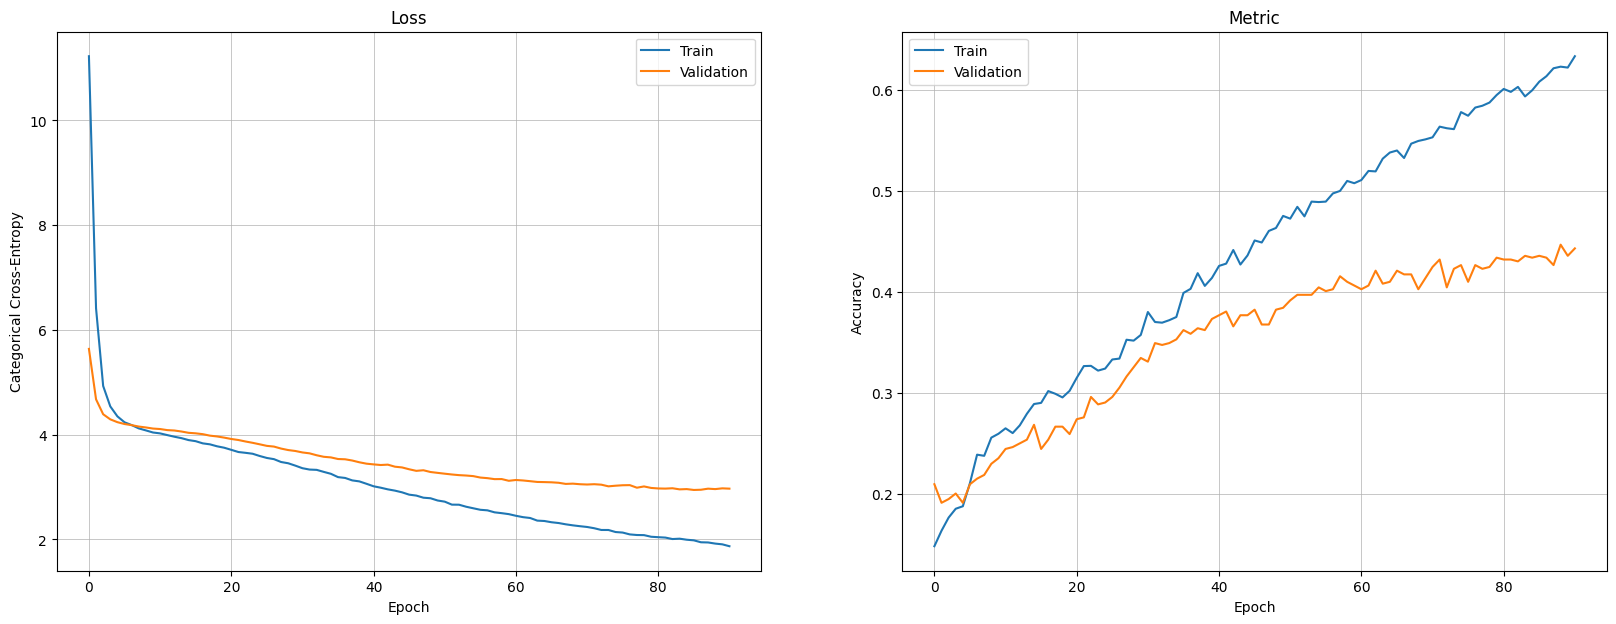

In [84]:
plot_history(history);